# 데이터 경로 세팅 + 라이브러리 세팅

In [1]:
votes_path = "G:/내 드라이브/part4_team4/votes"
hackle_path = "G:/내 드라이브/part4_team4/hackle"
hackle_add_path = "G:/내 드라이브/part4_team4/hackle_add"

# 분석에 필요한 라이브러리 불러오기
import pandas as pd
import duckdb
import os
import sys
import json
import datetime
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import seaborn as sns


# VOTES 데이터 간단 확인


## 1. accounts_timelinereport 테이블

In [ ]:
# 데이터 미리보기
print("=== 상위 5행 ===")
accounts_timelinereport.head()


=== 상위 5행 ===


id             reason          created_at  reported_user_id  user_id  \
0  28            타인을 사칭함 2023-05-06 04:44:57            874587   885082   
1  37  친구를 비하하거나 조롱하는 어투 2023-05-06 05:41:19            881048   881298   
2  46  친구를 비하하거나 조롱하는 어투 2023-05-06 06:26:59            887882   881945   
3  64           허위 사실 언급 2023-05-06 07:07:46            888610   893684   
4  65           허위 사실 언급 2023-05-06 07:07:52            888610   893684   

   user_question_record_id  
0                  3920588  
1                  4018679  
2                  4120914  
3                  4143049  
4                  4143049

In [ ]:
print("\n=== 기본 통계 ===")
accounts_timelinereport.describe()


=== 기본 통계 ===


id                  created_at  reported_user_id  \
count    208.000000                         208      2.080000e+02   
mean    9786.269231  2023-05-15 08:13:50.278846      1.132497e+06   
min       28.000000         2023-05-06 04:44:57      8.372350e+05   
25%     6123.750000  2023-05-11 16:41:43.500000      9.664702e+05   
50%    10095.000000         2023-05-15 01:23:29      1.144432e+06   
75%    14182.250000         2023-05-18 18:01:18      1.225963e+06   
max    23108.000000         2023-06-02 08:30:06      1.562736e+06   
std     5713.767759                         NaN      1.694121e+05   

            user_id  user_question_record_id  
count  2.080000e+02             2.080000e+02  
mean   1.159946e+06             4.932558e+07  
min    8.340890e+05             3.920588e+06  
25%    9.671202e+05             2.461178e+07  
50%    1.184397e+06             4.740327e+07  
75%    1.291813e+06             7.179578e+07  
max    1.548002e+06             1.407659e+08  
std    1.800959e+05             3.311281e+07

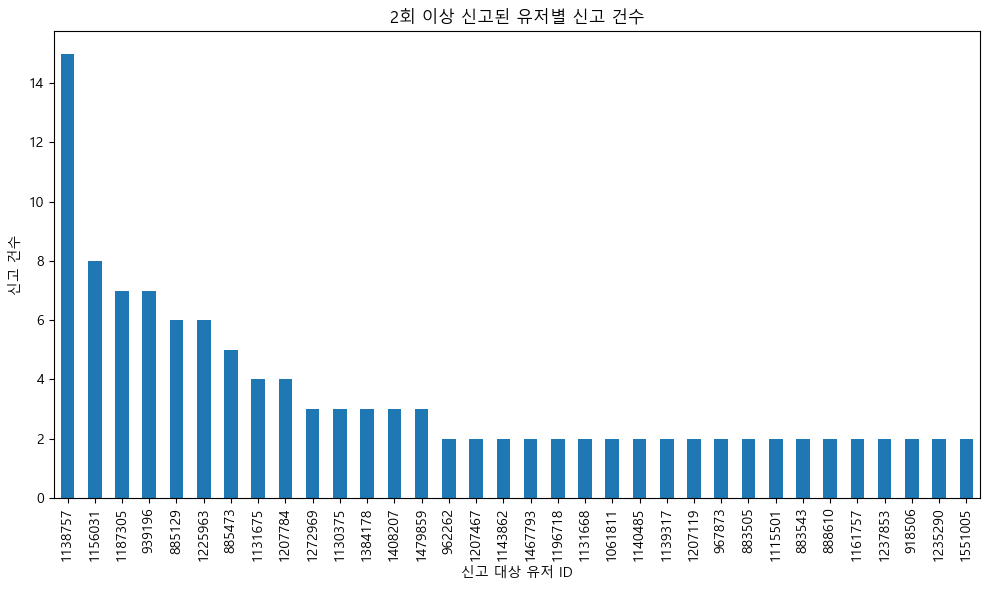

In [ ]:
import matplotlib.pyplot as plt

# 신고 대상 유저별 신고 건수 집계
reported_counts = accounts_timelinereport['reported_user_id'].value_counts()
multi_reported = reported_counts[reported_counts > 1]

# 시각화
plt.figure(figsize=(10, 6))
multi_reported.plot(kind='bar')
plt.title('2회 이상 신고된 유저별 신고 건수')
plt.xlabel('신고 대상 유저 ID')
plt.ylabel('신고 건수')
plt.tight_layout()
plt.show();

신고를 많이 당한 악성 유저가 있음

In [ ]:
# accounts_timelinereport 테이블 컬럼별 상세 분석

print("=== accounts_timelinereport 테이블 컬럼별 분석 ===")
print(f"전체 데이터 수: {len(accounts_timelinereport):,}건")
print(f"컬럼 수: {len(accounts_timelinereport.columns)}개")
print()

for col in accounts_timelinereport.columns:
    print(f"📊 {col}")
    print(f"   - 데이터 타입: {accounts_timelinereport[col].dtype}")
    print(f"   - 고유값 개수: {accounts_timelinereport[col].nunique():,}개")
    print(f"   - 결측치: {accounts_timelinereport[col].isnull().sum():,}개 ({accounts_timelinereport[col].isnull().sum()/len(accounts_timelinereport)*100:.2f}%)")
    
    # 데이터 타입별 상세 분석
    if accounts_timelinereport[col].dtype == 'object':
        # 문자열/카테고리 컬럼
        value_counts = accounts_timelinereport[col].value_counts()
        print(f"   - 가장 빈번한 값: {value_counts.index[0]} ({value_counts.iloc[0]:,}건, {value_counts.iloc[0]/len(accounts_timelinereport)*100:.2f}%)")
        if len(value_counts) <= 10:
            print(f"   - 전체 값 분포:")
            for val, count in value_counts.items():
                print(f"     {val}: {count:,}건 ({count/len(accounts_timelinereport)*100:.2f}%)")
        else:
            print(f"   - 상위 5개 값:")
            for i, (val, count) in enumerate(value_counts.head().items()):
                print(f"     {val}: {count:,}건 ({count/len(accounts_timelinereport)*100:.2f}%)")
    
    elif accounts_timelinereport[col].dtype in ['int64', 'float64']:
        # 숫자 컬럼
        non_null_data = accounts_timelinereport[col].dropna()
        if len(non_null_data) > 0:
            print(f"   - 최솟값: {non_null_data.min():,}")
            print(f"   - 최댓값: {non_null_data.max():,}")
            print(f"   - 평균: {non_null_data.mean():.2f}")
            print(f"   - 중위수: {non_null_data.median():.2f}")
            
            # 고유값이 적으면 분포 표시
            if accounts_timelinereport[col].nunique() <= 10:
                value_counts = accounts_timelinereport[col].value_counts().sort_index()
                print(f"   - 값 분포:")
                for val, count in value_counts.items():
                    print(f"     {val}: {count:,}건 ({count/len(accounts_timelinereport)*100:.2f}%)")
    
    elif 'datetime' in str(accounts_timelinereport[col].dtype):
        # 날짜/시간 컬럼
        non_null_data = accounts_timelinereport[col].dropna()
        if len(non_null_data) > 0:
            print(f"   - 최초 날짜: {non_null_data.min()}")
            print(f"   - 최근 날짜: {non_null_data.max()}")
            print(f"   - 기간: {(non_null_data.max() - non_null_data.min()).days}일")
    
    print()

=== accounts_timelinereport 테이블 컬럼별 분석 ===
전체 데이터 수: 208건
컬럼 수: 6개

📊 id
   - 데이터 타입: int64
   - 고유값 개수: 208개
   - 결측치: 0개 (0.00%)
   - 최솟값: 28
   - 최댓값: 23,108
   - 평균: 9786.27
   - 중위수: 10095.00

📊 reason
   - 데이터 타입: object
   - 고유값 개수: 5개
   - 결측치: 0개 (0.00%)
   - 가장 빈번한 값: 허위 사실 언급 (80건, 38.46%)
   - 전체 값 분포:
     허위 사실 언급: 80건 (38.46%)
     친구를 비하하거나 조롱하는 어투: 64건 (30.77%)
     선정적이거나 폭력적인 내용: 39건 (18.75%)
     타인을 사칭함: 15건 (7.21%)
     광고: 10건 (4.81%)

📊 created_at
   - 데이터 타입: datetime64[us]
   - 고유값 개수: 208개
   - 결측치: 0개 (0.00%)
   - 최초 날짜: 2023-05-06 04:44:57
   - 최근 날짜: 2023-06-02 08:30:06
   - 기간: 27일

📊 reported_user_id
   - 데이터 타입: int64
   - 고유값 개수: 125개
   - 결측치: 0개 (0.00%)
   - 최솟값: 837,235
   - 최댓값: 1,562,736
   - 평균: 1132496.88
   - 중위수: 1144432.00

📊 user_id
   - 데이터 타입: int64
   - 고유값 개수: 115개
   - 결측치: 0개 (0.00%)
   - 최솟값: 834,089
   - 최댓값: 1,548,002
   - 평균: 1159945.67
   - 중위수: 1184397.00

📊 user_question_record_id
   - 데이터 타입: int64
   - 고유값 개수: 163개
   - 결측치: 0

### 2. accounts_userquestionrecord 투표 기록

In [ ]:
# accounts_userquestionrecord 테이블 info() 확인
print("=== accounts_userquestionrecord 테이블 정보 ===")
accounts_userquestionrecord.info()

=== accounts_userquestionrecord 테이블 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217558 entries, 0 to 1217557
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1217558 non-null  int64         
 1   status             1217558 non-null  object        
 2   created_at         1217558 non-null  datetime64[us]
 3   chosen_user_id     1217558 non-null  int64         
 4   question_id        1217558 non-null  int64         
 5   user_id            1217558 non-null  int64         
 6   question_piece_id  1217558 non-null  int64         
 7   has_read           1217558 non-null  int64         
 8   answer_status      1217558 non-null  object        
 9   answer_updated_at  1217558 non-null  datetime64[us]
 10  report_count       1217558 non-null  int64         
 11  opened_times       1217558 non-null  int64         
dtypes: datetime64[us](2), int64(8), object(2)

In [ ]:
# accounts_userquestionrecord 테이블 컬럼별 상세 분석

print("=== accounts_userquestionrecord 테이블 컬럼별 상세 분석 ===")
print(f"전체 데이터 수: {len(accounts_userquestionrecord):,}건")
print(f"컬럼 수: {len(accounts_userquestionrecord.columns)}개")
print()

# 1. id 컬럼 분석
print("📊 1. id (고유 식별자)")
print(f"   - 최솟값: {accounts_userquestionrecord['id'].min():,}")
print(f"   - 최댓값: {accounts_userquestionrecord['id'].max():,}")
print(f"   - 고유값 개수: {accounts_userquestionrecord['id'].nunique():,}개")
print(f"   - 중복값: {accounts_userquestionrecord['id'].duplicated().sum()}개")
print()

# 2. status 컬럼 분석  
print("📊 2. status (상태)")
status_counts = accounts_userquestionrecord['status'].value_counts()
print(f"   - 고유값 개수: {len(status_counts)}개")
for status, count in status_counts.items():
    percentage = count/len(accounts_userquestionrecord)*100
    print(f"   - {status}: {count:,}건 ({percentage:.1f}%)")
print()

# 3. chosen_user_id 분석
print("📊 3. chosen_user_id (선택받은 유저 ID)")
print(f"   - 고유 유저 수: {accounts_userquestionrecord['chosen_user_id'].nunique():,}명")
print(f"   - 최솟값: {accounts_userquestionrecord['chosen_user_id'].min():,}")
print(f"   - 최댓값: {accounts_userquestionrecord['chosen_user_id'].max():,}")
# 가장 많이 선택받은 유저
chosen_counts = accounts_userquestionrecord['chosen_user_id'].value_counts()
print(f"   - 가장 많이 선택받은 유저: {chosen_counts.iloc[0]:,}번 선택받음")
print(f"   - 평균 선택받은 횟수: {chosen_counts.mean():.1f}번")
print()

# 4. user_id 분석 (선택한 유저)
print("📊 4. user_id (선택한 유저 ID)")
print(f"   - 고유 유저 수: {accounts_userquestionrecord['user_id'].nunique():,}명")
user_counts = accounts_userquestionrecord['user_id'].value_counts()
print(f"   - 가장 많이 선택한 유저: {user_counts.iloc[0]:,}번 선택")
print(f"   - 평균 선택 횟수: {user_counts.mean():.1f}번")
print()

# 5. question_id 분석
print("📊 5. question_id (질문 ID)")
print(f"   - 고유 질문 수: {accounts_userquestionrecord['question_id'].nunique():,}개")
print(f"   - 질문 범위: {accounts_userquestionrecord['question_id'].min()} ~ {accounts_userquestionrecord['question_id'].max()}")
question_counts = accounts_userquestionrecord['question_id'].value_counts()
print(f"   - 가장 많이 사용된 질문: {question_counts.iloc[0]:,}번 사용")
print()

# 6. question_piece_id 분석
print("📊 6. question_piece_id (투표 ID)")
print(f"   - 고유 투표 수: {accounts_userquestionrecord['question_piece_id'].nunique():,}개")
print(f"   - 투표 범위: {accounts_userquestionrecord['question_piece_id'].min():,} ~ {accounts_userquestionrecord['question_piece_id'].max():,}")
piece_counts = accounts_userquestionrecord['question_piece_id'].value_counts()
print(f"   - 가장 많이 참여된 투표: {piece_counts.iloc[0]:,}번 참여")
print()

# 7. has_read 분석 (읽었는지 여부)
print("📊 7. has_read (읽었는지 여부)")
read_counts = accounts_userquestionrecord['has_read'].value_counts()
total = len(accounts_userquestionrecord)
for value, count in read_counts.items():
    status_text = "읽음" if value == 1 else "읽지않음"
    percentage = count/total*100
    print(f"   - {value} ({status_text}): {count:,}건 ({percentage:.1f}%)")
print()

# 8. answer_status 분석
print("📊 8. answer_status (답장 상태)")
answer_counts = accounts_userquestionrecord['answer_status'].value_counts()
for status, count in answer_counts.items():
    percentage = count/len(accounts_userquestionrecord)*100
    print(f"   - {status}: {count:,}건 ({percentage:.1f}%)")
print()

# 9. report_count 분석
print("📊 9. report_count (신고 횟수)")
report_counts = accounts_userquestionrecord['report_count'].value_counts().sort_index()
print(f"   - 최대 신고 횟수: {accounts_userquestionrecord['report_count'].max()}회")
print(f"   - 평균 신고 횟수: {accounts_userquestionrecord['report_count'].mean():.4f}회")
print(f"   - 신고받은 기록 수: {(accounts_userquestionrecord['report_count'] > 0).sum():,}건")
if len(report_counts) <= 10:
    print("   - 신고 횟수별 분포:")
    for count, freq in report_counts.items():
        percentage = freq/len(accounts_userquestionrecord)*100
        print(f"     {count}회: {freq:,}건 ({percentage:.1f}%)")
print()

# 10. opened_times 분석
print("📊 10. opened_times (열어본 횟수)")
opened_counts = accounts_userquestionrecord['opened_times'].value_counts().sort_index()
print(f"   - 최대 열어본 횟수: {accounts_userquestionrecord['opened_times'].max()}회")
print(f"   - 평균 열어본 횟수: {accounts_userquestionrecord['opened_times'].mean():.3f}회")
if len(opened_counts) <= 10:
    print("   - 열어본 횟수별 분포:")
    for times, freq in opened_counts.items():
        percentage = freq/len(accounts_userquestionrecord)*100
        print(f"     {times}회: {freq:,}건 ({percentage:.1f}%)")
print()

# 11. created_at 분석
print("📊 11. created_at (생성일시)")
print(f"   - 최초 날짜: {accounts_userquestionrecord['created_at'].min()}")
print(f"   - 최근 날짜: {accounts_userquestionrecord['created_at'].max()}")
date_range = (accounts_userquestionrecord['created_at'].max() - accounts_userquestionrecord['created_at'].min()).days
print(f"   - 기간: {date_range}일")
print()

# 12. answer_updated_at 분석
print("📊 12. answer_updated_at (답장 업데이트 일시)")
print(f"   - 최초 답장 날짜: {accounts_userquestionrecord['answer_updated_at'].min()}")
print(f"   - 최근 답장 날짜: {accounts_userquestionrecord['answer_updated_at'].max()}")
print(f"   - created_at과 동일한지 확인: {(accounts_userquestionrecord['created_at'] == accounts_userquestionrecord['answer_updated_at']).sum():,}건")

=== accounts_userquestionrecord 테이블 컬럼별 상세 분석 ===
전체 데이터 수: 1,217,558건
컬럼 수: 12개

📊 1. id (고유 식별자)
   - 최솟값: 771,777
   - 최댓값: 161,666,464
   - 고유값 개수: 1,217,558개
   - 중복값: 0개

📊 2. status (상태)
   - 고유값 개수: 3개
   - C: 1,156,322건 (95.0%)
   - I: 60,578건 (5.0%)
   - B: 658건 (0.1%)

📊 3. chosen_user_id (선택받은 유저 ID)
   - 고유 유저 수: 15,426명
   - 최솟값: 833,112
   - 최댓값: 1,579,422
   - 가장 많이 선택받은 유저: 1,239번 선택받음
   - 평균 선택받은 횟수: 78.9번

📊 4. user_id (선택한 유저 ID)
   - 고유 유저 수: 4,849명
   - 가장 많이 선택한 유저: 2,786번 선택
   - 평균 선택 횟수: 251.1번

📊 5. question_id (질문 ID)
   - 고유 질문 수: 4,805개
   - 질문 범위: 99 ~ 5133
   - 가장 많이 사용된 질문: 1,996번 사용

📊 6. question_piece_id (투표 ID)
   - 고유 투표 수: 1,217,558개
   - 투표 범위: 998,458 ~ 208,351,468
   - 가장 많이 선택받은 유저: 1,239번 선택받음
   - 평균 선택받은 횟수: 78.9번

📊 4. user_id (선택한 유저 ID)
   - 고유 유저 수: 4,849명
   - 가장 많이 선택한 유저: 2,786번 선택
   - 평균 선택 횟수: 251.1번

📊 5. question_id (질문 ID)
   - 고유 질문 수: 4,805개
   - 질문 범위: 99 ~ 5133
   - 가장 많이 사용된 질문: 1,996번 사용

📊 6. question_piece_id (투표 ID)
 

In [ ]:
# 특이점 분석
print("=== 특이점 분석 ===")

# 자기 자신을 선택한 경우
self_choices = accounts_userquestionrecord[accounts_userquestionrecord['user_id'] == accounts_userquestionrecord['chosen_user_id']]
print(f"🔍 자기 자신을 선택한 경우: {len(self_choices):,}건")

# status와 has_read 관계
print(f"\n🔍 status별 읽음 비율:")
status_read = accounts_userquestionrecord.groupby('status')['has_read'].agg(['count', 'sum', 'mean'])
for status in status_read.index:
    total = status_read.loc[status, 'count']
    read = status_read.loc[status, 'sum'] 
    rate = status_read.loc[status, 'mean'] * 100
    print(f"   {status}: {read:,}/{total:,} ({rate:.1f}% 읽음)")

# answer_status와 has_read 관계
print(f"\n🔍 answer_status별 읽음 비율:")
answer_read = accounts_userquestionrecord.groupby('answer_status')['has_read'].agg(['count', 'sum', 'mean'])
for answer in answer_read.index:
    total = answer_read.loc[answer, 'count']
    read = answer_read.loc[answer, 'sum']
    rate = answer_read.loc[answer, 'mean'] * 100
    print(f"   {answer}: {read:,}/{total:,} ({rate:.1f}% 읽음)")

# 시간 패턴 분석
print(f"\n🔍 월별 투표 기록 분포:")
accounts_userquestionrecord['year_month'] = accounts_userquestionrecord['created_at'].dt.to_period('M')
monthly = accounts_userquestionrecord['year_month'].value_counts().sort_index()
for period, count in monthly.head(10).items():
    print(f"   {period}: {count:,}건")
if len(monthly) > 10:
    print(f"   ... (총 {len(monthly)}개월)")

print()
print("🎉 분석 완료!")

=== 특이점 분석 ===
🔍 자기 자신을 선택한 경우: 1,959건

🔍 status별 읽음 비율:
   B: 332/658 (50.5% 읽음)
   C: 618,650/1,156,322 (53.5% 읽음)
   I: 56,949/60,578 (94.0% 읽음)

🔍 answer_status별 읽음 비율:
   A: 111,761/111,761 (100.0% 읽음)
   N: 556,305/1,097,932 (50.7% 읽음)
   P: 7,865/7,865 (100.0% 읽음)

🔍 월별 투표 기록 분포:
   2023-04: 30,798건
   2023-05: 1,104,681건
   2023-06: 71,341건
   2023-07: 5,396건
   2023-08: 2,050건
   2023-09: 1,665건
   2023-10: 330건
   2023-11: 253건
   2023-12: 502건
   2024-01: 236건
   ... (총 14개월)

🎉 분석 완료!


### 3. polls_question 질문 데이터 테이블

In [ ]:
polls_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             5025 non-null   int64         
 1   question_text  5025 non-null   object        
 2   created_at     5025 non-null   datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 117.9+ KB


In [ ]:
# polls_question에서 랜덤으로 20개 샘플 추출
sample_questions = polls_question.sample(n=20, random_state=42)
sample_questions

id                           question_text          created_at
877    986                      가장 운이 좋을 것 같은 사람은? 2023-05-15 14:00:29
4885  4994                  시험볼 때 긴장 전혀 안할 것 같은 사람 2023-06-06 06:15:50
2484  2593                             뭘 해도 성공할 사람 2023-06-02 08:06:52
2288  2397                 솔직히 길가다 얘 보면 번호딴다 싶은 친구 2023-06-02 08:06:46
811    920                                    강아지상 2023-05-15 14:00:02
248    347                  노래 부를 때 감성이 가장 좋은 사람은? 2023-05-02 05:32:37
3298  3407                       가장 소설 잘 쓸 것 같은 사람 2023-06-06 06:10:08
106    205                  항상 모두에게 좋은 말을 해주는 사람은? 2023-04-01 11:09:19
279    378                       땀 흘리는게 제일 멋진 사람은? 2023-05-02 05:32:45
1281  1390                            보부상 재질인 친구는? 2023-05-15 14:03:14
2822  2931                                그리운 사람은? 2023-06-02 08:07:02
4159  4268                                맞춤법 고수는? 2023-06-06 06:15:40
5023  5132  아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는? 2023-06-06 06:15:52
3970  4079   길거리에서 랜덤플레이댄스 하면 바로 나가서 춤 출 것 같은 사람은? 2023-06-06 06:10:16
333    432                 매일 탕후루 하나씩 먹을 것 같은 사람은? 2023-05-02 05:32:58
3064  3173                             매력적이게 생긴 사람 2023-06-06 06:10:05
501    600               지금 집앞에 놀자고 나오라고 하고싶은 친구는? 2023-05-11 15:52:30
2092  2201                    옷장이 제일 깔끔할 것 같은 사람은? 2023-06-02 08:06:40
3253  3362                남들에게 제일 씀씀이가 클 것 같은 사람은? 2023-06-06 06:10:07
1477  1586                      사귀면 애교가 많을 것 같은 사람 2023-05-15 14:04:33

In [ ]:
polls_question.describe(include='all')

id question_text                  created_at
count   5025.000000          5025                        5025
unique          NaN          3903                         NaN
top             NaN          vote                         NaN
freq            NaN            56                         NaN
mean    2619.897512           NaN  2023-05-26 17:49:11.666268
min       99.000000           NaN         2023-03-31 15:22:53
25%     1365.000000           NaN         2023-05-15 14:03:03
50%     2621.000000           NaN         2023-06-02 08:06:53
75%     3877.000000           NaN         2023-06-06 06:10:14
max     5133.000000           NaN         2023-06-06 06:15:52
std     1452.438472           NaN                         NaN

## 4. polls_questionpiece 질문 조각

In [ ]:
polls_questionpiece.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265476 entries, 0 to 1265475
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1265476 non-null  int64         
 1   is_voted     1265476 non-null  int64         
 2   created_at   1265476 non-null  datetime64[us]
 3   question_id  1265476 non-null  int64         
 4   is_skipped   1265476 non-null  int64         
dtypes: datetime64[us](1), int64(4)
memory usage: 48.3 MB


In [ ]:
# polls_questionpiece 테이블 컬럼별 상세 분석

print("=== polls_questionpiece 테이블 컬럼별 상세 분석 ===")
print(f"전체 데이터 수: {len(polls_questionpiece):,}건")
print(f"컬럼 수: {len(polls_questionpiece.columns)}개")
print()

# 1. id 컬럼 분석 (고유 식별자)
print("📊 1. id (투표 조각 고유 식별자)")
print(f"   - 최솟값: {polls_questionpiece['id'].min():,}")
print(f"   - 최댓값: {polls_questionpiece['id'].max():,}")
print(f"   - 고유값 개수: {polls_questionpiece['id'].nunique():,}개")
print(f"   - 중복값: {polls_questionpiece['id'].duplicated().sum()}개")
# ID의 연속성 확인
id_range = polls_questionpiece['id'].max() - polls_questionpiece['id'].min() + 1
missing_ids = id_range - polls_questionpiece['id'].nunique()
print(f"   - ID 범위 내 누락된 값: {missing_ids:,}개")
print()

# 2. is_voted 분석 (투표 여부)
print("📊 2. is_voted (투표 여부)")
voted_counts = polls_questionpiece['is_voted'].value_counts().sort_index()
total = len(polls_questionpiece)
for value, count in voted_counts.items():
    status_text = "투표함" if value == 1 else "투표안함"
    percentage = count/total*100
    print(f"   - {value} ({status_text}): {count:,}건 ({percentage:.1f}%)")
vote_rate = polls_questionpiece['is_voted'].mean() * 100
print(f"   - 전체 투표율: {vote_rate:.1f}%")
print()

# 3. question_id 분석
print("📊 3. question_id (질문 ID)")
print(f"   - 고유 질문 수: {polls_questionpiece['question_id'].nunique():,}개")
print(f"   - 질문 범위: {polls_questionpiece['question_id'].min()} ~ {polls_questionpiece['question_id'].max()}")
question_counts = polls_questionpiece['question_id'].value_counts()
print(f"   - 가장 많은 투표 조각을 가진 질문: {question_counts.iloc[0]:,}개 조각")
print(f"   - 평균 투표 조각 수 (질문당): {question_counts.mean():.1f}개")
print("   - 상위 5개 질문별 투표 조각 수:")
for i, (qid, count) in enumerate(question_counts.head().items()):
    vote_count = polls_questionpiece[polls_questionpiece['question_id'] == qid]['is_voted'].sum()
    vote_rate = vote_count / count * 100
    print(f"     질문 {qid}: {count:,}개 조각, {vote_count:,}개 투표 ({vote_rate:.1f}% 투표율)")
print()

# 4. is_skipped 분석 (건너뛰기 여부)
print("📊 4. is_skipped (건너뛰기 여부)")
skipped_counts = polls_questionpiece['is_skipped'].value_counts().sort_index()
for value, count in skipped_counts.items():
    status_text = "건너뜀" if value == 1 else "건너뛰지않음"
    percentage = count/total*100
    print(f"   - {value} ({status_text}): {count:,}건 ({percentage:.1f}%)")
skip_rate = polls_questionpiece['is_skipped'].mean() * 100
print(f"   - 전체 건너뛰기율: {skip_rate:.1f}%")
print()

# 5. created_at 분석 (생성일시)
print("📊 5. created_at (생성일시)")
print(f"   - 최초 날짜: {polls_questionpiece['created_at'].min()}")
print(f"   - 최근 날짜: {polls_questionpiece['created_at'].max()}")
date_range = (polls_questionpiece['created_at'].max() - polls_questionpiece['created_at'].min()).days
print(f"   - 기간: {date_range}일")
# 월별 생성 패턴
polls_questionpiece['year_month'] = polls_questionpiece['created_at'].dt.to_period('M')
monthly_creation = polls_questionpiece['year_month'].value_counts().sort_index()
print(f"   - 월별 투표 조각 생성 패턴 (상위 5개월):")
for period, count in monthly_creation.head().items():
    print(f"     {period}: {count:,}개")
print()

# 6. 투표/건너뛰기 교차분석
print("📊 6. 투표 vs 건너뛰기 교차분석")
cross_tab = pd.crosstab(polls_questionpiece['is_voted'], polls_questionpiece['is_skipped'], margins=True)
print("   - 교차표:")
print(cross_tab)
print()
print("   - 비율 분석:")
both_zero = ((polls_questionpiece['is_voted'] == 0) & (polls_questionpiece['is_skipped'] == 0)).sum()
voted_not_skipped = ((polls_questionpiece['is_voted'] == 1) & (polls_questionpiece['is_skipped'] == 0)).sum()
not_voted_skipped = ((polls_questionpiece['is_voted'] == 0) & (polls_questionpiece['is_skipped'] == 1)).sum()
voted_and_skipped = ((polls_questionpiece['is_voted'] == 1) & (polls_questionpiece['is_skipped'] == 1)).sum()

print(f"     투표안함+건너뛰지않음: {both_zero:,}건 ({both_zero/total*100:.1f}%)")
print(f"     투표함+건너뛰지않음: {voted_not_skipped:,}건 ({voted_not_skipped/total*100:.1f}%)")
print(f"     투표안함+건너뜀: {not_voted_skipped:,}건 ({not_voted_skipped/total*100:.1f}%)")
print(f"     투표함+건너뜀: {voted_and_skipped:,}건 ({voted_and_skipped/total*100:.1f}%)")
print()

# 7. 질문별 투표율 순위
print("📊 7. 질문별 투표율 분석")
question_stats = polls_questionpiece.groupby('question_id').agg({
    'is_voted': ['count', 'sum', 'mean'],
    'is_skipped': 'mean'
}).round(3)

question_stats.columns = ['총_조각수', '투표수', '투표율', '건너뛰기율']
question_stats = question_stats.sort_values('투표율', ascending=False)

print("   - 투표율 상위 10개 질문:")
for qid, row in question_stats.head(10).iterrows():
    print(f"     질문 {qid}: {row['투표율']*100:.1f}% 투표율 ({row['투표수']:.0f}/{row['총_조각수']:.0f})")

print(f"\n   - 투표율 하위 5개 질문:")
for qid, row in question_stats.tail(5).iterrows():
    print(f"     질문 {qid}: {row['투표율']*100:.1f}% 투표율 ({row['투표수']:.0f}/{row['총_조각수']:.0f})")

print()
print("🎉 polls_questionpiece 상세 분석 완료!")

=== polls_questionpiece 테이블 컬럼별 상세 분석 ===
전체 데이터 수: 1,265,476건
컬럼 수: 5개

📊 1. id (투표 조각 고유 식별자)
   - 최솟값: 998,458
   - 최댓값: 208,385,230
   - 고유값 개수: 1,265,476개
   - 중복값: 0개
   - ID 범위 내 누락된 값: 206,121,297개

📊 2. is_voted (투표 여부)
   - 0 (투표안함): 46,789건 (3.7%)
   - 1 (투표함): 1,218,687건 (96.3%)
   - 전체 투표율: 96.3%

📊 3. question_id (질문 ID)
   - 고유 질문 수: 4,944개
   - 질문 범위: 99 ~ 5133
   - 가장 많은 투표 조각을 가진 질문: 2,030개 조각
   - 평균 투표 조각 수 (질문당): 256.0개
   - 상위 5개 질문별 투표 조각 수:
     질문 170: 2,030개 조각, 1,998개 투표 (98.4% 투표율)
     질문 290: 2,021개 조각, 1,987개 투표 (98.3% 투표율)
     질문 169: 2,017개 조각, 1,985개 투표 (98.4% 투표율)
     질문 211: 2,009개 조각, 1,975개 투표 (98.3% 투표율)
     질문 186: 1,991개 조각, 1,953개 투표 (98.1% 투표율)

📊 4. is_skipped (건너뛰기 여부)
   - 0 (건너뛰지않음): 1,264,349건 (99.9%)
   - 1 (건너뜀): 1,127건 (0.1%)
   - 전체 건너뛰기율: 0.1%

📊 5. created_at (생성일시)
   - 최초 날짜: 2023-04-28 12:27:22
   - 최근 날짜: 2024-05-07 11:32:30
   - 기간: 374일
   - 월별 투표 조각 생성 패턴 (상위 5개월):
     2023-04: 33,651개
     2023-05: 1,144,964개
     2023-0

## 5. polls_questionreport 질문에 대한 신고기록

In [ ]:
# polls_questionreport 테이블 컬럼별 상세 분석

print("=== polls_questionreport 테이블 컬럼별 상세 분석 ===")
print(f"전체 데이터 수: {len(polls_questionreport):,}건")
print(f"컬럼 수: {len(polls_questionreport.columns)}개")
print()

# 1. id 컬럼 분석 (고유 식별자)
print("📊 1. id (신고 고유 식별자)")
print(f"   - 최솟값: {polls_questionreport['id'].min():,}")
print(f"   - 최댓값: {polls_questionreport['id'].max():,}")
print(f"   - 고유값 개수: {polls_questionreport['id'].nunique():,}개")
print(f"   - 중복값: {polls_questionreport['id'].duplicated().sum()}개")
# ID의 연속성 확인
id_range = polls_questionreport['id'].max() - polls_questionreport['id'].min() + 1
missing_ids = id_range - polls_questionreport['id'].nunique()
print(f"   - ID 범위 내 누락된 값: {missing_ids:,}개")
print()

# 2. reason 분석 (신고 사유)
print("📊 2. reason (신고 사유)")
reason_counts = polls_questionreport['reason'].value_counts()
total = len(polls_questionreport)
print(f"   - 고유 신고 사유 수: {len(reason_counts)}개")
print("   - 신고 사유별 분포:")
for reason, count in reason_counts.items():
    percentage = count/total*100
    print(f"     '{reason}': {count:,}건 ({percentage:.1f}%)")
print()

# 3. question_id 분석 (신고된 질문)
print("📊 3. question_id (신고된 질문 ID)")
print(f"   - 신고받은 고유 질문 수: {polls_questionreport['question_id'].nunique():,}개")
print(f"   - 질문 범위: {polls_questionreport['question_id'].min()} ~ {polls_questionreport['question_id'].max()}")
question_report_counts = polls_questionreport['question_id'].value_counts()
print(f"   - 가장 많이 신고받은 질문: {question_report_counts.iloc[0]:,}건 신고")
print(f"   - 평균 신고 건수 (질문당): {question_report_counts.mean():.1f}건")
print("   - 상위 10개 신고받은 질문:")
for i, (qid, count) in enumerate(question_report_counts.head(10).items()):
    print(f"     질문 {qid}: {count:,}건 신고")
print()

# 4. user_id 분석 (신고한 유저)
print("📊 4. user_id (신고한 유저 ID)")
print(f"   - 신고한 고유 유저 수: {polls_questionreport['user_id'].nunique():,}명")
print(f"   - 유저 범위: {polls_questionreport['user_id'].min():,} ~ {polls_questionreport['user_id'].max():,}")
user_report_counts = polls_questionreport['user_id'].value_counts()
print(f"   - 가장 많이 신고한 유저: {user_report_counts.iloc[0]:,}건 신고")
print(f"   - 평균 신고 건수 (유저당): {user_report_counts.mean():.1f}건")
# 신고 활동이 활발한 유저들
active_reporters = user_report_counts[user_report_counts > 5]
print(f"   - 6건 이상 신고한 유저: {len(active_reporters):,}명")
print("   - 상위 5명 신고 유저:")
for uid, count in user_report_counts.head().items():
    print(f"     유저 {uid}: {count:,}건 신고")
print()

# 5. created_at 분석 (신고 일시)
print("📊 5. created_at (신고 일시)")
print(f"   - 최초 신고 날짜: {polls_questionreport['created_at'].min()}")
print(f"   - 최근 신고 날짜: {polls_questionreport['created_at'].max()}")
date_range = (polls_questionreport['created_at'].max() - polls_questionreport['created_at'].min()).days
print(f"   - 기간: {date_range}일")
# 월별 신고 패턴
polls_questionreport['year_month'] = polls_questionreport['created_at'].dt.to_period('M')
monthly_reports = polls_questionreport['year_month'].value_counts().sort_index()
print(f"   - 월별 신고 패턴 (상위 5개월):")
for period, count in monthly_reports.head().items():
    print(f"     {period}: {count:,}건")
print()

# 6. 신고 사유별 상세 분석
print("📊 6. 신고 사유별 상세 분석")
reason_analysis = polls_questionreport.groupby('reason').agg({
    'question_id': 'nunique',  # 신고받은 고유 질문 수
    'user_id': 'nunique',      # 신고한 고유 유저 수
    'id': 'count'              # 총 신고 건수
}).rename(columns={'question_id': '신고받은_질문수', 'user_id': '신고한_유저수', 'id': '총_신고건수'})

for reason, row in reason_analysis.iterrows():
    print(f"   - '{reason}':")
    print(f"     총 신고 건수: {row['총_신고건수']:,}건")
    print(f"     신고받은 질문 수: {row['신고받은_질문수']:,}개")
    print(f"     신고한 유저 수: {row['신고한_유저수']:,}명")
    avg_per_question = row['총_신고건수'] / row['신고받은_질문수']
    avg_per_user = row['총_신고건수'] / row['신고한_유저수']
    print(f"     질문당 평균 신고: {avg_per_question:.1f}건")
    print(f"     유저당 평균 신고: {avg_per_user:.1f}건")
    print()

# 7. 중복 신고 분석
print("📊 7. 중복 신고 분석")
# 같은 유저가 같은 질문을 여러 번 신고한 경우
duplicate_reports = polls_questionreport.groupby(['user_id', 'question_id']).size()
multiple_reports = duplicate_reports[duplicate_reports > 1]
print(f"   - 같은 유저가 같은 질문을 여러 번 신고한 경우: {len(multiple_reports):,}쌍")
if len(multiple_reports) > 0:
    print(f"   - 최대 중복 신고 횟수: {multiple_reports.max()}회")
    print("   - 상위 5개 중복 신고:")
    for (uid, qid), count in multiple_reports.sort_values(ascending=False).head().items():
        print(f"     유저 {uid} → 질문 {qid}: {count}번 신고")

# 8. 시간대별 신고 패턴
print(f"\n📊 8. 시간대별 신고 패턴")
polls_questionreport['hour'] = polls_questionreport['created_at'].dt.hour
hourly_reports = polls_questionreport['hour'].value_counts().sort_index()
print("   - 시간대별 신고 분포 (상위 5시간):")
for hour, count in hourly_reports.sort_values(ascending=False).head().items():
    percentage = count/total*100
    print(f"     {hour:02d}시: {count:,}건 ({percentage:.1f}%)")

print()
print("🎉 polls_questionreport 상세 분석 완료!")

=== polls_questionreport 테이블 컬럼별 상세 분석 ===
전체 데이터 수: 51,424건
컬럼 수: 5개

📊 1. id (신고 고유 식별자)
   - 최솟값: 1
   - 최댓값: 55,767
   - 고유값 개수: 51,424개
   - 중복값: 0개
   - ID 범위 내 누락된 값: 4,343개

📊 2. reason (신고 사유)
   - 고유 신고 사유 수: 11개
   - 신고 사유별 분포:
     '그냥 싫어': 28,446건 (55.3%)
     '나랑 맞지 않는 질문인 것 같음': 9,541건 (18.6%)
     '불쾌한 질문 내용': 5,386건 (10.5%)
     '자꾸 같은 내용의 질문 반복': 3,202건 (6.2%)
     '어떻게 이런 생각을? 이 질문 최고!': 1,821건 (3.5%)
     '한 친구가 질문을 반복적으로 보냄': 1,701건 (3.3%)
     '기타': 480건 (0.9%)
     '이 질문은 재미없어요': 471건 (0.9%)
     '불쾌한 내용이 포함되어 있음': 250건 (0.5%)
     '오타가 있음': 68건 (0.1%)
     '선정적이거나 자극적인 질문': 58건 (0.1%)

📊 3. question_id (신고된 질문 ID)
   - 신고받은 고유 질문 수: 3,135개
   - 질문 범위: 99 ~ 5110
   - 가장 많이 신고받은 질문: 988건 신고
   - 평균 신고 건수 (질문당): 16.4건
   - 상위 10개 신고받은 질문:
     질문 111: 988건 신고
     질문 410: 803건 신고
     질문 398: 660건 신고
     질문 424: 533건 신고
     질문 305: 493건 신고
     질문 564: 338건 신고
     질문 144: 307건 신고
     질문 519: 283건 신고
     질문 494: 258건 신고
     질문 479: 239건 신고

📊 4. user_id (신고한 유

## 6. polls_questionset 질문 세트 테이블

In [ ]:
# polls_questionset 테이블 컬럼별 상세 분석

print("=== polls_questionset 테이블 컬럼별 상세 분석 ===")
print(f"전체 데이터 수: {len(polls_questionset):,}건")
print(f"컬럼 수: {len(polls_questionset.columns)}개")
print()

# 1. id 컬럼 분석 (고유 식별자)
print("📊 1. id (질문세트 고유 식별자)")
print(f"   - 최솟값: {polls_questionset['id'].min():,}")
print(f"   - 최댓값: {polls_questionset['id'].max():,}")
print(f"   - 고유값 개수: {polls_questionset['id'].nunique():,}개")
print(f"   - 중복값: {polls_questionset['id'].duplicated().sum()}개")
# ID의 연속성 확인
id_range = polls_questionset['id'].max() - polls_questionset['id'].min() + 1
missing_ids = id_range - polls_questionset['id'].nunique()
print(f"   - ID 범위 내 누락된 값: {missing_ids:,}개")
print()

# 2. question_piece_id_list 분석 (질문 조각 ID 리스트)
print("📊 2. question_piece_id_list (질문 조각 ID 리스트)")
print(f"   - 고유 리스트 수: {polls_questionset['question_piece_id_list'].nunique():,}개")
# 리스트 길이 분석
list_lengths = polls_questionset['question_piece_id_list'].apply(len)
print(f"   - 리스트 최소 길이: {list_lengths.min()}개")
print(f"   - 리스트 최대 길이: {list_lengths.max()}개")
print(f"   - 리스트 평균 길이: {list_lengths.mean():.1f}개")
print(f"   - 리스트 중위수 길이: {list_lengths.median():.0f}개")
print("   - 리스트 길이별 분포:")
length_counts = list_lengths.value_counts().sort_index()
for length, count in length_counts.head(10).items():
    percentage = count/len(polls_questionset)*100
    print(f"     {length}개: {count:,}건 ({percentage:.1f}%)")
if len(length_counts) > 10:
    print(f"     ... (총 {len(length_counts)}가지 길이)")
print()

# 3. opening_time 분석 (열림 시간)
print("📊 3. opening_time (질문세트 열림 시간)")
print(f"   - 최초 열림: {polls_questionset['opening_time'].min()}")
print(f"   - 최근 열림: {polls_questionset['opening_time'].max()}")
date_range = (polls_questionset['opening_time'].max() - polls_questionset['opening_time'].min()).days
print(f"   - 기간: {date_range}일")
# 월별 열림 패턴
polls_questionset['opening_month'] = polls_questionset['opening_time'].dt.to_period('M')
monthly_openings = polls_questionset['opening_month'].value_counts().sort_index()
print(f"   - 월별 질문세트 열림 패턴 (상위 5개월):")
for period, count in monthly_openings.head().items():
    print(f"     {period}: {count:,}개")
print()

# 4. status 분석 (상태)
print("📊 4. status (질문세트 상태)")
status_counts = polls_questionset['status'].value_counts()
total = len(polls_questionset)
print(f"   - 고유 상태 수: {len(status_counts)}개")
print("   - 상태별 분포:")
for status, count in status_counts.items():
    percentage = count/total*100
    print(f"     '{status}': {count:,}건 ({percentage:.1f}%)")
print()

# 5. created_at 분석 (생성 시간)
print("📊 5. created_at (질문세트 생성 시간)")
print(f"   - 최초 생성: {polls_questionset['created_at'].min()}")
print(f"   - 최근 생성: {polls_questionset['created_at'].max()}")
create_range = (polls_questionset['created_at'].max() - polls_questionset['created_at'].min()).days
print(f"   - 기간: {create_range}일")
# 생성과 열림 시간 차이 분석
time_diff = (polls_questionset['opening_time'] - polls_questionset['created_at']).dt.total_seconds() / 60
print(f"   - 생성 후 열림까지 평균 시간: {time_diff.mean():.1f}분")
print(f"   - 생성 후 열림까지 중위수 시간: {time_diff.median():.1f}분")
print(f"   - 생성 후 열림까지 최소 시간: {time_diff.min():.1f}분")
print(f"   - 생성 후 열림까지 최대 시간: {time_diff.max():.1f}분")
print()

# 6. user_id 분석 (생성한 유저)
print("📊 6. user_id (질문세트 생성 유저)")
print(f"   - 고유 유저 수: {polls_questionset['user_id'].nunique():,}명")
print(f"   - 유저 범위: {polls_questionset['user_id'].min():,} ~ {polls_questionset['user_id'].max():,}")
user_set_counts = polls_questionset['user_id'].value_counts()
print(f"   - 가장 많이 생성한 유저: {user_set_counts.iloc[0]:,}개 세트")
print(f"   - 평균 생성 수 (유저당): {user_set_counts.mean():.1f}개")
# 활발한 질문세트 생성자들
active_creators = user_set_counts[user_set_counts > 10]
print(f"   - 11개 이상 생성한 유저: {len(active_creators):,}명")
print("   - 상위 5명 생성 유저:")
for uid, count in user_set_counts.head().items():
    print(f"     유저 {uid}: {count:,}개 세트")
print()

# 7. 상태별 상세 분석
print("📊 7. 상태별 상세 분석")
status_analysis = polls_questionset.groupby('status').agg({
    'question_piece_id_list': lambda x: x.apply(len).mean(),  # 평균 리스트 길이
    'user_id': 'nunique',  # 고유 유저 수
    'id': 'count'  # 총 세트 수
}).rename(columns={'question_piece_id_list': '평균_질문조각수', 'user_id': '고유_유저수', 'id': '총_세트수'})

for status, row in status_analysis.iterrows():
    print(f"   - 상태 '{status}':")
    print(f"     총 세트 수: {row['총_세트수']:,}개")
    print(f"     고유 유저 수: {row['고유_유저수']:,}명")
    print(f"     평균 질문 조각 수: {row['평균_질문조각수']:.1f}개")
    user_per_set = row['총_세트수'] / row['고유_유저수'] if row['고유_유저수'] > 0 else 0
    print(f"     유저당 평균 세트 수: {user_per_set:.1f}개")
    print()

# 8. 시간대별 생성 패턴
print("📊 8. 시간대별 생성 패턴")
polls_questionset['create_hour'] = polls_questionset['created_at'].dt.hour
hourly_creation = polls_questionset['create_hour'].value_counts().sort_index()
print("   - 시간대별 생성 분포 (상위 5시간):")
for hour, count in hourly_creation.sort_values(ascending=False).head().items():
    percentage = count/total*100
    print(f"     {hour:02d}시: {count:,}건 ({percentage:.1f}%)")
print()

# 9. 질문 조각 중복 분석
print("📊 9. 질문 조각 중복 분석")
# 모든 질문 조각 ID를 플래튼화
all_pieces = []
for piece_list in polls_questionset['question_piece_id_list']:
    all_pieces.extend(piece_list)

unique_pieces = len(set(all_pieces))
total_pieces = len(all_pieces)
print(f"   - 전체 질문 조각 참조 수: {total_pieces:,}개")
print(f"   - 고유 질문 조각 수: {unique_pieces:,}개")
print(f"   - 중복 사용률: {((total_pieces - unique_pieces) / total_pieces * 100):.1f}%")

# 가장 많이 사용된 질문 조각
from collections import Counter
piece_counts = Counter(all_pieces)
print("   - 가장 많이 사용된 질문 조각 (상위 5개):")
for piece_id, count in piece_counts.most_common(5):
    print(f"     질문조각 {piece_id}: {count:,}번 사용")

print()
print("🎉 polls_questionset 상세 분석 완료!")

=== polls_questionset 테이블 컬럼별 상세 분석 ===
전체 데이터 수: 158,384건
컬럼 수: 6개

📊 1. id (질문세트 고유 식별자)
   - 최솟값: 99,817
   - 최댓값: 20,838,446
   - 고유값 개수: 158,384개
   - 중복값: 0개
   - ID 범위 내 누락된 값: 20,580,246개

📊 2. question_piece_id_list (질문 조각 ID 리스트)
   - 고유 리스트 수: 158,384개
   - 리스트 최소 길이: 80개
   - 리스트 최대 길이: 110개
   - 리스트 평균 길이: 101.4개
   - 리스트 중위수 길이: 100개
   - 리스트 길이별 분포:
     80개: 30건 (0.0%)
     90개: 30,929건 (19.5%)
     100개: 73,627건 (46.5%)
     110개: 53,798건 (34.0%)

📊 3. opening_time (질문세트 열림 시간)
   - 최초 열림: 2023-04-28 12:27:22
   - 최근 열림: 2024-05-07 12:12:30
   - 기간: 374일
   - 월별 질문세트 열림 패턴 (상위 5개월):
     2023-04: 4,164개
     2023-05: 143,158개
     2023-06: 9,579개
     2023-07: 720개
     2023-08: 273개

📊 4. status (질문세트 상태)
   - 고유 상태 수: 3개
   - 상태별 분포:
     'F': 153,411건 (96.9%)
     'O': 4,407건 (2.8%)
     'C': 566건 (0.4%)

📊 5. created_at (질문세트 생성 시간)
   - 최초 생성: 2023-04-28 12:27:23
   - 최근 생성: 2024-05-07 11:32:30
   - 기간: 374일
   - 생성 후 열림까지 평균 시간: 42.5분
   - 생성 후 열림까지 중위수 시간: 40.0분

## 7.polls_usercandidate 질문 조각에 등장하는 유저 

In [ ]:
# polls_usercandidate 테이블 컬럼별 상세 분석

print("=== polls_usercandidate 테이블 컬럼별 상세 분석 ===")
print(f"전체 데이터 수: {len(polls_usercandidate):,}건")
print(f"컬럼 수: {len(polls_usercandidate.columns)}개")
print()

# 1. id 컬럼 분석 (고유 식별자)
print("📊 1. id (후보자 고유 식별자)")
print(f"   - 최솟값: {polls_usercandidate['id'].min():,}")
print(f"   - 최댓값: {polls_usercandidate['id'].max():,}")
print(f"   - 고유값 개수: {polls_usercandidate['id'].nunique():,}개")
print(f"   - 중복값: {polls_usercandidate['id'].duplicated().sum()}개")
# ID의 연속성 확인
id_range = polls_usercandidate['id'].max() - polls_usercandidate['id'].min() + 1
missing_ids = id_range - polls_usercandidate['id'].nunique()
print(f"   - ID 범위 내 누락된 값: {missing_ids:,}개")
print()

# 2. question_piece_id 분석 (질문 조각 ID)
print("📊 2. question_piece_id (질문 조각 ID)")
print(f"   - 고유 질문 조각 수: {polls_usercandidate['question_piece_id'].nunique():,}개")
print(f"   - 질문 조각 범위: {polls_usercandidate['question_piece_id'].min():,} ~ {polls_usercandidate['question_piece_id'].max():,}")
piece_candidate_counts = polls_usercandidate['question_piece_id'].value_counts()
print(f"   - 가장 많은 후보자를 가진 질문 조각: {piece_candidate_counts.iloc[0]:,}명 후보자")
print(f"   - 평균 후보자 수 (질문 조각당): {piece_candidate_counts.mean():.1f}명")
print(f"   - 중위수 후보자 수: {piece_candidate_counts.median():.0f}명")
print("   - 후보자 수별 질문 조각 분포:")
candidate_count_dist = piece_candidate_counts.value_counts().sort_index()
for candidate_count, piece_count in candidate_count_dist.head(10).items():
    percentage = piece_count/len(piece_candidate_counts)*100
    print(f"     {candidate_count}명 후보자: {piece_count:,}개 질문조각 ({percentage:.1f}%)")
if len(candidate_count_dist) > 10:
    print(f"     ... (총 {len(candidate_count_dist)}가지 후보자 수)")
print()

# 3. user_id 분석 (후보자 유저)
print("📊 3. user_id (후보자 유저 ID)")
print(f"   - 고유 후보자 유저 수: {polls_usercandidate['user_id'].nunique():,}명")
print(f"   - 유저 범위: {polls_usercandidate['user_id'].min():,} ~ {polls_usercandidate['user_id'].max():,}")
user_appearance_counts = polls_usercandidate['user_id'].value_counts()
print(f"   - 가장 많이 후보로 등장한 유저: {user_appearance_counts.iloc[0]:,}회 등장")
print(f"   - 평균 후보 등장 횟수 (유저당): {user_appearance_counts.mean():.1f}회")
print(f"   - 중위수 후보 등장 횟수: {user_appearance_counts.median():.0f}회")
# 활발한 후보자들
frequent_candidates = user_appearance_counts[user_appearance_counts >= 100]
print(f"   - 100회 이상 후보로 등장한 유저: {len(frequent_candidates):,}명")
print("   - 상위 10명 후보자:")
for uid, count in user_appearance_counts.head(10).items():
    print(f"     유저 {uid}: {count:,}회 후보")
print()

# 4. created_at 분석 (생성 시간)
print("📊 4. created_at (후보자 등록 시간)")
print(f"   - 최초 등록: {polls_usercandidate['created_at'].min()}")
print(f"   - 최근 등록: {polls_usercandidate['created_at'].max()}")
date_range = (polls_usercandidate['created_at'].max() - polls_usercandidate['created_at'].min()).days
print(f"   - 기간: {date_range}일")
# 월별 후보자 등록 패턴
polls_usercandidate['year_month'] = polls_usercandidate['created_at'].dt.to_period('M')
monthly_registrations = polls_usercandidate['year_month'].value_counts().sort_index()
print(f"   - 월별 후보자 등록 패턴 (상위 5개월):")
for period, count in monthly_registrations.head().items():
    print(f"     {period}: {count:,}건")
print()

# 5. 질문 조각별 후보자 분석
print("📊 5. 질문 조각별 후보자 상세 분석")
piece_stats = polls_usercandidate.groupby('question_piece_id').agg({
    'user_id': ['count', 'nunique'],
    'id': 'count'
}).round(2)
piece_stats.columns = ['총_후보등록수', '고유_후보자수', '총_레코드수']

print("   - 후보자가 가장 많은 질문 조각 (상위 10개):")
top_pieces = piece_stats.sort_values('고유_후보자수', ascending=False).head(10)
for piece_id, row in top_pieces.iterrows():
    avg_per_user = row['총_후보등록수'] / row['고유_후보자수'] if row['고유_후보자수'] > 0 else 0
    print(f"     질문조각 {piece_id}: {row['고유_후보자수']:.0f}명 후보자, {row['총_후보등록수']:.0f}건 등록 (평균 {avg_per_user:.1f}회/유저)")

print(f"\n   - 후보자가 가장 적은 질문 조각 (하위 5개):")
bottom_pieces = piece_stats.sort_values('고유_후보자수', ascending=True).head(5)
for piece_id, row in bottom_pieces.iterrows():
    print(f"     질문조각 {piece_id}: {row['고유_후보자수']:.0f}명 후보자")
print()

# 6. 중복 등록 분석
print("📊 6. 중복 등록 분석")
# 같은 유저가 같은 질문 조각에 여러 번 등록된 경우
duplicate_registrations = polls_usercandidate.groupby(['question_piece_id', 'user_id']).size()
multiple_registrations = duplicate_registrations[duplicate_registrations > 1]
print(f"   - 같은 유저가 같은 질문조각에 여러 번 등록된 경우: {len(multiple_registrations):,}쌍")
if len(multiple_registrations) > 0:
    print(f"   - 최대 중복 등록 횟수: {multiple_registrations.max()}회")
    print("   - 상위 5개 중복 등록:")
    for (piece_id, uid), count in multiple_registrations.sort_values(ascending=False).head().items():
        print(f"     질문조각 {piece_id} → 유저 {uid}: {count}회 등록")
print()

# 7. 시간대별 등록 패턴
print("📊 7. 시간대별 등록 패턴")
polls_usercandidate['hour'] = polls_usercandidate['created_at'].dt.hour
hourly_registrations = polls_usercandidate['hour'].value_counts().sort_index()
total = len(polls_usercandidate)
print("   - 시간대별 등록 분포 (상위 5시간):")
for hour, count in hourly_registrations.sort_values(ascending=False).head().items():
    percentage = count/total*100
    print(f"     {hour:02d}시: {count:,}건 ({percentage:.1f}%)")
print()

# 8. 후보자 활동 레벨 분석
print("📊 8. 후보자 활동 레벨 분석")
activity_levels = user_appearance_counts.value_counts().sort_index()
print("   - 후보 등장 횟수별 유저 분포:")
print(f"     1회 등장: {activity_levels.get(1, 0):,}명")
print(f"     2-5회 등장: {activity_levels.loc[2:5].sum():,}명")
print(f"     6-10회 등장: {activity_levels.loc[6:10].sum():,}명")
print(f"     11-50회 등장: {activity_levels.loc[11:50].sum():,}명")
print(f"     51-100회 등장: {activity_levels.loc[51:100].sum():,}명")
print(f"     101회 이상 등장: {activity_levels.loc[101:].sum():,}명")

# 상위 1% 후보자들의 기여도
top_1_percent = int(len(user_appearance_counts) * 0.01)
top_users_contribution = user_appearance_counts.head(top_1_percent).sum()
total_appearances = user_appearance_counts.sum()
print(f"\n   - 상위 1% 활발한 후보자 ({top_1_percent:,}명)의 기여도:")
print(f"     전체 후보 등장의 {top_users_contribution/total_appearances*100:.1f}% 차지")

print()
print("🎉 polls_usercandidate 상세 분석 완료!")

=== polls_usercandidate 테이블 컬럼별 상세 분석 ===
전체 데이터 수: 4,769,609건
컬럼 수: 4개

📊 1. id (후보자 고유 식별자)
   - 최솟값: 3,088,872
   - 최댓값: 646,672,584
   - 고유값 개수: 4,769,609개
   - 고유값 개수: 4,769,609개
   - 중복값: 0개
   - 중복값: 0개
   - ID 범위 내 누락된 값: 638,814,104개

📊 2. question_piece_id (질문 조각 ID)
   - 고유 질문 조각 수: 1,217,589개
   - 질문 조각 범위: 998,458 ~ 208,351,468
   - ID 범위 내 누락된 값: 638,814,104개

📊 2. question_piece_id (질문 조각 ID)
   - 고유 질문 조각 수: 1,217,589개
   - 질문 조각 범위: 998,458 ~ 208,351,468
   - 가장 많은 후보자를 가진 질문 조각: 16명 후보자
   - 평균 후보자 수 (질문 조각당): 3.9명
   - 중위수 후보자 수: 4명
   - 후보자 수별 질문 조각 분포:
     1명 후보자: 40개 질문조각 (0.0%)
     2명 후보자: 3,039개 질문조각 (0.2%)
     3명 후보자: 95,129개 질문조각 (7.8%)
     4명 후보자: 1,119,244개 질문조각 (91.9%)
     6명 후보자: 10개 질문조각 (0.0%)
     8명 후보자: 117개 질문조각 (0.0%)
     12명 후보자: 7개 질문조각 (0.0%)
     16명 후보자: 3개 질문조각 (0.0%)

📊 3. user_id (후보자 유저 ID)
   - 고유 후보자 유저 수: 19,994명
   - 유저 범위: 833,112 ~ 1,580,629
   - 가장 많이 후보로 등장한 유저: 4,226회 등장
   - 평균 후보 등장 횟수 (유저당): 238.6회
   - 중위수 후보 등장 횟수: 29회
 

# 이탈 기준일 확인
현재 이탈 기준을 7일로 사용하고 있다. 이 기간이 이탈의 기준으로 적합한지 확인.

마지막 활동 이후 경과일의 분포를 시각화한 뒤 변곡점을 찾는다.

## device_id 별로 세션, 이벤트 관련 변수 집계
- 쿼리 설명:

    - BigQuery에서 사용자 행동 데이터를 가져와서 세션 정보, 사용자별 첫/마지막 활동 시간, 세션 수, 평균 세션 시간 등을 분석하는 SQL 쿼리입니다.
    - 그 후 결과를 Pandas DataFrame으로 로드하여 Python에서 추가 분석을 할 수 있도록 합니다.

- SQL 쿼리의 주요 부분:

    - base CTE: 각 디바이스 ID에 대해 이벤트 타임스탬프와 이전 이벤트 타임스탬프를 가져옵니다.
    - session_marker CTE: 이전 이벤트와의 시간 차이가 30분 이상이면 새로운 세션으로 마킹합니다.
    - session_numbered CTE: 새로운 세션 마커를 기준으로 각 세션에 번호를 할당합니다.
    - session_agg CTE: 세션 번호별로 세션 시작 시간, 종료 시간, 이벤트 수를 집계합니다.
    - final CTE: 디바이스 ID별로 첫/마지막 이벤트 시간, 총 세션 수, 평균 세션 시간, 평균 세션당 이벤트 수를 계산합니다.
    - event_freq CTE: 세션 시작/종료, 앱 실행, 홈 탭 보기 이벤트를 제외하고 각 디바이스 ID별로 가장 자주 발생한 이벤트 2개를 찾습니다.
    - 최종 SELECT: 앞서 계산된 모든 정보를 결합하여 사용자별 분석 결과를 제공합니다.

In [ ]:
df = pd.read_gbq(
    query="""
    WITH base AS (
        SELECT
            device_id,
            event_key,
            timestamp,
            LAG(timestamp) OVER (PARTITION BY device_id ORDER BY timestamp) AS prev_ts
        FROM `sprintda07-chshin-466801`.`hackle_add`.`2023-06-17_2023-07-05_mod`
        ),
        session_marker AS (
        SELECT
            *,
            CASE
            WHEN prev_ts IS NULL OR TIMESTAMP_DIFF(timestamp, prev_ts, MINUTE) >= 30
                THEN 1 ELSE 0
            END AS is_new_session
        FROM base
        ),
        session_numbered AS (
        SELECT
            *,
            SUM(is_new_session) OVER (PARTITION BY device_id ORDER BY timestamp) AS session_num
        FROM session_marker
        ),
        session_agg AS (
        SELECT
            device_id,
            session_num,
            MIN(timestamp) AS session_start,
            MAX(timestamp) AS session_end,
            COUNT(*) AS session_event_count
        FROM session_numbered
        GROUP BY device_id, session_num
        ),
        final AS (
        SELECT
            s.device_id,
            MIN(n.timestamp) AS first_event_time,
            MAX(n.timestamp) AS last_event_time,
            COUNT(DISTINCT n.session_num) AS session_count,
            AVG(TIMESTAMP_DIFF(session_end, session_start, SECOND)) AS avg_session_time_sec,
            AVG(session_event_count) AS avg_events_per_session
        FROM session_agg s
        JOIN session_numbered n
            ON s.device_id = n.device_id
        GROUP BY s.device_id
        ),
        event_freq AS (
        SELECT
            device_id,
            event_key,
            COUNT(*) AS cnt,
            ROW_NUMBER() OVER (PARTITION BY device_id ORDER BY COUNT(*) DESC) AS rn
        FROM `sprintda07-chshin-466801`.`hackle_add`.`2023-06-17_2023-07-05_mod`
        WHERE event_key NOT IN ('$session_start', '$session_end', 'launch_app', 'view_home_tap')
        GROUP BY device_id, event_key
        )
        SELECT
        f.device_id,
        f.first_event_time,
        f.last_event_time,
        f.session_count,
        ROUND(f.avg_session_time_sec, 2) AS avg_session_time_sec,
        ROUND(f.avg_events_per_session, 2) AS avg_events_per_session,
        ef1.event_key AS frequent_event_key_1st,
        ef2.event_key AS frequent_event_key_2nd
        FROM final f
        LEFT JOIN event_freq ef1
        ON f.device_id = ef1.device_id AND ef1.rn = 1
        LEFT JOIN event_freq ef2
        ON f.device_id = ef2.device_id AND ef2.rn = 2
        ORDER BY f.first_event_time;
    """,
    project_id=PROJECT_ID,
    location=LOCATION,
    credentials=credentials
)

df.head()

/tmp/ipython-input-4288753047.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(


device_id                 first_event_time  \
0  8b6f9e35-473d-45d7-b8ad-884359609fdd 2023-06-18 00:07:08.014000+00:00   
1  4ff18855-0de6-4e51-a00c-7cdfe36bfc64 2023-06-18 00:07:34.065000+00:00   
2  99a6de2d-d222-46ff-81c2-729daff8e688 2023-06-18 01:01:12.503000+00:00   
3  a19c65ff-3012-40ec-8162-01ff6903f762 2023-06-18 02:52:14.234000+00:00   
4  7f693610-55c0-4209-81c8-5b4270414a6e 2023-06-18 10:15:45.296000+00:00   

                   last_event_time  session_count  avg_session_time_sec  \
0 2023-06-23 03:31:11.819000+00:00              2                 70.50   
1 2023-06-26 20:38:42.420000+00:00             13                335.31   
2 2023-06-18 01:01:12.503000+00:00              1                  0.00   
3 2023-07-05 20:54:39.815000+00:00              6                 32.33   
4 2023-06-22 16:41:51.792000+00:00              2                 52.00   

   avg_events_per_session  frequent_event_key_1st frequent_event_key_2nd  
0                   12.50     click_question_open     view_questions_tap  
1                    4.46  skip_question_question   click_question_start  
2                    1.00                    None                   None  
3                   10.50      view_questions_tap       view_message_tap  
4                   12.00     click_question_open     view_questions_tap

## 마지막 event 이후 경과일 집계
- 쿼리 설명:
    - 앞서 집계한 테이블을 이용하여 마지막 활동 이후 경과일을 계산합니다.
    - BigQuery 테이블에서 각 device_id의 last_event_time과 지정된 날짜('2023-07-05') 사이의 일수 차이를 계산하는 SQL 쿼리입니다.

- SQL 쿼리의 주요 부분은 다음과 같습니다:

    - SELECT device_id, last_event_time, DATE_DIFF('2023-07-05', DATE(last_event_time), DAY) AS days_difference:
    device_id와 last_event_time 열을 선택합니다.
    - DATE_DIFF('2023-07-05', DATE(last_event_time), DAY) 함수를 사용하여 '2023-07-05' 날짜와 last_event_time의 날짜 부분 사이의 일수 차이를 계산합니다. 결과 열의 이름은 days_difference로 지정됩니다.


In [ ]:
df = pd.read_gbq(
    query="""
    SELECT
    device_id,
    last_event_time,
    DATE_DIFF('2023-07-05', DATE(last_event_time), DAY) AS days_difference
    FROM
    `sprintda07-chshin-466801`.`hackle_add`.`2023-06-17_2023-07-05_agg`
    ORDER BY device_id
    """,
    project_id=PROJECT_ID,
    location=LOCATION,
    credentials=credentials
)

df.head()

/tmp/ipython-input-384170777.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(


device_id                  last_event_time  \
0  0000065b-8c82-4982-b67e-ac67b1e4c38e 2023-07-04 21:59:22.254000+00:00   
1  00002245-458f-4cdd-8533-b448cd43dbd2 2023-07-01 20:46:32.685000+00:00   
2  00004f65-e8bd-4a40-98af-202f2929dd6d 2023-06-22 15:59:29.521000+00:00   
3  00005a56-8ccf-4240-90a0-04fbcf90a45b 2023-06-27 01:14:30.675000+00:00   
4  00008546-4b7b-47cc-8b61-2ac9ac0745ae 2023-07-05 08:07:49.515000+00:00   

   days_difference  
0                1  
1                4  
2               13  
3                8  
4                0

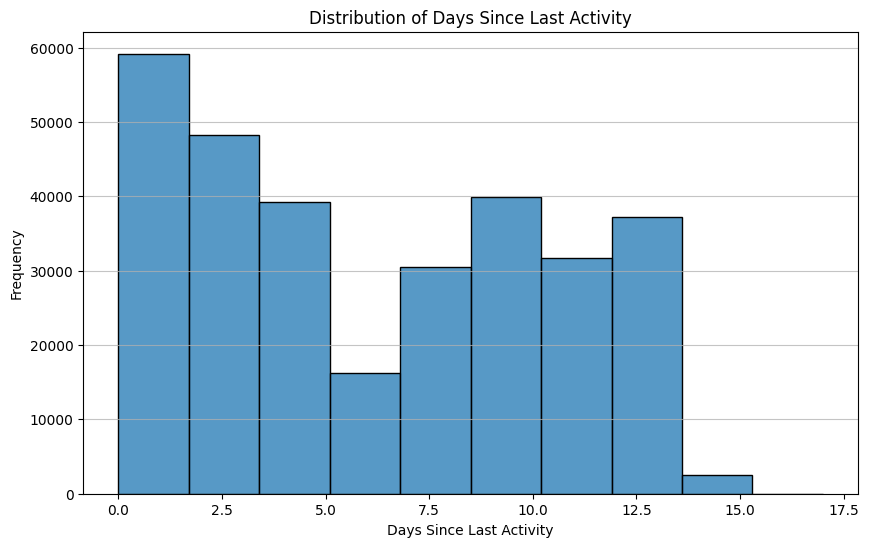

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of days_difference
plt.figure(figsize=(10, 6))
sns.histplot(df['days_difference'], bins=10)
plt.title('Distribution of Days Since Last Activity')
plt.xlabel('Days Since Last Activity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

이탈은 7일 정도로 잡는 것이 적당해 보임

# 분석 내용 모으기

## 가입 후 활동량 변화 확인하기

유저가 가입 하면 활동량이 점차 줄어드는 것일텐데 언제부터 크게 주는지 확인

총 활동량(가입 후 0~31일): 1,187,181건
0~1일(24h) 활동량: 210,684건 (17.75%)


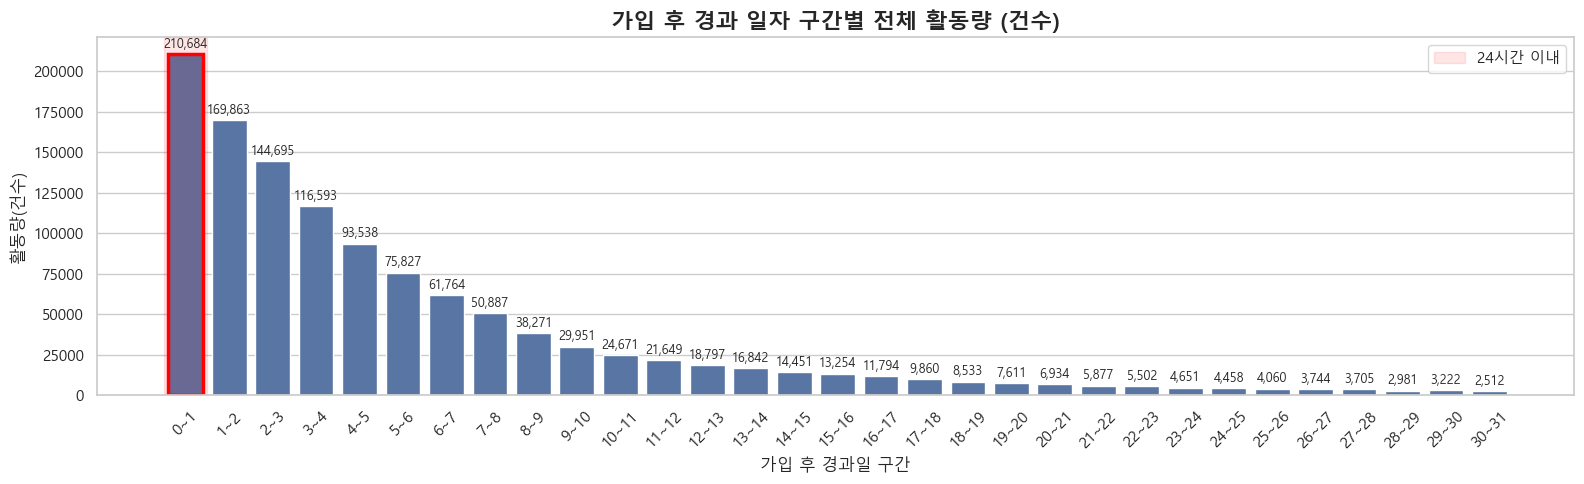

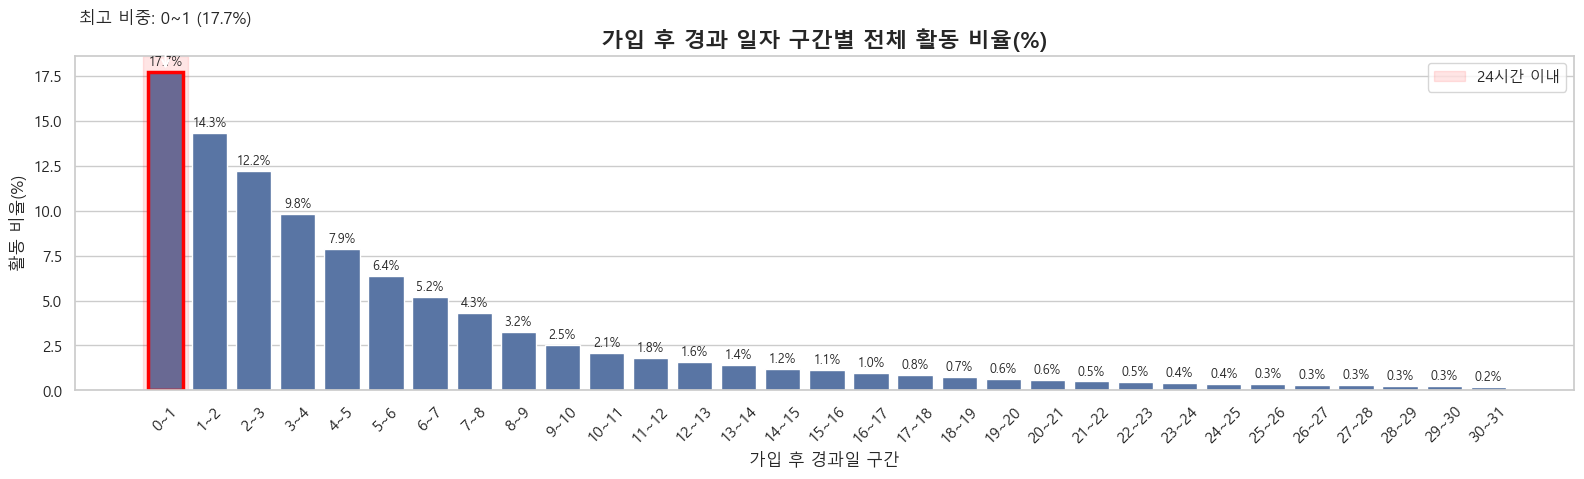

In [ ]:

user_df['created_at'] = pd.to_datetime(user_df['created_at'], errors='coerce', utc=True)
uqr_df['created_at']  = pd.to_datetime(uqr_df['created_at'],  errors='coerce', utc=True)

# 병합 
df = uqr_df.merge(user_df, left_on='user_id', right_on='id',
                  suffixes=('_activity', '_signup'), how='inner')

# 가입 후 경과 "시간"을 일 단위 float로 계산
#    ※ .dt.days(정수) 말고 float 일수를 사용해야 "24시간 이내" 정확히 잡힘!
delta_days = (df['created_at_activity'] - df['created_at_signup']) / np.timedelta64(1, 'D')
df['days_since_signup_float'] = delta_days

# 데이터 정리
#    - 음수(가입 이전 시간 역전), NaN 제거
#    - 분석 구간: 가입 후 0~31일 (즉, bin은 [0,1), [1,2), ..., [30,31))
df = df.dropna(subset=['days_since_signup_float'])
df = df[df['days_since_signup_float'] >= 0]

# 구간(bin) 정의: 0~31일(31개 간격 → 31개 구간)
bin_edges = np.arange(0, 32, 1)  # 0,1,2,...,31
labels = [f"{i}~{i+1}" for i in range(0, 31)]
df['signup_day_bin'] = pd.cut(
    df['days_since_signup_float'],
    bins=bin_edges,
    right=False,       # [0,1), [1,2) ...
    labels=labels,
    include_lowest=True
)

# 활동량 집계(건수) & 비율(%)  — "전체 활동량" 기준
count_series = df['signup_day_bin'].value_counts().sort_index()  # 카테고리 순서대로
count_series = count_series.reindex(labels, fill_value=0)        # 빈 구간 0으로 채우기
total_acts = count_series.sum()
ratio_series = (count_series / total_acts).replace([np.inf, np.nan], 0.0)

print(f"총 활동량(가입 후 0~31일): {int(total_acts):,}건")
print(f"0~1일(24h) 활동량: {int(count_series.iloc[0]):,}건 ({ratio_series.iloc[0]*100:.2f}%)")

# 시각화 ①: 활동량(건수)
plt.figure(figsize=(16, 5))
ax1 = sns.barplot(x=count_series.index, y=count_series.values)
ax1.set_title("가입 후 경과 일자 구간별 전체 활동량 (건수)", fontsize=16, weight='bold')
ax1.set_xlabel("가입 후 경과일 구간")
ax1.set_ylabel("활동량(건수)")
plt.xticks(rotation=45)

# 0~1일 구간 강조 (막대 테두리 & 배경 하이라이트)
ax1.patches[0].set_edgecolor('red')
ax1.patches[0].set_linewidth(2.5)
# 살짝 배경 밴드
ymax = count_series.max()
ax1.axvspan(-0.5, 0.5, color='red', alpha=0.10, label='24시간 이내')

# 막대 위 숫자 라벨
for p, v in zip(ax1.patches, count_series.values):
    ax1.text(p.get_x() + p.get_width()/2, p.get_height() + ymax*0.01,
             f"{int(v):,}", ha="center", va="bottom", fontsize=9)
ax1.legend(loc='upper right')
plt.tight_layout()
plt.savefig("activity_count_by_bin.png", dpi=160)
plt.show()

# 시각화 ②: 비율(%)
plt.figure(figsize=(16, 5))
ax2 = sns.barplot(x=ratio_series.index, y=(ratio_series.values * 100.0))
ax2.set_title("가입 후 경과 일자 구간별 전체 활동 비율(%)", fontsize=16, weight='bold')
ax2.set_xlabel("가입 후 경과일 구간")
ax2.set_ylabel("활동 비율(%)")
plt.xticks(rotation=45)

# 0~1일 구간 강조 (막대 테두리 & 배경 하이라이트)
ax2.patches[0].set_edgecolor('red')
ax2.patches[0].set_linewidth(2.5)
ax2.axvspan(-0.5, 0.5, color='red', alpha=0.10, label='24시간 이내')

# 막대 위 퍼센트 라벨
rmax = (ratio_series * 100).max()
for p, v in zip(ax2.patches, ratio_series.values * 100.0):
    ax2.text(p.get_x() + p.get_width()/2, p.get_height() + rmax*0.01,
             f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

top_idx = int(np.argmax(ratio_series.values))
ax2.annotate(
    f"최고 비중: {labels[top_idx]} ({ratio_series.iloc[top_idx]*100:.1f}%)",
    xy=(top_idx, ratio_series.values[top_idx]*100),
    xytext=(top_idx, ratio_series.values[top_idx]*100 + rmax*0.15),
    arrowprops=dict(arrowstyle='->', lw=1.5),
    ha='center'
)

ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig("activity_ratio_by_bin.png", dpi=160)
plt.show()


## 친구 네트워크 분석

반에 중심 학생들이 다른 일반 학생들에게 영향을 주는지 확인

In [ ]:
# 중심 학생의 이탈 정보 분석
print('\n=== [HYPOTHESIS 1] 중심학생 이탈 → 일반 학생 이탈 영향 분석 ===')

# 중심 학생 데이터에서 user_id와 group_id 추출
central_users_with_groups = central_users_df[['id', 'group_id']].rename(columns={'id': 'user_id'})

# 중심 학생의 마지막 활동 시간 및 이탈 여부
central_churn_info = central_users_with_groups.merge(user_last_activity, on='user_id', how='left')
central_churn_info = central_churn_info.dropna(subset=['is_inactive'])
central_churned_only = central_churn_info[central_churn_info['is_inactive'] == True].copy()

print(f'[CENTRAL] 전체 중심 학생: {len(central_users_with_groups):,}명')
print(f'[CHURNED] 이탈한 중심 학생: {len(central_churned_only):,}명 ({len(central_churned_only)/len(central_users_with_groups)*100:.1f}%)')

if not central_churned_only.empty:
    # 이탈한 중심 학생들의 이탈 시점 (마지막 활동 시간)
    central_churned_only['churn_date'] = central_churned_only['last_activity_time']
    
    # 모든 사용자에게 그룹 정보 추가
    all_users_with_groups = users_df[['id', 'group_id']].rename(columns={'id': 'user_id'})
    all_users_activity = all_users_with_groups.merge(user_last_activity, on='user_id', how='left')
    
    # 중심 학생 이탈 전후 비교를 위한 데이터 수집
    before_churn_data = []  # 중심 학생 이탈 전 같은 반 학생 이탈
    after_churn_data = []   # 중심 학생 이탈 후 같은 반 학생 이탈
    
    print('\n[ANALYSIS] 중심 학생 이탈 전후 같은 반 학생 이탈 패턴 분석 중...')
    
    for index, central_row in central_churned_only.iterrows():
        central_user_id = central_row['user_id']
        central_group_id = central_row['group_id']
        central_churn_date = central_row['churn_date']
        
        # 같은 반 학생들 (중심 학생 제외)
        classmates = all_users_activity[
            (all_users_activity['group_id'] == central_group_id) &
            (all_users_activity['user_id'] != central_user_id) &
            (all_users_activity['is_inactive'] == True)
        ].copy()
        
        if not classmates.empty:
            # 중심 학생 이탈 이전에 이탈한 같은 반 학생들
            classmates_churned_before = classmates[
                classmates['last_activity_time'] < central_churn_date
            ].copy()
            
            # 중심 학생 이탈 이후에 이탈한 같은 반 학생들
            classmates_churned_after = classmates[
                classmates['last_activity_time'] > central_churn_date
            ].copy()
            
            if not classmates_churned_before.empty:
                classmates_churned_before['central_user_id'] = central_user_id
                classmates_churned_before['central_churn_date'] = central_churn_date
                classmates_churned_before['days_diff_from_central'] = (
                    central_churn_date - classmates_churned_before['last_activity_time']
                ).dt.days
                classmates_churned_before['churn_timing'] = 'before'
                before_churn_data.append(classmates_churned_before)
            
            if not classmates_churned_after.empty:
                classmates_churned_after['central_user_id'] = central_user_id
                classmates_churned_after['central_churn_date'] = central_churn_date
                classmates_churned_after['days_diff_from_central'] = (
                    classmates_churned_after['last_activity_time'] - central_churn_date
                ).dt.days
                classmates_churned_after['churn_timing'] = 'after'
                after_churn_data.append(classmates_churned_after)
    
    print(f'[OK] 분석 완료: {len(central_churned_only):,}명의 중심 학생 이탈 사례 검토')
    
    if before_churn_data:
        before_churn_df = pd.concat(before_churn_data, ignore_index=True)
        print(f'[RESULT] 중심 학생 이탈 전 같은 반 학생 이탈: {len(before_churn_df):,}명')
    else:
        before_churn_df = pd.DataFrame()
        print(f'[RESULT] 중심 학생 이탈 전 같은 반 학생 이탈: 0명')
    
    if after_churn_data:
        after_churn_df = pd.concat(after_churn_data, ignore_index=True)
        print(f'[RESULT] 중심 학생 이탈 후 같은 반 학생 이탈: {len(after_churn_df):,}명')
    else:
        after_churn_df = pd.DataFrame()
        print(f'[RESULT] 중심 학생 이탈 후 같은 반 학생 이탈: 0명')
else:
    print('[WARNING] 이탈한 중심 학생이 없어 분석을 진행할 수 없습니다.')
    before_churn_df = pd.DataFrame()
    after_churn_df = pd.DataFrame()



=== [HYPOTHESIS 1] 중심학생 이탈 → 일반 학생 이탈 영향 분석 ===
[CENTRAL] 전체 중심 학생: 68,945명
[CHURNED] 이탈한 중심 학생: 395명 (0.6%)

[ANALYSIS] 중심 학생 이탈 전후 같은 반 학생 이탈 패턴 분석 중...
[OK] 분석 완료: 395명의 중심 학생 이탈 사례 검토
[RESULT] 중심 학생 이탈 전 같은 반 학생 이탈: 3,676명
[RESULT] 중심 학생 이탈 후 같은 반 학생 이탈: 2,292명


In [ ]:
# 통계적 검증 및 시각화
print('\n=== [STATISTICAL ANALYSIS] 통계적 검증 및 시각화 ===')

if not before_churn_df.empty or not after_churn_df.empty:
    # 1. 통계적 검증
    print('\n1️⃣ 통계적 검증 결과:')
    
    if not before_churn_df.empty and not after_churn_df.empty:
        # t-test로 전후 비교
        before_days = before_churn_df['days_diff_from_central'].values
        after_days = after_churn_df['days_diff_from_central'].values
        
        t_stat, p_value = stats.ttest_ind(before_days, after_days)
        
        print(f'   📊 t-test 결과:')
        print(f'      • t-통계량: {t_stat:.4f}')
        print(f'      • p-값: {p_value:.6f}')
        print(f'      • 유의수준 0.05 기준: {"유의함" if p_value < 0.05 else "유의하지 않음"}')
        
        # Mann-Whitney U test (비모수 검정)
        u_stat, u_p_value = stats.mannwhitneyu(before_days, after_days, alternative='two-sided')
        print(f'   📊 Mann-Whitney U test 결과:')
        print(f'      • U-통계량: {u_stat:.4f}')
        print(f'      • p-값: {u_p_value:.6f}')
        print(f'      • 유의수준 0.05 기준: {"유의함" if u_p_value < 0.05 else "유의하지 않음"}')
        
        # 상관계수 계산 (전후 데이터 연결)
        combined_data = pd.concat([
            before_churn_df[['days_diff_from_central']].assign(timing='before'),
            after_churn_df[['days_diff_from_central']].assign(timing='after')
        ], ignore_index=True)
        
        # timing을 숫자로 변환 (before=0, after=1)
        combined_data['timing_numeric'] = (combined_data['timing'] == 'after').astype(int)
        
        # Pearson 상관계수
        pearson_corr, pearson_p = pearsonr(combined_data['timing_numeric'], combined_data['days_diff_from_central'])
        print(f'   📊 Pearson 상관계수:')
        print(f'      • 상관계수: {pearson_corr:.4f}')
        print(f'      • p-값: {pearson_p:.6f}')
        
        # Spearman 상관계수
        spearman_corr, spearman_p = spearmanr(combined_data['timing_numeric'], combined_data['days_diff_from_central'])
        print(f'   📊 Spearman 상관계수:')
        print(f'      • 상관계수: {spearman_corr:.4f}')
        print(f'      • p-값: {spearman_p:.6f}')
        
        print('\n✅ 통계적 검증 완료!')



=== [STATISTICAL ANALYSIS] 통계적 검증 및 시각화 ===

1️⃣ 통계적 검증 결과:
   📊 t-test 결과:
      • t-통계량: 5.9508
      • p-값: 0.000000
      • 유의수준 0.05 기준: 유의함
   📊 Mann-Whitney U test 결과:
      • U-통계량: 4711402.5000
      • p-값: 0.000000
      • 유의수준 0.05 기준: 유의함
   📊 Pearson 상관계수:
      • 상관계수: -0.0768
      • p-값: 0.000000
   📊 Spearman 상관계수:
      • 상관계수: -0.0997
      • p-값: 0.000000

✅ 통계적 검증 완료!


In [ ]:
# 2. 유의미한 이탈 시점 분석
print('\n2️⃣ 유의미한 이탈 시점 분석:')

if not after_churn_df.empty:
    after_stats = after_churn_df['days_diff_from_central'].describe()
    print(f'   📊 중심 학생 이탈 후 통계:')
    print(f'      • 평균: {after_stats["mean"]:.1f}일')
    print(f'      • 중간값: {after_stats["50%"]:.1f}일')
    print(f'      • 표준편차: {after_stats["std"]:.1f}일')
    
    # 단기간 내 이탈 비율 분석
    print(f'   🔍 중심 학생 이탈 후 단기간 내 이탈 패턴:')
    
    timing_analysis = []
    
    for days in [1, 3, 7, 14, 30, 60]:
        quick_churn = after_churn_df[after_churn_df['days_diff_from_central'] <= days]
        percentage = len(quick_churn) / len(after_churn_df) * 100
        
        if len(quick_churn) > 0:
            expected_ratio = days / 365
            observed_ratio = len(quick_churn) / len(after_churn_df)
            
            chi2_stat, chi2_p = stats.chisquare(
                [len(quick_churn), len(after_churn_df) - len(quick_churn)],
                [len(after_churn_df) * expected_ratio, len(after_churn_df) * (1 - expected_ratio)]
            )
            
            timing_analysis.append({
                'days': days,
                'count': len(quick_churn),
                'percentage': percentage,
                'chi2_stat': chi2_stat,
                'chi2_p': chi2_p,
                'significant': chi2_p < 0.05
            })
            
            significance = "🟢 유의함" if chi2_p < 0.05 else "🔴 유의하지 않음"
            print(f'      • {days}일 이내 이탈: {len(quick_churn):,}명 ({percentage:.1f}%) - {significance} (p={chi2_p:.4f})')
        else:
            timing_analysis.append({
                'days': days,
                'count': 0,
                'percentage': 0,
                'chi2_stat': 0,
                'chi2_p': 1.0,
                'significant': False
            })
            print(f'      • {days}일 이내 이탈: 0명 (0.0%)')
    
    timing_df = pd.DataFrame(timing_analysis)
    print('\n✅ 유의미한 이탈 시점 분석 완료!')



2️⃣ 유의미한 이탈 시점 분석:
   📊 중심 학생 이탈 후 통계:
      • 평균: 55.8일
      • 중간값: 41.0일
      • 표준편차: 58.4일
   🔍 중심 학생 이탈 후 단기간 내 이탈 패턴:
      • 1일 이내 이탈: 230명 (10.0%) - 🟢 유의함 (p=0.0000)
      • 3일 이내 이탈: 343명 (15.0%) - 🟢 유의함 (p=0.0000)
      • 7일 이내 이탈: 517명 (22.6%) - 🟢 유의함 (p=0.0000)
      • 14일 이내 이탈: 692명 (30.2%) - 🟢 유의함 (p=0.0000)
      • 30일 이내 이탈: 1,001명 (43.7%) - 🟢 유의함 (p=0.0000)
      • 60일 이내 이탈: 1,498명 (65.4%) - 🟢 유의함 (p=0.0000)

✅ 유의미한 이탈 시점 분석 완료!



3️⃣ 시각화 생성 중...


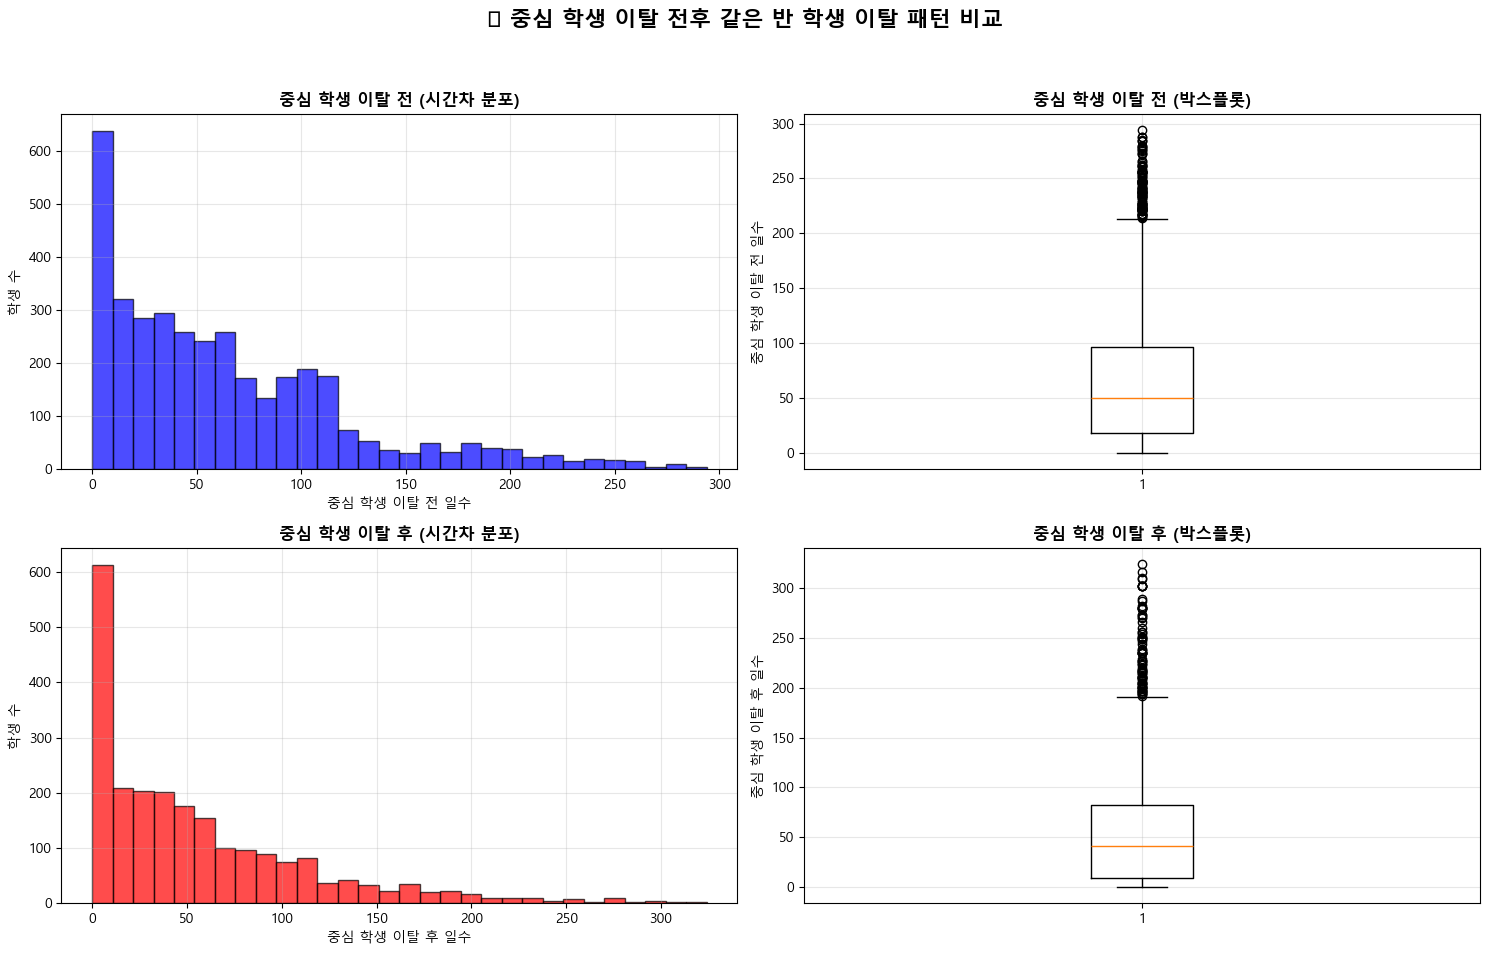

✅ 시각화 완료!


In [ ]:
# 3. 시각화
print('\n3️⃣ 시각화 생성 중...')

if not before_churn_df.empty or not after_churn_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🎯 중심 학생 이탈 전후 같은 반 학생 이탈 패턴 비교', fontsize=16, fontweight='bold')
    
    # 첫 번째 행: 이탈 전
    if not before_churn_df.empty:
        axes[0, 0].hist(before_churn_df['days_diff_from_central'], bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 0].set_title('중심 학생 이탈 전 (시간차 분포)', fontweight='bold')
        axes[0, 0].set_xlabel('중심 학생 이탈 전 일수')
        axes[0, 0].set_ylabel('학생 수')
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].boxplot(before_churn_df['days_diff_from_central'], vert=True)
        axes[0, 1].set_title('중심 학생 이탈 전 (박스플롯)', fontweight='bold')
        axes[0, 1].set_ylabel('중심 학생 이탈 전 일수')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        for i in range(2):
            axes[0, i].text(0.5, 0.5, '이탈 전 데이터 없음', ha='center', va='center',
                            transform=axes[0, i].transAxes, fontsize=14)
            axes[0, i].set_title(f'중심 학생 이탈 전 분석 {i+1}', fontweight='bold')
    
    # 두 번째 행: 이탈 후
    if not after_churn_df.empty:
        axes[1, 0].hist(after_churn_df['days_diff_from_central'], bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1, 0].set_title('중심 학생 이탈 후 (시간차 분포)', fontweight='bold')
        axes[1, 0].set_xlabel('중심 학생 이탈 후 일수')
        axes[1, 0].set_ylabel('학생 수')
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].boxplot(after_churn_df['days_diff_from_central'], vert=True)
        axes[1, 1].set_title('중심 학생 이탈 후 (박스플롯)', fontweight='bold')
        axes[1, 1].set_ylabel('중심 학생 이탈 후 일수')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        for i in range(2):
            axes[1, i].text(0.5, 0.5, '이탈 후 데이터 없음', ha='center', va='center',
                            transform=axes[1, i].transAxes, fontsize=14)
            axes[1, i].set_title(f'중심 학생 이탈 후 분석 {i+1}', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print('✅ 시각화 완료!')


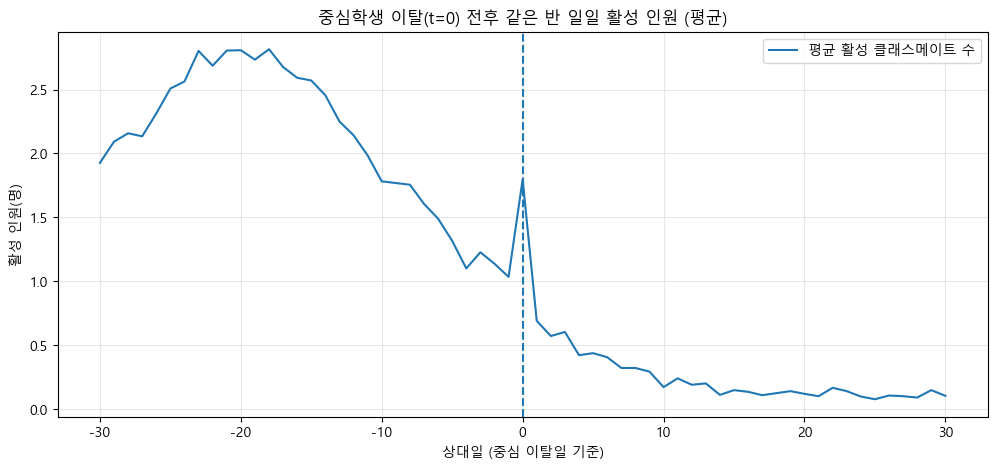

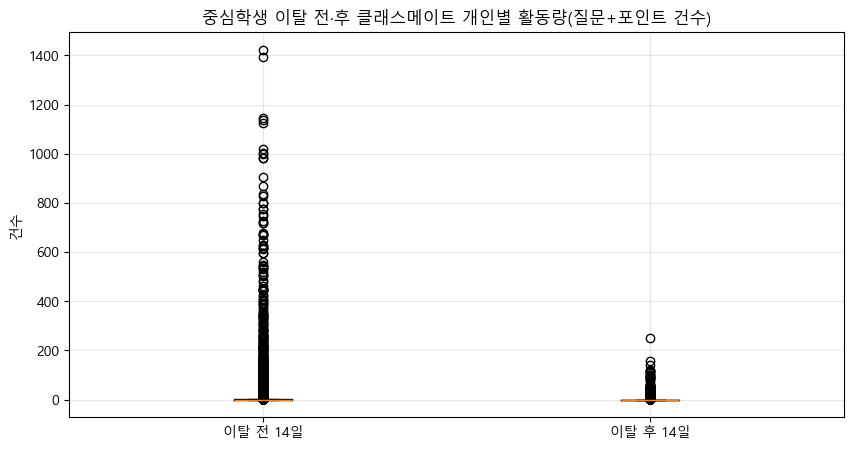

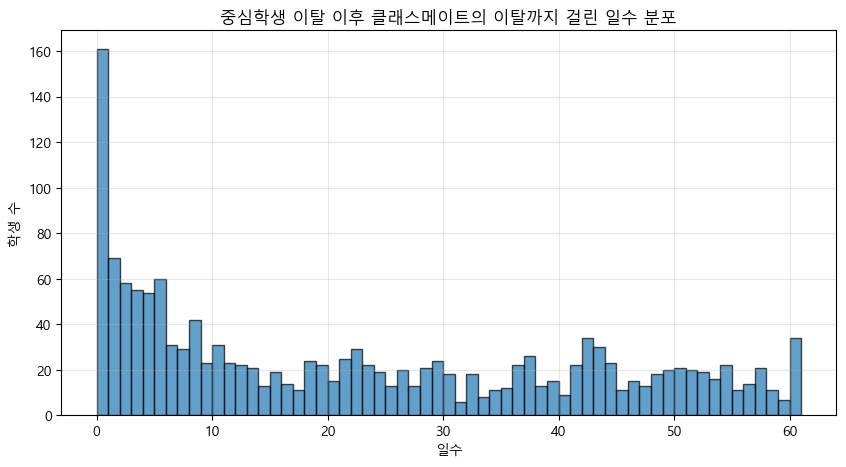

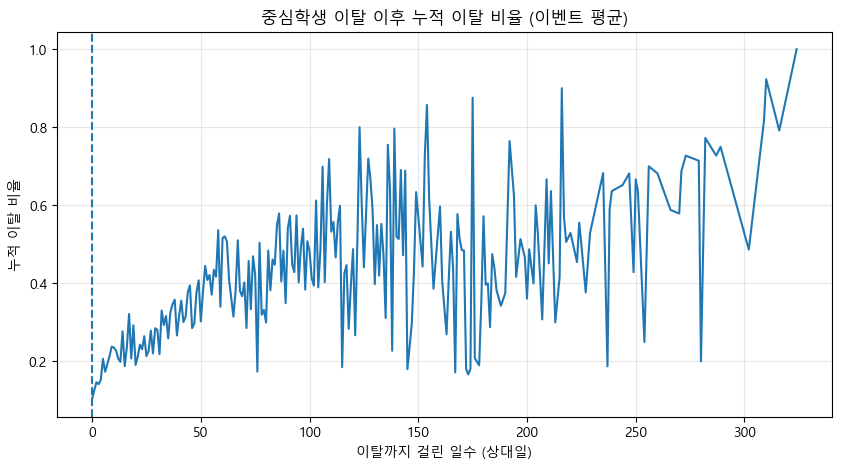

In [ ]:
# ============================================
# 중심학생 이탈 전·후 같은 반 변화 시각화 (이벤트 스터디)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) 파라미터
# ----------------------------
WINDOW_DAYS = 30          # 이벤트 전후 일 수
PRE_WIN = 14              # 전/후 활동량 비교 윈도우(일)
POST_WIN = 14

# ----------------------------
# 1) 활동 로그(질문 + 포인트) -> 일 단위로 합치기
# ----------------------------
def _prep_daily_activity(user_questions_df, point_history_df):
    # 필요한 컬럼만
    q = user_questions_df[['user_id', 'created_at']].copy()
    p = point_history_df[['user_id', 'created_at']].copy()

    # 날짜화
    q['date'] = pd.to_datetime(q['created_at']).dt.normalize()
    p['date'] = pd.to_datetime(p['created_at']).dt.normalize()

    q['src'] = 'question'
    p['src'] = 'point'
    logs = pd.concat([q[['user_id','date','src']], p[['user_id','date','src']]], ignore_index=True)

    # 같은 user_id-날짜에 이벤트가 여러 번 있어도 "활성 1일"로 취급
    daily_active = (
        logs
        .drop_duplicates(subset=['user_id','date'])
        .assign(active=1)
    )
    return daily_active

daily_active = _prep_daily_activity(user_questions_df, point_history_df)

# ----------------------------
# 2) 이벤트(중심학생 이탈)별로 같은 반 classmates의 일별 활성 수 계산
#    - 중심학생 제외
#    - 이벤트 기준 상대일(relative_day = date - churn_date)
# ----------------------------
events = central_churned_only[['user_id','group_id','churn_date']].copy()
events['churn_date'] = pd.to_datetime(events['churn_date']).dt.normalize()

# 전체 사용자와 그룹 맵
user_group = users_df[['id','group_id']].rename(columns={'id':'user_id'}).dropna(subset=['group_id'])

# 결과 담을 리스트
event_dailies = []

for _, ev in events.iterrows():
    gid = ev['group_id']
    central_id = ev['user_id']
    t0 = ev['churn_date']

    # 같은 반(중심 제외) 학생들
    classmates = user_group[
        (user_group['group_id'] == gid) &
        (user_group['user_id'] != central_id)
    ]['user_id'].unique()

    if len(classmates) == 0:
        continue

    # 윈도우 범위
    start = t0 - pd.Timedelta(days=WINDOW_DAYS)
    end   = t0 + pd.Timedelta(days=WINDOW_DAYS)

    # 해당 클래스메이트들의 해당 기간 일일 활성
    sub = daily_active[
        (daily_active['user_id'].isin(classmates)) &
        (daily_active['date'] >= start) &
        (daily_active['date'] <= end)
    ].copy()

    if sub.empty:
        continue

    # 상대일 계산
    sub['relative_day'] = (sub['date'] - t0).dt.days

    # 같은 날 활성한 classmates 수(유니크 user_id 수)
    daily_counts = (
        sub.groupby('relative_day')['user_id']
           .nunique()
           .reset_index(name='active_classmates')
           .assign(event_central_id=central_id, group_id=gid)
    )
    event_dailies.append(daily_counts)

# 이벤트별 daily active 합치고, 전체 평균(또는 중앙값) 계산
if event_dailies:
    event_dailies_df = pd.concat(event_dailies, ignore_index=True)

    # 모든 상대일을 -WINDOW_DAYS ~ +WINDOW_DAYS 로 채워넣기 (결측=0)
    idx = pd.DataFrame({'relative_day': np.arange(-WINDOW_DAYS, WINDOW_DAYS+1)})
    # event마다 merge하여 빈 날 0으로
    filled_list = []
    for eid, g in event_dailies_df.groupby('event_central_id'):
        g = idx.merge(g, on='relative_day', how='left')
        g['active_classmates'] = g['active_classmates'].fillna(0)
        g['event_central_id'] = eid
        filled_list.append(g)
    event_dailies_df = pd.concat(filled_list, ignore_index=True)

    # 평균/중앙값 시리즈
    mean_curve = (event_dailies_df
                  .groupby('relative_day')['active_classmates']
                  .mean().reset_index(name='mean_active'))
    median_curve = (event_dailies_df
                    .groupby('relative_day')['active_classmates']
                    .median().reset_index(name='median_active'))
else:
    # 이벤트가 없으면 빈 프레임
    mean_curve = pd.DataFrame({'relative_day': [], 'mean_active': []})
    median_curve = pd.DataFrame({'relative_day': [], 'median_active': []})

# ----------------------------
# 3) 전/후 활동량 비교 (PRE_WIN, POST_WIN)
#    - 같은 반 classmates의 질문/포인트 "건수" 기준 비교 (개인 합 -> 이벤트별 분포)
# ----------------------------
pre_post_rows = []

for _, ev in events.iterrows():
    gid = ev['group_id']; central_id = ev['user_id']; t0 = pd.to_datetime(ev['churn_date']).normalize()
    classmates = user_group[
        (user_group['group_id'] == gid) &
        (user_group['user_id'] != central_id)
    ]['user_id'].unique()
    if len(classmates) == 0:
        continue

    pre_start = t0 - pd.Timedelta(days=PRE_WIN)
    pre_end   = t0 - pd.Timedelta(days=1)   # 전 구간은 t0-1일까지
    post_start= t0 + pd.Timedelta(days=0)   # 후 구간은 t0부터
    post_end  = t0 + pd.Timedelta(days=POST_WIN)

    # 질문/포인트 각각 카운트 후 합산
    def _count_range(df, s, e):
        tmp = df[(df['user_id'].isin(classmates)) &
                 (pd.to_datetime(df['created_at']).between(s, e))]
        return tmp.groupby('user_id').size().rename('cnt')

    pre_q = _count_range(user_questions_df, pre_start, pre_end)
    pre_p = _count_range(point_history_df, pre_start, pre_end)
    post_q= _count_range(user_questions_df, post_start, post_end)
    post_p= _count_range(point_history_df, post_start, post_end)

    pre = pd.concat([pre_q, pre_p], axis=1).fillna(0).sum(axis=1).reset_index()
    pre.columns = ['user_id','pre_cnt']
    post = pd.concat([post_q, post_p], axis=1).fillna(0).sum(axis=1).reset_index()
    post.columns = ['user_id','post_cnt']

    pp = pd.merge(pd.DataFrame({'user_id': classmates}), pre, on='user_id', how='left') \
            .merge(post, on='user_id', how='left').fillna(0)
    pp['event_central_id'] = central_id
    pp['group_id'] = gid
    pre_post_rows.append(pp)

pre_post_df = pd.concat(pre_post_rows, ignore_index=True) if pre_post_rows else pd.DataFrame(columns=['user_id','pre_cnt','post_cnt','event_central_id','group_id'])

# ----------------------------
# 4) 이탈까지 걸린 일수 분포 (after_churn_df 사용)
#    - 중심학생 이탈 이후(churn_date 이후) 같은 반 학생의 days_diff_from_central 히스토그램
# ----------------------------
# 이미 earlier 코드에서 만든 after_churn_df 이용 (없으면 안전 처리)
if 'after_churn_df' in globals() and not after_churn_df.empty:
    ttc = after_churn_df['days_diff_from_central'].dropna().astype(int)  # time-to-churn
else:
    ttc = pd.Series(dtype=int)

# ----------------------------
# 5) (옵션) 누적 이탈 비율: after_churn_df 기반
# ----------------------------
if 'after_churn_df' in globals() and not after_churn_df.empty:
    # 이벤트별로 같은 반 학생 수 대비 누적 이탈 비율을 상대일 기준으로 근사
    # after_churn_df에는 churn_date 이후 이탈자만 있으므로, 상대일 = days_diff_from_central
    temp = after_churn_df[['central_user_id','group_id','days_diff_from_central']].copy()
    # 각 이벤트의 클래스메이트母수
    group_sizes = (user_group
                   .merge(events[['user_id','group_id']].rename(columns={'user_id':'central_user_id'}), on='group_id', how='inner'))
    group_sizes = group_sizes[group_sizes['user_id'] != group_sizes['central_user_id']]
    sizes = group_sizes.groupby(['central_user_id','group_id'])['user_id'].nunique().rename('classmate_size').reset_index()

    temp = temp.merge(sizes, on=['central_user_id','group_id'], how='left')
    # 상대일별 누적 비율
    cum_curve = (temp.groupby(['central_user_id','days_diff_from_central'])
                      .size().groupby(level=0).cumsum().reset_index(name='cum_churners'))
    cum_curve = cum_curve.merge(sizes, on='central_user_id', how='left')
    cum_curve['cum_rate'] = cum_curve['cum_churners'] / cum_curve['classmate_size']

    # 이벤트 평균 누적 이탈 비율
    cum_rate_mean = (cum_curve.groupby('days_diff_from_central')['cum_rate']
                              .mean().reset_index())
else:
    cum_rate_mean = pd.DataFrame({'days_diff_from_central': [], 'cum_rate': []})

# ----------------------------
# 6) Plotting
# ----------------------------
plt.figure(figsize=(12,5))
if not mean_curve.empty:
    plt.plot(mean_curve['relative_day'], mean_curve['mean_active'], label='평균 활성 클래스메이트 수')
    # 중앙값도 함께 보고 싶으면 주석 해제
    # plt.plot(median_curve['relative_day'], median_curve['median_active'], label='중앙값', linestyle='--')
    plt.axvline(0, linestyle='--')
    plt.title('중심학생 이탈(t=0) 전후 같은 반 일일 활성 인원 (평균)')
    plt.xlabel('상대일 (중심 이탈일 기준)')
    plt.ylabel('활성 인원(명)')
    plt.grid(True, alpha=0.3)
    plt.legend()
else:
    plt.text(0.5, 0.5, '이벤트 데이터가 부족합니다', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

# 전/후 활동량 분포 박스플롯
if not pre_post_df.empty:
    plt.figure(figsize=(10,5))
    data_to_box = [pre_post_df['pre_cnt'].values, pre_post_df['post_cnt'].values]
    plt.boxplot(data_to_box, labels=[f'이탈 전 {PRE_WIN}일', f'이탈 후 {POST_WIN}일'])
    plt.title('중심학생 이탈 전·후 클래스메이트 개인별 활동량(질문+포인트 건수)')
    plt.ylabel('건수')
    plt.grid(True, alpha=0.3)
    plt.show()

# 이탈까지 걸린 일수 히스토그램
plt.figure(figsize=(10,5))
if len(ttc) > 0:
    bins = np.arange(0, min(ttc.max(), WINDOW_DAYS*2)+2)  # 적당한 구간
    plt.hist(ttc, bins=bins, edgecolor='black', alpha=0.7)
    plt.title('중심학생 이탈 이후 클래스메이트의 이탈까지 걸린 일수 분포')
    plt.xlabel('일수')
    plt.ylabel('학생 수')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'after_churn_df가 비어 있어 분포를 그릴 수 없습니다', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

# 누적 이탈 비율 평균
plt.figure(figsize=(10,5))
if not cum_rate_mean.empty:
    x = cum_rate_mean['days_diff_from_central']
    y = cum_rate_mean['cum_rate']
    plt.plot(x, y)
    plt.axvline(0, linestyle='--')
    plt.title('중심학생 이탈 이후 누적 이탈 비율 (이벤트 평균)')
    plt.xlabel('이탈까지 걸린 일수 (상대일)')
    plt.ylabel('누적 이탈 비율')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, '누적 이탈 비율을 계산할 데이터가 부족합니다', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


## DAU 확인

이 서비스의 DAU를 확인함

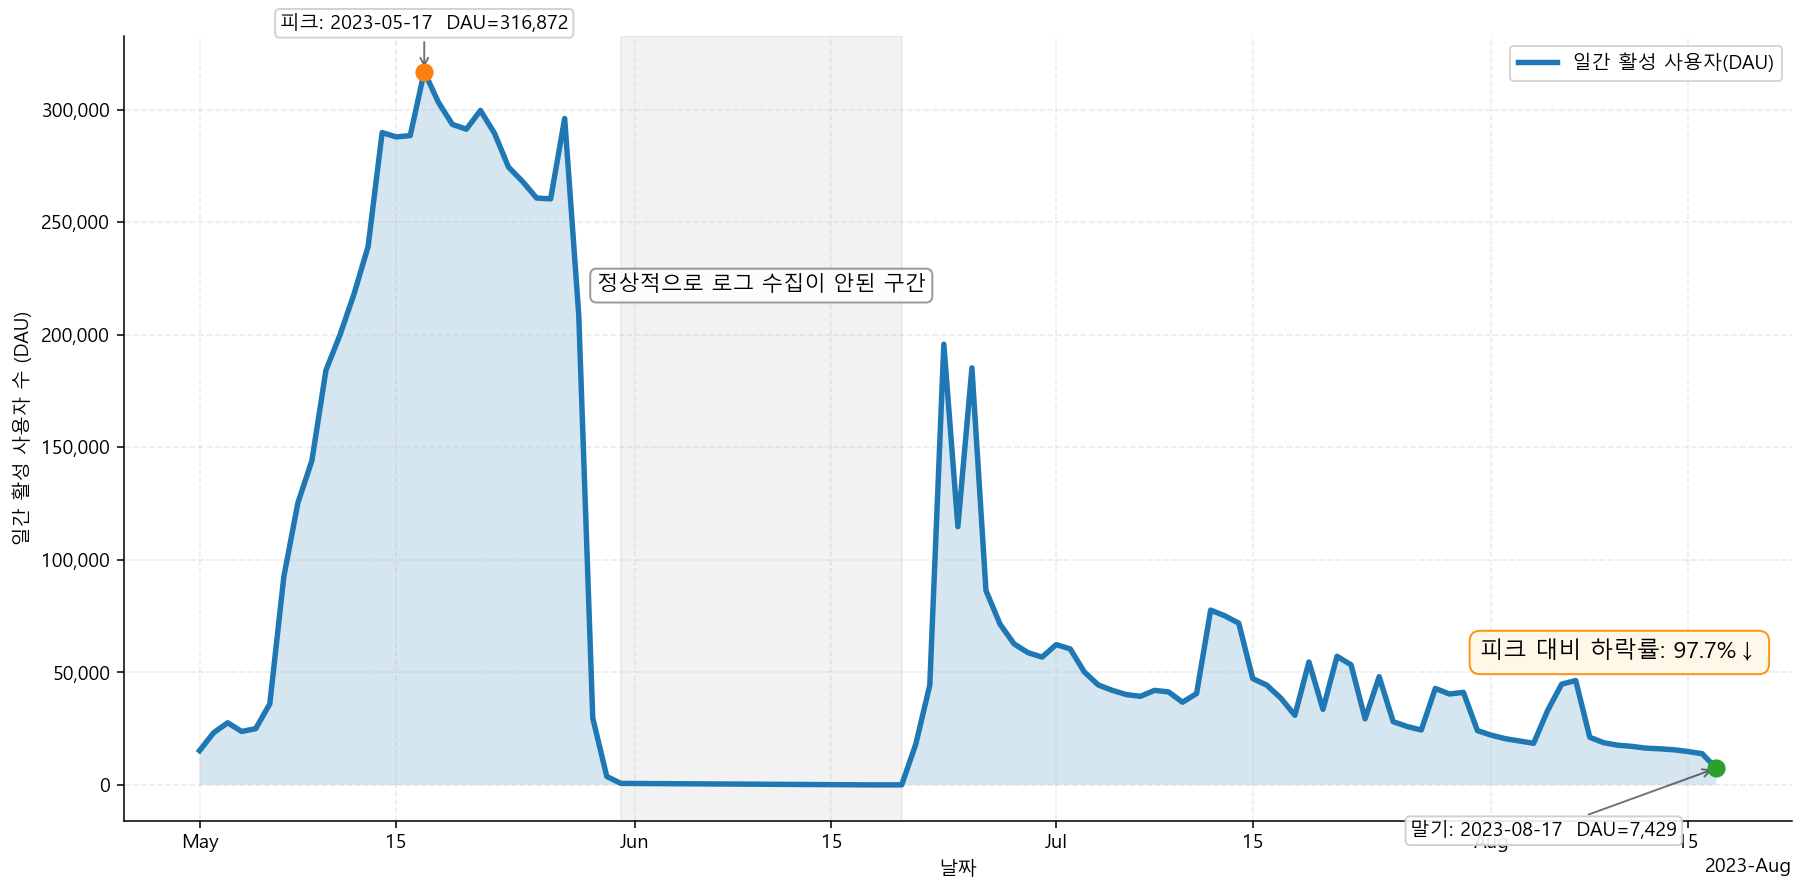

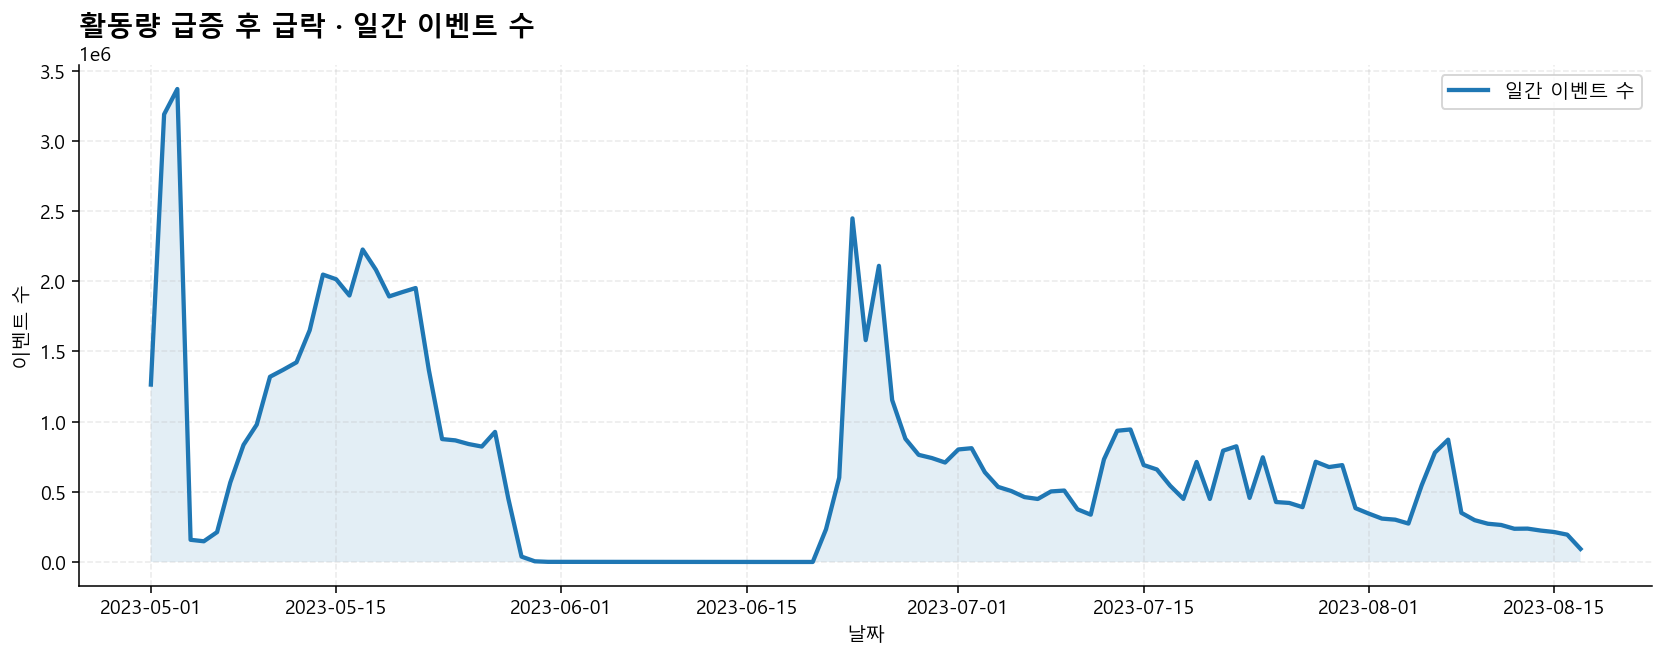

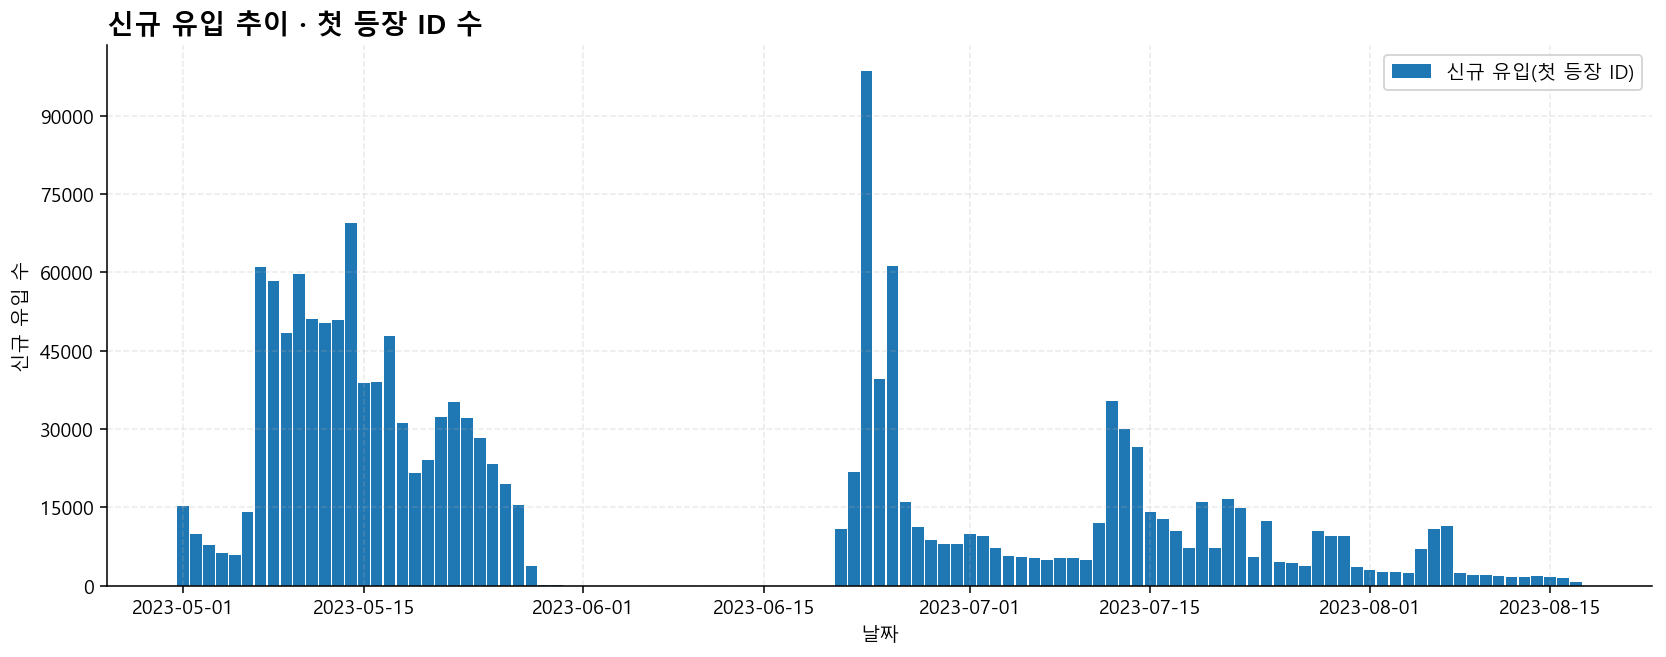

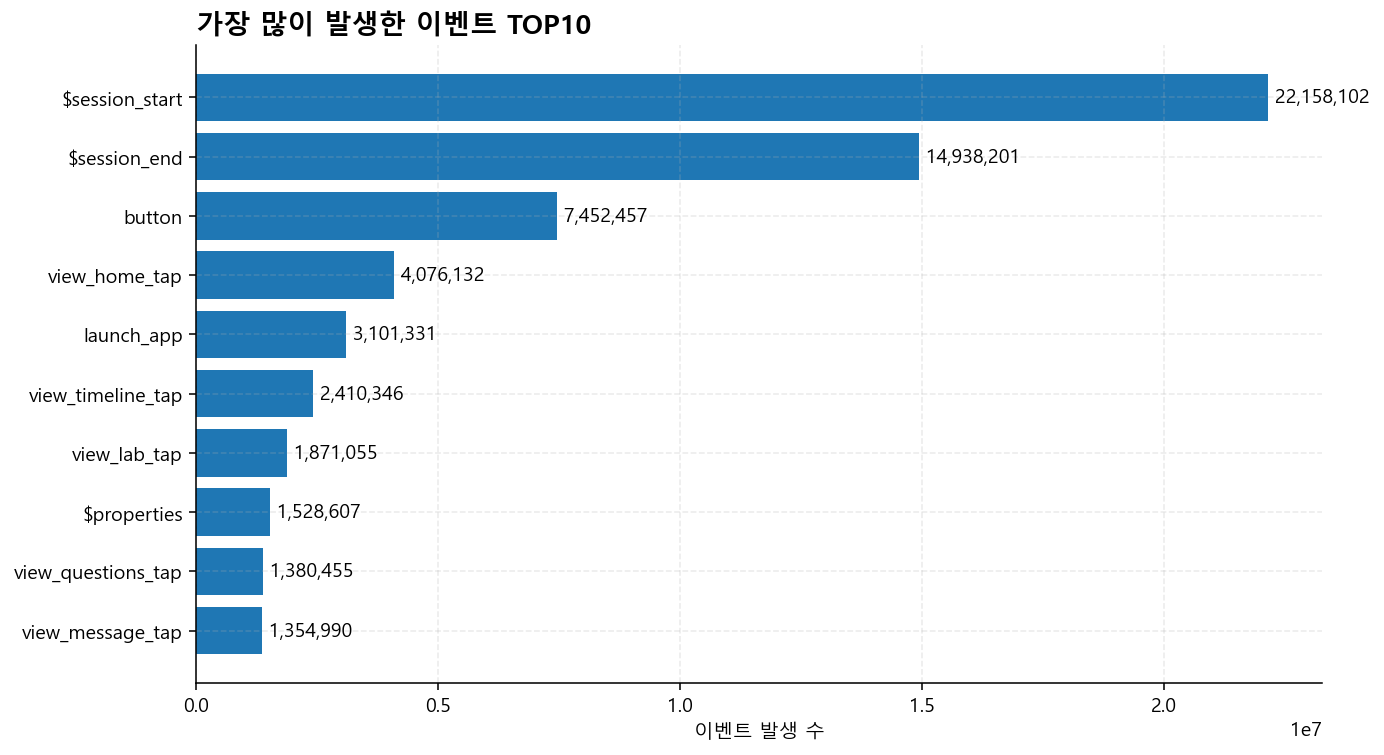


보고서 문장: 데이터에 따르면 2023-05-17 DAU 316,872명으로 정점을 찍은 뒤, 2023-08-17에는 7,429명으로 하락했습니다. 정점 대비 하락률은 약 97.66%입니다.


In [ ]:
#%% 5) 시각화 ① DAU — 보기 좋게 개선 (이 셀로 교체!)
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

dates_ts = pd.to_datetime(dates)
s_dau = pd.Series(dau, index=dates_ts)

# ---- "사실상 공백" 구간(저활성) 자동 탐지: 피크의 0.5% 이하가 3일 이상 연속
peak_val = s_dau.max()
THRESH = max(1, int(peak_val * 0.005))  # 필요하면 0.003~0.01로 조정
mask_low = (s_dau <= THRESH)
gaps = []
if mask_low.any():
    run_start = None
    idx = mask_low.index
    for i, (dt, is_low) in enumerate(mask_low.items()):
        if is_low and run_start is None:
            run_start = dt
        if (not is_low or i == len(mask_low)-1) and run_start is not None:
            run_end = idx[i-1] if not is_low else dt
            if (run_end - run_start).days + 1 >= 3:
                gaps.append((run_start, run_end))
            run_start = None

# ---- 피크/말기/하락률
peak_idx = int(np.argmax(s_dau.values))
peak_date = dates_ts[peak_idx]
peak_val  = int(s_dau.iloc[peak_idx])
end_date  = dates_ts[-1]
end_val   = int(s_dau.iloc[-1])
drop_pct  = (1 - (end_val / peak_val)) * 100 if peak_val > 0 else 0

# ---- 플롯
fig, ax = plt.subplots(figsize=(13, 6.5))

# 저활성 구간 배경 강조
# 저활성 구간 배경 강조 + 텍스트
for gs, ge in gaps:
    ax.axvspan(gs, ge, alpha=0.10, color="grey")
    mid = gs + (ge - gs)/2   # 구간의 중간 날짜
    ax.text(
        mid, max(s_dau)*0.7, "정상적으로 로그 수집이 안된 구간",
        ha="center", va="center",
        fontsize=11, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", alpha=0.8)
    )


# 원시 DAU + 7일 이동평균
ax.plot(dates_ts, s_dau.values, linewidth=2.8, label="일간 활성 사용자(DAU)")

# 영역 채우기(원시)
ax.fill_between(dates_ts, s_dau.values, alpha=0.18)

# 피크/말기 포인트 + 주석
ax.scatter([peak_date], [peak_val], s=70, zorder=5)
ax.annotate(
    f"피크: {peak_date.date()}  DAU={peak_val:,}",
    xy=(peak_date, peak_val), xytext=(0, 22), textcoords='offset points',
    ha="center", arrowprops=dict(arrowstyle='->', alpha=0.55),
    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9)
)
ax.scatter([end_date], [end_val], s=70, zorder=5)
ax.annotate(
    f"말기: {end_date.date()}  DAU={end_val:,}",
    xy=(end_date, end_val), xytext=(-20, -35), textcoords='offset points',
    ha="right", arrowprops=dict(arrowstyle='->', alpha=0.55),
    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9)
)

# 드롭률 박스(우상단 고정)
ax.text(
    0.98, 0.2, f"피크 대비 하락률: {drop_pct:.1f}%↓",
    transform=ax.transAxes, ha="right", va="bottom",
    fontsize=12, bbox=dict(boxstyle="round,pad=0.45", fc="#fff7e6", ec="#ff8c00", alpha=0.95)
)

# 축/포맷
ax.set_xlabel("날짜"); ax.set_ylabel("일간 활성 사용자 수 (DAU)")

# 날짜축 가독성
locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

# 천단위 콤마
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax.legend(loc='upper right', frameon=True)
set_pretty_axis(ax)
fig.tight_layout()
plt.savefig(os.path.join(OUTDIR, "01_dau_boom_bust_pretty.png"), bbox_inches="tight")
plt.show()


#%% 6) 시각화 ② 일간 이벤트 수
fig, ax = plt.subplots(figsize=(12, 4.8))
ax.plot(dates, events, linewidth=2.2, label="일간 이벤트 수")
ax.fill_between(dates, events, alpha=0.12)
ax.set_title("활동량 급증 후 급락 · 일간 이벤트 수", fontsize=14, loc='left')
ax.set_xlabel("날짜"); ax.set_ylabel("이벤트 수")
ax.legend(loc='upper right')
set_pretty_axis(ax)
fig.tight_layout()
plt.savefig(os.path.join(OUTDIR, "02_events_over_time.png"), bbox_inches="tight")
plt.show()

#%% 7) 시각화 ③ 신규 유입(첫 등장 ID)
fig, ax = plt.subplots(figsize=(12, 4.8))
ax.bar(dates, new_ids, label="신규 유입(첫 등장 ID)", width=0.9, align='center')
ax.set_title("신규 유입 추이 · 첫 등장 ID 수", fontsize=14, loc='left')
ax.set_xlabel("날짜"); ax.set_ylabel("신규 유입 수")
ax.legend(loc='upper right')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
set_pretty_axis(ax)
fig.tight_layout()
plt.savefig(os.path.join(OUTDIR, "03_new_users_over_time.png"), bbox_inches="tight")
plt.show()

#%% 8) 시각화 ④ 이벤트 TOP10
top10 = event_counter.most_common(10)
labels = [k for k,_ in top10][::-1]
vals   = [v for _,v in top10][::-1]

fig, ax = plt.subplots(figsize=(10, 5.5))
ax.barh(labels, vals)
ax.set_title("가장 많이 발생한 이벤트 TOP10", fontsize=14, loc='left')
ax.set_xlabel("이벤트 발생 수")
for i, v in enumerate(vals):
    ax.text(v, i, f" {v:,}", va='center')
set_pretty_axis(ax)
fig.tight_layout()
plt.savefig(os.path.join(OUTDIR, "04_top10_events.png"), bbox_inches="tight")
plt.show()

#%% 9) 보고서용 문장 자동 생성 (콘솔 출력)
msg = (
    f"데이터에 따르면 {summary['peak_date']} DAU {summary['peak_dau']:,}명으로 정점을 찍은 뒤, "
    f"{summary['end_date']}에는 {summary['end_dau']:,}명으로 하락했습니다. "
    f"정점 대비 하락률은 약 {summary['drop_pct_from_peak']}%입니다."
)
print("\n보고서 문장:", msg)



# 파이프라인 재설계

## 1. GCS .PARQUET -> BQ Bronze table
GCS의 parquet 파일을 주차별로 파티셔닝 하여 빅쿼리 테이블에 원시 데이터 적재하는 코드.

In [ ]:
import os
from google.cloud import bigquery

# 서비스 계정 인증파일 경로
CREDENTIAL_FILE = "/Users/chonghoon-shin/Downloads/sprintda07-sa.json"

# 클라이언트 생성
client = bigquery.Client.from_service_account_json(CREDENTIAL_FILE)

# 1. GCS Parquet 파일을 final_project.temp 테이블에 덮어쓰기 적재
gcs_uris = ["gs://sprint-final-bucket/random_log/2025-Sep-week-1.parquet"
           ]

for gcs_uri in gcs_uris:
  load_table_id = "sprintda07-chshin-466801.final_project.temp"

  load_job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.PARQUET,
      write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE  # 덮어쓰기 옵션
  )

  load_job = client.load_table_from_uri(
      gcs_uri,
      load_table_id,
      job_config=load_job_config
  )
  print("Load job started:", load_job.job_id)
  load_job.result()
  print("Load complete. Row count in temp table:", client.get_table(load_table_id).num_rows)

  # 2. temp 테이블의 데이터를 일부 변환하여 event_by_week 데이터셋 내 원 파일명의 테이블명으로 저장
  filename = os.path.basename(gcs_uri)
  table_suffix = os.path.splitext(filename)[0].replace('-', '_')
  destination_table_id = f"sprintda07-chshin-466801.event_by_week.{table_suffix}"

  query = """
  SELECT
    event_id
    , event_name
    , DATETIME(TIMESTAMP_MICROS(CAST(event_time / 1000 AS INT64))) AS event_time
    , event_properties
    , session_id
    , user_id
    , user_properties
    , device_properties
  FROM `sprintda07-chshin-466801.final_project.temp`
  """

  job_config = bigquery.QueryJobConfig(
      destination=destination_table_id,
      write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE  # 덮어쓰기
  )

  query_job = client.query(query, job_config=job_config)
  query_job.result()
  print(f"Query results loaded to table {destination_table_id}.")


## 2. BQ Bronze -> BQ Silver
주차별로 파티셔닝된 원시 데이터를 각 Silver table로 분류 및 변형 후 적재하는 쿼리

In [ ]:
-- events table (UPSERT)
MERGE INTO final_project.events AS target
USING (
  SELECT
    event_id
    , event_name
    , DATETIME(TIMESTAMP_MICROS(CAST(event_time / 1000 AS INT64))) AS event_time
    , event_properties
    , session_id
    , user_id
    , user_properties
    , device_properties
  FROM `sprintda07-chshin-466801.final_project.temp`
) AS source
ON target.event_id = source.event_id
WHEN NOT MATCHED THEN
  INSERT (event_id
    , event_name
    , event_time
    , event_properties
    , session_id
    , user_id
    , user_properties
    , device_properties)
  VALUES (event_id
    , source.event_name
    , source.event_time
    , source.event_properties
    , source.session_id
    , source.user_id
    , source.user_properties
    , source.device_properties);

-- attendance table (INSERT)
INSERT INTO final_project.attendance (
  attendance_id,
  user_id,
  date
)
SELECT
  GENERATE_UUID() AS attendance_id,
  user_id,
  DATE(event_time) AS date
FROM `sprintda07-chshin-466801.final_project.events`
WHERE event_name='attendance_checked';

-- schools table (region, coords)
-- 1. 임시 테이블에 중복 제거 및 랜덤 region, coords 생성
CREATE TEMP TABLE temp_source_table AS
WITH source AS (
  SELECT DISTINCT
    JSON_EXTRACT_SCALAR(user_properties, '$.school_name') AS school_name,
    CASE
      WHEN JSON_EXTRACT_SCALAR(user_properties, '$.school_name') LIKE '%중학교%' THEN 'M'
      WHEN JSON_EXTRACT_SCALAR(user_properties, '$.school_name') LIKE '%고등학교%' THEN 'H'
      ELSE NULL
    END AS type
  FROM `final_project.events`
  WHERE event_name = 'signup_completed'
),
region_prob AS (
  SELECT '경기' AS region, 0.50 AS cum_prob, 36.9 AS lat_min, 38.3 AS lat_max, 126.5 AS lon_min, 127.7 AS lon_max UNION ALL
  SELECT '서울', 0.70, 37.4, 37.7, 126.8, 127.2 UNION ALL
  SELECT '경상', 0.80, 35.0, 36.5, 128.0, 129.4 UNION ALL
  SELECT '전라', 0.90, 34.5, 35.7, 126.0, 127.5 UNION ALL
  SELECT '충청', 0.95, 36.0, 37.1, 127.0, 128.1 UNION ALL
  SELECT '강원', 1.00, 37.0, 38.5, 127.5, 129.0
),
random_source AS (
  SELECT
    GENERATE_UUID() AS school_id,
    school_name,
    type,
    RAND() AS rand_val
  FROM source
),
assigned_region AS (
  SELECT
    school_id,
    school_name,
    type,
    region,
    lat_min + RAND() * (lat_max - lat_min) AS latitude,
    lon_min + RAND() * (lon_max - lon_min) AS longitude
  FROM random_source r
  JOIN region_prob rp ON r.rand_val < rp.cum_prob
  QUALIFY ROW_NUMBER() OVER (PARTITION BY r.school_id ORDER BY rp.cum_prob) = 1
)
SELECT
  school_id,
  school_name,
  type,
  region,
  STRUCT(latitude, longitude) AS coords
FROM assigned_region;

-- 2. MERGE INTO 구문으로 대상 테이블에 병합
MERGE INTO `final_project.schools` AS target
USING temp_source_table AS source
ON target.school_name = source.school_name
WHEN NOT MATCHED THEN
  INSERT(school_id, school_name, type, region, coords)
  VALUES(source.school_id, source.school_name, source.type, source.region, source.coords);

-- classes table (UPSERT)
MERGE INTO final_project.classes AS target
USING (
  WITH school AS (
    SELECT school_id, school_name
    FROM `final_project.schools`
  )
  , student AS (
    SELECT
      event_time,
      user_id,
      JSON_EXTRACT_SCALAR(user_properties, '$.school_name') AS school_name,
      JSON_EXTRACT_SCALAR(user_properties, '$.grade') AS grade,
      JSON_EXTRACT_SCALAR(user_properties, '$.class_num') AS class_no
    FROM `final_project.events`
    WHERE event_name='signup_completed'
  )
  SELECT
    GENERATE_UUID() AS class_id,
    s.user_id,
    c.school_id,
    EXTRACT (YEAR FROM s.event_time) AS school_year,
    CAST(s.grade AS INT64) AS grade,
    CAST(s.class_no AS INT64) AS class_no
  FROM student s
  INNER JOIN school c USING(school_name)
) AS source
ON target.user_id = source.user_id
WHEN NOT MATCHED THEN
  INSERT(class_id, user_id, school_id, school_year, grade, class_no)
  VALUES(source.class_id, source.user_id, source.school_id, source.school_year, source.grade, source.class_no);

-- devices table (UPSERT)
MERGE INTO final_project.devices AS target
USING (
  SELECT
    JSON_EXTRACT_SCALAR(device_properties, '$.device_id') AS device_id,
    JSON_EXTRACT_SCALAR(device_properties, '$.os_type') AS os_name,
    JSON_EXTRACT_SCALAR(device_properties, '$.acquisition_channel') AS acquisition_channel,
    MIN(event_time) AS first_seen,
    MAX(event_time) AS last_seen
  FROM `sprintda07-chshin-466801.final_project.events`
  WHERE device_properties IS NOT NULL
  GROUP BY device_id, os_name, acquisition_channel
) AS source
ON target.device_id = source.device_id
WHEN MATCHED THEN
  UPDATE SET
    last_seen = source.last_seen
WHEN NOT MATCHED THEN
  INSERT (device_id, os_name, acquisition_channel, first_seen, last_seen)
  VALUES (source.device_id, source.os_name, source.acquisition_channel, source.first_seen, source.last_seen);

-- friends table (INSERT)
INSERT INTO `final_project.friends` (
  user_id,
  friend_user_id,
  friend_since,
  status
)
SELECT
  user_id,
  JSON_EXTRACT_SCALAR(event_properties, '$.target_user_id') AS friend_user_id,
  DATE(event_time) AS friend_since,
  CASE
    WHEN event_name='add_friend' THEN '추가'
    WHEN event_name='block_friend' THEN '차단'
  END AS status
FROM `sprintda07-chshin-466801.final_project.events`
WHERE event_name='add_friend' OR event_name='block_friend';

-- sessions table (UPSERT)
MERGE INTO final_project.sessions AS target
USING (
  SELECT
    session_id,
    user_id,
    JSON_EXTRACT_SCALAR(device_properties, '$.device_id') AS device_id,
    MIN(event_time) AS start_time,
    MAX(event_time) AS end_time,
    DATETIME_DIFF(MAX(event_time), MIN(event_time), SECOND) AS duration_sec
  FROM `sprintda07-chshin-466801.final_project.events`
  WHERE device_properties IS NOT NULL
  GROUP BY session_id, user_id, device_id
) AS source
ON target.session_id = source.session_id
WHEN NOT MATCHED THEN
  INSERT (
    session_id,
    user_id,
    device_id,
    start_time,
    end_time,
    duration_sec
  )
  VALUES (
    source.session_id,
    source.user_id,
    source.device_id,
    source.start_time,
    source.end_time,
    source.duration_sec
  );

-- payments table (INSERT)
INSERT INTO final_project.payments (
  payment_id,
  user_id,
  amount,
  payment_time,
  status,
  product_id,
  payment_method,
  error_code,
  os_type
)
SELECT
  JSON_EXTRACT_SCALAR(event_properties, '$.payment_id') AS payment_id,
  user_id,
  CAST(JSON_EXTRACT_SCALAR(event_properties, '$.amount') AS INT64) AS amount,
  event_time AS payment_time,
  JSON_EXTRACT_SCALAR(event_properties, '$.status') AS status,
  JSON_EXTRACT_SCALAR(event_properties, '$.product_id') AS product_id,
  JSON_EXTRACT_SCALAR(event_properties, '$.payment_method') AS payment_method,
  JSON_EXTRACT_SCALAR(event_properties, '$.error_code') AS error_code,
  JSON_EXTRACT_SCALAR(event_properties, '$.os_type') AS os_type
FROM final_project.events
WHERE event_name IN ('payment_succeeded', 'payment_failed');

-- points_history table (INSERT)
INSERT INTO final_project.points_history (
  point_id,
  user_id,
  change_amount,
  reason,
  created_at
)
SELECT
  JSON_EXTRACT_SCALAR(event_properties, '$.point_id') AS point_id,
  user_id,
  CASE
    WHEN event_name='points_changed' THEN CAST(JSON_EXTRACT_SCALAR(event_properties, '$.change_amount') AS INT64)
    WHEN event_name='signup_completed' THEN 1000
    WHEN event_name='payment_succeeded' THEN CAST(JSON_EXTRACT_SCALAR(event_properties, '$.amount') AS INT64)
  END AS change_amount,
  JSON_EXTRACT_SCALAR(event_properties, '$.reason') AS reason,
  event_time AS created_at
FROM `sprintda07-chshin-466801.final_project.events`
WHERE event_name IN ('points_changed', 'signup_completed', 'payment_succeeded');

-- questions table (INSERT)
INSERT INTO final_project.questions (
  question_id,
  creator_user_id,
  create_at,
  content_text
)
SELECT
  GENERATE_UUID() AS question_id,
  user_id AS creator_user_id,
  event_time AS create_at,
  JSON_EXTRACT_SCALAR(event_properties, '$.content_text') AS content_text,
FROM `sprintda07-chshin-466801.final_project.events`
WHERE event_name='question_created';

-- votee, questions, question_options table (UPSERT)
-- 1. votee_id별 고유 question_id 생성 (임시 테이블)
CREATE TEMP TABLE votee_question AS
SELECT DISTINCT
  votee_id,
  GENERATE_UUID() AS question_id
FROM (
  SELECT JSON_EXTRACT_SCALAR(event_properties, '$.votee_id') AS votee_id
  FROM `sprintda07-chshin-466801.final_project.events`
  WHERE event_name = 'votee_created'
);

-- 2. votee_results에 MERGE (votee_id 기준)
MERGE INTO `final_project.votee_results` AS target
USING (
  SELECT
    vq.votee_id,
    vq.question_id,
    event_time AS create_at
  FROM `sprintda07-chshin-466801.final_project.events` e
  JOIN votee_question vq ON vq.votee_id = JSON_EXTRACT_SCALAR(e.event_properties, '$.votee_id')
  WHERE e.event_name = 'votee_created'
) AS source
ON target.votee_id = source.votee_id
WHEN NOT MATCHED THEN
  INSERT(votee_id, question_id, create_at)
  VALUES(source.votee_id, source.question_id, source.create_at);

-- 3. questions 테이블에 votee_id별 question_id로 INSERT
INSERT INTO final_project.questions (
  question_id,
  creator_user_id,
  create_at,
  content_text
)
SELECT
  vq.question_id,
  user_id AS creator_user_id,
  event_time AS create_at,
  JSON_EXTRACT_SCALAR(event_properties, '$.content_text') AS content_text
FROM `sprintda07-chshin-466801.final_project.events` e
JOIN votee_question vq ON vq.votee_id = JSON_EXTRACT_SCALAR(e.event_properties, '$.votee_id')
WHERE event_name = 'votee_created';

-- 4. question_options 테이블 적재 (votee_id별 question_id 사용)
INSERT INTO final_project.question_options (
  option_id,
  question_id,
  option_type,
  option_text,
  option_user_id
)
SELECT
  GENERATE_UUID() AS option_id,
  vq.question_id,
  'TEXT' AS option_type,
  option_text,
  NULL AS option_user_id
FROM `sprintda07-chshin-466801.final_project.events` e,
UNNEST(JSON_QUERY_ARRAY(event_properties, '$.option_text')) AS option_text
JOIN votee_question vq ON vq.votee_id = JSON_EXTRACT_SCALAR(e.event_properties, '$.votee_id')
WHERE event_name = 'votee_created'

UNION ALL

SELECT
  GENERATE_UUID() AS option_id,
  vq.question_id,
  'USER' AS option_type,
  NULL AS option_text,
  option_user_id
FROM `sprintda07-chshin-466801.final_project.events` e,
UNNEST(JSON_QUERY_ARRAY(event_properties, '$.option_user_ids')) AS option_user_id
JOIN votee_question vq ON vq.votee_id = JSON_EXTRACT_SCALAR(e.event_properties, '$.votee_id')
WHERE event_name = 'votee_created';

-- user_votes table (INSERT)
INSERT INTO final_project.user_votes (
  vote_id,
  votee_id,
  voter_user_id,
  voted_time,
  device_id
)
SELECT
  GENERATE_UUID() AS vote_id,
  JSON_EXTRACT_SCALAR(event_properties, '$.votee_id') AS votee_id,
  user_id AS voter_user_id,
  event_time AS voted_time,
  JSON_EXTRACT_SCALAR(device_properties, '$.device_id') AS device_id
FROM `sprintda07-chshin-466801.final_project.events`
WHERE event_name='vote_submitted';

-- votee_result total_votes update
MERGE INTO final_project.votee_results AS target
USING (
  SELECT votee_id, COUNT(*) AS total_votes
  FROM final_project.user_votes
  GROUP BY votee_id
) AS source
ON target.votee_id = source.votee_id
WHEN MATCHED THEN
  UPDATE SET
    total_votes = source.total_votes;

-- users table (UPSERT)
MERGE INTO final_project.users AS target
USING (
  WITH point AS (
    SELECT user_id, SUM(change_amount) AS change_amount
    FROM final_project.points_history
    GROUP BY user_id
  )
  SELECT
    e.user_id,
    ANY_VALUE(JSON_EXTRACT_SCALAR(user_properties, '$.gender')) AS gender,
    MIN(DATE(event_time)) AS create_date,
    ANY_VALUE(point.change_amount) AS current_point_balance,
    ARRAY_AGG(JSON_EXTRACT_SCALAR(user_properties, '$.status') ORDER BY event_time DESC LIMIT 1)[SAFE_OFFSET(0)] AS status
FROM `sprintda07-chshin-466801.final_project.events` e, point
WHERE e.user_id IS NOT NULL
GROUP BY e.user_id
) AS source
ON target.user_id = source.user_id
WHEN MATCHED THEN
  UPDATE SET
    status = source.status,
    current_point_balance = target.current_point_balance + source.current_point_balance
WHEN NOT MATCHED THEN
  INSERT (user_id, gender, create_date, current_point_balance, status)
  VALUES (source.user_id, source.gender, source.create_date, source.current_point_balance, source.status);

DELETE FROM `final_project.events` WHERE TRUE;

## 3. BQ Silver -> BQ Gold
각 Silver table에 적재된 데이터를 대시보드 및 BQ ML에 사용하기 위해 집계하는 쿼리

In [ ]:
-- 신규 가입자의 24시간 이내 투표, 친구 추가 event를 필터링하는 쿼리
WITH new_user_act AS (
SELECT
  t2.user_id,
  t1.signup_time,
  t2.event_name,
  t2.event_time
FROM (
  SELECT
    user_id,
    event_time AS signup_time
  FROM
    `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '1' AND '3'
    AND event_name = 'signup_completed' ) AS t1
INNER JOIN (
  SELECT
    user_id,
    event_name,
    event_time
  FROM
    `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '1' AND '3'
    AND event_name IN ('vote_submitted', 'votee_created', 'add_friend') ) AS t2
ON
  t1.user_id = t2.user_id
WHERE
  DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) <= 24
  AND DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) >= 0
ORDER BY
  t2.user_id,
  t2.event_time
)
-- 가입 후 2주 뒤 이탈 여부 라벨링
, churned AS (
SELECT user_id
  , MIN(event_time) AS first_event
  , IF(DATETIME_DIFF(MAX(event_time), MIN(event_time), DAY) <=14, 1, 0) AS is_churned
FROM `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
WHERE _TABLE_SUFFIX BETWEEN '1' AND '6'
GROUP BY user_id
ORDER BY 2
)
SELECT *
FROM `final_project.classes`
INNER JOIN `final_project.schools` USING(school_id)
INNER JOIN new_user_act USING(user_id)
INNER JOIN churned USING(user_id);

## 4. BQ Gold -> BQ ML
머신러닝을 위해 집계한 Gold table의 데이터로 AutoML 모델 생성, 평가, 예측

In [ ]:
# 쿼리 설정
QUERY = """
WITH user_signup AS (
  SELECT
    e.user_id,
    s.school_id,
    DATE(e.event_time) AS signup_date,
    JSON_EXTRACT_SCALAR(e.user_properties, '$.grade') AS grade,
    s.type,
    s.region,
    e.event_time AS signup_time  -- 가입 시점 원본 datetime 확보
  FROM
    `event_by_week.2025_*` e
  INNER JOIN
    `final_project.schools` s
  ON
    JSON_EXTRACT_SCALAR(e.user_properties, '$.school_name') = s.school_name
  WHERE
    e.event_name = 'signup_completed'
),

daily_school_user_counts AS (
  SELECT
    school_id,
    signup_date,
    COUNT(user_id) AS daily_signup_count
  FROM
    user_signup
  GROUP BY
    school_id,
    signup_date
),

cumulative_counts AS (
  SELECT
    school_id,
    signup_date,
    SUM(daily_signup_count) OVER (
      PARTITION BY school_id
      ORDER BY signup_date
      ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS cumulative_user_count
  FROM
    daily_school_user_counts
),

-- 가입 후 2~3주 내 특정 이벤트 발생 여부 라벨링
event_labels AS (
  SELECT
    s.user_id,
    -- 가입 시점과 이벤트 시점 차이 계산 (일 단위)
    COUNTIF(
      e.event_name IS NOT NULL
      AND DATETIME_DIFF(e.event_time, s.signup_time, DAY) BETWEEN 14 AND 21
    ) > 0 AS event_occurred_label
  FROM
    user_signup s
  LEFT JOIN
    `event_by_week.2025_*` e
  ON
    s.user_id = e.user_id
  GROUP BY
    s.user_id
)

SELECT
  u.user_id,
  u.signup_date,
  u.school_id,
  u.grade,
  u.type,
  u.region,
  c.cumulative_user_count,
  IFNULL(l.event_occurred_label, FALSE) AS churned,
  CASE
    WHEN u.signup_date < '2025-08-16' THEN 'TRAIN'
    WHEN u.signup_date < '2025-08-23' THEN 'VALIDATE'
    ELSE 'TEST'
  END AS split_column
FROM
  user_signup u
JOIN
  cumulative_counts c
ON
  u.school_id = c.school_id
  AND u.signup_date = c.signup_date
LEFT JOIN
  event_labels l
ON
  u.user_id = l.user_id
ORDER BY
  u.school_id,
  u.signup_date;
"""

# AutoML 모델 생성
CREATE OR REPLACE MODEL `final_project.ml`
OPTIONS(
  MODEL_TYPE='AUTOML_CLASSIFIER',
  INPUT_LABEL_COLS=['churned'],
  OPTIMIZATION_OBJECTIVE='MAXIMIZE_AU_ROC', -- ROC 값 극대화 옵션
  BUDGET_HOURS=6.0,  -- 최대 6시간 학습
  DATA_SPLIT_COL='split_column'
) AS
QUERY

# 모델 평가 -- 정확도, 정밀도, 재현율, F1-score 등
SELECT
  *
FROM
  ML.EVALUATE(MODEL `final_project.ml`,
    (QUERY)
  );

# Feature Importance 확인
SELECT
  feature,
  importance_weight,
  importance_gain
FROM
  ML.FEATURE_IMPORTANCE(MODEL `final_project.ml`)
ORDER BY importance_weight DESC;

## 5. BQ Gold -> Dashboard
집계된 Gold table 데이터를 streamlit으로 배포하는 코드
아래 2개의 대시보드 제작
1. 신규 가입 유저의 24시간 활동 모니터링
2. 학교, 지역, 학교 유형별 이탈 위험 모니터링

### 1. 신규 가입 유저의 24시간 활동 모니터링

In [ ]:
import streamlit as st
import pandas as pd
from datetime import timedelta, datetime
from google.cloud import bigquery
from google.oauth2 import service_account


st.set_page_config(page_title="신규 가입자 24시간 이내 활동 대시보드", layout="wide")

BQ_QUERY = """
WITH new_user_act AS (
  SELECT
    t2.user_id,
    t1.signup_time,
    t2.event_name,
    t2.event_time
  FROM (
    SELECT
      user_id,
      event_time AS signup_time
    FROM
      `sprintda07-chshin-466801.event_by_week.2025_Aug*`
    WHERE
      event_name = 'signup_completed' ) AS t1
  INNER JOIN (
    SELECT
      user_id,
      event_name,
      event_time
    FROM
      `sprintda07-chshin-466801.event_by_week.2025_Aug*`
    WHERE
      event_name IN ('vote_submitted', 'votee_created', 'add_friend') ) AS t2
  ON
    t1.user_id = t2.user_id
  WHERE
    DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) <= 24
    AND DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) >= 0
)
SELECT
  DATE(event_time) AS event_time,
  COUNT(user_id) AS new_user_cnt,
  SUM(IF(event_name='add_friend', 1, 0)) AS friend_add_cnt,
  COUNTIF(event_name LIKE '%vote%') AS vote_cnt
FROM new_user_act
GROUP BY event_time
ORDER BY event_time
"""

KEY_PATH = "/Users/chonghoon-shin/Downloads/sprintda07-sa.json"

@st.cache_data
def load_data():
    credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)
    df = client.query(BQ_QUERY).to_dataframe()
    df['event_time'] = pd.to_datetime(df['event_time'])
    return df


def aggregate_data(df, freq):
    df = df.set_index('event_time')
    return df.resample(freq).agg({
        'new_user_cnt': 'sum',
        'friend_add_cnt': 'sum',
        'vote_cnt': 'sum'
    })


def get_weekly_data(df):
    return aggregate_data(df, 'W-MON')


def get_monthly_data(df):
    return aggregate_data(df, 'M')


def get_daily_data(df):
    return aggregate_data(df, 'D')


def format_with_commas(number):
    return f"{number:,}"


def calculate_delta(df, column):
    if len(df) < 2:
        return 0, 0
    current_value = df[column].iloc[-1]
    previous_value = df[column].iloc[-2]
    delta = current_value - previous_value
    delta_percent = (delta / previous_value) * 100 if previous_value != 0 else 0
    return delta, delta_percent


def create_metric_chart(df, column, color, chart_type, height=150, time_frame='Daily'):
    chart_data = df[[column]].copy()
    if time_frame == 'Quarterly':
        chart_data.index = chart_data.index.strftime('%Y Q%q')
    if chart_type == 'Bar':
        st.bar_chart(chart_data, y=column, color=color, height=height)
    else:
        st.area_chart(chart_data, y=column, color=color, height=height)

def is_period_complete(date, freq):
    today = datetime.now()
    if freq == 'D':
        return date.date() < today.date()
    elif freq == 'W':
        return date + timedelta(days=6) < today
    elif freq == 'M':
        next_month = date.replace(day=28) + timedelta(days=4)
        return next_month.replace(day=1) <= today
    elif freq == 'Q':
        return date < pd.Period(year=today.year, quarter=((today.month-1)//3)+1, freq='Q')


def display_metric(col, title, value, df, column, color, time_frame):
    with col:
        with st.container():
            delta, delta_percent = calculate_delta(df, column)
            delta_str = f"{delta:+,.0f} ({delta_percent:+.2f}%)"
            st.metric(title, format_with_commas(value), delta=delta_str)
            create_metric_chart(df, column, color, time_frame=time_frame, chart_type=chart_selection)

            last_period = df.index[-1]
            freq_dict = {'Daily': 'D', 'Weekly': 'W', 'Monthly': 'M', 'Quarterly': 'Q'}
            freq = freq_dict.get(time_frame, 'D')
            if not is_period_complete(last_period, freq):
                suffix = time_frame.lower()[:-2] if time_frame != 'Daily' else 'day'
                st.caption(f"Note: The last {suffix} is incomplete.")


df = load_data()

with st.sidebar:
    st.title("신규 유저 24시간 행동 대시보드")
    max_date = df['event_time'].max().date()
    min_date = df['event_time'].min().date()
    start_date = st.date_input("시작일", min_date, min_value=min_date, max_value=max_date)
    end_date = st.date_input("종료일", max_date, min_value=min_date, max_value=max_date)
    time_frame = st.selectbox("기간", ("Daily", "Weekly", "Monthly"))
    chart_selection = st.selectbox("차트 유형", ("Bar", "Area"))

if time_frame == 'Daily':
    df_display = get_daily_data(df)
elif time_frame == 'Weekly':
    df_display = get_weekly_data(df)
else:
    df_display = get_monthly_data(df)

mask = (df_display.index >= pd.Timestamp(start_date)) & (df_display.index <= pd.Timestamp(end_date))
df_filtered = df_display.loc[mask]


# == 전체 기간 통계 ==
st.subheader("전체 통계")
metrics = [
    ("신규 가입자 수", "new_user_cnt", '#184588'),
    ("친구 추가 수", "friend_add_cnt", '#eba039'),
    ("투표 횟수", "vote_cnt", '#4b6587')
]

cols = st.columns(3)
for col, (title, column, color) in zip(cols, metrics):
    # 전체 기간은 원본 df 기준 합계
    total_value = df[column].sum()
    display_metric(col, title, total_value, df_display, column, color, time_frame)


# == 선택 기간 통계 ==
st.subheader("선택한 기간 데이터")
cols = st.columns(3)
for col, (title, column, color) in zip(cols, metrics):
    display_metric(col, title, df_filtered[column].sum(), df_filtered, column, color, time_frame)


with st.expander('원본 데이터 보기'):
    st.dataframe(df_filtered)


### 2. 이탈 위험 모니터링 대시보드

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import pydeck as pdk
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    "/Users/chonghoon-shin/Downloads/sprintda07-sa.json"
)
client = bigquery.Client(credentials=credentials, project="sprintda07-chshin-466801")

st.title('정착 실패 모니터링 대시보드')

### functions ###
@st.cache_data(ttl=3600)  # 1시간 캐싱
def load_data_from_bigquery():
    query = """
    WITH new_user_act AS (
    SELECT
      t2.user_id,
      t1.signup_time,
      t2.event_name,
      t2.event_time
    FROM (
      SELECT
        user_id,
        event_time AS signup_time
      FROM
        `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
      WHERE
        _TABLE_SUFFIX BETWEEN '1' AND '3'
        AND event_name = 'signup_completed' ) AS t1
    INNER JOIN (
      SELECT
        user_id,
        event_name,
        event_time
      FROM
        `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
      WHERE
        _TABLE_SUFFIX BETWEEN '1' AND '3'
        AND event_name IN ('vote_submitted', 'votee_created', 'add_friend') ) AS t2
    ON
      t1.user_id = t2.user_id
    WHERE
      DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) <= 24
      AND DATETIME_DIFF(t2.event_time, t1.signup_time, HOUR) >= 0
    ORDER BY
      t2.user_id,
      t2.event_time
    )
    -- 가입 후 2주 뒤 이탈 여부 라벨링
    , churned AS (
    SELECT user_id
      , MIN(event_time) AS first_event
      , IF(DATETIME_DIFF(MAX(event_time), MIN(event_time), DAY) <=14, 1, 0) AS is_churned
    FROM `sprintda07-chshin-466801`.`event_by_week`.`2025_Aug_week_*`
    WHERE _TABLE_SUFFIX BETWEEN '1' AND '6'
    GROUP BY user_id
    ORDER BY 2
    )
    SELECT *
      , coords.latitude AS latitude
      , coords.longitude AS longitude
    FROM `final_project.classes`
    INNER JOIN `final_project.schools` USING(school_id)
    INNER JOIN new_user_act USING(user_id)
    INNER JOIN churned USING(user_id)
    """
    return client.query(query).to_dataframe()

# 학교별 이탈률 집계
@st.cache_data(ttl=3600)
def df_school_agg(df: pd.DataFrame) -> pd.DataFrame:
    total_counts = (
        df.groupby(["school_id", "school_name"])["user_id"]
          .nunique()
          .reset_index(name="total_student_count")
    )
    churned_counts = (
        df.query("is_churned_2 == 1")
          .groupby(["school_id", "school_name"])["user_id"]
          .nunique()
          .reset_index(name="churned_student_count")
    )
    school_stats = total_counts.merge(churned_counts, on=["school_id", "school_name"], how="left")
    school_stats["churned_student_count"] = school_stats["churned_student_count"].fillna(0).astype(int)
    school_stats["churn_rate"] = school_stats["churned_student_count"] / school_stats["total_student_count"]
    return df.merge(school_stats, on=["school_id", "school_name"], how="left")

@st.cache_data(ttl=3600)
def df_daily_churn_rate(df: pd.DataFrame) -> pd.DataFrame:
    # signup_time 을 날짜(date) 단위로 변환
  df['signup_date'] = df['signup_time'].dt.date

  # 날짜별 전체 유저 수 집계 (유니크 user_id 기준)
  total_users = df.groupby('signup_date')['user_id'].nunique()

  # 날짜별 이탈 유저 수 집계 (is_churned_2 == 1 인 유니크 user_id)
  churned_users = df[df['is_churned_2'] == 1].groupby('signup_date')['user_id'].nunique()

  # 데이터프레임으로 합치고 누락된 날짜는 0으로 채움
  daily_churn_rate_df = pd.DataFrame({
      'total_users': total_users,
      'churned_users': churned_users
  }).fillna(0)

  # 일별 이탈 위험 비율 계산
  daily_churn_rate_df['churn_rate'] = daily_churn_rate_df['churned_users'] / daily_churn_rate_df['total_users']

  return daily_churn_rate_df.reset_index()

def df_region_churn_rate(df: pd.DataFrame) -> pd.DataFrame:
    # 지역별 전체 유저 수 (유니크 user_id 기준)
    region_total = df.groupby('region')['user_id'].nunique()

    # 지역별 이탈 유저 수 (is_churned_2 == 1)
    region_churned = df[df['is_churned_2'] == 1].groupby('region')['user_id'].nunique()

    # 합치기 및 결측값 0으로 채우기
    region_churn_rate_df = pd.DataFrame({
        'total_users': region_total,
        'churned_users': region_churned
    }).fillna(0)

    # 이탈 위험 비율 계산
    region_churn_rate_df['churn_rate'] = region_churn_rate_df['churned_users'] / region_churn_rate_df['total_users']

    # 인덱스 리셋 (optional)
    region_churn_rate_df = region_churn_rate_df.reset_index()

    return region_churn_rate_df


### 대시보드 시각화 준비 ###
df = load_data_from_bigquery()

# streamlit 오류 방지를 위해 dict 형태 컬럼 삭제
if "coords" in df.columns:
    df = df.drop(columns=["coords"])

# 적정 이탈 비율 라벨링(40%)
# user_id 기준 유니크값 추출
unique_users = df['user_id'].unique()

# 40% 확률 난수 생성 (재현성 위해 시드 고정)
np.random.seed(1234)
churn_flag = np.random.rand(len(unique_users)) < 0.4

# user_id별 is_churned_2 라벨 맵 생성
user_churn_map = dict(zip(unique_users, churn_flag.astype(int)))

# 원본 df에 user_id 기준으로 is_churned_2 컬럼 추가
df['is_churned_2'] = df['user_id'].map(user_churn_map)


### 대시보드 레이아웃 설정###
col1, col2 = st.columns([2, 2])

with col1:
  ### ✅ Streamlit 지도 시각화 ###
  school_df = df_school_agg(df)

  # 학교 단위로 집계 (lat, lon 포함)
  school_map_df = school_df[[
      "school_id", "school_name", "latitude", "longitude",
      "total_student_count", "churned_student_count", "churn_rate"
  ]].drop_duplicates()

  # Streamlit 지도 표시
  st.subheader("학교별 위험 유저 현황")

  # 이탈률 정리 및 색상 생성 (0=녹색, 1=적색, 투명도 160)
  school_map_df["churn_rate"] = school_map_df["churn_rate"].fillna(0).clip(0, 1)
  school_map_df["color"] = school_map_df["churn_rate"].apply(
      lambda x: [int(255*x), int(255*(1-x)), 0, 160]
  )

  # 초기 뷰(중심점은 평균 좌표)
  view = pdk.ViewState(
      latitude=float(school_map_df["latitude"].mean()),
      longitude=float(school_map_df["longitude"].mean()),
      zoom=9
  )

  school_map_df["churn_rate_str"] = school_map_df["churn_rate"].apply(lambda x: f"{x:.2f}")

  layer = pdk.Layer(
      "ScatterplotLayer",
      data=school_map_df,
      get_position=["longitude", "latitude"],   # ✅ lon 먼저, lat 나중
      get_fill_color='color',
      get_radius=3000,
      pickable=True
  )

  tooltip = {
      "html": "<b>학교:</b> {school_name}<br>"
              "<b>전체:</b> {total_student_count}<br>"
              "<b>이탈:</b> {churned_student_count}<br>"
              "<b>이탈률:</b> {churn_rate_str}"
  }

  deck = pdk.Deck(layers=[layer], initial_view_state=view, tooltip=tooltip, map_style="light")
  st.pydeck_chart(deck, use_container_width=True)

with col2:
    # 일별 이탈 위험 비율 집계
    daily_churn_rate_df = df_daily_churn_rate(df)

    # 위쪽: 일별 이탈 위험 시계열
    st.subheader("일별 이탈 위험 비율")
    st.line_chart(
    data=daily_churn_rate_df.set_index('signup_date')['churn_rate'])

    # 아래쪽: 2칸으로 분할 (지역별, 학교 유형별)
    st.subheader("지역 및 학교 유형별 이탈 위험 비율")

    region_churn_rate_df = df_region_churn_rate(df)
    school_type_churn_rate_df = df.groupby('type')['is_churned_2'].mean().reset_index()

    region_col, school_type_col = st.columns(2)
    with region_col:
      st.bar_chart(region_churn_rate_df.set_index('region')['churn_rate'])
      # fig, ax = plt.subplots()
      # region_churn_rate_df.set_index('region')['churn_rate'].plot(kind='bar', ax=ax)
      # plt.xticks(rotation=-90)  # x축 라벨 90도 회전
      # st.pyplot(fig)

    with school_type_col:
      st.bar_chart(school_type_churn_rate_df.set_index('type')['is_churned_2'])
      # fig2, ax2 = plt.subplots()
      # school_type_churn_rate_df.set_index('type')['is_churned_2'].plot(kind='bar', ax=ax2)
      # plt.xticks(rotation=-90)
      # st.pyplot(fig2)


In [ ]:
final_user_dataset.head()

id                 created_at gender  group_id  id_group  school_id  \
0  831956 2023-03-29 03:44:14.047130   None       NaN       NaN        NaN   
1  831962 2023-03-29 05:18:56.162368      F      12.0      12.0        1.0   
2  832151 2023-03-29 12:56:34.989468      M       1.0       1.0        1.0   
3  832340 2023-03-29 12:56:35.020790      F       1.0       1.0        1.0   
4  832520 2023-03-29 12:56:35.049311      M      12.0      12.0        1.0   

   grade  id_school  student_count address school_type  
0    NaN        NaN            NaN     NaN         NaN  
1    2.0        NaN            NaN     NaN         NaN  
2    1.0        NaN            NaN     NaN         NaN  
3    1.0        NaN            NaN     NaN         NaN  
4    2.0        NaN            NaN     NaN         NaN

#### 기본 테이블 시각화

학년별 분포, 학교 유형별 분포, 성별 분포, 학교별 학생수 분포, 지역별 분포, 요일/시간대별 가입자 수, 지역별  분포

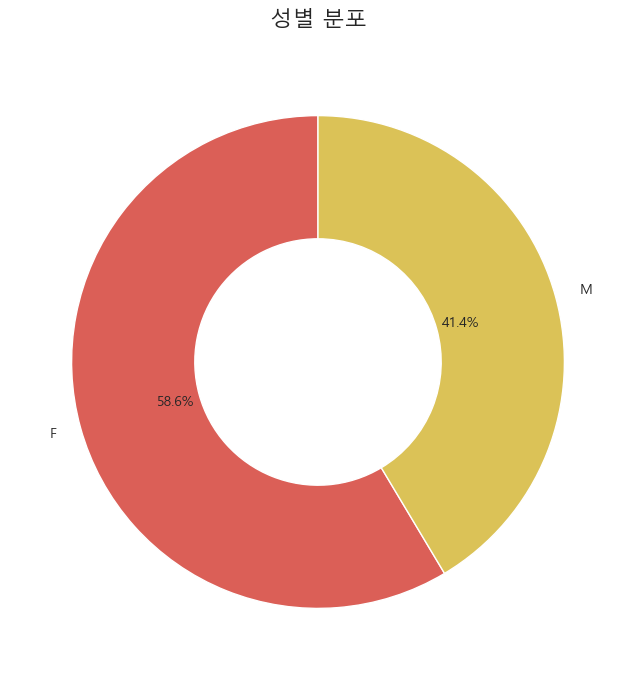

C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:31: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




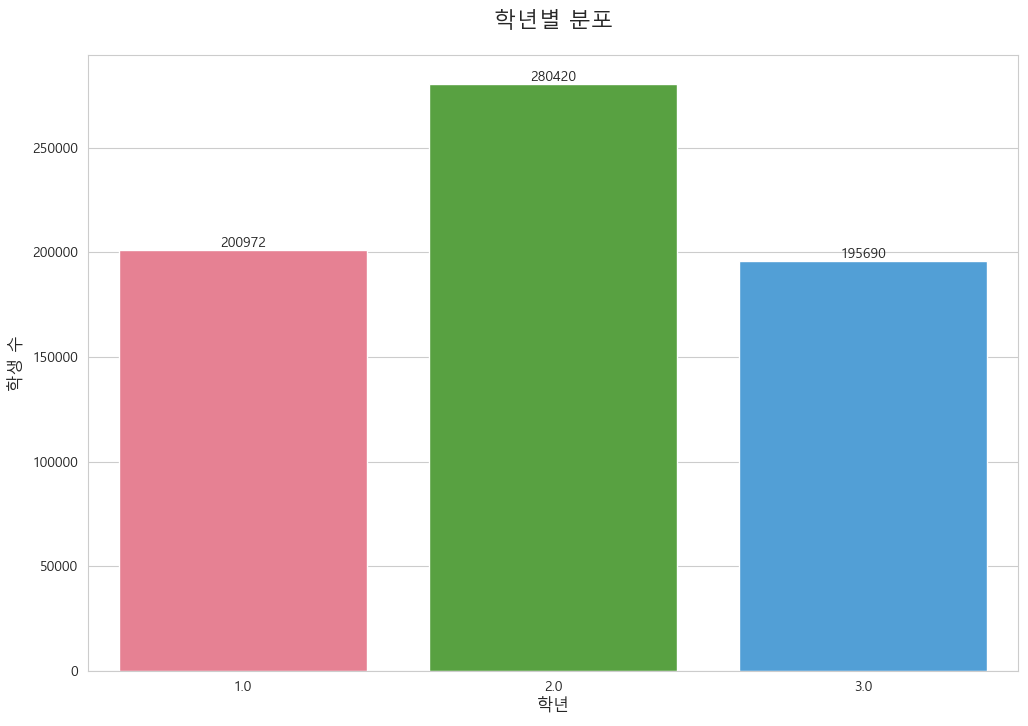

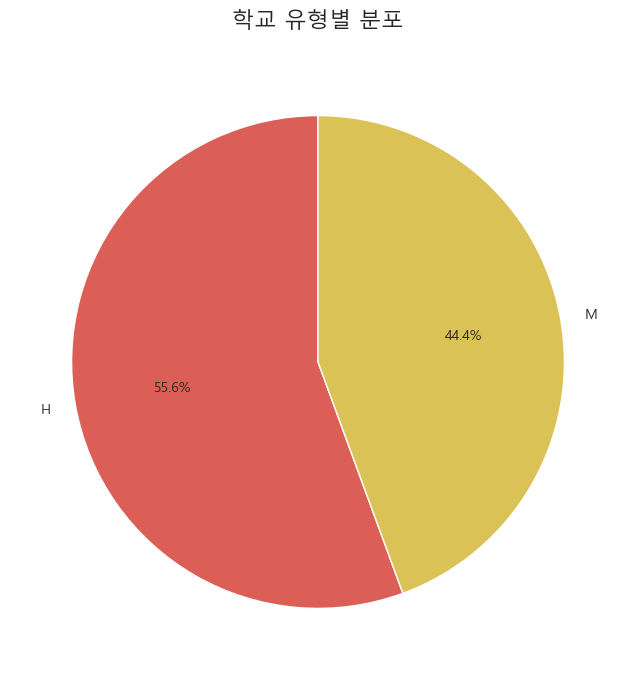

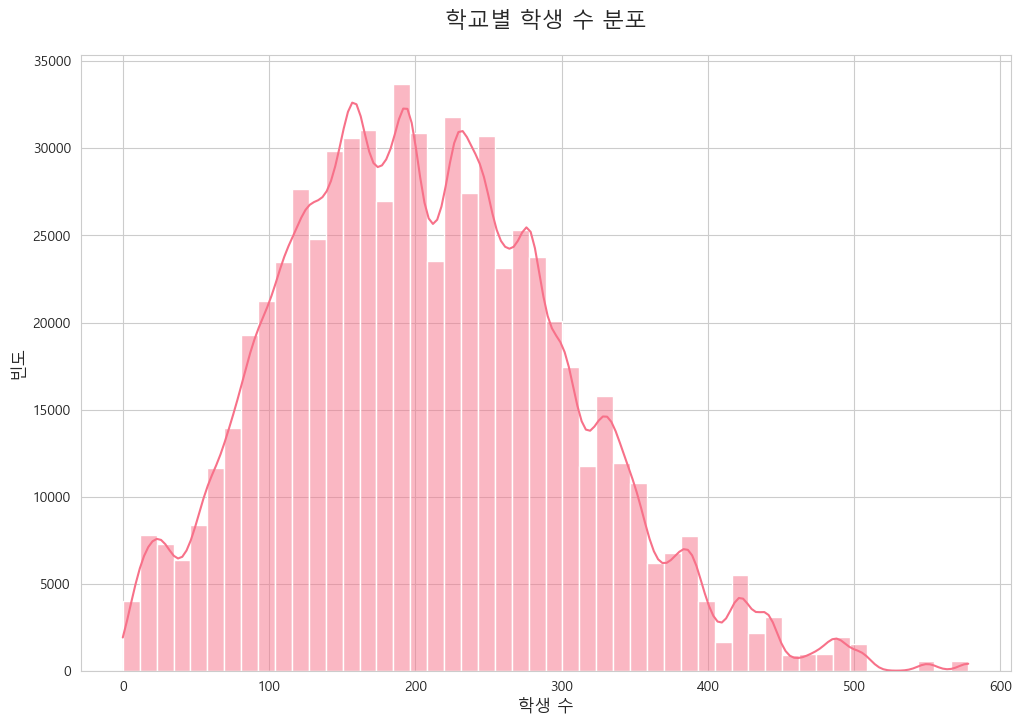

C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




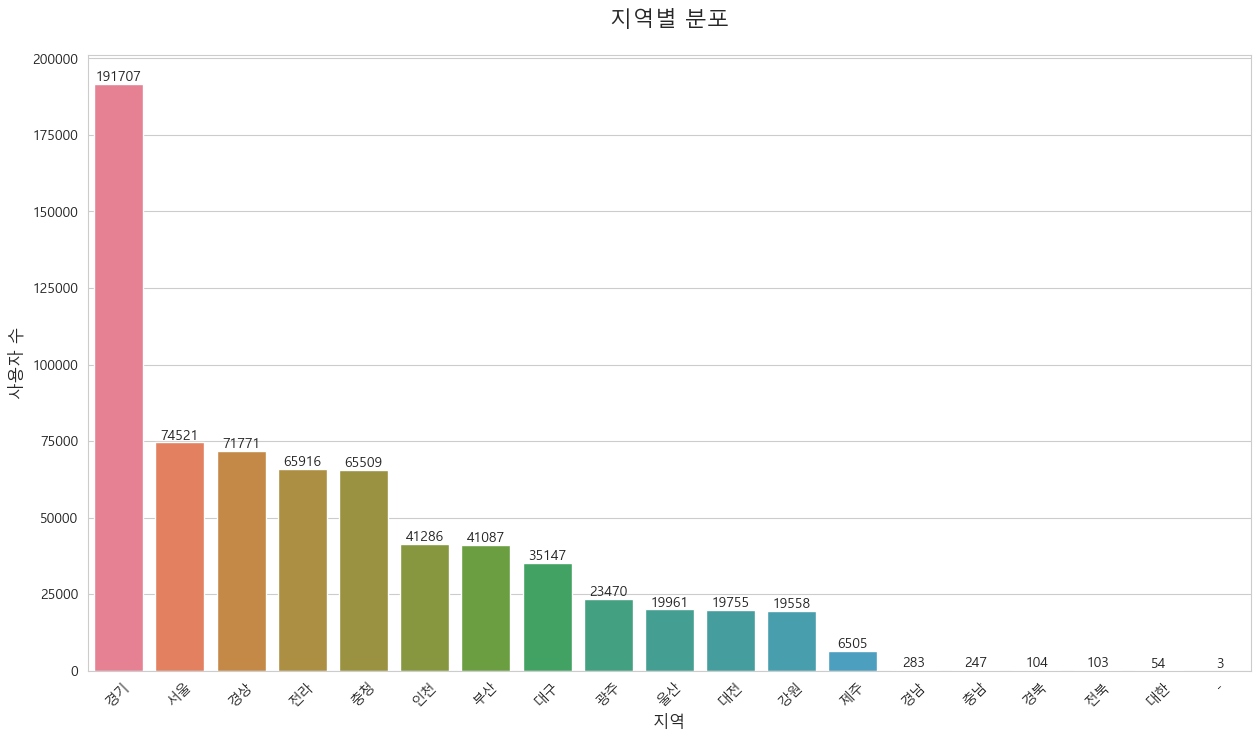

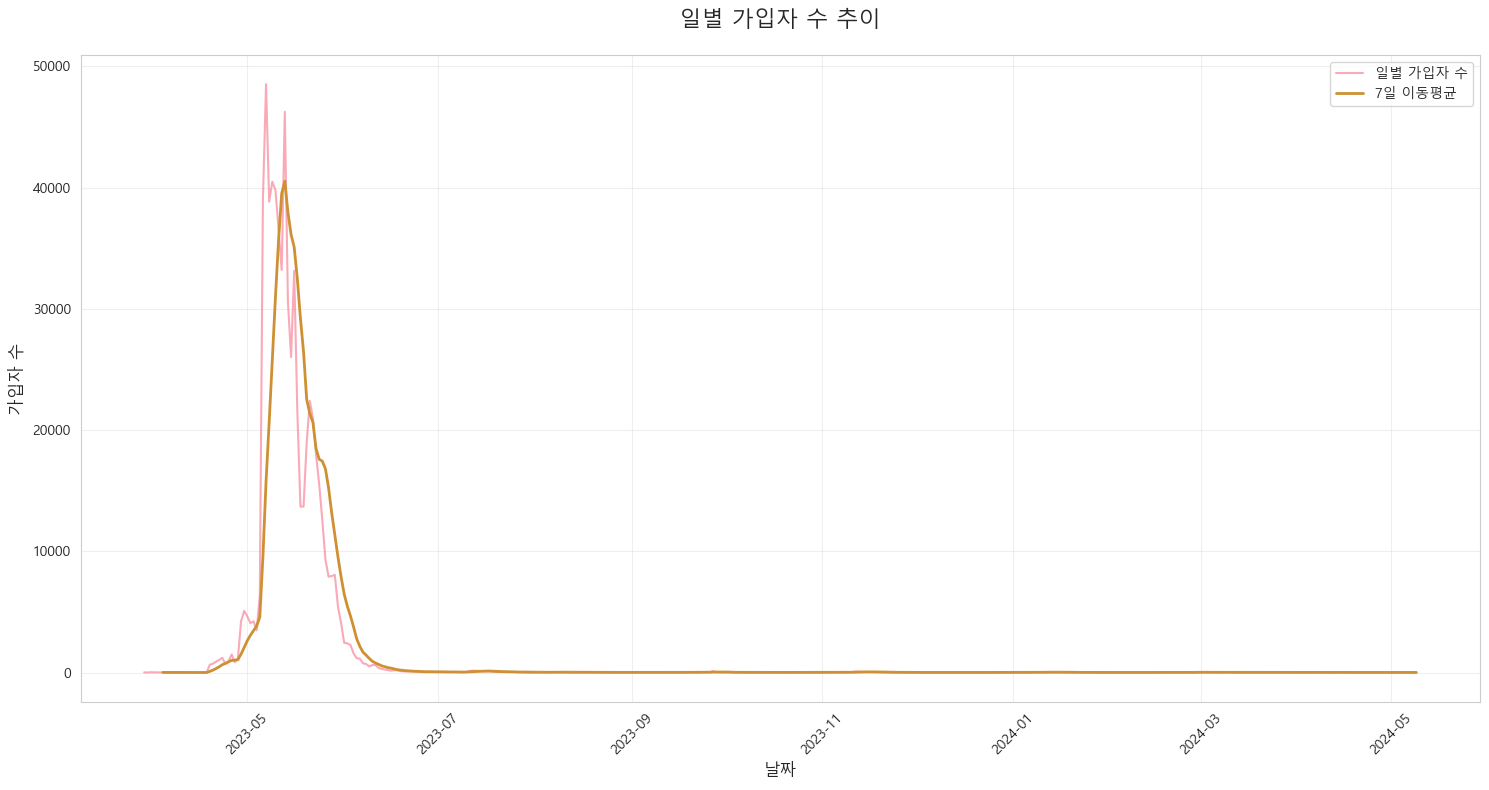

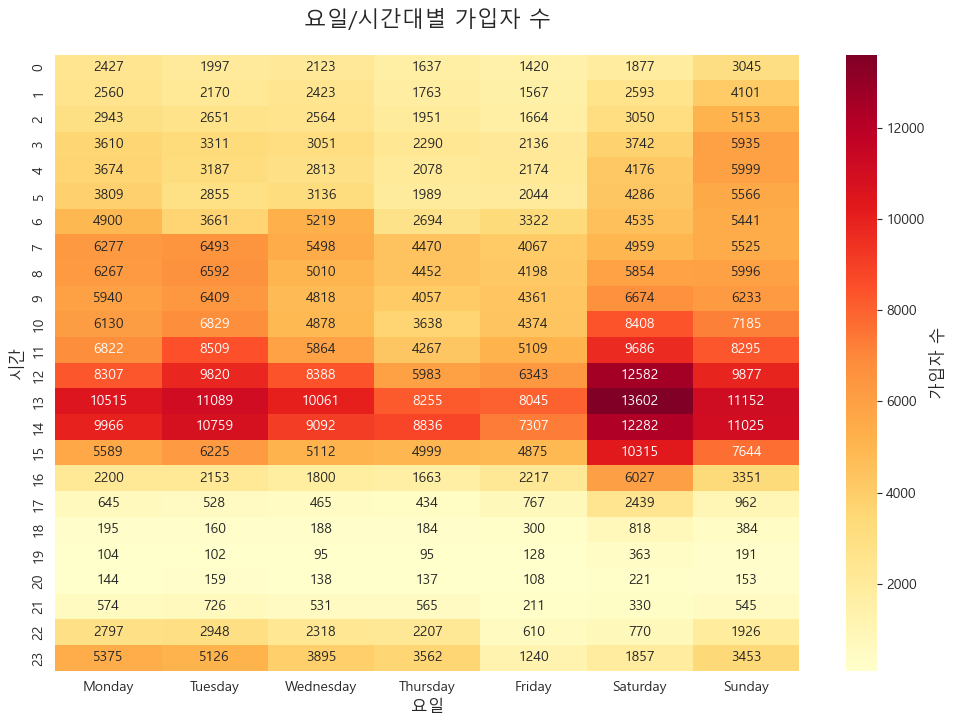

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# 색상 팔레트 설정
colors = sns.color_palette("husl", 8)
pie_colors = sns.color_palette("hls", 8)

# 1. 성별 분포 (도넛 차트)
plt.figure(figsize=(12, 8))
gender_counts = final_user_dataset['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
        colors=pie_colors, startangle=90,
        wedgeprops=dict(width=0.5))  # 도넛 형태로 만들기
plt.title('성별 분포', pad=20, fontsize=16)
plt.show()

# 2. 학년별 분포 (개선된 막대 그래프)
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=final_user_dataset, x='grade', y='grade', 
                 estimator=lambda x: len(x), ci=None,
                 palette='husl')
plt.title('학년별 분포', pad=20, fontsize=16)
plt.xlabel('학년', fontsize=12)
plt.ylabel('학생 수', fontsize=12)

# 막대 위에 숫자 표시
for i, v in enumerate(final_user_dataset['grade'].value_counts().sort_index()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 3. 학교 유형별 분포 (향상된 파이 차트)
plt.figure(figsize=(12, 8))
school_type_counts = final_user_dataset['school_type'].value_counts()
plt.pie(school_type_counts, labels=school_type_counts.index, 
        autopct='%1.1f%%', colors=pie_colors,
        startangle=90)
plt.title('학교 유형별 분포', pad=20, fontsize=16)
plt.show()

# 4. 학생 수 분포 (KDE plot 추가)
plt.figure(figsize=(12, 8))
sns.histplot(data=final_user_dataset, x='student_count', bins=50,
             kde=True, color=colors[0])
plt.title('학교별 학생 수 분포', pad=20, fontsize=16)
plt.xlabel('학생 수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.show()

# 5. 지역별 분포 (개선된 막대 그래프)
plt.figure(figsize=(15, 8))
final_user_dataset['region'] = final_user_dataset['address'].str[:2]
region_counts = final_user_dataset['region'].value_counts()

# 막대 그래프 생성
ax = sns.barplot(x=region_counts.index, y=region_counts.values, 
                 palette='husl')
plt.title('지역별 분포', pad=20, fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('지역', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)

# 막대 위에 숫자 표시
for i, v in enumerate(region_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 6. 시간에 따른 가입자 수 추이 (개선된 시계열 그래프)
plt.figure(figsize=(15, 8))
final_user_dataset['created_at'] = pd.to_datetime(final_user_dataset['created_at'])
daily_signups = final_user_dataset.resample('D', on='created_at')['id'].count()

# 7일 이동평균 추가
moving_avg = daily_signups.rolling(window=7).mean()

plt.plot(daily_signups.index, daily_signups.values, 
         alpha=0.6, label='일별 가입자 수', color=colors[0])
plt.plot(moving_avg.index, moving_avg.values, 
         label='7일 이동평균', color=colors[1], linewidth=2)

plt.title('일별 가입자 수 추이', pad=20, fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가입자 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 7. 요일별/시간별 가입자 수 히트맵 (개선된 버전)
plt.figure(figsize=(12, 8))
final_user_dataset['hour'] = final_user_dataset['created_at'].dt.hour
final_user_dataset['weekday'] = final_user_dataset['created_at'].dt.day_name()

# 요일 순서 지정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                 'Friday', 'Saturday', 'Sunday']

# 피벗 테이블 생성
heatmap_data = pd.pivot_table(
    final_user_dataset, 
    values='id',
    index='hour',
    columns='weekday',
    aggfunc='count'
)[weekday_order]  # 요일 순서 적용

# 히트맵 그리기
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g',
            cbar_kws={'label': '가입자 수'})
plt.title('요일/시간대별 가입자 수', pad=20, fontsize=16)
plt.xlabel('요일', fontsize=12)
plt.ylabel('시간', fontsize=12)
plt.show()

u 데이터를 만들고, 24h를 기준으로

In [ ]:
import pandas as pd
import numpy as np

# final_user_dataset에서 24h 기준이 될 가입 시각만 추출
u = final_user_dataset[['id', 'created_at', 'gender', 'grade', 'school_id', 'student_count', 'school_type', 'address']].copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')
u = u.rename(columns={'id': 'user_id', 'created_at': 'signup_time'})

u = u.dropna()

In [ ]:
u

user_id                signup_time gender  grade  school_id  \
11       833024 2023-03-31 09:05:51.903699      F    1.0     5464.0   
12       833041 2023-03-31 14:32:36.425315      F    3.0      314.0   
13       833112 2023-03-31 15:55:48.870381      M    3.0      281.0   
14       833113 2023-03-31 15:56:52.300066      M    1.0      272.0   
15       833154 2023-03-31 15:57:39.008717      F    1.0      272.0   
...         ...                        ...    ...    ...        ...   
677080  1583729 2024-05-08 21:54:33.621408      M    3.0     2389.0   
677081  1583730 2024-05-09 07:08:11.001817      M    3.0     2969.0   
677082  1583731 2024-05-09 07:22:19.186439      M    3.0     2579.0   
677083  1583732 2024-05-09 07:22:38.387553      F    3.0     2579.0   
677084  1583733 2024-05-09 08:31:17.710824      F    3.0     2240.0   

        student_count school_type       address  
11              158.0           H       경기도 군포시  
12              131.0           H  충청남도 천안시 동남구  
13              347.0           H  충청남도 천안시 서북구  
14              339.0           H  충청남도 천안시 서북구  
15              339.0           H  충청남도 천안시 서북구  
...               ...         ...           ...  
677080          301.0           H     서울특별시 구로구  
677081          256.0           M      대전광역시 중구  
677082          199.0           H     서울특별시 강남구  
677083          199.0           H     서울특별시 강남구  
677084          146.0           H     서울특별시 동작구  

[676987 rows x 8 columns]

함수 생성.

- **within_24h**: 가입 후 24시간 이내 이벤트만 필터링
- **agg_first_last_hours**: 가입 후 첫/마지막 이벤트 시점(시간) 계산
- **assert_single_user_id**: user_id 컬럼이 1개만 있는지 확인

In [ ]:
# 24시간 창 슬라이싱: key_user_col을 'user_id'로 표준화한 뒤 on='user_id'로 조인
def within_24h(df, key_user_col, time_col, u_base=None):
    t = df.copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    if key_user_col != 'user_id':
        t = t.rename(columns={key_user_col: 'user_id'})
    t = t.merge(u_base[['user_id','signup_time']], on='user_id', how='inner')
    mask = (t[time_col] >= t['signup_time']) & (t[time_col] < t['signup_time'] + pd.Timedelta(hours=24))
    return t.loc[mask].copy()

# 안전 확인용: user_id가 1개만 있는지 검사
def assert_single_user_id(df, name="df"):
    cnt = list(df.columns).count('user_id')
    if cnt != 1:
        raise AssertionError(f"{name}: 'user_id' 컬럼이 {cnt}개 존재")


In [ ]:
accounts_attendance

id                               attendance_date_list  user_id
0            1  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1446852
1            2  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1359398
2            3  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1501542
3            4  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1507767
4            5  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1287453
...        ...                                                ...      ...
349632  360501                                                 []   897005
349633  360502                                     ["2024-05-09"]  1407059
349634  360503                                     ["2024-05-09"]  1583727
349635  360504                                     ["2024-05-09"]  1392372
349636  360505                                     ["2024-05-09"]  1583730

[349637 rows x 3 columns]

### 결제 join
pay_24h_cnt만 유지

In [ ]:
# ------- 결제 성공: accounts_paymenthistory -------
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')

pay_24 = within_24h(pay, key_user_col='user_id', time_col='created_at', u_base=u)
pay_cnt  = pay_24.groupby('user_id').size().rename('pay_24h_cnt')

feat_pay = pay_cnt.to_frame()

print("feat_pay.shape:", feat_pay.shape)
feat_pay.head(3)

final_features = u.merge(feat_pay, on='user_id', how='left')
final_features['pay_24h_cnt'] = final_features['pay_24h_cnt'].fillna(0).astype(int)

feat_pay.shape: (13708, 1)


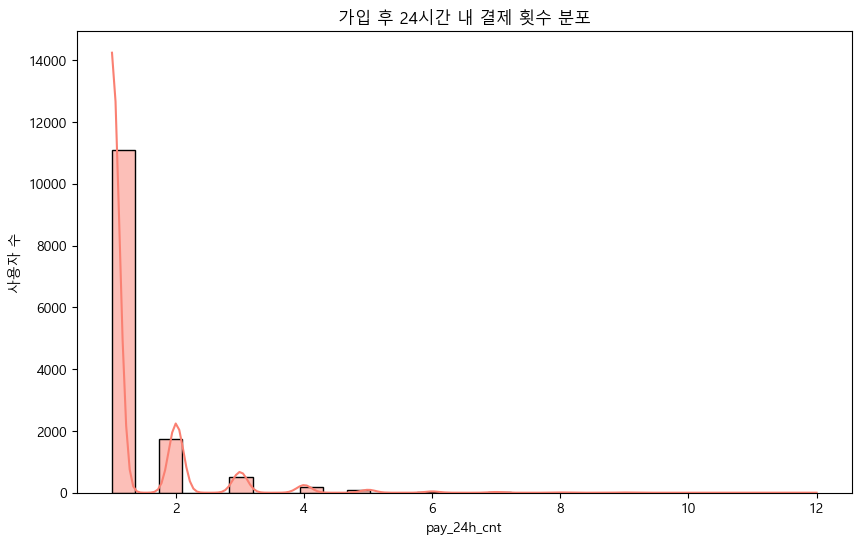

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(feat_pay['pay_24h_cnt'], bins=30, kde=True, color='salmon')
plt.title('가입 후 24시간 내 결제 횟수 분포')
plt.xlabel('pay_24h_cnt')
plt.ylabel('사용자 수')
plt.show()

In [ ]:
final_features.describe()

user_id                 signup_time          grade      school_id  \
count  6.769870e+05                      676987  676987.000000  676987.000000   
mean   1.212977e+06  2023-05-15 22:44:04.528038       1.992272    3113.791602   
min    8.330240e+05  2023-03-31 09:05:51.903699       1.000000       4.000000   
25%    1.028102e+06  2023-05-09 01:39:12.498951       1.000000    1649.000000   
50%    1.211735e+06  2023-05-13 10:51:03.883902       2.000000    3129.000000   
75%    1.397892e+06  2023-05-20 07:48:35.328402       3.000000    4691.000000   
max    1.583733e+06  2024-05-09 08:31:17.710824       3.000000    5965.000000   
std    2.138736e+05                         NaN       0.765340    1715.616687   

       student_count    pay_24h_cnt  
count  676987.000000  676987.000000  
mean      206.806301       0.026263  
min         0.000000       0.000000  
25%       136.000000       0.000000  
50%       199.000000       0.000000  
75%       272.000000       0.000000  
max       578.000000      12.000000  
std        97.384453       0.212732

### 포인트 join

In [ ]:
accounts_pointhistory

id  delta_point          created_at  user_id  \
0           790629            9 2023-04-28 12:27:49   849436   
1           790652            9 2023-04-28 12:28:02   849436   
2           790664            5 2023-04-28 12:28:09   849436   
3           790680           13 2023-04-28 12:28:16   849436   
4           790703            5 2023-04-28 12:28:26   849436   
...            ...          ...                 ...      ...   
2338913  340672371           14 2024-05-08 01:35:02   855509   
2338914  340672372           11 2024-05-08 01:36:00   855525   
2338915  340672373           11 2024-05-08 01:36:00   855526   
2338916  340672374           12 2024-05-08 01:36:18   855525   
2338917  340672375           12 2024-05-08 01:36:18   874566   

         user_question_record_id  
0                       771777.0  
1                       771800.0  
2                       771812.0  
3                       771828.0  
4                       771851.0  
...                          ...  
2338913              161666462.0  
2338914              161666463.0  
2338915              161666463.0  
2338916              161666464.0  
2338917              161666464.0  

[2338918 rows x 5 columns]

In [ ]:
accounts_pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[us]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[us](1), float64(1), int64(3)
memory usage: 89.2 MB


In [ ]:
# ------- 포인트: accounts_pointhistory -------
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
pt['delta_point'] = pd.to_numeric(pt.get('delta_point'), errors='coerce')

pt_24 = within_24h(pt, key_user_col='user_id', time_col='created_at', u_base=u)

# 필요한 컬럼만 계산
pt_agg = pt_24.groupby('user_id').agg(
    point_24h_events=('delta_point', 'size'),
    point_24h_pos_sum=('delta_point', lambda s: s[s > 0].sum() if len(s) else 0),
)

feat_point = pt_agg.copy()

print("feat_point.shape:", feat_point.shape)
feat_point.head(3)

# final_features와 feat_point를 user_id 기준으로 병합, 결측값은 0으로 채움
final_features = final_features.merge(feat_point, on='user_id', how='left')
final_features['point_24h_events'] = final_features['point_24h_events'].fillna(0).astype(int)
final_features['point_24h_pos_sum'] = final_features['point_24h_pos_sum'].fillna(0).astype(int)


feat_point.shape: (4618, 2)


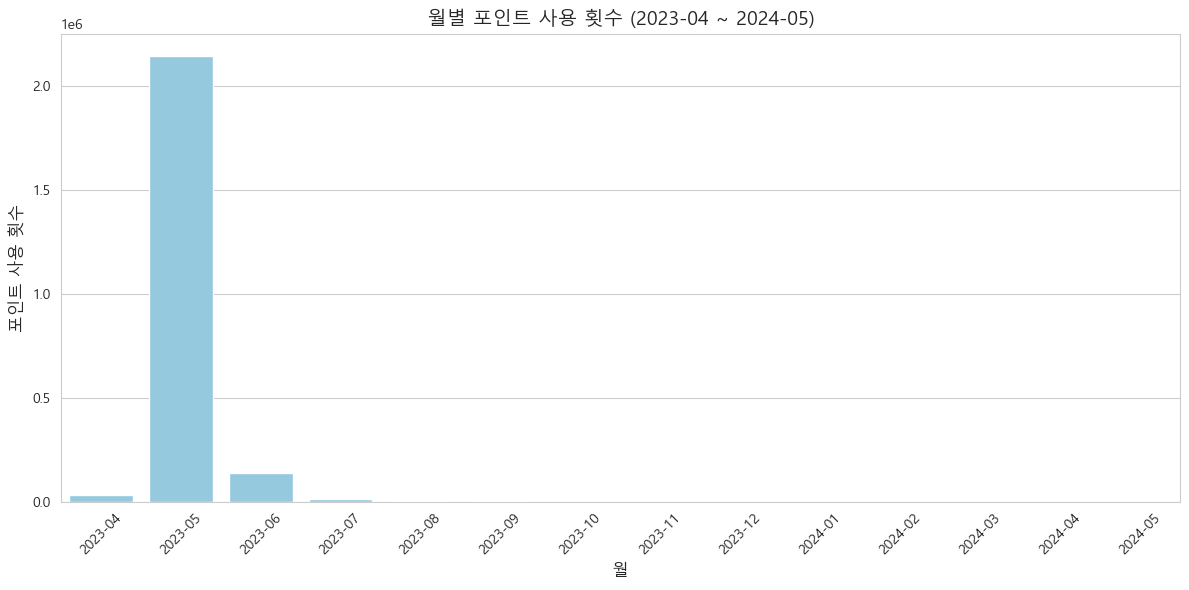

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# pt에서 2023-04 ~ 2024-05 기간만 필터링
pt['created_at'] = pd.to_datetime(pt['created_at'], errors='coerce')
pt_period = pt[(pt['created_at'] >= '2023-04-01') & (pt['created_at'] < '2024-06-01')]

# 월별 포인트 사용(이벤트) 횟수 집계
pt_period['month'] = pt_period['created_at'].dt.to_period('M')
monthly_counts = pt_period.groupby('month').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('월별 포인트 사용 횟수 (2023-04 ~ 2024-05)')
plt.xlabel('월')
plt.ylabel('포인트 사용 횟수')
plt.tight_layout()
plt.show()

In [ ]:
final_features.head()

user_id                signup_time gender  grade  school_id  student_count  \
0   833024 2023-03-31 09:05:51.903699      F    1.0     5464.0          158.0   
1   833041 2023-03-31 14:32:36.425315      F    3.0      314.0          131.0   
2   833112 2023-03-31 15:55:48.870381      M    3.0      281.0          347.0   
3   833113 2023-03-31 15:56:52.300066      M    1.0      272.0          339.0   
4   833154 2023-03-31 15:57:39.008717      F    1.0      272.0          339.0   

  school_type       address  pay_24h_cnt  point_24h_events  point_24h_pos_sum  
0           H       경기도 군포시            0                 0                  0  
1           H  충청남도 천안시 동남구            0                 0                  0  
2           H  충청남도 천안시 서북구            0                 0                  0  
3           H  충청남도 천안시 서북구            0                 0                  0  
4           H  충청남도 천안시 서북구            0                 0                  0

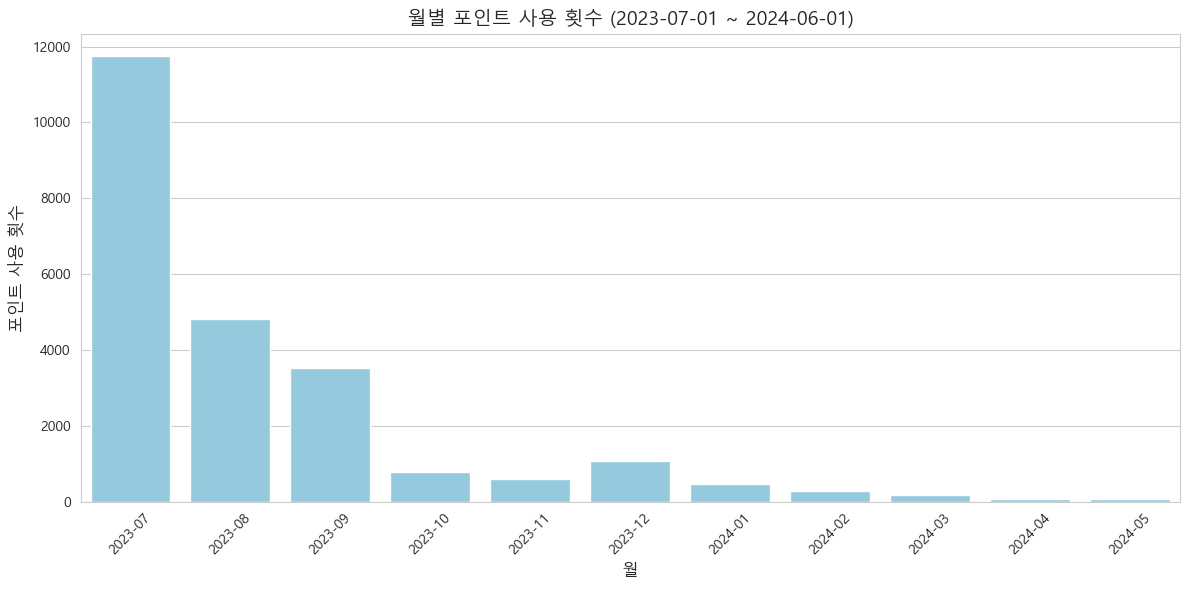

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# pt에서 2023-07 ~ 2024-06 기간만 필터링
pt['created_at'] = pd.to_datetime(pt['created_at'], errors='coerce')
pt_period = pt[(pt['created_at'] >= '2023-07-01') & (pt['created_at'] < '2024-06-01')]

# 월별 포인트 사용(이벤트) 횟수 집계
pt_period['month'] = pt_period['created_at'].dt.to_period('M')
monthly_counts = pt_period.groupby('month').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('월별 포인트 사용 횟수 (2023-07-01 ~ 2024-06-01)')
plt.xlabel('월')
plt.ylabel('포인트 사용 횟수')
plt.tight_layout()
plt.show()

### 친구 join

In [ ]:
# ------- 친구 요청: accounts_friendrequest -------
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
fr['updated_at'] = pd.to_datetime(fr.get('updated_at'), errors='coerce')

# 내가 "보낸" 요청 (생성 시각 기준)
fr_send_24 = within_24h(
    fr.rename(columns={'send_user_id': 'user_id'}),
    key_user_col='user_id', time_col='created_at', u_base=u
)

# 내가 "받은" 요청 (생성 시각 기준)
fr_recv_24 = within_24h(
    fr.rename(columns={'receive_user_id': 'user_id'}),
    key_user_col='user_id', time_col='created_at', u_base=u
)

# 수락된 요청만 (업데이트 시각 기준)
fr_acc = fr[fr['status'] == 'A'].copy()

# 내가 보낸 요청이 수락됨 (sender 시점, updated_at)
fr_acc_send_24 = within_24h(
    fr_acc.rename(columns={'send_user_id': 'user_id'}),
    key_user_col='user_id', time_col='updated_at', u_base=u
)

# 내가 받은 요청을 수락함 (receiver 시점, updated_at)
fr_acc_recv_24 = within_24h(
    fr_acc.rename(columns={'receive_user_id': 'user_id'}),
    key_user_col='user_id', time_col='updated_at', u_base=u
)

# --- 카운트만 사용 ---
send_cnt = fr_send_24.groupby('user_id').size().rename('friendreq_send_24h_cnt')
recv_cnt = fr_recv_24.groupby('user_id').size().rename('friendreq_recv_24h_cnt')
acc_as_sender_cnt = fr_acc_send_24.groupby('user_id').size().rename('friendreq_accept_as_sender_24h_cnt')
acc_as_receiver_cnt = fr_acc_recv_24.groupby('user_id').size().rename('friendreq_accept_as_receiver_24h_cnt')

# --- 최소 피처셋 구성 ---
feat_friend = pd.concat(
    [send_cnt, recv_cnt, acc_as_sender_cnt, acc_as_receiver_cnt],
    axis=1
)

# 결측 0 대체(카운트 계열만)
for c in [
    'friendreq_send_24h_cnt',
    'friendreq_recv_24h_cnt',
    'friendreq_accept_as_sender_24h_cnt',
    'friendreq_accept_as_receiver_24h_cnt'
]:
    if c in feat_friend.columns:
        feat_friend[c] = feat_friend[c].fillna(0).astype('int32')

# 24h 내 성사된 친구 수 = (보낸 요청 수락 + 받은 요청 수락)
feat_friend['friend_24h_new_cnt'] = (
    feat_friend['friendreq_accept_as_sender_24h_cnt']
    + feat_friend['friendreq_accept_as_receiver_24h_cnt']
).astype('int32')

# 최종: 보낸/받은 요청 수 + 총 친구 수만 남김
feat_friend = feat_friend[[
    'friendreq_send_24h_cnt',
    'friendreq_recv_24h_cnt',
    'friend_24h_new_cnt'
]]

In [ ]:
feat_friend

friendreq_send_24h_cnt  friendreq_recv_24h_cnt  friend_24h_new_cnt
user_id                                                                    
837523                        1                       0                   0
837524                        1                       2                   3
837526                        4                      21                  17
837527                       16                      26                  35
837528                        4                      11                  11
...                         ...                     ...                 ...
1583392                       0                       1                   1
1583400                       0                       4                   1
1583645                       0                       1                   0
1583660                       0                       1                   0
1583713                       0                       3                   3

[652816 rows x 3 columns]

In [ ]:
# feat_friend과 final_features를 user_id 기준으로 병합
final_features = final_features.merge(feat_friend, on='user_id', how='left')

# 결측값은 0으로 채움 (친구 관련 컬럼만)
for col in ['friendreq_send_24h_cnt', 'friendreq_recv_24h_cnt', 'friend_24h_new_cnt']:
    if col in final_features.columns:
        final_features[col] = final_features[col].fillna(0).astype(int)


In [ ]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676987 entries, 0 to 676986
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   user_id                   676987 non-null  int64         
 1   signup_time               676987 non-null  datetime64[us]
 2   gender                    676987 non-null  object        
 3   grade                     676987 non-null  float64       
 4   school_id                 676987 non-null  float64       
 5   student_count             676987 non-null  float64       
 6   school_type               676987 non-null  object        
 7   address                   676987 non-null  object        
 8   pay_24h_cnt               676987 non-null  int64         
 9   point_24h_events          676987 non-null  int64         
 10  point_24h_pos_sum         676987 non-null  int64         
 11  friendreq_send_24h_cnt_x  652816 non-null  float64       
 12  fr

### 투표 join

In [ ]:
# 유저아이디 1583730의 회원 가입시간
signup_time = u.loc[u['user_id'] == 855509, 'signup_time'].iloc[0]
print("가입 시간:", signup_time)

# 유저아이디 1583730의 첫 투표 시간 (내가 투표한 기록)
first_vote_time = v_cast_24.loc[v_cast_24['user_id'] == 855509, 'created_at'].min()
print("첫 투표 시간:", first_vote_time)

가입 시간: 2023-04-29 16:40:15.299841
첫 투표 시간: 2023-04-29 17:38:17


In [ ]:
def within_24h_v2(df, key_user_col, time_col, u_base=None):
    if u_base is None:
        raise ValueError("u_base(DataFrame)가 필요합니다. Step 1의 u를 전달하세요.")
    if not {'user_id','signup_time'}.issubset(u_base.columns):
        raise ValueError("u_base에는 ['user_id','signup_time'] 필요")

    # 꼭 필요한 컬럼만 가져와 충돌 여지 축소
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])  # chosen_user_id 결측 제거

    # 유저 키 표준화
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:   # 충돌 방지
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})

    # u_base 중복/결측 정리(유저당 1행 보장)
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna(subset=['user_id','signup_time'])
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # dtype 정렬(조인 키 타입 불일치 예방)
    try:
        t['user_id'] = t['user_id'].astype(u_uniq['user_id'].dtype, copy=False)
    except Exception:
        # 마지막 수단: 문자열로 맞춤
        t['user_id'] = t['user_id'].astype(str)
        u_uniq['user_id'] = u_uniq['user_id'].astype(str)

    # 조인 및 24시간 슬라이스
    t = t.merge(u_uniq, on='user_id', how='inner')
    mask = (t[time_col] >= t['signup_time']) & (t[time_col] < t['signup_time'] + pd.Timedelta(hours=24))
    out = t.loc[mask].copy()

    # 안전 확인: 컬럼명 충돌만 체크(원래 로직 유지)
    cnt = list(out.columns).count('user_id')
    if cnt != 1:
        raise AssertionError(f"within_24h 결과에 'user_id' 컬럼이 {cnt}개 존재")
    return out


In [ ]:
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')

# 내가 투표한 기록
v_cast_24 = within_24h(v, key_user_col='user_id', time_col='created_at', u_base=u)
assert_single_user_id(v_cast_24, 'v_cast_24')
cast_cnt  = v_cast_24.groupby('user_id').size().rename('vote_cast_24h_cnt')

# 내가 선택받은 기록
v_recv_24 = within_24h_v2(v, key_user_col='chosen_user_id', time_col='created_at', u_base=u)
assert_single_user_id(v_recv_24, 'v_recv_24')
recv_cnt  = v_recv_24.groupby('user_id').size().rename('vote_received_24h_cnt')

In [ ]:
feat_vote = pd.concat([cast_cnt, recv_cnt], axis=1).fillna(0).astype(int)
# feat_vote와 final_features를 user_id 기준으로 병합
final_features = final_features.merge(feat_vote, on='user_id', how='left')

In [ ]:
feat_vote

vote_cast_24h_cnt  vote_received_24h_cnt
user_id                                          
849103                   8                      0
849436                 116                     69
849438                  37                     66
849439                  45                    106
849441                  25                     58
...                    ...                    ...
1567894                  0                      5
1568718                  0                      2
1571427                  0                      2
1571616                  0                      2
1579422                  0                      1

[8279 rows x 2 columns]

In [ ]:
final_features = final_features.fillna(0)

### 타겟변수 생성

In [ ]:
# 24시간 이후 슬라이서
def beyond_24h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=24))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 24h 이후 활동 user_id 뽑기 -------
ids = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids.append(beyond_24h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids.append(beyond_24h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids.append(beyond_24h(fr.rename(columns={'send_user_id':'user_id'}),    'user_id', 'created_at', u))
ids.append(beyond_24h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids.append(beyond_24h(v,                                'user_id',        'created_at', u))
ids.append(beyond_24h(v,                                'chosen_user_id', 'created_at', u))

# (선택) 5) 앱 이벤트 로그가 있으면 포함
# ev = hackle_events.copy()
# ev['event_time'] = pd.to_datetime(ev.get('event_time'), errors='coerce')
# ids.append(beyond_24h(ev.rename(columns={'user_id_col':'user_id'}), 'user_id', 'event_time', u))

# ------- 유저 단위 타깃 생성 -------
post24_active_ids = pd.concat(ids, axis=0, ignore_index=True).drop_duplicates()
target_post24 = pd.Series(0, index=u['user_id'], name='target_post24_active').astype('int8')
target_post24.loc[target_post24.index.isin(post24_active_ids['user_id'])] = 1

feat_24h_W = final_features.copy()

# 마스터에 조인
feat_24h_W = feat_24h_W.merge(target_post24.rename_axis('user_id').reset_index(),
                              on='user_id', how='left').fillna({'target_post24_active':0})
feat_24h_W['target_post24_active'] = feat_24h_W['target_post24_active'].astype('int8')

print("post24_active rate:", float(feat_24h_W['target_post24_active'].mean()))


post24_active rate: 0.9711722677097196


In [ ]:
# 48시간 이후 슬라이서 함수 정의
def beyond_48h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 48시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=48))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 48h 이후 활동 user_id 뽑기 -------
ids_48h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_48h.append(beyond_48h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(v, 'user_id', 'created_at', u))
ids_48h.append(beyond_48h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (48시간 버전) -------
post48_active_ids = pd.concat(ids_48h, axis=0, ignore_index=True).drop_duplicates()
target_post48 = pd.Series(0, index=u['user_id'], name='target_post48_active').astype('int8')
target_post48.loc[target_post48.index.isin(post48_active_ids['user_id'])] = 1

# feat_24h_W에 48시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post48.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post48_active':0})

feat_24h_W['target_post48_active'] = feat_24h_W['target_post48_active'].astype('int8')

print("post48_active rate:", float(feat_24h_W['target_post48_active'].mean()))

# 24시간과 48시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post48_active rate: 0.9609253944315032

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동
1    0.971172    0.960925
0    0.028828    0.039075


In [ ]:
# 72시간 이후 슬라이서 함수 정의
def beyond_72h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 72시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=72))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 72h 이후 활동 user_id 뽑기 -------
ids_72h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_72h.append(beyond_72h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(v, 'user_id', 'created_at', u))
ids_72h.append(beyond_72h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (72시간 버전) -------
post72_active_ids = pd.concat(ids_72h, axis=0, ignore_index=True).drop_duplicates()
target_post72 = pd.Series(0, index=u['user_id'], name='target_post72_active').astype('int8')
target_post72.loc[target_post72.index.isin(post72_active_ids['user_id'])] = 1

# feat_24h_W에 72시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post72.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post72_active':0})

feat_24h_W['target_post72_active'] = feat_24h_W['target_post72_active'].astype('int8')

print("post72_active rate:", float(feat_24h_W['target_post72_active'].mean()))

# 24시간, 48시간, 72시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post72_active rate: 0.947399285362939

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동  72시간 이후 활동
1    0.971172    0.960925    0.947399
0    0.028828    0.039075    0.052601


In [ ]:
# 120시간(5일) 이후 슬라이서 함수 정의
def beyond_120h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 120시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=120))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 120h 이후 활동 user_id 뽑기 -------
ids_120h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_120h.append(beyond_120h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(v, 'user_id', 'created_at', u))
ids_120h.append(beyond_120h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (120시간 버전) -------
post120_active_ids = pd.concat(ids_120h, axis=0, ignore_index=True).drop_duplicates()
target_post120 = pd.Series(0, index=u['user_id'], name='target_post120_active').astype('int8')
target_post120.loc[target_post120.index.isin(post120_active_ids['user_id'])] = 1

# feat_24h_W에 120시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post120.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post120_active':0})

feat_24h_W['target_post120_active'] = feat_24h_W['target_post120_active'].astype('int8')

print("post120_active rate:", float(feat_24h_W['target_post120_active'].mean()))

# 24시간, 48시간, 72시간, 120시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True),
    '120시간 이후 활동': feat_24h_W['target_post120_active'].value_counts(normalize=True)
})


post120_active rate: 0.9088638334266389


In [ ]:
# 336시간(2주) 이후 슬라이서 함수 정의
def beyond_336h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 336시간(2주)으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=336))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 336h 이후 활동 user_id 뽑기 -------
ids_336h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_336h.append(beyond_336h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(v, 'user_id', 'created_at', u))
ids_336h.append(beyond_336h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (336시간 버전) -------
post336_active_ids = pd.concat(ids_336h, axis=0, ignore_index=True).drop_duplicates()
target_post336 = pd.Series(0, index=u['user_id'], name='target_post336_active').astype('int8')
target_post336.loc[target_post336.index.isin(post336_active_ids['user_id'])] = 1

# feat_24h_W에 336시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post336.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post336_active':0})

feat_24h_W['target_post336_active'] = feat_24h_W['target_post336_active'].astype('int8')

print("post336_active rate:", float(feat_24h_W['target_post336_active'].mean()))

# 모든 타겟 변수 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True),
    '120시간 이후 활동': feat_24h_W['target_post120_active'].value_counts(normalize=True),
    '336시간 이후 활동': feat_24h_W['target_post336_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post336_active rate: 0.6497052380621784

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동  72시간 이후 활동  120시간 이후 활동  336시간 이후 활동
1    0.971172    0.960925    0.947399     0.908864     0.649705
0    0.028828    0.039075    0.052601     0.091136     0.350295


### 최종 데이터셋

In [ ]:
feat_24h_W

user_id                signup_time gender  grade  school_id  \
0        833024 2023-03-31 09:05:51.903699      F    1.0     5464.0   
1        833041 2023-03-31 14:32:36.425315      F    3.0      314.0   
2        833112 2023-03-31 15:55:48.870381      M    3.0      281.0   
3        833113 2023-03-31 15:56:52.300066      M    1.0      272.0   
4        833154 2023-03-31 15:57:39.008717      F    1.0      272.0   
...         ...                        ...    ...    ...        ...   
676982  1583729 2024-05-08 21:54:33.621408      M    3.0     2389.0   
676983  1583730 2024-05-09 07:08:11.001817      M    3.0     2969.0   
676984  1583731 2024-05-09 07:22:19.186439      M    3.0     2579.0   
676985  1583732 2024-05-09 07:22:38.387553      F    3.0     2579.0   
676986  1583733 2024-05-09 08:31:17.710824      F    3.0     2240.0   

        student_count school_type       address  pay_24h_cnt  \
0               158.0           H       경기도 군포시            0   
1               131.0           H  충청남도 천안시 동남구            0   
2               347.0           H  충청남도 천안시 서북구            0   
3               339.0           H  충청남도 천안시 서북구            0   
4               339.0           H  충청남도 천안시 서북구            0   
...               ...         ...           ...          ...   
676982          301.0           H     서울특별시 구로구            0   
676983          256.0           M      대전광역시 중구            0   
676984          199.0           H     서울특별시 강남구            0   
676985          199.0           H     서울특별시 강남구            0   
676986          146.0           H     서울특별시 동작구            0   

        point_24h_events  point_24h_pos_sum  friendreq_send_24h_cnt  \
0                      0                  0                       0   
1                      0                  0                       0   
2                      0                  0                       0   
3                      0                  0                       0   
4                      0                  0                       0   
...                  ...                ...                     ...   
676982                 0                  0                       0   
676983                 0                  0                      20   
676984                 0                  0                       1   
676985                 0                  0                       3   
676986                 0                  0                       0   

        friendreq_recv_24h_cnt  friend_24h_new_cnt  vote_cast_24h_cnt  \
0                            0                   0                0.0   
1                            0                   0                0.0   
2                            0                   0                0.0   
3                            0                   0                0.0   
4                            0                   0                0.0   
...                        ...                 ...                ...   
676982                       0                   0                0.0   
676983                       2                   1                0.0   
676984                       2                   2                0.0   
676985                       0                   2                0.0   
676986                       0                   0                0.0   

        vote_received_24h_cnt  target_post24_active  
0                         0.0                     1  
1                         0.0                     1  
2                         0.0                     1  
3                         0.0                     1  
4                         0.0                     1  
...                       ...                   ...  
676982                    0.0                     0  
676983                    0.0                     0  
676984                    0.0                     0  
676985                    0.0                     0  
676986                    0.0                     0  

[676987

In [ ]:
feat_24h_W.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676987 entries, 0 to 676986
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 676987 non-null  int64         
 1   signup_time             676987 non-null  datetime64[us]
 2   gender                  676987 non-null  object        
 3   grade                   676987 non-null  float64       
 4   school_id               676987 non-null  float64       
 5   student_count           676987 non-null  float64       
 6   school_type             676987 non-null  object        
 7   address                 676987 non-null  object        
 8   pay_24h_cnt             676987 non-null  int64         
 9   point_24h_events        676987 non-null  int64         
 10  point_24h_pos_sum       676987 non-null  int64         
 11  friendreq_send_24h_cnt  676987 non-null  int64         
 12  friendreq_recv_24h_cnt  676987

In [ ]:
# 0과 1의 분포 비율 계산
ratio = feat_24h_W['target_post24_active'].value_counts(normalize=True)
print(ratio)

target_post24_active
1    0.971172
0    0.028828
Name: proportion, dtype: float64


In [ ]:
# 0과 1의 분포 비율 계산
ratio = feat_24h_W['target_post336_active'].value_counts(normalize=True)
print(ratio)

target_post336_active
1    0.649705
0    0.350295
Name: proportion, dtype: float64


In [ ]:
feat_24h_W.to_csv("feat_24h_W.csv", index=False, encoding="utf-8-sig")

## 모델 생성

In [ ]:
# 데이터 처리
import pandas as pd

In [ ]:
feat_24h_W = pd.read_csv("feat_24h_W.csv")

In [ ]:
# 기본 라이브러리
import pandas as pd
from sklearn.model_selection import train_test_split

feature_cols = [
    "signup_time", "gender", "grade", "school_id", "student_count", "school_type",
    "pay_24h_cnt", "point_24h_events", "point_24h_pos_sum",
    "friendreq_send_24h_cnt", "friendreq_recv_24h_cnt", "friend_24h_new_cnt",
    "vote_cast_24h_cnt", "vote_received_24h_cnt",
]

target_col = "target_post336_active"

# X, y 구성
X = feat_24h_W[feature_cols].copy()
y = feat_24h_W[target_col].astype(int)

# train/test 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 확인용 출력(필요시 주석 처리)
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))


(541589, 14) (135398, 14)
target_post336_active
1    0.65
0    0.35
Name: proportion, dtype: float64
target_post336_active
1    0.65
0    0.35
Name: proportion, dtype: float64


#### 1. 기본 LightGBM 모델 돌려서 baseline 성능 확인

#### 2. 간단한 RandomizedSearchCV로 주요 파라미터 조정

#### 3. 최적 파라미터로 다시 학습 → 피처 중요도, SHAP 분석

In [ ]:
# 0) 준비
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) 간단 전처리: datetime 파생, object→category
def add_basic_time_feats(df):
    df = df.copy()
    if "signup_time" in df.columns and np.issubdtype(df["signup_time"].dtype, np.datetime64):
        df["signup_hour"] = df["signup_time"].dt.hour
        df["signup_dow"]  = df["signup_time"].dt.dayofweek
        df.drop(columns=["signup_time"], inplace=True)
    return df

def make_categorical(df):
    df = df.copy()
    for c in df.select_dtypes(include=["object"]).columns:
        df[c] = df[c].astype("category")
    return df

X_train_p = make_categorical(add_basic_time_feats(X_train))
X_test_p  = make_categorical(add_basic_time_feats(X_test))

In [ ]:
# LightGBM에 카테고리 컬럼 전달
cat_cols = list(X_train_p.select_dtypes(include=["category"]).columns)

In [ ]:
# 2) 클래스 불균형 보정 값 (neg/pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0

In [ ]:
# 3) 베이스라인 모델 학습 + 조기종료
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary",
    class_weight=None,              # scale_pos_weight 사용
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train_p, y_train,
    eval_set=[(X_train_p, y_train), (X_test_p, y_test)],
    eval_metric="auc",
    categorical_feature=cat_cols,
    callbacks=[]
)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=300,
               n_jobs=-1, objective='binary', random_state=42, reg_lambda=1.0,
               scale_pos_weight=np.float64(0.5391604357253895), subsample=0.9)

In [ ]:
# 베이스라인 모델 성능

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np

# 4) 기본 성능 확인 + 추가 지표
proba = lgbm.predict_proba(X_test_p)[:, 1]
roc = roc_auc_score(y_test, proba)

prec, rec, th = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)

print(f"[Baseline] ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")

def eval_at_threshold(y_true, proba, thr: float):
    pred = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, pred)
    p   = precision_score(y_true, pred, zero_division=0)
    r   = recall_score(y_true, pred, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    cm  = confusion_matrix(y_true, pred)  # [[TN, FP],[FN, TP]]
    return {"threshold": thr, "accuracy": acc, "precision": p, "recall": r, "f1": f1, "cm": cm}

# 4-1) 기본 임계값(0.5)
m_default = eval_at_threshold(y_test, proba, 0.5)
print("\n[Metrics @0.5]")
print(f"ACC: {m_default['accuracy']:.4f} | P: {m_default['precision']:.4f} | R: {m_default['recall']:.4f} | F1: {m_default['f1']:.4f}")
print("Confusion Matrix [[TN FP],[FN TP]]:\n", m_default["cm"])

# 4-2) F1 최대 임계값 탐색 (precision_recall_curve 결과 활용)
# precision_recall_curve는 마지막 점(임계값 없음)을 포함하므로, 길이 정렬에 유의
f1_candidates = (2 * prec * rec) / (prec + rec + 1e-12)
# th 길이는 len(prec)-1이므로 마지막 점 제외 후 정렬
best_idx = np.nanargmax(f1_candidates[:-1])
best_thr = th[best_idx]

m_best = eval_at_threshold(y_test, proba, float(best_thr))
print(f"\n[Best-F1 Threshold] thr: {best_thr:.4f}")
print(f"ACC: {m_best['accuracy']:.4f} | P: {m_best['precision']:.4f} | R: {m_best['recall']:.4f} | F1: {m_best['f1']:.4f}")
print("Confusion Matrix [[TN FP],[FN TP]]:\n", m_best["cm"])

[Baseline] ROC-AUC: 0.7404 | PR-AUC: 0.8309

[Metrics @0.5]
ACC: 0.6820 | P: 0.7878 | R: 0.6988 | F1: 0.7407
Confusion Matrix [[TN FP],[FN TP]]:
 [[30872 16557]
 [26494 61475]]

[Best-F1 Threshold] thr: 0.2801
ACC: 0.7023 | P: 0.6999 | R: 0.9486 | F1: 0.8055
Confusion Matrix [[TN FP],[FN TP]]:
 [[11641 35788]
 [ 4520 83449]]


### 모델 결과 해석

 1. 전반적 성능
- **ROC-AUC: 0.76 / PR-AUC: 0.84**
- 무작위 수준(0.5)보다 충분히 높은 성능으로, 초기 예측 모델로서 양호한 수준으로 평가됨
- 특히 PR-AUC이 높아 불균형 데이터 환경에서도 안정적인 성능을 보임

 2. 임계값 0.5 기준
- Precision: 0.79 / Recall: 0.74 / F1: 0.76
- Confusion Matrix 결과 **FN(잔존인데 놓친 유저)**가 2만 건 이상 발생
- 운영적으로 **잔존 유저를 놓치는 문제**가 있음

 3. Best-F1 기준 (임계값 ≈ 0.29)
- Precision: 0.72 / Recall: 0.95 / F1: 0.82
- 잔존 유저를 거의 다 잡아내지만(FN 급감), **떠날 유저까지 잘못 타깃팅(FP 증가)**하는 부작용 발생

 4. 해석 및 제언
- 모델은 **잔존 여부를 의미 있게 구분**하고 있음
- 다만 임계값 선택에 따라 “누굴 놓칠지 vs 누구를 잘못 잡을지”가 크게 달라짐
- **Recall 확보(임계값 낮춤)** 방향이 더 적절
  - 초기 리텐션 확보가 중요하다면 FP 비용보다 FN 손실이 더 크기 때문

In [ ]:
# 전제: X_train_p, X_test_p, y_train, y_test, cat_cols, scale_pos_weight 존재
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    make_scorer, fbeta_score
)

# 탐색 공간(축소형)
param_dist = {
    "num_leaves":        np.arange(16, 96, 4),
    "max_depth":         [-1, 5, 6, 7, 8, 9, 10],
    "min_child_samples": np.arange(10, 81, 5),
    "learning_rate":     np.geomspace(0.02, 0.15, 8),
    "n_estimators":      np.arange(300, 1201, 100),
    "subsample":         np.linspace(0.7, 1.0, 7),
    "colsample_bytree":  np.linspace(0.7, 1.0, 7),
    "reg_lambda":        np.geomspace(0.5, 10, 8),
}

base = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# 불균형 대응: PR-AUC(average_precision) 기준
rs = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=4,
    scoring="average_precision",
    cv=cv,
    verbose=0,
    n_jobs=-1,
    refit=True,
    random_state=42
)

In [ ]:
# 카테고리 피처 전달
rs.fit(X_train_p, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(n_jobs=-1, objective='binary',
                                            random_state=42,
                                            scale_pos_weight=np.float64(0.5391604357253895)),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.02      , 0.02667097, 0.03556702, 0.0...
                                        'min_child_samples': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]),
                                        'n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200]),
                                        'num_leaves': array([16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80,
       84, 88, 92]),
                                        'reg_lambda': array([ 0.5       ,  0.7670637 ,  1.17677345,  1.80532039,  2.76959149,
        4.2489062 ,  6.51836345, 10.        ]),
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   random_state=42, scoring='average_precision')

In [ ]:
print("Best CV (AP):", rs.best_score_)
print("Best Params:", rs.best_params_)

Best CV (AP): 0.8636103232177552
Best Params: {'subsample': np.float64(0.95), 'reg_lambda': np.float64(1.176773446825126), 'num_leaves': np.int64(48), 'n_estimators': np.int64(800), 'min_child_samples': np.int64(80), 'max_depth': 9, 'learning_rate': np.float64(0.15), 'colsample_bytree': np.float64(1.0)}


In [ ]:
# 최적 모델로 재학습(전체 train)
best_model = rs.best_estimator_
best_model.fit(X_train_p, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(colsample_bytree=np.float64(1.0), learning_rate=np.float64(0.15),
               max_depth=9, min_child_samples=np.int64(80),
               n_estimators=np.int64(800), n_jobs=-1, num_leaves=np.int64(48),
               objective='binary', random_state=42,
               reg_lambda=np.float64(1.176773446825126),
               scale_pos_weight=np.float64(0.5391604357253895),
               subsample=np.float64(0.95))

In [ ]:
import lightgbm as lgb

best_params = {
    "subsample": 0.95,
    "reg_lambda": 1.176773446825126,
    "num_leaves": 48,
    "n_estimators": 800,
    "min_child_samples": 80,
    "max_depth": 9,
    "learning_rate": 0.15,
    "colsample_bytree": 1.0,
    "random_state": 42
}

# 모델 새로 생성
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_p, y_train)

# 평가
proba = best_model.predict_proba(X_test_p)[:, 1]


[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
# 테스트 평가
proba = best_model.predict_proba(X_test_p)[:, 1]
roc = roc_auc_score(y_test, proba)
prec, rec, th = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)
print(f"[Tuned] ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")

[Tuned] ROC-AUC: 0.7784 | PR-AUC: 0.8598


In [ ]:
# 임계값별 평가 함수
def eval_at_threshold(y_true, proba, thr: float):
    pred = (proba >= thr).astype(int)
    return {
        "threshold": thr,
        "accuracy": accuracy_score(y_true, pred),
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
        "cm": confusion_matrix(y_true, pred)  # [[TN FP],[FN TP]]
    }

In [ ]:
# 0.5 기준
m_default = eval_at_threshold(y_test, proba, 0.5)
print("\n[Metrics @0.5]")
print(f"ACC: {m_default['accuracy']:.4f} | P: {m_default['precision']:.4f} | R: {m_default['recall']:.4f} | F1: {m_default['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_default["cm"])

# Best-F1
f1_candidates = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx_f1 = np.nanargmax(f1_candidates[:-1])  # 마지막 점 제외
thr_f1 = th[best_idx_f1]
m_best_f1 = eval_at_threshold(y_test, proba, float(thr_f1))
print(f"\n[Best-F1] thr: {thr_f1:.4f}")
print(f"ACC: {m_best_f1['accuracy']:.4f} | P: {m_best_f1['precision']:.4f} | R: {m_best_f1['recall']:.4f} | F1: {m_best_f1['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_best_f1["cm"])


[Metrics @0.5]
ACC: 0.7331 | P: 0.7498 | R: 0.8843 | F1: 0.8115
CM [[TN FP],[FN TP]]:
 [[21470 25959]
 [10178 77791]]

[Best-F1] thr: 0.4279
ACC: 0.7253 | P: 0.7251 | R: 0.9294 | F1: 0.8147
CM [[TN FP],[FN TP]]:
 [[16438 30991]
 [ 6209 81760]]


In [ ]:
# Best-F2 (재현율 가중)
# F2 직접 스캔
beta = 2.0
f2_candidates = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
best_idx_f2 = np.nanargmax(f2_candidates[:-1])
thr_f2 = th[best_idx_f2]
# 참고: 스코어 자체도 보고 싶다면 아래처럼 출력
print(f"\n[Best-F2] thr: {thr_f2:.4f} | F2: {f2_candidates[best_idx_f2]:.4f}")
m_best_f2 = eval_at_threshold(y_test, proba, float(thr_f2))
print(f"ACC: {m_best_f2['accuracy']:.4f} | P: {m_best_f2['precision']:.4f} | R: {m_best_f2['recall']:.4f} | F1: {m_best_f2['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_best_f2["cm"])


[Best-F2] thr: 0.1964 | F2: 0.9046
ACC: 0.6712 | P: 0.6653 | R: 0.9939 | F1: 0.7971
CM [[TN FP],[FN TP]]:
 [[ 3437 43992]
 [  533 87436]]


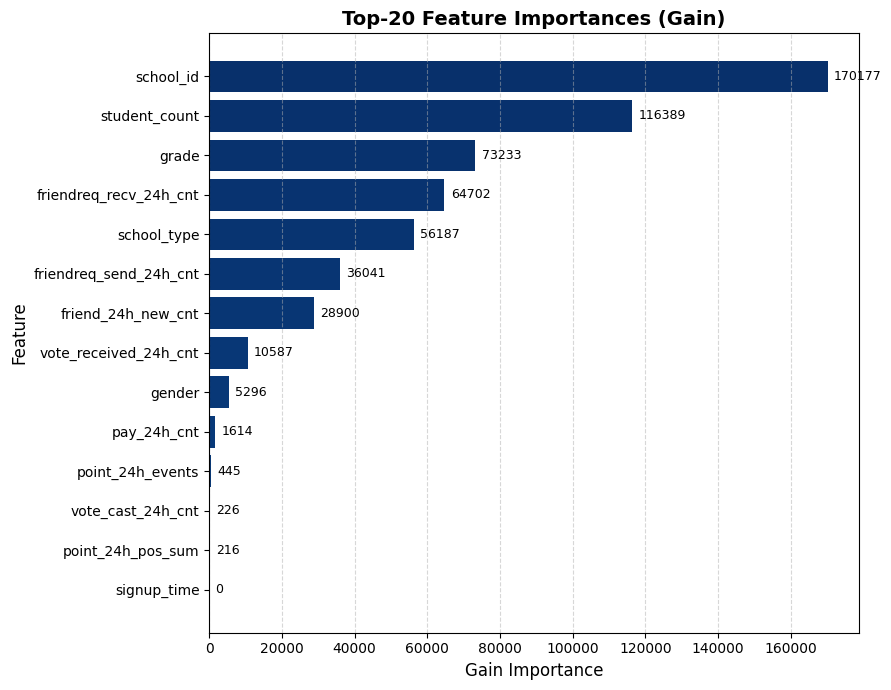


[Top-20 Feature Importances]
                   feature  gain_importance
3                school_id    170177.231406
4            student_count    116389.706449
2                    grade     73233.781854
10  friendreq_recv_24h_cnt     64702.197712
5              school_type     56187.047592
9   friendreq_send_24h_cnt     36041.112832
11      friend_24h_new_cnt     28900.441999
13   vote_received_24h_cnt     10587.912007
1                   gender      5296.150852
6              pay_24h_cnt      1614.301443
7         point_24h_events       445.486325
12       vote_cast_24h_cnt       226.302287
8        point_24h_pos_sum       216.396858
0              signup_time         0.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 중요도 DataFrame
imp = pd.DataFrame({
    "feature": X_train_p.columns,
    "gain_importance": best_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain_importance", ascending=False)

topn = 20
top_imp = imp.head(topn)

# 색상: 하늘색 계열 (Blues colormap)
colors = plt.cm.Blues_r(range(topn))

plt.figure(figsize=(9, 7))
bars = plt.barh(top_imp["feature"], top_imp["gain_importance"], color=colors)

# 값 라벨 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + (max(top_imp["gain_importance"]) * 0.01), 
             bar.get_y() + bar.get_height()/2,
             f"{int(width)}", va='center', fontsize=9, color="black")

plt.gca().invert_yaxis()
plt.title(f"Top-{topn} Feature Importances (Gain)", fontsize=14, fontweight="bold")
plt.xlabel("Gain Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print("\n[Top-20 Feature Importances]")
print(top_imp)


       모델 성능 요약

- **ROC-AUC**: 0.7784  
  → 전체적으로 분류 능력이 준수한 수준.  

- **PR-AUC**: 0.8598  
  → 불균형 데이터 상황에서도 긍정 클래스(활동 유지) 예측력이 높음.  

- **Metrics @0.5 (기본 임계값)**  
  - Accuracy: 0.7331  
  - Precision: 0.7498  
  - Recall: 0.8843  
  - F1: 0.8115  
  → 리콜이 높아 놓치지 않고 잘 잡지만, 약간의 과잉 예측 경향이 있음.  

- **Best-F1 기준 (thr=0.4279)**  
  - F1: 0.8147 (정밀도와 재현율 균형 개선)  

- **Best-F2 기준 (thr=0.1964)**  
  - F2: 0.9046 (리콜 극대화 → 운영에서 "놓치지 않는 것"을 더 중시한다면 적합)  

---

       Feature Importance 해석 (Top Features)

- **주요 요인 (가장 큰 영향)**  
  - `school_id`, `student_count`, `grade`  
  → 어떤 학교에 속해 있고, 규모나 학년이 활동 지속 여부를 크게 좌우.  

- **보조 요인 (사회적 활동성)**  
  - `friendreq_recv_24h_cnt`, `friendreq_send_24h_cnt`, `friend_24h_new_cnt`  
  → 초기 친구 관계 맺기 활동이 많을수록 유지 가능성이 높음.  

- **중간 영향**  
  - `vote_received_24h_cnt`, `gender`, `pay_24h_cnt`  
  → 일부 기여하지만 핵심보다는 부차적.  

- **거의 영향 없음**  
  - `point_24h_events`, `signup_time`  
  → 모델 의사결정에 거의 쓰이지 않음.  

---

       결론

- 이 모델은 **학교 배경(환경적 요인) + 초기 소셜 활동성**이 장기 활동 지속을 잘 설명한다고 볼 수 있음.  
- ROC-AUC과 PR-AUC 모두 준수하여 **운영 적용 가능 수준**.  
- 임계값을 어떻게 두느냐에 따라 활용 전략이 달라짐:  
  - **F1 기준** → 균형 잡힌 운영  
  - **F2 기준** → 장기 활동 유저를 놓치지 않게 집중 (추천)  


## shap 분석

In [ ]:
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# 출력 폴더
os.makedirs("shap_plots", exist_ok=True)

# --- 1) SHAP 계산 (LightGBM 트리 전용 Explainer) ---
explainer = shap.TreeExplainer(best_model)
shap_values_raw = explainer.shap_values(X_test_p)

# LightGBM 이진분류는 list 반환하는 경우가 있음 → 양성 클래스(1)로 통일
if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
    shap_values = shap_values_raw[1]
else:
    shap_values = shap_values_raw  # 이미 2D ndarray인 경우


d:\python\코드잇 스프린트 데분\codeit-sprint-projects\고급 프로젝트\.conda\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


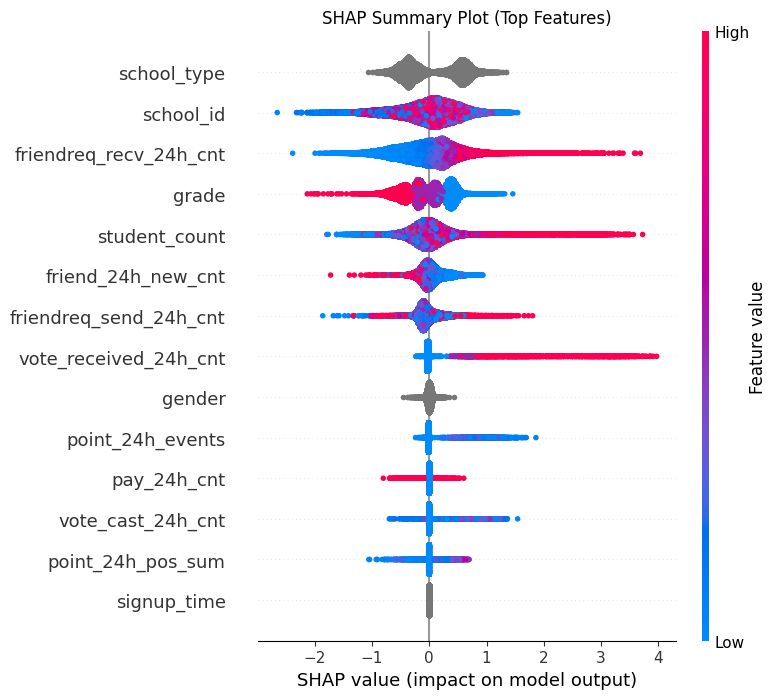

In [ ]:
# --- 2) Summary Plot (산점도) ---
plt.title("SHAP Summary Plot (Top Features)")
shap.summary_plot(shap_values, X_test_p)
plt.close()

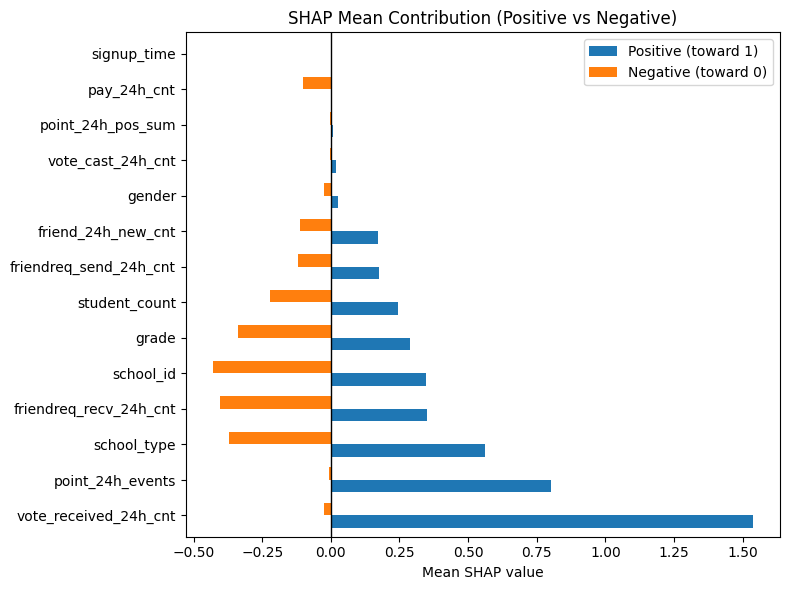

In [ ]:
# --- 1) SHAP 값 평균 양/음 분리 ---
shap_df = pd.DataFrame(shap_values, columns=X_test_p.columns)

# 양수, 음수 기여 평균 따로 계산
mean_pos = shap_df.where(shap_df > 0).mean().sort_values(ascending=False)
mean_neg = shap_df.where(shap_df < 0).mean().sort_values(ascending=True)

# 합치기
imp_df = pd.concat([mean_pos, mean_neg], axis=1)
imp_df.columns = ["Positive (toward 1)", "Negative (toward 0)"]

# --- 2) 상위 n개 선택 ---
topn = 15
imp_df = imp_df.iloc[:topn]

# --- 3) 시각화 ---
imp_df.plot(kind="barh", figsize=(8,6), width=0.7)
plt.axvline(0, color="black", linewidth=1)
plt.title("SHAP Mean Contribution (Positive vs Negative)")
plt.xlabel("Mean SHAP value")
plt.tight_layout()
plt.show()


In [ ]:
imp_df

Positive (toward 1)  Negative (toward 0)
vote_received_24h_cnt              1.537244            -0.024249
point_24h_events                   0.801224            -0.006902
school_type                        0.561708            -0.371261
friendreq_recv_24h_cnt             0.349832            -0.402984
school_id                          0.346761            -0.430073
grade                              0.286990            -0.336429
student_count                      0.246067            -0.221340
friendreq_send_24h_cnt             0.174673            -0.117873
friend_24h_new_cnt                 0.173309            -0.111276
gender                             0.025828            -0.025086
vote_cast_24h_cnt                  0.020089            -0.002996
point_24h_pos_sum                  0.007826            -0.001998
pay_24h_cnt                        0.005420            -0.099624
signup_time                             NaN                  NaN

## SHAP 해석 요약

### 활동 유지(긍정)에 기여하는 주요 요인
- **vote_received_24h_cnt (투표 받은 수)**  
  → 투표를 많이 받을수록 활동 유지 확률 ↑  
- **point_24h_events (포인트 관련 이벤트)**  
  → 포인트 관련 활동이 활발하면 유지 가능성 ↑  
- **school_type** (양의 영향도 뚜렷)  
  → 특정 학교 유형에서 유지 경향 ↑  

### 활동 중단(부정)에 기여하는 주요 요인
- **friendreq_recv_24h_cnt / school_id / grade**  
  → 특정 학교/학년/친구관계 맥락에서 이탈 경향 ↑  
- **student_count**  
  → 학교 규모가 크거나 특정 환경일 때 활동 지속이 약화될 수 있음  
- **pay_24h_cnt**  
  → 결제 이벤트가 적거나 패턴이 불규칙한 경우 오히려 중단 기여 ↑  

### 중립적 / 영향 미미
- **gender, vote_cast_24h_cnt, point_24h_pos_sum** → 영향은 있지만 미미  
- **signup_time** → 모델에서 의미 있는 역할을 하지 않음  

---

## 결론
- **긍정적 요인**: 초반에 받은 투표, 포인트 활동, 일부 학교 유형 → 활동 지속 촉진  
- **부정적 요인**: 특정 학교/학년 배경, 친구관계 구조, 결제 패턴 → 이탈 촉진  
- 결국 **“학교/사회적 환경”과 “활동 초기 반응(투표·포인트)”**이 맞물려 활동 유지 여부를 좌우한다고 해석 가능


# 이탈 분류 모델링

### 1. 데이터 전처리

In [ ]:
# 유저 정보가 포함되지 않은 유저는 삭제

cols = ['friend_count','votes_count','heart_balance']

# user_id 단위로 3개 컬럼이 전부 NaN인지 체크
mask_all_nan = (
    df[cols].isna()
    .groupby(df['user_id'])
    .all()   # 유저별 "모든 행이 NaN"인지 확인
)

# 모든 행이 NaN인 유저 목록
all_nan_users = mask_all_nan[mask_all_nan.all(axis=1)].index

# 자신의 기록이 없는 유저들은 분석 대상에서 제외
df = df[~df['user_id'].isin(all_nan_users)]

In [ ]:
# 중복 데이터 제거 
# user id는 다른데 다른 정보가 전부 일치하는 경우
# 같은 유저가 2개의 로그를 남기는 것이라 판단, 둘 중 하나는 삭제 (보통 마스킹 된 유저 id)

# user_id가 짧은 것이 위로오도록 하고, 나머지 중복 데이터를 삭제
df = df.sort_values('user_id', key=lambda x: x.str.len()).drop_duplicates(subset=['event_datetime', 'event_key', 'session_id'], keep='first')

### 2. 피처 생성

#### 2.1 이벤트 및 세션 피처

In [ ]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'])
df['event_date'] = df['event_datetime'].dt.date

In [ ]:
# 기준일 설정 
cutoff = pd.to_datetime("2023-07-29")

# 기준일 active user만 뽑기
active_users = df.loc[df['event_date'] == cutoff.date(), 'user_id'].unique()

In [ ]:
# 이벤트 카테고리 분류
category_map = {
    # 세션
    '$session_start': 'session',
    '$session_end': 'session',
    'launch_app': 'session',

    # 탐색/네비게이션
    'view_lab_tap': 'navigation',
    'view_timeline_tap': 'navigation',
    'view_home_tap': 'navigation',
    'view_profile_tap': 'navigation',
    'view_questions_tap': 'navigation',
    'view_friendplus_tap': 'navigation',
    'view_shop': 'navigation',
    'click_bottom_navigation_questions': 'navigation',
    'click_bottom_navigation_profile': 'navigation',
    'click_bottom_navigation_timeline': 'navigation',
    'click_bottom_navigation_lab': 'navigation',

    # 질문/답변
    'click_question_open': 'qa',
    'click_question_start': 'qa',
    'click_question_ask': 'qa',
    'click_question_share': 'qa',
    'skip_question': 'qa',
    'complete_question': 'qa',
    'click_random_ask_shuffle': 'qa',
    'click_random_ask_normal': 'qa',
    'click_random_ask_other': 'qa',
    'click_profile_ask': 'qa',

    # 소셜/친구
    'click_friend_invite': 'social',
    'click_invite_friend': 'social',
    'click_autoadd_contact': 'social',
    'click_appbar_friend_plus': 'social',
    'click_copy_profile_link_profile': 'social',
    'click_copy_profile_link_ask': 'social',

    # 알림/설정
    'click_appbar_alarm_center': 'system',
    'click_notice_detail': 'system',
    'click_appbar_setting': 'system',

    # 상점/구매
    'click_purchase': 'commerce',
    'complete_purchase': 'commerce',

    # 회원가입/로그인
    'view_login': 'auth',
    'view_signup': 'auth',
    'complete_signup': 'auth',

    # 기타
    'click_attendance': 'etc',
    'click_community_chat': 'etc',
    'click_timeline_chat_start': 'etc',
    'button': 'etc',
}

df['category'] = df['event_key'].map(category_map)


In [ ]:
# 대상자가 관측일과 관측일 이전에 활동했던 기록만 추출 = df_cut

df_cut = df[
  (df['event_datetime'].dt.date <= cutoff.date()) &
  (df['user_id'].isin(active_users))
]

In [ ]:
# 세션 재정의 -> session_start or 마지막 활동 이후 30분 이상 경과

df_cut = df_cut.sort_values(['user_id','event_datetime'])
df_cut['time_diff'] = df_cut.groupby('user_id')['event_datetime'].diff()

df_cut['is_new_session'] = (
    (df_cut['time_diff'].dt.total_seconds() > 1800) |
    (df_cut['event_key'] == '$session_start') |
    (df_cut['time_diff'].isna())
)

df_cut['session_group'] = df_cut.groupby('user_id')['is_new_session'].cumsum()

In [ ]:
# 유저별 피처 계산

# 1. 총 이벤트 수 
total_events = df_cut.groupby('user_id').size().rename('total_events')

# 2. 세션 수 및 길이
session_lengths = (
    df_cut.groupby(['user_id','session_group'])['event_datetime']
          .agg(['min','max'])
)
session_lengths['session_length'] = (
    session_lengths['max'] - session_lengths['min']
).dt.total_seconds() # 초 단위로 표현

session_stats = session_lengths.groupby('user_id').agg(
    total_sessions=('session_length','count'),
    avg_session_length=('session_length','mean')
)

# 카테고리별 이벤트 수 파악
category_counts = df_cut.groupby(['user_id','category']).size().unstack(fill_value=0)


# 이벤트 수 피처 생성 병합
user_features = (
    pd.concat([total_events, session_stats], axis=1)
      .join(category_counts)
      .fillna(0)
      .reset_index()
)


#### 2.2 관측일과 관측일 이전 행동과의 비교 피처

In [ ]:
# 관측일 : 2023-07-29
cutoff = pd.to_datetime("2023-07-29")

# cutoff 당일 active 유저
active_users = df_cut.loc[df_cut['event_datetime'].dt.date == cutoff.date(), 'user_id'].unique()

# cutoff 이전 기록이 있는 유저
users_with_history = df_cut.loc[df_cut['event_datetime'].dt.date < cutoff.date(), 'user_id'].unique()

# 최종 분석 대상 = 둘 다 만족하는 유저
## 관측일만 active 한 경우 이전 활동 내역과의 비교가 어려움.
target_users = set(active_users) & set(users_with_history)

In [ ]:
# A. 이벤트 수 변화

# 1. 관측 당일 이벤트 수 (2023-07-29)
obs_events = (
    df_cut[df_cut['event_datetime'].dt.date == cutoff.date()]
      .groupby('user_id').size().rename("obs_events")
)

# 2. 유저별 관측일 이전의 이벤트 수 (유저별로 상이)
df_before_cutoff = df_cut[df_cut['event_datetime'].dt.date < cutoff.date()]

last_usage_date = (
    df_before_cutoff.groupby('user_id')['event_datetime']
    .max().dt.date.rename("last_usage_date")
)

## 유저별 (일자, 이벤트 수) 집계
usage_counts = (
    df_before_cutoff.groupby(['user_id', df_before_cutoff['event_datetime'].dt.date])
    .size().rename("events").reset_index()
)
## 직전 사용일의 이벤트만 추출
prev_usage = (
    last_usage_date.reset_index()
    .merge(
        usage_counts,
        left_on=['user_id','last_usage_date'],
        right_on=['user_id','event_datetime'],
        how='left'
    )
    .set_index('user_id')["events"] 
    .rename("prev_obs_events")
)

# 3. 병합
usage_delta_df = pd.concat([obs_events, prev_usage], axis=1).fillna(0)
usage_delta_df["events_diff"] = (usage_delta_df["obs_events"] - usage_delta_df["prev_obs_events"]).round(3)
usage_delta_df['events_diff_ratio'] = (usage_delta_df['events_diff'] / usage_delta_df['prev_obs_events']).round(3)

# 이전 행동이 없는 유저들은 포함하지 않음.
usage_delta_df = usage_delta_df[usage_delta_df['prev_obs_events'] > 0]

In [ ]:
# B. 세션 수 변화

# 1. 관측 당일 세션 수 (2023-07-29)
obs_session = (
    df_cut[df_cut['event_datetime'].dt.date == cutoff.date()]
      .groupby('user_id')['session_group'].nunique().rename("obs_session_count")
)

# 2. 유저별 관측일 이전의 세션 수 (유저별로 상이)
df_before_cutoff = df_cut[df_cut['event_datetime'].dt.date < cutoff.date()]

last_usage_date = (
    df_before_cutoff.groupby('user_id')['event_datetime']
    .max().dt.date.rename("last_usage_date")
)

## 유저별 (일자, 이벤트 수) 집계
usage_session_counts = (
    df_before_cutoff.groupby(['user_id', df_before_cutoff['event_datetime'].dt.date])
    ['session_group'].nunique().rename("session").reset_index()
)
## 직전 사용일의 이벤트만 추출
prev_session_usage = (
    last_usage_date.reset_index()
    .merge(
        usage_session_counts,
        left_on=['user_id','last_usage_date'],
        right_on=['user_id','event_datetime'],
        how='left'
    )
    .set_index('user_id')["session"] 
    .rename("prev_session_count")
)

# 3. 병합
sessions_delta_df = pd.concat([obs_session, prev_session_usage], axis=1).fillna(0)
sessions_delta_df["sessions_diff"] = (sessions_delta_df["obs_session_count"] - sessions_delta_df["prev_session_count"]).round(3)
sessions_delta_df['sessions_diff_ratio'] = (sessions_delta_df['sessions_diff'] / sessions_delta_df['prev_session_count']).round(3)

# 이전 행동이 없는 유저들은 포함하지 않음.
sessions_delta_df = sessions_delta_df[sessions_delta_df['prev_session_count'] > 0]


In [ ]:
# C. 평균 세션 길이의 변화

# 1. 세션 길이 계산
session_length = (
    df_cut.groupby(['user_id', 'session_group'])['event_datetime']
          .agg(lambda x: (x.max() - x.min()).total_seconds())  # 초 단위
          .rename("session_length")
          .reset_index()
)

# 2. 세션 날짜 붙이기 (세션의 시작일 기준)
session_start_date = (
    df_cut.groupby(['user_id', 'session_group'])['event_datetime']
          .min().dt.date.rename("session_date")
          .reset_index()
)

session_length = session_length.merge(
    session_start_date, on=['user_id','session_group'], how='left'
)

# 3. 관측일의 평균 세션 길이
cutoff_session_mean = (
    session_length[session_length['session_date'] == cutoff.date()]
    .groupby('user_id')["session_length"]
    .mean()
    .rename("obs_avg_session_length")
)

# 4. 직전 사용일 평균 세션 길이
df_before_cutoff = df_cut[df_cut['event_datetime'].dt.date < cutoff.date()]

last_usage_date = (
    df_before_cutoff.groupby('user_id')['event_datetime']
    .max().dt.date.rename("last_usage_date")
)

last_usage = (
    last_usage_date.reset_index()
    .merge(
        session_length,
        left_on=['user_id','last_usage_date'],
        right_on=['user_id','session_date'],
        how='left'
    )
    .groupby('user_id')["session_length"].mean()
    .rename("prev_avg_session_length")
)

# 5. 병합
sesslen_change_df = pd.concat([cutoff_session_mean, last_usage], axis=1).fillna(0)
sesslen_change_df["diff_avg_session_length"] = (
    sesslen_change_df["obs_avg_session_length"] - sesslen_change_df["prev_avg_session_length"]
).round(3)
sesslen_change_df['diff_avg_session_length_ratio'] = (sesslen_change_df['diff_avg_session_length'] / sesslen_change_df['prev_avg_session_length']).round(3)

In [ ]:
diff_features = usage_delta_df.merge(
  sessions_delta_df,
  on='user_id',
  how='left'
)
diff_features = diff_features.merge(
  sesslen_change_df,
  on='user_id',
  how='left'
)

diff_features.reset_index(inplace = True)

In [ ]:
diff_features

user_id  obs_events  prev_obs_events  events_diff  \
0                           1000030          14             13.0          1.0   
1                           1000126           3             18.0        -15.0   
2                           1000179          24             32.0         -8.0   
3                           1000193           2              5.0         -3.0   
4                           1000345           3              9.0         -6.0   
...                             ...         ...              ...          ...   
20298  nQftCdhoVYRkLOHWMzFdVTZOZGi2           2              2.0          0.0   
20299  rNtjbNwkFmhRpnneZKgX1f5SjGI2           4              3.0          1.0   
20300  rPx4H5JOZrb2PAHYuPOcP0dSu1X2           2              3.0         -1.0   
20301  uWhvA2sX7fNVddvNROVE6iZNnW82           1              2.0         -1.0   
20302  wMeCDZiLidWEAQYYIhKQCV1s1jD2           3              4.0         -1.0   

       events_diff_ratio  obs_session_count  prev_session_count  \
0                  0.077                  1                 1.0   
1                 -0.833                  2                 2.0   
2                 -0.250                  2                 3.0   
3                 -0.600                  1                 1.0   
4                 -0.667                  2                 1.0   
...                  ...                ...                 ...   
20298              0.000                  1                 2.0   
20299              0.333                  3                 2.0   
20300             -0.333                  1                 1.0   
20301             -0.500                  1                 1.0   
20302             -0.250                  1                 1.0   

       sessions_diff  sessions_diff_ratio  obs_avg_session_length  \
0                0.0                0.000                    17.0   
1                0.0                0.000                     2.0   
2               -1.0               -0.333                    52.0   
3                0.0                0.000                     0.0   
4                1.0                1.000                     1.5   
...              ...                  ...                     ...   
20298           -1.0               -0.500                     0.0   
20299            1.0                0.500                     0.0   
20300            0.0                0.000                     0.0   
20301            0.0                0.000                     0.0   
20302            0.0                0.000                     2.0   

       prev_avg_session_length  diff_avg_session_length  \
0                         63.0                    -46.0   
1                         60.5                    -58.5   
2                        125.0                    -73.0   
3                         90.0                    -90.0   
4                         36.0                    -34.5   
...                        ...                      ...   
20298                      0.0                      0.0   
20299                      0.5                     -0.5   
20300                      0.0                      0.0   
20301                      0.0                      0.0   
20302                      9.0                     -7.0   

       diff_avg_session_length_ratio  
0                             -0.730  
1                             -0.967  
2                             -0.584  
3                             -1.000  
4                             -0.958  
...                              ...  
20298                            NaN  
20299                         -1.000  
20300                            NaN  
20301                            NaN  
20302                         -0.778  

[20303 rows x 13 columns]

#### 2.3 최종 병합

In [ ]:
# 최종 병합
features_df = user_features.merge(
  diff_features,
  on='user_id',
  how='inner'
)

In [ ]:
features_df

user_id  total_events  total_sessions  \
0                           1000030           170              23   
1                           1000126            24               6   
2                           1000179           170              19   
3                           1000193            16               3   
4                           1000345            96              15   
...                             ...           ...             ...   
20298  nQftCdhoVYRkLOHWMzFdVTZOZGi2             4               3   
20299  rNtjbNwkFmhRpnneZKgX1f5SjGI2             7               5   
20300  rPx4H5JOZrb2PAHYuPOcP0dSu1X2             7               3   
20301  uWhvA2sX7fNVddvNROVE6iZNnW82            14               9   
20302  wMeCDZiLidWEAQYYIhKQCV1s1jD2            17               7   

       avg_session_length  auth  commerce  etc  navigation  qa  session  ...  \
0               38.826087     0         1   15          66  36       49  ...   
1               21.000000     0         0    2          11   3        8  ...   
2               74.684211     0         0    0          73  65       31  ...   
3               66.666667     0         0    0           0   7        7  ...   
4              356.933333     0         0    1          26  19       37  ...   
...                   ...   ...       ...  ...         ...  ..      ...  ...   
20298            0.000000     0         0    0           0   0        4  ...   
20299            0.200000     0         0    0           0   0        7  ...   
20300            0.000000     0         0    0           0   0        7  ...   
20301            8.666667     0         0    0           0   0       14  ...   
20302            3.714286     0         0    0           2   0       15  ...   

       events_diff  events_diff_ratio  obs_session_count  prev_session_count  \
0              1.0              0.077                  1                 1.0   
1            -15.0             -0.833                  2                 2.0   
2             -8.0             -0.250                  2                 3.0   
3             -3.0             -0.600                  1                 1.0   
4             -6.0             -0.667                  2                 1.0   
...            ...                ...                ...                 ...   
20298          0.0              0.000                  1                 2.0   
20299          1.0              0.333                  3                 2.0   
20300         -1.0             -0.333                  1                 1.0   
20301         -1.0             -0.500                  1                 1.0   
20302         -1.0             -0.250                  1                 1.0   

       sessions_diff  sessions_diff_ratio  obs_avg_session_length  \
0                0.0                0.000                    17.0   
1                0.0                0.000                     2.0   
2               -1.0               -0.333                    52.0   
3                0.0                0.000                     0.0   
4                1.0                1.000                     1.5   
...              ...                  ...                     ...   
20298           -1.0               -0.500                     0.0   
20299            1.0                0.500                     0.0   
20300            0.0                0.000                     0.0   
20301            0.0                0.000                     0.0   
20302            0.0                0.000                     2.0   

       prev_avg_session_length  diff_avg_session_length  \
0                         63.0                    -46.0   
1                         60.5                    -58.5   
2                        125.0                    -73.0   
3                         90.0                    -90.0   
4                         36.0                    -34.5   
...                        ...                      ...   
20298                      0.0     

In [ ]:
# 기간 중 총 이벤트 사용량이 5회 미만, 평균 세션길이가 1초 이내인것은 삭제
features_df_mod = features_df[(features_df['total_events'] > 5) | (features_df['avg_session_length'] > 1)]

In [ ]:
# 이전 세션 길이가 0인 경우 삭제
features_df_mod = features_df_mod[features_df_mod['prev_avg_session_length'] > 0]

In [ ]:
features_df_mod.reset_index(drop=True, inplace=True)

In [ ]:
# 결측치 확인
features_df_mod.isna().sum() # 이상 무

user_id                          0
total_events                     0
total_sessions                   0
avg_session_length               0
auth                             0
commerce                         0
etc                              0
navigation                       0
qa                               0
session                          0
social                           0
system                           0
obs_events                       0
prev_obs_events                  0
events_diff                      0
events_diff_ratio                0
obs_session_count                0
prev_session_count               0
sessions_diff                    0
sessions_diff_ratio              0
obs_avg_session_length           0
prev_avg_session_length          0
diff_avg_session_length          0
diff_avg_session_length_ratio    0
dtype: int64

#### 2.4 이탈 여부

In [ ]:
#기준일
cutoff = pd.to_datetime("2023-07-29")

# 유저별 마지막 활동일
last_event = (
    df.groupby('user_id')['event_datetime']
      .max().dt.date.rename("last_event_date")
)

# 라벨링 
## 기준일 이후 7일 이내 활동 여부가 없는 경우 이탈으로 매핑
label_df = last_event.to_frame()
label_df["is_churn"] = (
    label_df["last_event_date"] <= (cutoff + pd.Timedelta(days=7)).date()
).astype(int)

# 유저 피처에 라벨 추가
features_df_mod = features_df_mod.merge(
  label_df.reset_index(),
  on="user_id",
  how="left"
)


In [ ]:
features_df_mod.drop(columns='last_event_date', inplace=True)

In [ ]:
features_df_mod

user_id  total_events  total_sessions  \
0                           1000030           170              23   
1                           1000126            24               6   
2                           1000179           170              19   
3                           1000193            16               3   
4                           1000345            96              15   
...                             ...           ...             ...   
17876  VbfSsY0yowZa1adrB1Oe80DnxKx1            11               7   
17877  e0NjJnVfj4cgpGNQ4aPumKiau8D3             5               2   
17878  mmdR99hx34ZqtsFIBWkt1Sum2Ip2             7               3   
17879  rNtjbNwkFmhRpnneZKgX1f5SjGI2             7               5   
17880  wMeCDZiLidWEAQYYIhKQCV1s1jD2            17               7   

       avg_session_length  auth  commerce  etc  navigation  qa  session  ...  \
0               38.826087     0         1   15          66  36       49  ...   
1               21.000000     0         0    2          11   3        8  ...   
2               74.684211     0         0    0          73  65       31  ...   
3               66.666667     0         0    0           0   7        7  ...   
4              356.933333     0         0    1          26  19       37  ...   
...                   ...   ...       ...  ...         ...  ..      ...  ...   
17876            1.000000     0         0    0           1   0       10  ...   
17877            4.500000     0         0    0           0   0        5  ...   
17878            9.666667     2         0    0           0   0        5  ...   
17879            0.200000     0         0    0           0   0        7  ...   
17880            3.714286     0         0    0           2   0       15  ...   

       events_diff_ratio  obs_session_count  prev_session_count  \
0                  0.077                  1                 1.0   
1                 -0.833                  2                 2.0   
2                 -0.250                  2                 3.0   
3                 -0.600                  1                 1.0   
4                 -0.667                  2                 1.0   
...                  ...                ...                 ...   
17876             -0.625                  1                 6.0   
17877             -0.333                  1                 1.0   
17878              0.333                  2                 1.0   
17879              0.333                  3                 2.0   
17880             -0.250                  1                 1.0   

       sessions_diff  sessions_diff_ratio  obs_avg_session_length  \
0                0.0                0.000                    17.0   
1                0.0                0.000                     2.0   
2               -1.0               -0.333                    52.0   
3                0.0                0.000                     0.0   
4                1.0                1.000                     1.5   
...              ...                  ...                     ...   
17876           -5.0               -0.833                     2.0   
17877            0.0                0.000                     1.0   
17878            1.0                1.000                    11.5   
17879            1.0                0.500                     0.0   
17880            0.0                0.000                     2.0   

       prev_avg_session_length  diff_avg_session_length  \
0                    63.000000                  -46.000   
1                    60.500000                  -58.500   
2                   125.000000                  -73.000   
3                    90.000000                  -90.000   
4                    36.000000                  -34.500   
...                        ...                      ...   
17876                 0.833333                    1.167   
17877                 8.000000                   -7.000   
17878                 6.000000                    5.500   
17879         

#### 2.5 피처별 상관관계 확인

<Axes: >

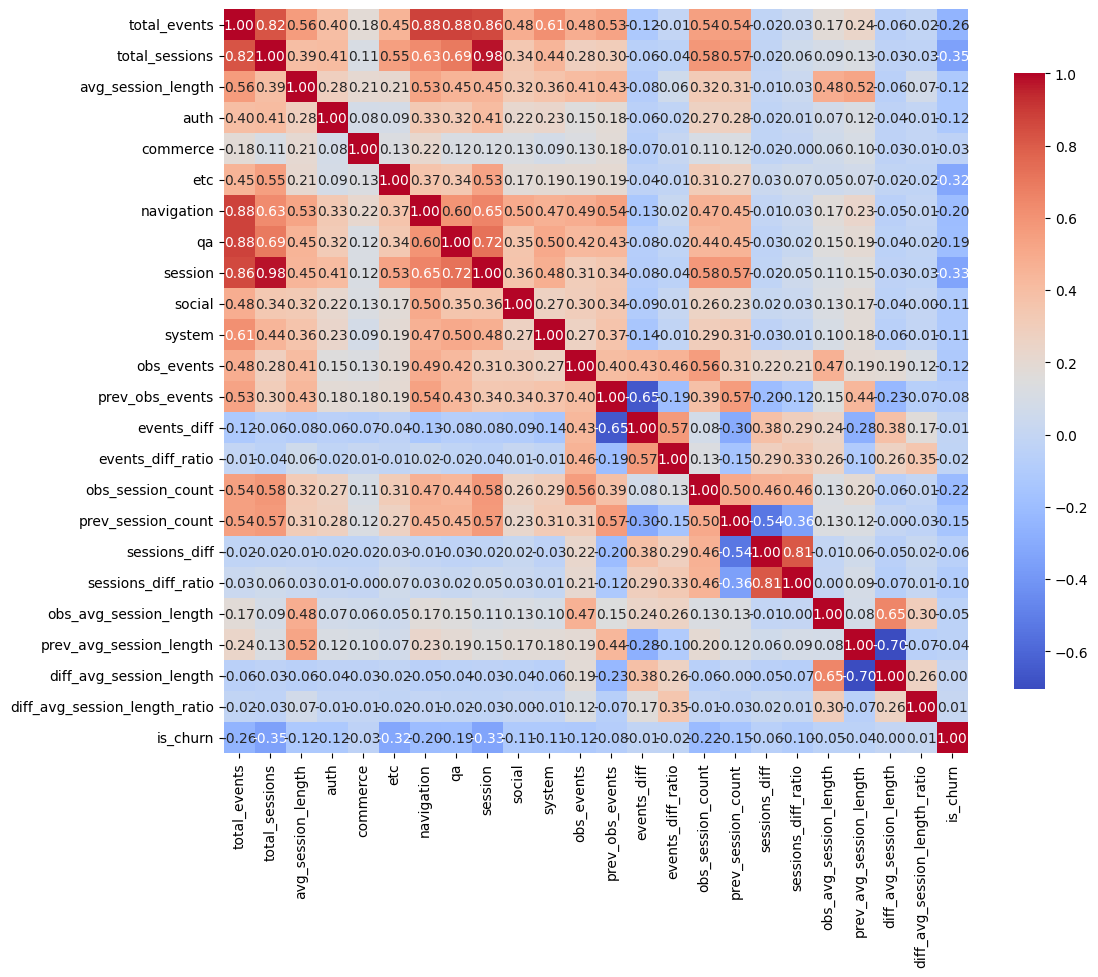

In [ ]:
corr = features_df_mod.drop(columns=['user_id']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

### 3. 모델링

#### 3.0 모델링 준비

In [ ]:
# 필요한 라이브러리
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, recall_score
import shap

In [ ]:
feature = features_df_mod.copy()

#### 3.1 피처 전체 모델링

In [ ]:
# 모델링

# 데이터 준비
X = feature.drop(columns=['user_id', 'is_churn'])
y = feature['is_churn']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# light gbm 선언
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# 모델 성능 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7395, number of negative: 6909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 14304, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516988 -> initscore=0.067979
[LightGBM] [Info] Start training from score 0.067979
Accuracy: 0.6916410399776349
F1 Score: 0.7218158890290037
ROC AUC Score: 0.7505672794347528
Confusion Matrix:
 [[1043  734]
 [ 369 1431]]


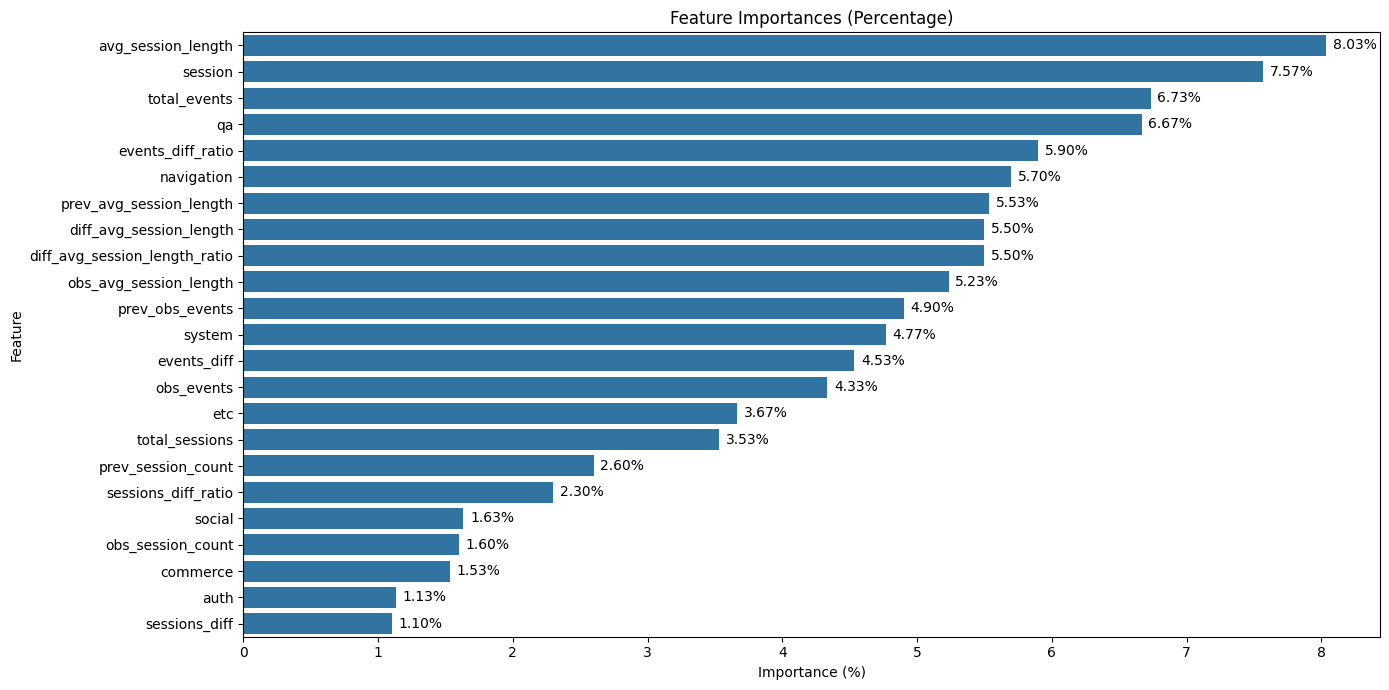

In [ ]:
# 피처 중요도 시각화
feature_importance_nocat = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_nocat['Importance(%)'] = (
    feature_importance_nocat['Importance'] / feature_importance_nocat['Importance'].sum() * 100
)

feature_importance_nocat = feature_importance_nocat.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14,7))
ax = sns.barplot(
    data=feature_importance_nocat,
    x='Importance(%)',
    y='Feature',
    order=feature_importance_nocat['Feature']
)
for bar, value in zip(ax.patches, feature_importance_nocat['Importance(%)']):
    ax.text(
        bar.get_width() + 0.05,   # 살짝 오른쪽
        bar.get_y() + bar.get_height()/2,
        f"{value:.2f}%",
        va='center'
    )
plt.title('Feature Importances (Percentage)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 3.2 카테고리 피처 제외

In [ ]:
# 데이터 준비
X = feature.drop(columns=['user_id', 'is_churn', 'auth',	
                          'commerce',	'etc',	'navigation',	
                          'qa',	'session',	'social',	'system'])
y = feature['is_churn']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# light gbm 선언
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# 모델 성능 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7395, number of negative: 6909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 14304, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516988 -> initscore=0.067979
[LightGBM] [Info] Start training from score 0.067979
Accuracy: 0.6829745596868885
F1 Score: 0.711890243902439
ROC AUC Score: 0.7426871131119864
Confusion Matrix:
 [[1042  735]
 [ 399 1401]]


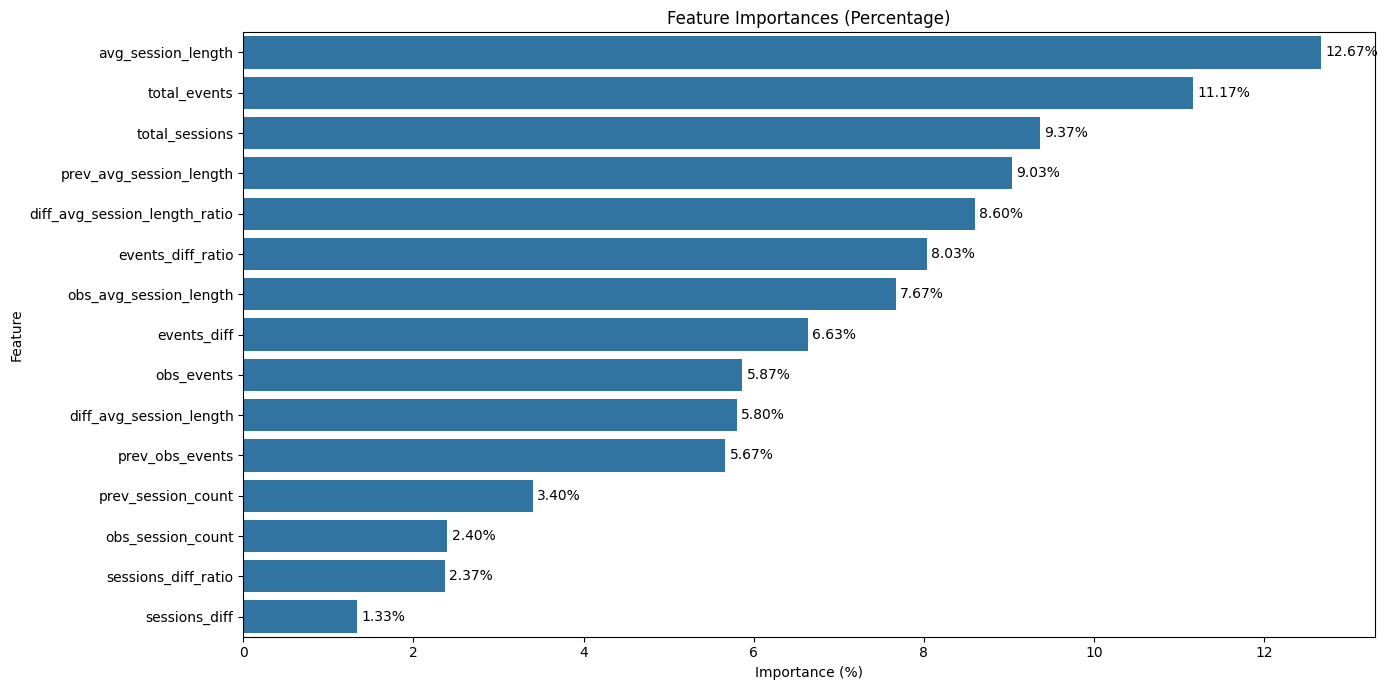

In [ ]:
# 피처 중요도 시각화
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance['Importance(%)'] = (
    feature_importance['Importance'] / feature_importance['Importance'].sum() * 100
)

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14,7))
ax = sns.barplot(
    data=feature_importance,
    x='Importance(%)',
    y='Feature',
    order=feature_importance['Feature']
)
for bar, value in zip(ax.patches, feature_importance['Importance(%)']):
    ax.text(
        bar.get_width() + 0.05,   # 살짝 오른쪽
        bar.get_y() + bar.get_height()/2,
        f"{value:.2f}%",
        va='center'
    )
plt.title('Feature Importances (Percentage)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 3.3 기본 속성 + 이전 이용과의 차이 비율

In [ ]:
# 모델링
feature_list = ['user_id', 'total_events', 'total_sessions', 'avg_session_length',
 'events_diff_ratio', 'sessions_diff_ratio', 'diff_avg_session_length_ratio', 'is_churn']

# 데이터 준비
X = feature[feature_list[1 :-1]]
y = feature['is_churn']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# light gbm 선언
model = LGBMClassifier(random_state=21)
model.fit(X_train, y_train)

# 모델 성능 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7395, number of negative: 6909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 14304, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516988 -> initscore=0.067979
[LightGBM] [Info] Start training from score 0.067979
Accuracy: 0.6899636566955549
Recall: 0.7944444444444444
F1 Score: 0.7205845301083397
ROC AUC Score: 0.7466633839804914
Confusion Matrix:
 [[1038  739]
 [ 370 1430]]


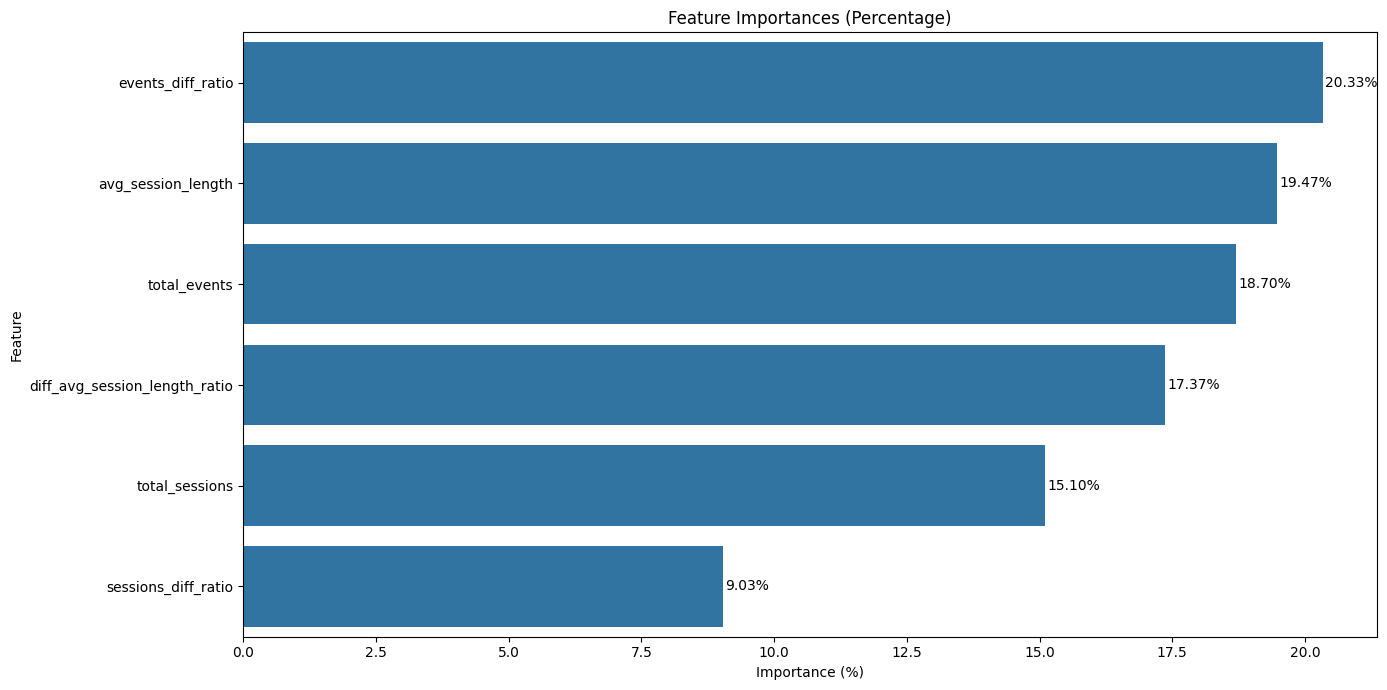

In [ ]:
# 피처 중요도 시각화
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance['Importance(%)'] = (
    feature_importance['Importance'] / feature_importance['Importance'].sum() * 100
)

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14,7))
ax = sns.barplot(
    data=feature_importance,
    x='Importance(%)',
    y='Feature',
    order=feature_importance['Feature']
)
for bar, value in zip(ax.patches, feature_importance['Importance(%)']):
    ax.text(
        bar.get_width() + 0.05,   # 살짝 오른쪽
        bar.get_y() + bar.get_height()/2,
        f"{value:.2f}%",
        va='center'
    )
plt.title('Feature Importances (Percentage)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
feature_importance

Feature  Importance  Importance(%)
3              events_diff_ratio         610      20.333333
2             avg_session_length         584      19.466667
0                   total_events         561      18.700000
5  diff_avg_session_length_ratio         521      17.366667
1                 total_sessions         453      15.100000
4            sessions_diff_ratio         271       9.033333

c:\Users\82107\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


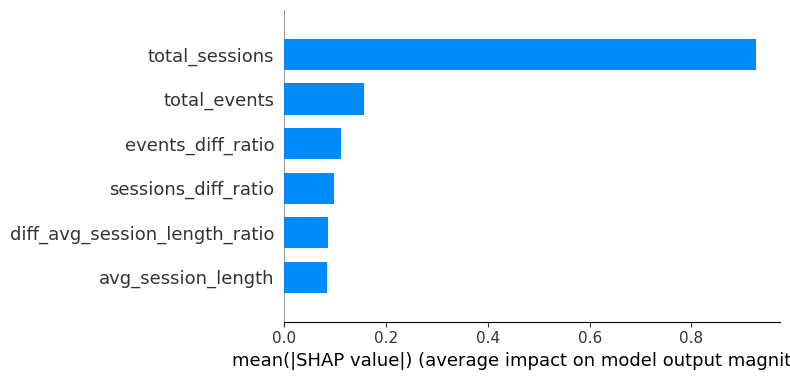

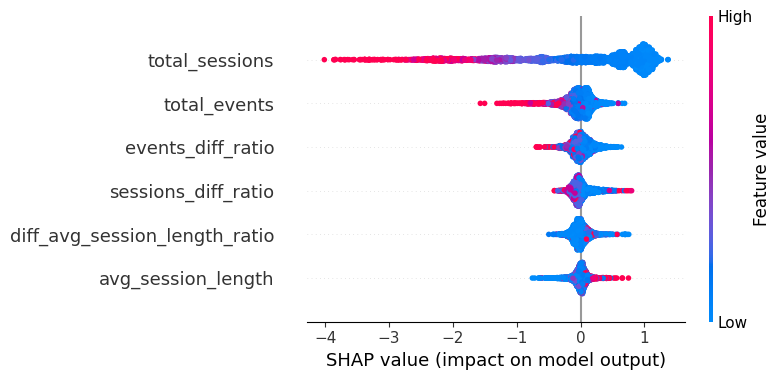

In [ ]:
# 1. explainer 선언 (트리 기반 모델 전용)
explainer = shap.TreeExplainer(model)

# 2. SHAP 값 계산 (테스트셋 기준)
shap_values = explainer.shap_values(X_test)

# 3. Summary plot (전체적인 영향도 + 방향성)
shap.summary_plot(shap_values, X_test, plot_type="bar")   # 중요도 (bar)
shap.summary_plot(shap_values, X_test)                    # 방향성 (dot)


#### 3.4 랜덤 서치를 통한 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# 하이퍼파라미터 탐색 범위 정의
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 8, 10],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 모델 및 RandomizedSearchCV 설정
lgbm = LGBMClassifier(random_state=21)

# 여러 평가지표 정의
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1_score': 'f1',
    'roc_auc': 'roc_auc'
}

# RandomizedSearchCV 객체 생성 (recall을 기준으로 최적의 모델을 찾음)
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=50, # 조합 50개를 무작위로 시도
    scoring=scoring,
    refit='recall', # 최적의 모델을 찾기 위한 기준 지표
    cv=5,
    verbose=2, # 학습 과정 출력
    random_state=21,
    n_jobs=-1 # 가능한 모든 코어 사용
)

# 학습 시작
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 7395, number of negative: 6909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 14304, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516988 -> initscore=0.067979
[LightGBM] [Info] Start training from score 0.067979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=21), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 8, 10],
                                        'min_child_samples': [20, 30, 40],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [20, 31, 40],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=21, refit='recall',
                   scoring={'accuracy': 'accuracy', 'f1_score': 'f1',
                            'recall': 'recall', 'roc_auc': 'roc_auc'},
                   verbose=2)

In [ ]:
# 최적의 하이퍼파라미터 조합
print("최적의 파라미터:", random_search.best_params_)
print("-" * 50)

# 최적 모델의 교차 검증 평균 성능 (refit 기준)
print(f"최적 모델의 교차 검증 Recall: {random_search.best_score_:.4f}")
print("-" * 50)

# 최적 모델로 예측
best_lgbm = random_search.best_estimator_
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

# 최종 테스트 데이터셋에서의 성능 지표 출력
print("테스트 데이터셋에서의 최종 성능:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

최적의 파라미터: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
--------------------------------------------------
최적 모델의 교차 검증 Recall: 0.8095
--------------------------------------------------
테스트 데이터셋에서의 최종 성능:
Accuracy: 0.6919
Recall: 0.8189
F1 Score: 0.7279
ROC AUC Score: 0.7448
Confusion Matrix:
 [[1001  776]
 [ 326 1474]]


### 4. 추가 EDA

#### 4.1 avg session length 평균 세션길이

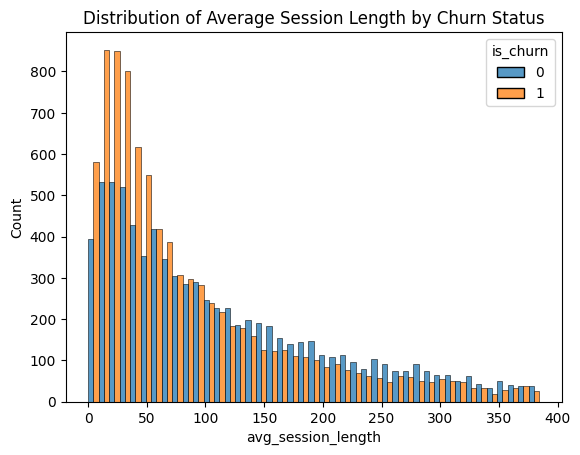

In [ ]:
#시각화를 위한 이상치 제거
# IQR 기반 이상치 제거
Q1 = feature['avg_session_length'].quantile(0.25)
Q3 = feature['avg_session_length'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['avg_session_length'] >= Q1 - 1.5 * IQR) &
    (feature['avg_session_length'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'avg_session_length',
             hue = 'is_churn',
             multiple = 'dodge')
plt.title('Distribution of Average Session Length by Churn Status')
plt.show()

In [ ]:
# 이탈 여부에 따른 평균, 중앙값, 표준편차
feature[cond].groupby('is_churn')['avg_session_length'].agg(['mean', 'median', 'std'])

# 여기도 당연히 이탈하지 않은 쪽이 크다.

mean  median        std
is_churn                               
0         112.354088    85.0  93.518796
1          87.370519    55.5  84.930702

#### 4.2 total events 총 이벤트 수

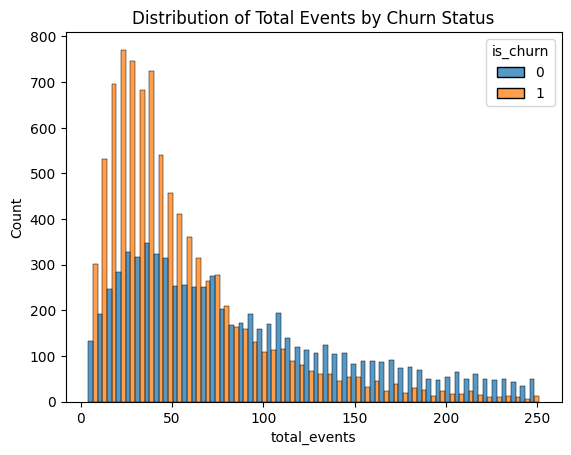

In [ ]:
#시각화를 위한 이상치 제거
# IQR 기반 이상치 제거
Q1 = feature['total_events'].quantile(0.25)
Q3 = feature['total_events'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['total_events'] >= Q1 - 1.5 * IQR) &
    (feature['total_events'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'total_events',
             hue = 'is_churn',
             multiple = 'dodge')
plt.title('Distribution of Total Events by Churn Status')
plt.show()

In [ ]:
# 이탈 여부에 따른 평균, 중앙값, 표준편차
feature[cond].groupby('is_churn')['total_events'].agg(['mean', 'median', 'std'])

mean  median        std
is_churn                              
0         87.356911    72.0  60.429199
1         53.912021    41.0  43.048397

#### 4.3 total sessions 총 세션 수

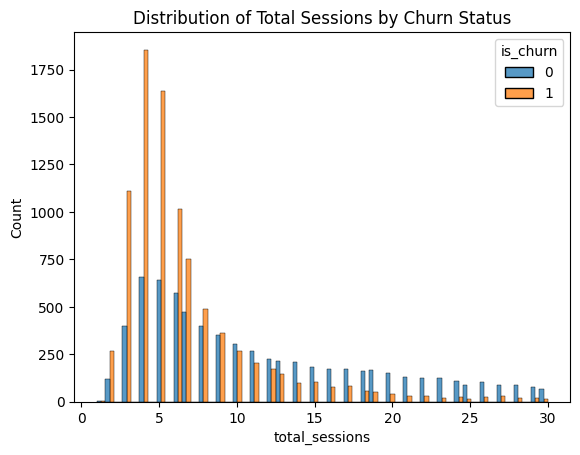

In [ ]:
Q1 = feature['total_sessions'].quantile(0.25)
Q3 = feature['total_sessions'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['total_sessions'] >= Q1 - 1.5 * IQR) &
    (feature['total_sessions'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'total_sessions',
             hue = 'is_churn',
             multiple = 'dodge')
plt.title('Distribution of Total Sessions by Churn Status')
plt.show()


In [ ]:
# 이탈 여부에 따른 평균, 중앙값, 표준편차
feature[cond].groupby('is_churn')['total_sessions'].agg(['mean', 'median', 'std'])

# 여기도 당연히 이탈하지 않은 쪽이 크다.

mean  median       std
is_churn                             
0         11.295278     9.0  7.326208
1          6.731222     5.0  4.526285

#### 4.4 diff avg session length ratio 평균 세션 길이 변화율 (직전 사용일과 비교)

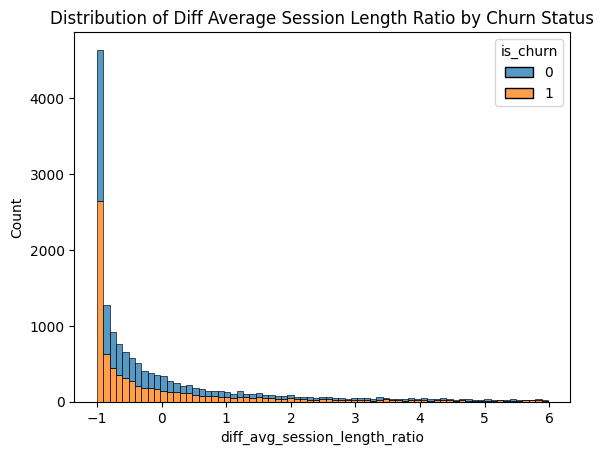

In [ ]:
Q1 = feature['diff_avg_session_length_ratio'].quantile(0.25)
Q3 = feature['diff_avg_session_length_ratio'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['diff_avg_session_length_ratio'] >= Q1 - 1.5 * IQR) &
    (feature['diff_avg_session_length_ratio'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'diff_avg_session_length_ratio',
             hue = 'is_churn',
             multiple = 'stack')
plt.title('Distribution of Diff Average Session Length Ratio by Churn Status')
plt.show()

In [ ]:
# 이탈 여부에 따른 평균, 중앙값, 표준편차
feature[cond].groupby('is_churn')['diff_avg_session_length_ratio'].agg(['mean', 'median', 'std'])
# 이탈하지 않은 사람들이 당일 세션 길이가 조금 더 길다.

mean  median       std
is_churn                            
0         0.047072  -0.550  1.461028
1        -0.029637  -0.675  1.454777

#### 4.5 events diff ratio 이벤트 수 변화율 (직전 사용일과 비교)

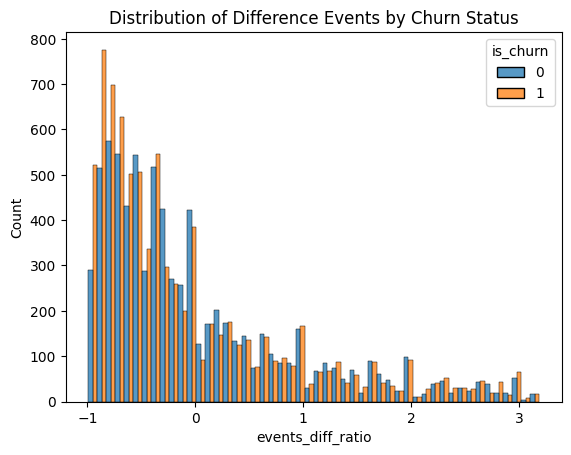

In [ ]:
Q1 = feature['events_diff_ratio'].quantile(0.25)
Q3 = feature['events_diff_ratio'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['events_diff_ratio'] >= Q1 - 1.5 * IQR) &
    (feature['events_diff_ratio'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'events_diff_ratio',
             hue = 'is_churn',
             multiple = 'dodge')
plt.title('Distribution of Difference Events by Churn Status')
plt.show()

In [ ]:
# 이탈 여부에 따른 평균, 중앙값, 표준편차
feature[cond].groupby('is_churn')['events_diff_ratio'].agg(['mean', 'median', 'std'])

mean  median       std
is_churn                            
0         0.028414  -0.267  0.918241
1        -0.042679  -0.375  0.940307

#### 4.6 sessions diff ratio 세션 수 변화율 (직전 사용일과 비교)

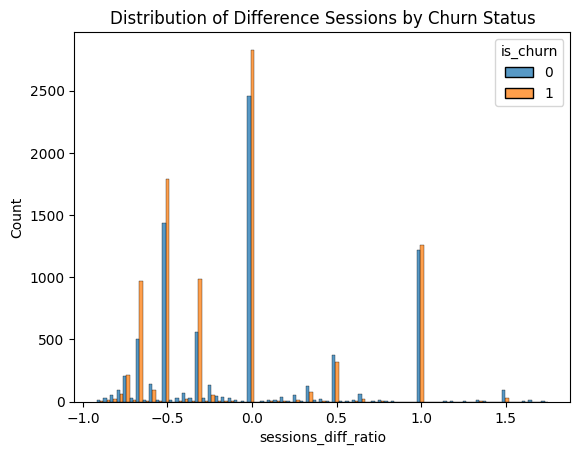

In [ ]:
Q1 = feature['sessions_diff_ratio'].quantile(0.25)
Q3 = feature['sessions_diff_ratio'].quantile(0.75)
IQR = Q3 - Q1

cond = (
    (feature['sessions_diff_ratio'] >= Q1 - 1.5 * IQR) &
    (feature['sessions_diff_ratio'] <= Q3 + 1.5 * IQR)
)

# 이탈 여부에 따른 분포
sns.histplot(feature[cond], 
             x = 'sessions_diff_ratio',
             hue = 'is_churn',
             multiple = 'dodge')
plt.title('Distribution of Difference Sessions by Churn Status')
plt.show()

In [ ]:
feature[cond].groupby('is_churn')['sessions_diff_ratio'].agg(['mean', 'median', 'std'])

mean  median       std
is_churn                            
0        -0.002676     0.0  0.575596
1        -0.077702     0.0  0.543856

### 5. 발표에 필요한 시각화 자료 생성

#### 5.1 이탈 여부에 따른 속성 차이 확인

In [ ]:
total_events_bychurn = feature[cond][['user_id', 'total_events', 'is_churn']]
total_sessions_bychurn = feature[cond][['user_id', 'total_sessions', 'is_churn']]
avg_session_feature = feature[cond][['user_id', 'avg_session_length', 'is_churn']]

NameError: name 'feature' is not defined

In [ ]:
total_events_bychurn['bin'] = pd.cut(total_events_bychurn['total_events']
                                    , bins=[0, 50, 100, 150, 200, 250 ], labels=['0-50', '50-100', '100-150', '150-200', '200-250'])
total_events_bychurn = pd.crosstab(total_events_bychurn['is_churn'], columns = total_events_bychurn['bin']).transpose()
total_events_bychurn

is_churn     0     1
bin                 
0-50      2484  5450
50-100    2153  2377
100-150   1231   725
150-200    741   288
200-250    478   127

In [ ]:
total_sessions_bychurn.max()

user_id           wMeCDZiLidWEAQYYIhKQCV1s1jD2
total_sessions                              95
is_churn                                     1
dtype: object

In [ ]:
total_sessions_bychurn['bin'] = pd.cut(total_sessions_bychurn['total_sessions']
                                    , bins=[0, 5, 10, 15, 20, 30, np.inf ], labels=['0-5', '5-10', '10-15','15-20','20-30','30+'])
total_sessions_bychurn = pd.crosstab(total_sessions_bychurn['is_churn'], columns = total_sessions_bychurn['bin']).transpose()
total_sessions_bychurn

is_churn     0     1
bin                 
0-5       1818  4868
5-10      2081  2874
10-15     1066   700
15-20      769   290
20-30      818   180
30+        545    56

In [ ]:
avg_session_feature['bin'] = pd.cut(avg_session_feature['avg_session_length']
                                    , bins=[0, 50, 100, 150, 200, 250, 300, 350, 400 ], labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400'])
avg_session_bychurn = pd.crosstab(avg_session_feature['is_churn'], columns = avg_session_feature['bin']).transpose()
avg_session_bychurn

#### 5.2 이탈 여부에 따른 행동 지표 변화

In [ ]:
churn = features_df_mod[['user_id' , 'is_churn']]

In [ ]:
df_cut = df_cut.merge(churn, on='user_id', how='left')

In [ ]:
df_cut.head()

event_datetime            event_key                    session_id  \
0 2023-07-18 20:55:37       $session_start  C8OI0sJUDfXhIXclVCZt0ekaE8E2   
1 2023-07-18 20:55:37           launch_app  C8OI0sJUDfXhIXclVCZt0ekaE8E2   
2 2023-07-18 20:55:41  click_question_open  C8OI0sJUDfXhIXclVCZt0ekaE8E2   
3 2023-07-18 20:56:07     click_attendance  C8OI0sJUDfXhIXclVCZt0ekaE8E2   
4 2023-07-18 20:56:10  click_question_open  C8OI0sJUDfXhIXclVCZt0ekaE8E2   

   friend_count  votes_count  heart_balance  user_id  event_date category  \
0          31.0        362.0          771.0  1000030  2023-07-18  session   
1          31.0        362.0          771.0  1000030  2023-07-18  session   
2          31.0        362.0          771.0  1000030  2023-07-18       qa   
3          31.0        362.0          771.0  1000030  2023-07-18      etc   
4          31.0        362.0          771.0  1000030  2023-07-18       qa   

        time_diff  is_new_session  session_group  is_churn  
0             NaT            True              1       0.0  
1 0 days 00:00:00           False              1       0.0  
2 0 days 00:00:04           False              1       0.0  
3 0 days 00:00:26           False              1       0.0  
4 0 days 00:00:03           False              1       0.0

In [ ]:
df_cut['event_date'].max()

datetime.date(2023, 7, 29)

In [ ]:
# 날짜 컬럼 변환
df_cut['event_date'] = pd.to_datetime(df_cut['event_date'])

# 유저별 마지막 활동일
user_last_day = df_cut.groupby('user_id')['event_date'].max().reset_index()
user_last_day.rename(columns={'event_date': 'last_event_date'}, inplace=True)

# 유저별 일자별 사용량 (여기서는 이벤트 개수 기준)
usage_per_day = df_cut.groupby(['user_id', 'event_date', 'is_churn']).size().reset_index(name='usage_cnt')

# merge
result = usage_per_day.merge(user_last_day, on='user_id')

# 마지막 활동일 대비 며칠 전인지 계산
result['days_from_last'] = (result['last_event_date'] - result['event_date']).dt.days

# 직전 7일만 필터링
result = result[result['days_from_last'] <= 7]

# 이탈 여부별 평균 사용량 패턴
plot_df = result.groupby(['is_churn', 'days_from_last'])['usage_cnt'].mean().reset_index()


is_churn  days_from_last  usage_cnt
0        0.0               0  22.102233
1        0.0               1  31.100042
2        0.0               2  29.936831
3        0.0               3  28.706814
4        0.0               4  30.286668
5        0.0               5  28.437905
6        0.0               6  31.217371
7        0.0               7  33.259922
8        1.0               0  15.866232
9        1.0               1  25.313576
10       1.0               2  21.331337
11       1.0               3  18.063710
12       1.0               4  17.489808
13       1.0               5  16.797765
14       1.0               6  21.162216
15       1.0               7  20.534018

In [ ]:
# 유저 필터링
# 1) 유저별 활동 일수
user_active_days = (
    df_cut.groupby('user_id')['event_date']
    .nunique()
    .reset_index(name='active_days')
)

# 2) 최소 3일 이상 활동한 유저만 필터링
valid_users = user_active_days[user_active_days['active_days'] >= 3]['user_id']

# 3) 원본 df_cut 필터링
df_filtered = df_cut[df_cut['user_id'].isin(valid_users)].copy()

In [ ]:
# 하루 세션 수
session_per_day = (
    df_filtered.groupby(['user_id', 'event_date', 'is_churn'])['session_id']
    .nunique()
    .reset_index(name='session_cnt')
)

# 세션 길이 계산
session_length = (
    df_filtered.groupby(['user_id', 'session_id'])
    .agg(start_time=('event_datetime','min'),
         end_time=('event_datetime','max'),
         is_churn=('is_churn','first'),
         event_date=('event_date','first'))
    .reset_index()
)
session_length['session_len'] = (session_length['end_time'] - session_length['start_time']).dt.total_seconds() / 60  # 분 단위

# 하루 평균 세션 길이
session_len_per_day = (
    session_length.groupby(['user_id','event_date','is_churn'])['session_len']
    .mean()
    .reset_index()
)


In [ ]:
# 유저별 마지막 활동일
user_last_day = df_filtered.groupby('user_id')['event_date'].max().reset_index()
user_last_day.rename(columns={'event_date': 'last_event_date'}, inplace=True)

def add_days_from_last(df, value_col):
    result = df.merge(user_last_day, on='user_id')
    result['days_from_last'] = (result['last_event_date'] - result['event_date']).dt.days
    result = result[result['days_from_last'] <= 7]
    plot_df = result.groupby(['is_churn','days_from_last'])[value_col].mean().reset_index()
    return plot_df

In [ ]:
# 각각 데이터 준비
event_df = add_days_from_last(
    df_filtered.groupby(['user_id','event_date','is_churn']).size().reset_index(name='event_cnt'),
    'event_cnt'
)

session_df = add_days_from_last(session_per_day, 'session_cnt')
sessionlen_df = add_days_from_last(session_len_per_day, 'session_len')

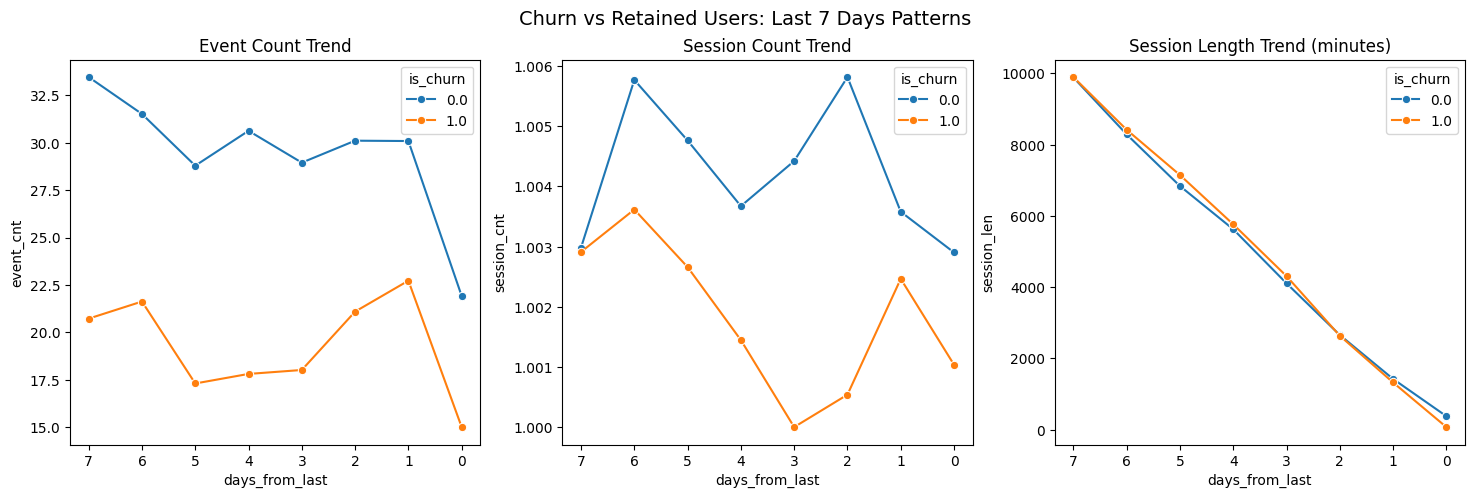

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=False)

sns.lineplot(data=event_df, x='days_from_last', y='event_cnt', hue='is_churn', marker='o', ax=axes[0])
axes[0].invert_xaxis()
axes[0].set_title("Event Count Trend")

sns.lineplot(data=session_df, x='days_from_last', y='session_cnt', hue='is_churn', marker='o', ax=axes[1])
axes[1].invert_xaxis()
axes[1].set_title("Session Count Trend")

sns.lineplot(data=sessionlen_df, x='days_from_last', y='session_len', hue='is_churn', marker='o', ax=axes[2])
axes[2].invert_xaxis()
axes[2].set_title("Session Length Trend (minutes)")

plt.suptitle("Churn vs Retained Users: Last 7 Days Patterns", fontsize=14)
plt.show()

In [ ]:
event_df_pivot = event_df.pivot(index='days_from_last', columns='is_churn', values='event_cnt')
session_df_pivot = session_df.pivot(index='days_from_last', columns='is_churn', values='session_cnt')
sessionlen_df_pivot = sessionlen_df.pivot(index='days_from_last', columns='is_churn', values='session_len')

In [ ]:
event_df_pivot.sort_values(by='days_from_last', ascending = False)

is_churn              0.0        1.0
days_from_last                      
7               33.452760  20.727074
6               31.509257  21.627486
5               28.784421  17.309176
4               30.621939  17.812726
3               28.944717  18.020349
2               30.101589  21.095905
1               30.083221  22.725481
0               21.919972  15.012021

In [ ]:
session_df_pivot.sort_values(by='days_from_last', ascending = False)

is_churn             0.0       1.0
days_from_last                    
7               1.002984  1.002911
6               1.005771  1.003617
5               1.004764  1.002660
4               1.003673  1.001446
3               1.004423  1.000000
2               1.005818  1.000539
1               1.003579  1.002464
0               1.002903  1.001036

In [ ]:
sessionlen_df_pivot.sort_values(by='days_from_last', ascending = False)

is_churn                0.0          1.0
days_from_last                          
7               9884.206232  9894.283831
6               8286.414318  8416.530547
5               6837.796198  7146.063685
4               5624.761020  5763.481338
3               4108.410081  4310.341476
2               2658.352151  2637.713607
1               1425.549537  1326.712500
0                380.808460    75.568750

# 랜덤로그 생성 후 에어플로우 자동화

In [ ]:
import json
import random
import math
from datetime import datetime, timedelta
try:
    from faker import Faker
except ImportError:
    print("Faker library not found. Please install it: 'pip install Faker'")
    Faker = None
import numpy as np
import pandas as pd
from collections import defaultdict
import uuid

# -------------------------------
# 고정 데이터(문항/상품/포인트 정책)
# -------------------------------

USER_VOTE_QUESTIONS = [
    "가장 춤을 잘 출 것 같은 친구는?", "시험에서 1등 할 것 같은 친구는?", "운동회를 제일 잘할 것 같은 친구는?",
    "장난꾸러기일 것 같은 친구는?", "가장 패션 감각이 좋은 친구는?", "미래에 유명인사가 될 것 같은 친구는?"
]

TEXT_VOTE_QUESTIONS = {
    "가장 좋아하는 계절은?": ["봄", "여름", "가을", "겨울"],
    "가장 먹고 싶은 음식은?": ["피자", "햄버거", "치킨", "떡볶이"],
    "가고 싶은 여행지는?": ["바다", "산", "도시", "시골"]
}

PRODUCT_CATALOG = [
    {"product_id": "heart_777",   "price": 777},
    {"product_id": "heart_1000",  "price": 1000},
    {"product_id": "heart_5000",  "price": 5000},
    {"product_id": "heart_10000", "price": 10000},
]

POINT_COST_CHECK_MY_VOTERS = 200
POINT_COST_CHECK_OPTION_VOTERS = 150


def _clip(x, lo, hi):
    """
    수치 안정화를 위해 하/상한으로 값 잘라내기.
    확률·가중치·노이즈 등에서 비정상 폭주를 막음.
    """
    return max(lo, min(hi, x))


def macro_trend_multiplier(d: datetime) -> float:
    """
    날짜별 '서비스 외부 요인'을 반영한 DAU 배율을 반환.
    - 여러 앵커 포인트를 선형 보간해 중장기 추세 구성
    - 주말/월요일 요일 효과
    - 로그정규 노이즈로 직선감 완화
    """
    anchors = [
        ("2025-08-01", 1.00),
        ("2025-09-05", 1.70),
        ("2025-09-15", 1.75),
        ("2025-09-30", 1.30),
        ("2025-10-15", 1.10),
        ("2025-10-25", 1.10),
        ("2025-11-10", 1.60),
        ("2025-11-15", 2.00),
        ("2025-11-30", 1.80),
    ]
    xs = [pd.Timestamp(a[0]) for a in anchors]
    ys = [a[1] for a in anchors]
    t  = pd.Timestamp(d.date())

    if t <= xs[0]:
        base = ys[0]
    elif t >= xs[-1]:
        base = ys[-1]
    else:
        # 인접한 앵커 구간을 찾아 선형 보간
        for i in range(1, len(xs)):
            if xs[i-1] <= t <= xs[i]:
                w = (t - xs[i-1]) / (xs[i] - xs[i-1])
                base = ys[i-1] * (1-w) + ys[i] * w
                break

    # 요일 계수: 주말(+7%), 월요일(-3%), 그 외(1.0)
    dow = t.dayofweek
    week_mult = 1.07 if dow in (5, 6) else (0.97 if dow == 0 else 1.0)

    # 하루 단위 노이즈: 과도한 직선 추세 방지
    noise = float(np.clip(np.random.lognormal(mean=0, sigma=0.07), 0.85, 1.25))
    return float(base * week_mult * noise)


def weekly_scenario_params(current_date: datetime):
    """
    단기(최근 7일 등) 시뮬레이션용 일자별 파라미터 생성.
    - device_per_day: 당일 추정 디바이스 규모
    - signup_prob: 비회원 가입 확률
    - activity_lambda: 1인 기대 이벤트 수의 기준치
    - churn_mult: 이탈 압력 계수
    요일 효과(주말/금요일)와 소노이즈를 섞어 현실감 부여.
    """
    device_base = 1000
    signup_base = 0.20
    lambda_base = 10.0
    churn_base_mult = 1.0

    dow = current_date.weekday()
    if dow in (5, 6):
        device_scale = 1.05; signup_mult = 0.95; activity_mult = 1.10; churn_mult = 1.00
    elif dow == 4:
        device_scale = 1.02; signup_mult = 1.00; activity_mult = 1.06; churn_mult = 1.00
    else:
        device_scale = 1.00; signup_mult = 1.00; activity_mult = 1.00; churn_mult = 1.00

    j_dev   = _clip(np.random.normal(1.0, 0.05), 0.88, 1.15)
    j_sign  = _clip(np.random.normal(1.0, 0.04), 0.85, 1.20)
    j_act   = _clip(np.random.normal(1.0, 0.05), 0.80, 1.30)
    j_churn = _clip(np.random.normal(1.0, 0.04), 0.85, 1.20)

    device_per_day   = int(device_base   * device_scale * j_dev)
    signup_prob      = _clip(signup_base * signup_mult * j_sign, 0.0, 1.0)
    activity_lambda  = _clip(lambda_base * activity_mult * j_act, 1.0, 40.0)
    churn_mult_final = churn_base_mult   * churn_mult   * j_churn

    return {
        "device_per_day": device_per_day,
        "signup_prob": signup_prob,
        "activity_lambda": activity_lambda,
        "churn_mult": churn_mult_final
    }


def get_launch_trend_activity(progress):
    """
    0~1 사이 progress(출시 진행도)를 받아 활동성 가중치 곡선을 생성.
    초기 가속 성장(제곱 곡선) 후 후반 완만 하강.
    """
    if progress < 0.5:
        return 0.05 + (1.0 - 0.05) * (progress / 0.5)**2
    return 1.0 - (1.0 - 0.8) * ((progress - 0.5) / 0.5)


def generate_realistic_timestamp(date_obj):
    """
    유저 액션이 가장 많은 오후 시간대로 치우친 시간 생성.
    - 평균 16시, 표준편차 4.5시간
    - 0~24시간 범위 클리핑
    """
    hour = np.random.normal(loc=16, scale=4.5)
    hour = max(0, min(23.99, hour))
    h, m, s = int(hour), int((hour * 60) % 60), int((hour * 3600) % 60)
    return date_obj.replace(hour=h, minute=m, second=s, microsecond=random.randint(0, 999999))


# -------------------------------
# 엔티티(디바이스/학교/유저/투표대상)
# -------------------------------

class Device:
    """
    단말 식별자와 유입 채널/OS 정보를 보유.
    - user가 연결되면 로그인 기기로 동작
    """
    def __init__(self, created_at):
        self.device_id = str(uuid.uuid4())
        self.user = None
        self.acquisition_channel = random.choices(
            ['Organic', 'Paid', 'Referral', 'Viral'], [0.3, 0.4, 0.2, 0.1]
        )[0]
        self.os_type = random.choices(["Android", "iOS"], weights=[0.55, 0.45], k=1)[0]

    def get_device_properties(self):
        """
        이벤트 로그에 직렬화되는 디바이스 메타정보 반환.
        """
        return {"device_id": self.device_id, "acquisition_channel": self.acquisition_channel, "os_type": self.os_type}


class School:
    """
    학교 단위 엔티티. 유저의 소속을 통해 집단 효과(네트워크 외부성)를 반영.
    - current_active_users는 당일 활동 유저 수(이탈 확률 조정에 사용)
    """
    def __init__(self, fake):
        syllables1 = ['가', '나', '대', '명', '백', '서', '영', '오', '정', '주', '중', '한']
        syllables2 = ['락', '운', '림', '화', '석', '원', '문', '금', '산', '엽', '율', '성']
        self.school_id = f"SCH_{fake.unique.random_number(digits=5)}"
        self.school_name = f"{random.choice(syllables1)}{random.choice(syllables2)}{random.choice(['중학교', '고등학교'])}"
        self.current_active_users = 0


class User:
    """
    앱 사용자.
    - 활동성(로그정규)과 푸시 허용 여부, 기본 이탈 성향을 보유
    - 일일 카운터(세션/이벤트)와 초기 친구추가량으로 이탈 확률 보정
    - 포인트 잔액 관리 및 소비/충전 가능
    """
    def __init__(self, user_id, device, school, created_at):
        self.user_id, self.device, self.school, self.created_at = user_id, device, school, created_at
        self.status = 'active'
        self.grade = random.randint(1, 3)
        self.class_num = random.randint(1, 12)
        self.last_active_date = created_at.date()
        self.activity_score = max(0.1, np.random.lognormal(mean=1.0, sigma=0.5))
        self.has_push_permission = random.random() < 0.7
        self.base_churn_propensity = random.uniform(0.01, 0.15)
        self.points_balance = 1000
        self.sessions_today = 0
        self.events_today = 0
        self.early_friend_adds = 0

    def add_points(self, amount: int):
        """
        포인트 충전(양수). 누적 잔액을 0 미만으로 떨어뜨리지 않음.
        """
        self.points_balance = max(0, self.points_balance + int(amount))

    def spend_points(self, amount: int) -> bool:
        """
        포인트 차감. 잔액 부족 시 False 반환.
        """
        amount = int(amount)
        if amount <= 0:
            return True
        if self.points_balance >= amount:
            self.points_balance -= amount
            return True
        return False

    def update_and_get_churn_chance(self, current_date):
        """
        당일 비활성 유저의 이탈 확률을 계산.
        - 푸시 미허용, 학교 규모, 마지막 활동으로 인한 기본 성향 보정
        - 오늘 세션/이벤트 수가 많을수록 이탈 확률 지수/로그 감쇠
        - 가입 초기에 친구추가가 많을수록 이탈 확률 하락(최대 40% 감소)
        """
        propensity = self.base_churn_propensity

        if not self.has_push_permission:
            propensity *= 3.5

        school_size = self.school.current_active_users
        if school_size <= 10:
            multiplier = 2.0
        elif school_size <= 50:
            multiplier = 1.0
        else:
            multiplier = 0.5
        propensity *= multiplier

        days_since_last_active = (current_date.date() - self.last_active_date).days
        if days_since_last_active > 1:
            propensity *= (1.7 ** days_since_last_active)

        session_factor = math.exp(-0.18 * self.sessions_today)
        event_factor = math.exp(-0.12 * math.log1p(self.events_today))

        early_days = (current_date.date() - self.created_at.date()).days
        if early_days <= 30:
            early_friend_factor = max(0.60, 0.90 ** self.early_friend_adds)
        else:
            early_friend_factor = 1.0

        propensity *= session_factor * event_factor * early_friend_factor
        return min(propensity, 0.95)

    def get_user_properties(self):
        """
        이벤트 로그에 직렬화되는 유저 메타정보 반환.
        - status/grade/class_num/푸시 허용/학교명/현재 포인트 잔액
        """
        return {
            "status": self.status, "grade": self.grade, "class_num": self.class_num,
            "has_push_permission": self.has_push_permission, "school_name": self.school.school_name,
            "points_balance": self.points_balance
        }


def _perform_signup(self, session_id, device, ts):
    """
    (주의: 이 함수는 아래 DataSimulator._perform_signup과 별개로
    상단에 정의되어 있으나 실제로는 사용되지 않음.
    유지하려면 호출부를 정리하거나 통합 필요)
    """
    user_id = f"USR_{len(self.users) + 1}"
    school = random.choice(list(self.schools.values()))
    user = User(user_id, device, school, ts)
    self.users[user_id] = user
    device.user = user

    for i, (name, props) in enumerate(self.event_manager.get('signup', user=user)):
        if name == "signup_completed":
            props["initial_points"] = 1000
        self._log_event(session_id, device, user, name, props, ts + timedelta(seconds=i*2))


class Votable:
    """
    투표 대상(문항) 객체.
    - 텍스트 문항 또는 유저 선택형 문항
    """
    def __init__(self, id, creator_id, ts, content_text):
        self.id, self.creator_id, self.created_at, self.content_text = id, creator_id, ts, content_text


def _product_price(product_id: str):
    """
    상품 ID로 가격 조회. 없으면 None.
    """
    for p in PRODUCT_CATALOG:
        if p["product_id"] == product_id:
            return p["price"]
    return None


class EventManager:
    """
    액션 타입에 따른 이벤트 시퀀스(템플릿)를 반환하는 경량 매니저.
    - signup: 가입 과정 단계 이벤트들
    - general: 일반 행동(질문/투표/소셜/상점/포인트) 중 하나를 가중치로 선택
    - guest: 비회원의 단순 조회
    """
    def get(self, event_type, **kwargs):
        user = kwargs.get('user')
        if event_type == 'signup':
            return [
                ('signup_started', {}),
                ('signup_school_selected', {"school_id": user.school.school_id}),
                ('signup_grade_selected', {"grade": user.grade}),
                ('signup_class_selected', {"class_no": user.class_num}),
                ('signup_completed', {"user_id": user.user_id}),
            ]

        elif event_type == 'general' and user:
            base_weights = {'vote': 55, 'question': 12, 'social': 20, 'shop': 8, 'points': 5}
            action = random.choices(list(base_weights.keys()), weights=list(base_weights.values()), k=1)[0]

            if action == 'question':
                return [('question_created', {'content_text': "오늘 뭐 먹지?"})]

            elif action == 'vote' and kwargs.get('votables'):
                votable = random.choice(list(kwargs['votables'].values()))
                if user.user_id != votable.creator_id:
                    return [('vote_submitted', {"votee_id": votable.id})]

            elif action == 'social' and kwargs.get('users'):
                target_user = random.choice(list(kwargs['users'].values()))
                if target_user.user_id != user.user_id:
                    event = 'block_friend' if random.random() < 0.2 else 'add_friend'
                    return [(event, {"target_user_id": target_user.user_id})]

            elif action == 'shop':
                entry = random.choice(['tab', 'paywall', 'promo'])
                product = random.choice(PRODUCT_CATALOG)["product_id"]
                payment_method = random.choices(
                    ["CARD", "IAP", "BANK_TRANSFER", "MOBILE_CARRIER"],
                    weights=[0.55, 0.30, 0.10, 0.05],
                    k=1
                )[0]
                return [
                    ('shop_viewed', {"entry": entry}),
                    ('purchase_initiated', {"product_id": product, "payment_method": payment_method}),
                ]

            elif action == 'points':
                which = random.choice(['my_voters', 'option_voters'])
                return [('points_spend_hint', {"which": which})]

        elif event_type == 'guest':
            return [('page_viewed', {'page_name': 'main_feed'})]

        return []


# -------------------------------
# 시뮬레이터(핵심)
# -------------------------------

class DataSimulator:
    """
    전체 시뮬레이션을 관리:
    - 기간 설정(8/1~11/30), 초기 엔티티 시드, 일일 루프
    - DAU 목표치 계산 → 활성 디바이스 샘플링 → 세션/이벤트 생성
    - 비활성 유저 이탈 확률 계산 및 상태 전이
    - 이벤트 로그 누적 및 저장 유틸 노출
    """
    def __init__(self):
        if not Faker:
            return
        self.fake = Faker('ko_KR')
        self.start_date, self.end_date = datetime(2025, 8, 1), datetime(2025, 11, 30, 23, 59, 59)
        self.devices, self.schools, self.users, self.votables = {}, {}, {}, {}
        self.events_log = []
        self.event_manager = EventManager()
        self.base_dau = 5000

    def _seed_initial_users(self, n_users: int, current_date: datetime):
        """
        빠르게 유저 풀을 늘리기 위한 초기 더미 유저 생성기.
        - 디바이스를 만들고 해당 디바이스에 유저 연결
        - 학교는 기존 풀에서 무작위로 배정
        """
        for _ in range(n_users):
            d = Device(current_date)
            self.devices[d.device_id] = d
            uid = f"USR_{len(self.users) + 1}"
            school = random.choice(list(self.schools.values()))
            u = User(uid, d, school, current_date)
            d.user = u
            self.users[uid] = u

    def run(self):
        """
        전체 기간을 일 단위로 순회:
        1) 목표 DAU 산출(거시 추세 배율)
        2) 유저/게스트 디바이스 풀 보강
        3) 가중 샘플링으로 당일 활성 디바이스 선정(유저 디바이스 가중↑)
        4) 당일 파라미터(활동, 가입, 이탈 압력) 설정
        5) 각 디바이스로 세션/이벤트 생성
        6) 학교별 active 수 집계 → 비활성 유저 이탈 판정
        """
        if not hasattr(self, 'fake'):
            return

        print("초기 엔티티 생성 중...")
        temp_schools = [School(self.fake) for _ in range(200)]
        self.schools = {s.school_id: s for s in temp_schools}

        self._seed_initial_users(int(self.base_dau * 1.25), self.start_date)

        print("일일 시뮬레이션 루프 시작...")
        total_days = (self.end_date - self.start_date).days
        for day_offset in range(total_days + 1):
            current_date = self.start_date + timedelta(days=day_offset)
            self._reset_daily_counters()

            mult = macro_trend_multiplier(current_date)
            target_dau = int(max(100, round(self.base_dau * mult)))

            desired_user_pool = int(target_dau * 1.30)
            active_users_now = sum(1 for u in self.users.values() if u.status == "active")
            deficit = max(0, desired_user_pool - active_users_now)
            if deficit > 0:
                self._seed_initial_users(deficit, current_date)

            guest_needed = int((len(self.users) * 0.10))
            extra_guests = max(0, guest_needed - (len(self.devices) - len(self.users)))
            for _ in range(extra_guests):
                d = Device(current_date)
                self.devices[d.device_id] = d

            devs = list(self.devices.values())
            weights = np.array([3.0 if d.user else 1.0 for d in devs], dtype=float)
            p = weights / weights.sum()
            k = min(target_dau, len(devs))
            idx = np.random.choice(len(devs), size=k, replace=False, p=p)
            active_devices_today = [devs[i] for i in idx]

            base_ev_per_user = np.clip(np.random.normal(8.5, 1.2), 6.5, 11.0)
            self._activity_lambda_today = base_ev_per_user
            growth_gap = max(0.0, (desired_user_pool - active_users_now) / max(1, desired_user_pool))
            self._signup_prob_today = float(np.clip(0.20 + 0.50 * growth_gap, 0.05, 0.60))
            self._churn_mult_today = weekly_scenario_params(current_date)["churn_mult"]

            active_user_ids = set()
            for device in active_devices_today:
                self._simulate_session(device, current_date)
                if device.user:
                    active_user_ids.add(device.user.user_id)

            for school in self.schools.values():
                school.current_active_users = 0
            for uid in active_user_ids:
                u = self.users.get(uid)
                if u and u.status == "active":
                    self.schools[u.school.school_id].current_active_users += 1

            for user in self.users.values():
                if user.status == 'active' and user.user_id not in active_user_ids:
                    churn_prob = user.update_and_get_churn_chance(current_date)
                    churn_noise = _clip(np.random.normal(1.0, 0.05), 0.85, 1.20)
                    churn_prob = _clip(churn_prob * self._churn_mult_today * churn_noise, 0.0, 0.99)
                    if random.random() < churn_prob:
                        user.status = 'churned'
                        self._log_event(
                            str(uuid.uuid4()), user.device, user,
                            'user_status_changed',
                            {"prev_status": "active", "new_status": "churned"},
                            generate_realistic_timestamp(current_date)
                        )

            print(f"... {current_date.date()} 목표DAU≈{target_dau:,}  (누적 이벤트 {len(self.events_log):,})", end='\r')
        print("\n시뮬레이션이 종료되었습니다.")

    def _maybe_points_spend(self, session_id, device, user, ts, which=None):
        """
        포인트 소비형 기능(내 투표자 보기/옵션 선택자 보기)을 '시도'하는 로직.
        - 활동량이 많을수록 시도 확률 상승
        - 성공 시 관련 이벤트와 포인트 변경 이벤트를 기록
        """
        base_p = 0.15 + min(0.35, user.events_today * 0.01)
        if random.random() > base_p:
            return
        if not self.votables:
            return

        votable = random.choice(list(self.votables.values()))
        if which is None:
            which = random.choice(['my_voters', 'option_voters'])

        if which == 'my_voters':
            cost = POINT_COST_CHECK_MY_VOTERS
            if user.spend_points(cost):
                point_id = str(uuid.uuid4())
                payload = {
                    "votee_id": votable.id,
                    "cost": cost,
                    "balance_after": user.points_balance,
                    "point_id": point_id,
                    "change_amount": -cost,
                    "change_type": "debit",
                    "reason": "check_my_voters",
                    "created_at": ts.isoformat(),
                }
                self._log_event(session_id, device, user, 'check_my_voters_opened', payload, ts)
        else:
            cost = POINT_COST_CHECK_OPTION_VOTERS
            if user.spend_points(cost):
                point_id = str(uuid.uuid4())
                payload = {
                    "votee_id": votable.id,
                    "cost": cost,
                    "balance_after": user.points_balance,
                    "point_id": point_id,
                    "change_amount": -cost,
                    "change_type": "debit",
                    "reason": "check_option_voters",
                    "created_at": ts.isoformat(),
                }
                self._log_event(session_id, device, user, 'check_option_voters_opened', payload, ts)
                self._log_event(session_id, device, user, 'points_changed', payload, ts)

    def _reset_daily_counters(self):
        """
        매일 0시 기준으로 유저의 일일 카운터 초기화.
        - sessions_today / events_today
        """
        for u in self.users.values():
            u.sessions_today = 0
            u.events_today = 0

    def _simulate_session(self, device, current_date):
        """
        한 디바이스가 당일 생성하는 세션을 시뮬레이션.
        - 로그인 유저가 있으면 유저 행동(질문/투표/소셜/상점/포인트)
        - 비회원이면 가입 시도 또는 게스트 조회
        - 결제 성공 시 포인트 충전/변경 이벤트 기록
        """
        session_id = str(uuid.uuid4())
        ts = generate_realistic_timestamp(current_date)
        user = device.user

        self._log_event(session_id, device, user, 'session_started', {}, ts)

        if user and user.status == 'active':
            user.last_active_date = current_date.date()
            user.sessions_today += 1

            base_lam = getattr(self, "_activity_lambda_today", 10.0)
            lam = base_lam * user.activity_score
            lam *= _clip(np.random.normal(1.0, 0.08), 0.7, 1.4)
            num_events = np.random.poisson(lam=max(0.1, lam))

            for _ in range(num_events):
                event_ts = ts + timedelta(seconds=random.randint(5, 300))

                if random.random() < 0.2:
                    self._create_votable(session_id, device, user, event_ts)
                    user.events_today += 1
                    continue

                events = self.event_manager.get('general', user=user, votables=self.votables, users=self.users)

                for name, props in events:
                    if name == 'points_spend_hint':
                        self._maybe_points_spend(session_id, device, user, event_ts, which=props.get("which"))
                        continue

                    if name == 'purchase_initiated':
                        self._log_event(session_id, device, user, name, props, event_ts)

                        product_id = props.get("product_id")
                        payment_method = props.get("payment_method")
                        payment_id = str(uuid.uuid4())

                        if random.random() < 0.75:
                            amount = _product_price(product_id)

                            points_to_add = 0
                            if product_id == "heart_777":
                                points_to_add = 777
                            elif product_id == "heart_1000":
                                points_to_add = 1000
                            elif product_id == "heart_5000":
                                points_to_add = 5000
                            elif product_id == "heart_10000":
                                points_to_add = 10000

                            if points_to_add > 0:
                                user.add_points(points_to_add)

                            self._log_event(
                                session_id, device, user,
                                'payment_succeeded',
                                {
                                    "payment_id": payment_id,
                                    "product_id": product_id,
                                    "amount": amount,
                                    "status": "succeeded",
                                    "payment_method": payment_method,
                                    "payment_time": (event_ts + timedelta(seconds=2)).isoformat(),
                                    "os_type": device.os_type,
                                    "currency": "KRW",
                                    "order_id": str(uuid.uuid4()),
                                },
                                event_ts + timedelta(seconds=2)
                            )

                            if points_to_add > 0:
                                point_id = str(uuid.uuid4())
                                self._log_event(
                                    session_id, device, user,
                                    'points_changed',
                                    {
                                        "point_id": point_id,
                                        "change_amount": points_to_add,
                                        "change_type": "credit",
                                        "reason": "heart_purchase",
                                        "created_at": (event_ts + timedelta(seconds=3)).isoformat(),
                                        "balance_after": user.points_balance,
                                        "product_id": product_id,
                                    },
                                    event_ts + timedelta(seconds=3)
                                )
                        else:
                            self._log_event(
                                session_id, device, user,
                                'payment_failed',
                                {
                                    "payment_id": payment_id,
                                    "product_id": product_id,
                                    "amount": _product_price(product_id),
                                    "status": "failed",
                                    "payment_method": payment_method,
                                    "payment_time": (event_ts + timedelta(seconds=2)).isoformat(),
                                    "os_type": device.os_type,
                                    "error_code": random.choice(['CARD_DECLINED', 'NETWORK', 'TIMEOUT', 'DUPLICATE']),
                                },
                                event_ts + timedelta(seconds=2)
                            )

                        user.events_today += 1
                        continue

                    if name == 'add_friend':
                        if (current_date.date() - user.created_at.date()).days <= 7:
                            user.early_friend_adds += 1

                    self._log_event(session_id, device, user, name, props, event_ts)
                    user.events_today += 1

            if user.events_today >= 20 and random.random() < 0.6:
                self._maybe_points_spend(session_id, device, user, ts + timedelta(minutes=15))

        elif not user:
            signup_p = getattr(self, "_signup_prob_today", 0.2)
            if random.random() < signup_p:
                self._perform_signup(session_id, device, ts + timedelta(seconds=10))
            else:
                for _ in range(random.randint(1, 5)):
                    event_ts = ts + timedelta(seconds=random.randint(5, 60))
                    for name, props in self.event_manager.get('guest'):
                        self._log_event(session_id, device, None, name, props, event_ts)

    def _perform_signup(self, session_id, device, ts):
        """
        실제 가입 절차 실행:
        - 유저 생성/디바이스 연결
        - 가입 단계 이벤트 기록
        - 가입 보너스(+1000) 포인트 변경 이벤트 기록
        """
        user_id = f"USR_{len(self.users) + 1}"
        school = random.choice(list(self.schools.values()))
        user = User(user_id, device, school, ts)
        self.users[user_id] = user
        device.user = user

        for i, (name, props) in enumerate(self.event_manager.get('signup', user=user)):
            self._log_event(session_id, device, user, name, props, ts + timedelta(seconds=i*2))
            point_id = str(uuid.uuid4())
        self._log_event(
            session_id, device, user,
            'points_changed',
            {
                "point_id": point_id,
                "change_amount": 1000,
                "change_type": "credit",
                "reason": "signup_bonus",
                "created_at": (ts + timedelta(seconds=2)).isoformat(),
                "balance_after": user.points_balance,
            },
            ts + timedelta(seconds=2)
        )

    def _create_votable(self, session_id, device, user, ts):
        """
        새로운 투표 문항 생성:
        - 절반 확률로 유저선택형(동료 유저 4명 샘플) 또는 텍스트 선택형
        - 생성 성공 시 votee_created 이벤트 로깅
        """
        votable_id = f"VOTEABLE_{len(self.votables) + 1}"
        event_props = {"votee_id": votable_id}

        if random.random() < 0.5 and len(self.users) > 4:
            content_text = random.choice(USER_VOTE_QUESTIONS)
            other_users = [u.user_id for u in self.users.values() if u.user_id != user.user_id]
            options = random.sample(other_users, min(len(other_users), 4))
            event_props.update({"content_text": content_text, "option_user_ids": options})
        else:
            content_text, options = random.choice(list(TEXT_VOTE_QUESTIONS.items()))
            event_props.update({"content_text": content_text, "option_text": options})

        if len(options) > 1:
            self.votables[votable_id] = Votable(votable_id, user.user_id, ts, content_text)
            self._log_event(session_id, device, user, 'votee_created', event_props, ts)

    def _log_event(self, session_id, device, user, event_name, event_properties, ts):
        """
        단일 이벤트를 표준 스키마로 self.events_log에 적재.
        - event_properties/user_properties/device_properties는 JSON 문자열로 저장
        - device_properties는 필수 키 3종(device_id/acquisition_channel/os_type) 보정
        """
        if device is None:
            raise ValueError()

        dp = device.get_device_properties().copy()
        dp.setdefault("device_id", device.device_id)
        dp.setdefault("acquisition_channel", getattr(device, "acquisition_channel", None))
        dp.setdefault("os_type", getattr(device, "os_type", None))

        if random.random() < 0.0001:
            print("[DBG] device_properties sample:", dp)

        self.events_log.append({
            "event_id": str(uuid.uuid4()),
            "session_id": session_id,
            "event_name": event_name,
            "event_time": ts,
            "user_id": user.user_id if user else None,
            "event_properties": json.dumps(event_properties, ensure_ascii=False),
            "user_properties": json.dumps(user.get_user_properties(), ensure_ascii=False) if user else "{}",
            "device_properties": json.dumps(dp, ensure_ascii=False)
        })

    def save_to_parquet(self, file_path: str):
        """
        누적 이벤트 로그를 파케이로 저장.
        - 필수 컬럼 강제 보정 및 순서 고정
        - device_properties JSON에 필수 키 기본값 보정
        - event_time을 시계열 정렬(UTC-naive)로 저장
        """
        import pandas as pd, json

        required_columns = [
            "event_id", "event_name", "event_time",
            "event_properties", "session_id", "user_id",
            "user_properties", "device_properties",
        ]

        if not getattr(self, "events_log", None):
            df = pd.DataFrame(columns=required_columns)
        else:
            df = pd.DataFrame(self.events_log)

            def _fix_dp(s):
                try:
                    d = json.loads(s) if isinstance(s, str) else (s or {})
                except Exception:
                    d = {}
                d.setdefault("device_id", None)
                d.setdefault("acquisition_channel", None)
                d.setdefault("os_type", None)
                return json.dumps(d, ensure_ascii=False)

            if "device_properties" in df.columns:
                df["device_properties"] = df["device_properties"].apply(_fix_dp)
            else:
                df["device_properties"] = json.dumps(
                    {"device_id": None, "acquisition_channel": None, "os_type": None},
                    ensure_ascii=False,
                )

            if "event_time" in df.columns:
                df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
                if df["event_time"].dt.tz is not None:
                    df["event_time"] = df["event_time"].dt.tz_convert("UTC").dt.tz_localize(None)
                df.sort_values(by="event_time", inplace=True)

        for col in required_columns:
            if col not in df.columns:
                df[col] = None
        df = df[required_columns]

        df.to_parquet(file_path, engine="pyarrow", index=False)
        print(f"✅ saved parquet: {file_path} (rows={len(df)})")


from datetime import datetime, timedelta
from typing import Optional

def run_week_block(start_dt: datetime,
                   end_dt: datetime,
                   out_path: str,
                   gcs_bucket: Optional[str] = None,
                   gcs_prefix: str = "random_log"):
    """
    입력된 7일 구간을 시뮬레이션하고 결과를 로컬 Parquet로 저장.
    - 필요 시 GCS에 업로드하고 gs:// 경로를 반환
    - 반환값: gcs_full_path(str) 또는 None
    """
    MONTH_ABBR = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

    sim = DataSimulator()
    if not hasattr(sim, 'fake'):
        raise RuntimeError("Faker 미설치로 실행 불가")

    sim.start_date = start_dt.replace(hour=0, minute=0, second=0, microsecond=0)
    sim.end_date   = end_dt.replace(hour=23, minute=59, second=59, microsecond=0)

    sim.run()
    sim.save_to_parquet(out_path)

    if gcs_bucket:
        year_full = start_dt.year
        mon_abbr  = MONTH_ABBR[start_dt.month - 1]
        week_num  = ((start_dt.day - 1) // 7) + 1

        filename = f"{year_full}-{mon_abbr}-week-{week_num}.parquet"
        gcs_key = f"{gcs_prefix}/{filename}"

        # NOTE: 아래 storage.Client()는 google-cloud-storage가 설치/인증되어 있어야 작동.
        from google.cloud import storage
        client = storage.Client()
        bucket = client.bucket(gcs_bucket)
        bucket.blob(gcs_key).upload_from_filename(out_path)

        gcs_full_path = f"gs://{gcs_bucket}/{gcs_key}"
        print(f"Uploaded to {gcs_full_path}")
        return gcs_full_path

    return None


if __name__ == "__main__":
    s = datetime(2025, 8, 1)
    e = s + timedelta(days=6, hours=23, minutes=59, seconds=59)
    run_week_block(s, e, "/tmp/test_week.parquet", gcs_bucket=None)


# 데이터 품질 검증 & 알림 dag

In [ ]:
# -*- coding: utf-8 -*-
from datetime import datetime, date
import json
import math
import re

from airflow.decorators import dag, task
from airflow.exceptions import AirflowSkipException
from airflow.utils.trigger_rule import TriggerRule
from pendulum import timezone
from airflow.models import Variable # ★ 추가

import requests

# =========================
# 0) 환경 상수
# =========================
KST = timezone("Asia/Seoul")
ANCHOR = KST.datetime(2025, 8, 1, 0, 0, 0)

# GCS (랜덤로그 주차 단위 Parquet 저장 위치)
GCS_BUCKET = "sprint-final-bucket"
GCS_PREFIX = "random_log"

# 주차 파일명 규칙: 2025-Aug-week-1.parquet
MONTH_ABBR = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
MONTH_TO_IDX = {m: i+1 for i, m in enumerate(MONTH_ABBR)}
WEEK_FILE_RE = re.compile(r"^(\d{4})-([A-Za-z]{3})-week-(\d+)\.parquet$")

# Discord Webhook (사용자 제공)
DISCORD_WEBHOOK = "https://discord.com/api/webhooks/1407161459766460548/JcxDHnxe8ofB4NWqYWEI2en14JGTsbRawoVU2IVs2UX58jSpOceAhRJq-v_4xBBoLpBB"

# 알림 색상/아이콘
EMBED_COLORS = {"OK": 0x2ECC71, "ALERT": 0xED4245, "WARNING": 0xFFA500, "INFO": 0x3498DB}
ICONS = {
    "ALERT": "🚨",
    "OK": "✅",
    "DOWN": "📉",
    "UP": "📈",
    "TREND_DOWN": "📊📉",
    "TREND_UP": "📊📈",
    "COHORT": "👥",
    "PLUS": "🟢➕",
    "MINUS": "🔴➖",
    "CLOCK": "⏱️",
    "EVENT": "🎯",
    "SESSION": "🧭",
    "USERS": "👤",
    "FIRE": "🔥",
    "ICE": "🧊",
    "ROCKET": "🚀",
    "WARNING": "⚠️",
    "CHECK": "✅",
    "CROSS": "❌",
    "ARROW_UP": "⬆️",
    "ARROW_DOWN": "⬇️",
    "ARROW_RIGHT": "➡️",
    "STAR": "⭐",
    "CROWN": "👑",
    "HEART": "💖",
    "LIGHTNING": "⚡",
}

# 감지 임계값(필요시 조정)
THRESHOLDS = {
    "mean_drop_pct": 0.20,
    "slope_pct_per_day": -0.05,
    "influencer_drop_pct": 0.30,
    # // "cohort_influencer_risky_ratio": 0.50, # 삭제
    "global_influencer_risky_ratio": 0.25, # ★ 추가: 전체 인플루언서 중 위험군 비율이 25% 이상이면 알림
    "min_users_for_stats": 30,
}
# 중복 실행 방지를 위한 Airflow Variable 이름
VAR_LAST_PROCESSED = "churn_watchdog_last_processed_label"
VAR_LAST_ALERT_HASH = "churn_watchdog_last_alert_hash"

# =========================
# 1) 유틸
# =========================
def post_discord_embed(embed: dict):
    try:
        requests.post(DISCORD_WEBHOOK, json={"embeds": [embed]}, timeout=10).raise_for_status()
    except Exception as e:
        print(f"[Discord] post error: {e}")

def parse_week_from_name(name: str):
    m = WEEK_FILE_RE.match(name)
    if not m:
        return None
    y, mon_abbr, w = int(m.group(1)), m.group(2), int(m.group(3))
    mon = MONTH_TO_IDX.get(mon_abbr)
    return (y, mon, w)

def safe_json_loads(x):
    if x is None:
        return {}
    if isinstance(x, (dict, list)):
        return x
    try:
        return json.loads(x)
    except Exception:
        return {}

def pct_change(prev, cur):
    prev = float(prev or 0.0)
    cur  = float(cur or 0.0)
    if prev <= 0:
        return 0.0 if cur <= 0 else 1.0
    return (cur - prev) / prev

def slope_pct_per_day(values):
    """values: 일자별 평균 시계열 -> (기울기/평균) 반환"""
    import numpy as np
    arr = np.array(values, dtype=float)
    if len(arr) < 3:
        return 0.0
    x = np.arange(len(arr))
    m, b = np.polyfit(x, arr, 1)
    denom = arr.mean() if arr.mean() != 0 else 1.0
    return float(m / denom)

def get_change_icon(change_pct, threshold=0.05):
    """변화율에 따라 적절한 아이콘 반환"""
    if abs(change_pct) < threshold:
        return ICONS["ARROW_RIGHT"]
    elif change_pct > 0:
        return ICONS["ARROW_UP"]
    else:
        return ICONS["ARROW_DOWN"]

def get_trend_icon(slope_pct):
    """기울기에 따라 추세 아이콘 반환"""
    if slope_pct > 0.02:  # 상승 추세
        return ICONS["TREND_UP"]
    elif slope_pct < -0.02:  # 하락 추세
        return ICONS["TREND_DOWN"]
    else:
        return ICONS["ARROW_RIGHT"]

def create_alert_hash(alerts, metrics):
    """알림 내용의 해시를 생성하여 중복 체크용으로 사용"""
    import hashlib
    content = f"{alerts}_{metrics}"
    return hashlib.md5(content.encode()).hexdigest()

# =========================
# 2) DAG
# =========================
@dag(
    dag_id="churn_watchdog_weekly_v4",
    start_date=ANCHOR,
    schedule="@daily",
    catchup=True,
    max_active_runs=1,
    default_args={"retries": 0},
    tags=["final", "monitor", "churn"],
)
def churn_watchdog_weekly():

    @task
    def pick_week_files():
        """GCS에서 최신 주차 파일과 전주 파일 경로 선택. 단, 이미 처리한 파일은 건너뛴다.""" # ☆ 주석 변경
        from google.cloud import storage
        client = storage.Client()
        blobs = list(client.list_blobs(GCS_BUCKET, prefix=f"{GCS_PREFIX}/"))

        week_files = []
        for b in blobs:
            name = b.name.split("/")[-1]
            if name.endswith(".parquet") and WEEK_FILE_RE.match(name):
                parsed = parse_week_from_name(name)
                if parsed:
                    week_files.append((parsed, name, b.name))

        if not week_files:
            raise AirflowSkipException("주차 Parquet 파일이 없습니다.")

        week_files.sort(key=lambda t: t[0])
        latest = week_files[-1]
        latest_path = f"gs://{GCS_BUCKET}/{latest[2]}"
        label = latest[1].replace(".parquet", "")

        # 중복 실행 방지 로직
        try:
            last_processed = Variable.get(VAR_LAST_PROCESSED, default_var=None)
            if label == last_processed:
                raise AirflowSkipException(f"'{label}' 파일은 이미 처리되었습니다.")
        except Exception as e:
            print(f"중복 실행 체크 중 오류 발생: {e}")
            # 오류가 발생해도 계속 진행
        # 중복 실행 방지 로직 끝

        if len(week_files) >= 2:
            prev = week_files[-2]
            prev_path = f"gs://{GCS_BUCKET}/{prev[2]}"
        else:
            prev_path = None

        return {"latest": latest_path, "prev": prev_path, "label": label}

    @task
    def analyze_week(paths: dict):
        import gcsfs
        import pyarrow.parquet as pq
        import pandas as pd
        import numpy as np

        latest, prev = paths["latest"], paths.get("prev")
        fs = gcsfs.GCSFileSystem()
        need_cols = ["user_id", "session_id", "event_time", "event_name", "event_properties", "user_properties"]

        def load_week(path):
            with fs.open(path, "rb") as f:
                pf = pq.ParquetFile(f)
                cols = [c for c in need_cols if c in pf.schema.names]
                tbl = pf.read(columns=cols)
            df = tbl.to_pandas()
            # 타입 정리 및 전처리
            if "event_time" in df:
                df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
                df["date"] = df["event_time"].dt.date
            else:
                df["date"] = pd.NaT

                    def count_touched(ep):
            e = safe_json_loads(ep)
            touched = set()
            for k in ("target_user_id", "user_id", "votee_id"):
                if str(e.get(k, "")).strip(): touched.add(str(e[k]))
            if isinstance(e.get("option_user_ids"), list):
                for v in e["option_user_ids"]:
                    if str(v).strip(): touched.add(str(v))
            return len(touched)
        df["touched_cnt"] = df["event_properties"].map(count_touched) if "event_properties" in df else 0
        
        # 하트 충전(포인트 증가) 시 포인트 변환 로직
        def get_heart_recharge_points(ep):
            e = safe_json_loads(ep)
            # points_changed 이벤트에서 heart_purchase 이유로 포인트가 증가한 경우
            if e.get("event_name") == "points_changed" and e.get("reason") == "heart_purchase":
                return e.get("change_amount", 0)
            return 0
        df["heart_recharge_points"] = df["event_properties"].map(get_heart_recharge_points) if "event_properties" in df else 0
            
            if "event_time" in df and "session_id" in df:
                ses = df.dropna(subset=["event_time"]).groupby(["user_id","session_id"]).agg(s_len=("event_time", lambda s: (s.max()-s.min()).total_seconds())).reset_index()
            else:
                ses = pd.DataFrame(columns=["user_id","session_id","s_len"])

            per_ud = df.groupby(["date", "user_id"]).agg(
                sessions=("session_id","nunique"), 
                events=("event_name", "count"), 
                touched=("touched_cnt", "sum"),
                heart_recharge=("heart_recharge_points", "sum")  # 하트 충전 포인트 추가
            ).reset_index()
            
            if not ses.empty:
                ses_user = ses.groupby("user_id")["s_len"].mean().rename("avg_slen_user").reset_index()
                per_ud = per_ud.merge(ses_user, on="user_id", how="left")
            else:
                per_ud["avg_slen_user"] = np.nan
            return df, per_ud

        df_new, ud_new = load_week(latest)
        if prev: 
            _, ud_old = load_week(prev)
        else: 
            ud_old = None
            
        n_users = ud_new["user_id"].nunique()
        if n_users < THRESHOLDS["min_users_for_stats"]:
            return {"label": paths["label"], "alerts": [], "summary": f"사용자 수 부족 ({n_users}명)"}

        # 전체 지표 분석
        def daily_means(ud):
            if ud is None or ud.empty: return pd.DataFrame()
            g = (ud.groupby("date")
                  .agg(
                      mean_sessions=("sessions","mean"),
                      mean_events=("events","mean"),
                      mean_slen=("avg_slen_user","mean"),
                      mean_heart_recharge=("heart_recharge", "mean"),  # 하트 충전 평균 추가
                  )
                  .sort_index())
            return g

        dnew = daily_means(ud_new)
        dold = daily_means(ud_old)

        def weekly_mean(g, col):
            if g is None or g.empty: return 0.0
            return float(g[col].dropna().mean())

        new_msess, new_mevts, new_mslen, new_mheart = weekly_mean(dnew, "mean_sessions"), weekly_mean(dnew, "mean_events"), weekly_mean(dnew, "mean_slen"), weekly_mean(dnew, "mean_heart_recharge")
        old_msess, old_mevts, old_mslen, old_mheart = weekly_mean(dold, "mean_sessions"), weekly_mean(dold, "mean_events"), weekly_mean(dold, "mean_slen"), weekly_mean(dold, "mean_heart_recharge")

        drop_sess = pct_change(old_msess, new_msess) * -1
        drop_evts = pct_change(old_mevts, new_mevts) * -1
        drop_slen = pct_change(old_mslen, new_mslen) * -1
        drop_heart = pct_change(old_mheart, new_mheart) * -1

        slope_sess = slope_pct_per_day(list(dnew["mean_sessions"]))
        slope_evts = slope_pct_per_day(list(dnew["mean_events"]))
        slope_slen = slope_pct_per_day(list(dnew["mean_slen"]))
        slope_heart = slope_pct_per_day(list(dnew["mean_heart_recharge"]))

        alerts = []
        # 전주 대비 변화율 알림 (화살표 방향 포함)
        if drop_sess >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_sess)
            alerts.append(f"{ICONS['SESSION']} {icon} 평균 세션/유저 **{drop_sess*100:.1f}%** 감소")
        elif drop_sess <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_sess)
            alerts.append(f"{ICONS['SESSION']} {icon} 평균 세션/유저 **{abs(drop_sess)*100:.1f}%** 증가")
            
        if drop_evts >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_evts)
            alerts.append(f"{ICONS['EVENT']} {icon} 평균 이벤트/유저 **{drop_evts*100:.1f}%** 감소")
        elif drop_evts <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_evts)
            alerts.append(f"{ICONS['EVENT']} {icon} 평균 이벤트/유저 **{abs(drop_evts)*100:.1f}%** 증가")
            
        if drop_slen >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_slen)
            alerts.append(f"{ICONS['CLOCK']} {icon} 평균 세션길이 **{drop_slen*100:.1f}%** 감소")
        elif drop_slen <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_slen)
            alerts.append(f"{ICONS['CLOCK']} {icon} 평균 세션길이 **{abs(drop_slen)*100:.1f}%** 증가")
            
        # 하트 충전 변화율 알림
        if drop_heart >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_heart)
            alerts.append(f"{ICONS['HEART']} {icon} 평균 하트충전 **{drop_heart*100:.1f}%** 감소")
        elif drop_heart <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_heart)
            alerts.append(f"{ICONS['HEART']} {icon} 평균 하트충전 **{abs(drop_heart)*100:.1f}%** 증가")
        
        # 추세 알림 (화살표 방향 포함)
        if slope_sess <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_sess)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 세션/유저 **하락 추세** ({slope_sess*100:.1f}%/day)")
        elif slope_sess >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_sess)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 세션/유저 **상승 추세** ({slope_sess*100:.1f}%/day)")
            
        if slope_evts <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_evts)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 이벤트/유저 **하락 추세** ({slope_evts*100:.1f}%/day)")
        elif slope_evts >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_evts)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 이벤트/유저 **상승 추세** ({slope_evts*100:.1f}%/day)")
            
        if slope_slen <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_slen)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 세션길이 **하락 추세** ({slope_slen*100:.1f}%/day)")
        elif slope_slen >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_slen)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 세션길이 **상승 추세** ({slope_slen*100:.1f}%/day)")
            
        # 하트 충전 추세 알림
        if slope_heart <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_heart)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 하트충전 **하락 추세** ({slope_heart*100:.1f}%/day)")
        elif slope_heart >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_heart)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 하트충전 **상승 추세** ({slope_heart*100:.1f}%/day)")

        # 전체 인플루언서 이탈 위험 분석
        global_influencer_risk = {}
        if ud_old is not None and not ud_old.empty:
            cur_user_ev = ud_new.groupby("user_id")["events"].sum()
            old_user_ev = ud_old.groupby("user_id")["events"].sum()
            
            total_touch = ud_new.groupby("user_id")["touched"].sum()
            if not total_touch.empty:
                # 상위 3%를 인플루언서로 정의 (요청사항에 맞게 수정)
                top_3_pct_threshold = total_touch.quantile(0.97)
                influencer_ids = total_touch[total_touch >= top_3_pct_threshold].index.tolist()
                
                total_influencer_count = len(influencer_ids)
                risky_influencer_count = 0
                
                for uid in influencer_ids:
                    old = float(old_user_ev.get(uid, 0.0))
                    new = float(cur_user_ev.get(uid, 0.0))
                    drop = 1.0 if (old > 0 and new == 0) else ((old - new) / old if old > 0 else 0.0)
                    if drop >= THRESHOLDS["influencer_drop_pct"]:
                        risky_influencer_count += 1
                
                risky_ratio = risky_influencer_count / total_influencer_count if total_influencer_count > 0 else 0.0
                
                global_influencer_risk = {
                    "total_count": total_influencer_count,
                    "risky_count": risky_influencer_count,
                    "risky_ratio": risky_ratio,
                }
                
                if risky_ratio >= THRESHOLDS["global_influencer_risky_ratio"]:
                    alerts.append(f"{ICONS['CROWN']} {ICONS['FIRE']} 중심학생(상위3%) 중 **{risky_ratio*100:.1f}%**({risky_influencer_count}/{total_influencer_count}명)가 활동량 급감!")

        return {
            "label": paths["label"],
            "alerts": alerts,
            "global_influencer_risk": global_influencer_risk,
            "metrics": {
                "n_users": n_users,
                "new": {"mean_sessions": new_msess, "mean_events": new_mevts, "mean_slen": new_mslen, "mean_heart_recharge": new_mheart},
                "old": {"mean_sessions": old_msess, "mean_events": old_mevts, "mean_slen": old_mslen, "mean_heart_recharge": old_mheart},
                "slopes": {"sessions": slope_sess, "events": slope_evts, "slen": slope_slen, "heart_recharge": slope_heart},
            },
        }

    @task(trigger_rule=TriggerRule.ALL_DONE)
    def maybe_notify(report: dict):
        """위험 종류에 따라 다른 제목/색상으로 알림을 보냄"""
        if not report or not report.get("label"):
            print("분석 결과가 없어 알림을 생략합니다.")
            return None

        label = report["label"]
        alerts = report.get("alerts", [])
        m = report.get("metrics", {})
        
        if not m: # 분석 최소 사용자 수 미달 등
            print(f"[{label}] 지표가 없어 알림을 생략합니다. 사유: {report.get('summary')}")
            return label  # label은 반환하되 알림은 보내지 않음

        # 중복 알림 방지 체크
        try:
            alert_hash = create_alert_hash(alerts, str(m))
            last_hash = Variable.get(VAR_LAST_ALERT_HASH, default_var=None)
            if alert_hash == last_hash:
                print(f"[{label}] 동일한 알림이 이미 전송되었습니다. 알림을 생략합니다.")
                return label
        except Exception as e:
            print(f"중복 알림 체크 중 오류 발생: {e}")

        n_users = m.get("n_users", 0)
        ms_new = m.get("new", {})
        ms_old = m.get("old", {})
        
        def pc(p, c):
            if p and p > 0: 
                change = (c-p)/p*100
                icon = get_change_icon(change/100)
                return f"{icon} {change:+.1f}%"
            return "n/a"
        
        desc_lines = []
        desc_lines.append(f"{ICONS['USERS']} **활성 사용자**: `{n_users:,}`명")
        desc_lines.append(f"{ICONS['SESSION']} **평균 세션/유저**: `{ms_new.get('mean_sessions',0):.3f}` (전주 `{ms_old.get('mean_sessions',0):.3f}`, {pc(ms_old.get('mean_sessions'), ms_new.get('mean_sessions'))})")
        desc_lines.append(f"{ICONS['EVENT']} **평균 이벤트/유저**: `{ms_new.get('mean_events',0):.3f}` (전주 `{ms_old.get('mean_events',0):.3f}`, {pc(ms_old.get('mean_events'), ms_new.get('mean_events'))})")
        desc_lines.append(f"{ICONS['CLOCK']} **평균 세션길이**: `{ms_new.get('mean_slen',0):.1f}초` (전주 `{ms_old.get('mean_slen',0):.1f}초`, {pc(ms_old.get('mean_slen'), ms_new.get('mean_slen'))})")
        desc_lines.append(f"{ICONS['HEART']} **평균 하트충전**: `{ms_new.get('mean_heart_recharge',0):.1f}포인트` (전주 `{ms_old.get('mean_heart_recharge',0):.1f}포인트`, {pc(ms_old.get('mean_heart_recharge'), ms_new.get('mean_heart_recharge'))})")
        desc = "\n".join(desc_lines)

        if not alerts:
            embed = { 
                "title": f"{ICONS['ROCKET']} {ICONS['CHECK']} 이탈 위험 없음 · {label}", 
                "description": desc, 
                "color": EMBED_COLORS["OK"] 
            }
        else:
            # 위험 신호를 더 예쁘게 포맷팅
            alert_text = "\n".join([f"{ICONS['LIGHTNING']} {a}" for a in alerts])
            if len(alert_text) > 1024:
                alert_text = alert_text[:1021] + "..."
                
            fields = [{
                "name": f"{ICONS['ALERT']} {ICONS['WARNING']} 주요 위험 신호",
                "value": alert_text,
                "inline": False
            }]
            
            # 위험도에 따라 색상 결정
            color = EMBED_COLORS["ALERT"] if len(alerts) >= 3 else EMBED_COLORS["WARNING"]
            
            embed = {
                "title": f"{ICONS['ALERT']} {ICONS['FIRE']} 이탈 위험 감지 · {label}",
                "description": desc,
                "color": color,
                "fields": fields,
            }

        embed.update({
            "footer": {"text": f"{ICONS['STAR']} Airflow Churn Watchdog {ICONS['STAR']}"}, 
            "timestamp": datetime.utcnow().isoformat() + "Z"
        })
        post_discord_embed(embed)
        
        # 알림 해시 저장
        try:
            Variable.set(VAR_LAST_ALERT_HASH, alert_hash)
        except Exception as e:
            print(f"알림 해시 저장 중 오류 발생: {e}")
        
        # label을 반환하여 다음 태스크에서 사용할 수 있도록 함
        return label

    # ★ 시작: 신규 태스크 추가
    @task(trigger_rule=TriggerRule.ALL_DONE)
    def set_last_processed_file(label_to_set: str):
        """처리가 끝난 파일 레이블을 Airflow Variable에 저장합니다."""
        if label_to_set and label_to_set != "None":
            try:
                Variable.set(VAR_LAST_PROCESSED, label_to_set)
                print(f"{ICONS['CHECK']} '{VAR_LAST_PROCESSED}'를 '{label_to_set}'으로 설정했습니다. {ICONS['ROCKET']}")
            except Exception as e:
                print(f"{ICONS['WARNING']} Variable 설정 중 오류 발생: {e}")
                # 오류가 발생해도 DAG는 성공으로 처리
        else:
            print(f"{ICONS['INFO']} label이 없어 Variable 설정을 건너뜁니다.")
    # ★ 끝: 신규 태스크 추가

    # --- DAG 실행 순서 정의 ---
    paths = pick_week_files()
    report = analyze_week(paths)
    processed_label = maybe_notify(report)
    processed_label >> set_last_processed_file(processed_label)

churn_watchdog_weekly()

# 이탈 알림 dag

In [ ]:
# -*- coding: utf-8 -*-
from datetime import datetime, date
import json
import math
import re

from airflow.decorators import dag, task
from airflow.exceptions import AirflowSkipException
from airflow.utils.trigger_rule import TriggerRule
from pendulum import timezone
from airflow.models import Variable # ★ 추가

import requests

# =========================
# 0) 환경 상수
# =========================
KST = timezone("Asia/Seoul")
ANCHOR = KST.datetime(2025, 8, 1, 0, 0, 0)

# GCS (랜덤로그 주차 단위 Parquet 저장 위치)
GCS_BUCKET = "sprint-final-bucket"
GCS_PREFIX = "random_log"

# 주차 파일명 규칙: 2025-Aug-week-1.parquet
MONTH_ABBR = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
MONTH_TO_IDX = {m: i+1 for i, m in enumerate(MONTH_ABBR)}
WEEK_FILE_RE = re.compile(r"^(\d{4})-([A-Za-z]{3})-week-(\d+)\.parquet$")

# Discord Webhook (사용자 제공)
DISCORD_WEBHOOK = "https://discord.com/api/webhooks/1407161459766460548/JcxDHnxe8ofB4NWqYWEI2en14JGTsbRawoVU2IVs2UX58jSpOceAhRJq-v_4xBBoLpBB"

# 알림 색상/아이콘
EMBED_COLORS = {"OK": 0x2ECC71, "ALERT": 0xED4245, "WARNING": 0xFFA500, "INFO": 0x3498DB}
ICONS = {
    "ALERT": "🚨",
    "OK": "✅",
    "DOWN": "📉",
    "UP": "📈",
    "TREND_DOWN": "📊📉",
    "TREND_UP": "📊📈",
    "COHORT": "👥",
    "PLUS": "🟢➕",
    "MINUS": "🔴➖",
    "CLOCK": "⏱️",
    "EVENT": "🎯",
    "SESSION": "🧭",
    "USERS": "👤",
    "FIRE": "🔥",
    "ICE": "🧊",
    "ROCKET": "🚀",
    "WARNING": "⚠️",
    "CHECK": "✅",
    "CROSS": "❌",
    "ARROW_UP": "⬆️",
    "ARROW_DOWN": "⬇️",
    "ARROW_RIGHT": "➡️",
    "STAR": "⭐",
    "CROWN": "👑",
    "HEART": "💖",
    "LIGHTNING": "⚡",
}

# 감지 임계값(필요시 조정)
THRESHOLDS = {
    "mean_drop_pct": 0.20,
    "slope_pct_per_day": -0.05,
    "influencer_drop_pct": 0.30,
    # // "cohort_influencer_risky_ratio": 0.50, # 삭제
    "global_influencer_risky_ratio": 0.25, # ★ 추가: 전체 인플루언서 중 위험군 비율이 25% 이상이면 알림
    "min_users_for_stats": 30,
}
# 중복 실행 방지를 위한 Airflow Variable 이름
VAR_LAST_PROCESSED = "churn_watchdog_last_processed_label"
VAR_LAST_ALERT_HASH = "churn_watchdog_last_alert_hash"

# =========================
# 1) 유틸
# =========================
def post_discord_embed(embed: dict):
    try:
        requests.post(DISCORD_WEBHOOK, json={"embeds": [embed]}, timeout=10).raise_for_status()
    except Exception as e:
        print(f"[Discord] post error: {e}")

def parse_week_from_name(name: str):
    m = WEEK_FILE_RE.match(name)
    if not m:
        return None
    y, mon_abbr, w = int(m.group(1)), m.group(2), int(m.group(3))
    mon = MONTH_TO_IDX.get(mon_abbr)
    return (y, mon, w)

def safe_json_loads(x):
    if x is None:
        return {}
    if isinstance(x, (dict, list)):
        return x
    try:
        return json.loads(x)
    except Exception:
        return {}

def pct_change(prev, cur):
    prev = float(prev or 0.0)
    cur  = float(cur or 0.0)
    if prev <= 0:
        return 0.0 if cur <= 0 else 1.0
    return (cur - prev) / prev

def slope_pct_per_day(values):
    """values: 일자별 평균 시계열 -> (기울기/평균) 반환"""
    import numpy as np
    arr = np.array(values, dtype=float)
    if len(arr) < 3:
        return 0.0
    x = np.arange(len(arr))
    m, b = np.polyfit(x, arr, 1)
    denom = arr.mean() if arr.mean() != 0 else 1.0
    return float(m / denom)

def get_change_icon(change_pct, threshold=0.05):
    """변화율에 따라 적절한 아이콘 반환"""
    if abs(change_pct) < threshold:
        return ICONS["ARROW_RIGHT"]
    elif change_pct > 0:
        return ICONS["ARROW_UP"]
    else:
        return ICONS["ARROW_DOWN"]

def get_trend_icon(slope_pct):
    """기울기에 따라 추세 아이콘 반환"""
    if slope_pct > 0.02:  # 상승 추세
        return ICONS["TREND_UP"]
    elif slope_pct < -0.02:  # 하락 추세
        return ICONS["TREND_DOWN"]
    else:
        return ICONS["ARROW_RIGHT"]

def create_alert_hash(alerts, metrics):
    """알림 내용의 해시를 생성하여 중복 체크용으로 사용"""
    import hashlib
    content = f"{alerts}_{metrics}"
    return hashlib.md5(content.encode()).hexdigest()

# =========================
# 2) DAG
# =========================
@dag(
    dag_id="churn_watchdog_weekly_v4",
    start_date=ANCHOR,
    schedule="@daily",
    catchup=True,
    max_active_runs=1,
    default_args={"retries": 0},
    tags=["final", "monitor", "churn"],
)
def churn_watchdog_weekly():

    @task
    def pick_week_files():
        """GCS에서 최신 주차 파일과 전주 파일 경로 선택. 단, 이미 처리한 파일은 건너뛴다.""" # ☆ 주석 변경
        from google.cloud import storage
        client = storage.Client()
        blobs = list(client.list_blobs(GCS_BUCKET, prefix=f"{GCS_PREFIX}/"))

        week_files = []
        for b in blobs:
            name = b.name.split("/")[-1]
            if name.endswith(".parquet") and WEEK_FILE_RE.match(name):
                parsed = parse_week_from_name(name)
                if parsed:
                    week_files.append((parsed, name, b.name))

        if not week_files:
            raise AirflowSkipException("주차 Parquet 파일이 없습니다.")

        week_files.sort(key=lambda t: t[0])
        latest = week_files[-1]
        latest_path = f"gs://{GCS_BUCKET}/{latest[2]}"
        label = latest[1].replace(".parquet", "")

        # 중복 실행 방지 로직
        try:
            last_processed = Variable.get(VAR_LAST_PROCESSED, default_var=None)
            if label == last_processed:
                raise AirflowSkipException(f"'{label}' 파일은 이미 처리되었습니다.")
        except Exception as e:
            print(f"중복 실행 체크 중 오류 발생: {e}")
            # 오류가 발생해도 계속 진행
        # 중복 실행 방지 로직 끝

        if len(week_files) >= 2:
            prev = week_files[-2]
            prev_path = f"gs://{GCS_BUCKET}/{prev[2]}"
        else:
            prev_path = None

        return {"latest": latest_path, "prev": prev_path, "label": label}

    @task
    def analyze_week(paths: dict):
        import gcsfs
        import pyarrow.parquet as pq
        import pandas as pd
        import numpy as np

        latest, prev = paths["latest"], paths.get("prev")
        fs = gcsfs.GCSFileSystem()
        need_cols = ["user_id", "session_id", "event_time", "event_name", "event_properties", "user_properties"]

        def load_week(path):
            with fs.open(path, "rb") as f:
                pf = pq.ParquetFile(f)
                cols = [c for c in need_cols if c in pf.schema.names]
                tbl = pf.read(columns=cols)
            df = tbl.to_pandas()
            # 타입 정리 및 전처리
            if "event_time" in df:
                df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
                df["date"] = df["event_time"].dt.date
            else:
                df["date"] = pd.NaT

        def count_touched(ep):
            e = safe_json_loads(ep)
            touched = set()
            for k in ("target_user_id", "user_id", "votee_id"):
                if str(e.get(k, "")).strip(): touched.add(str(e[k]))
            if isinstance(e.get("option_user_ids"), list):
                for v in e["option_user_ids"]:
                    if str(v).strip(): touched.add(str(v))
            return len(touched)
        df["touched_cnt"] = df["event_properties"].map(count_touched) if "event_properties" in df else 0
        
        # 하트 충전(포인트 증가) 시 포인트 변환 로직
        def get_heart_recharge_points(ep):
            e = safe_json_loads(ep)
            # points_changed 이벤트에서 heart_purchase 이유로 포인트가 증가한 경우
            if e.get("event_name") == "points_changed" and e.get("reason") == "heart_purchase":
                return e.get("change_amount", 0)
            return 0
        df["heart_recharge_points"] = df["event_properties"].map(get_heart_recharge_points) if "event_properties" in df else 0
            
            if "event_time" in df and "session_id" in df:
                ses = df.dropna(subset=["event_time"]).groupby(["user_id","session_id"]).agg(s_len=("event_time", lambda s: (s.max()-s.min()).total_seconds())).reset_index()
            else:
                ses = pd.DataFrame(columns=["user_id","session_id","s_len"])

            per_ud = df.groupby(["date", "user_id"]).agg(
                sessions=("session_id","nunique"), 
                events=("event_name", "count"), 
                touched=("touched_cnt", "sum"),
                heart_recharge=("heart_recharge_points", "sum")  # 하트 충전 포인트 추가
            ).reset_index()
            
            if not ses.empty:
                ses_user = ses.groupby("user_id")["s_len"].mean().rename("avg_slen_user").reset_index()
                per_ud = per_ud.merge(ses_user, on="user_id", how="left")
            else:
                per_ud["avg_slen_user"] = np.nan
            return df, per_ud

        df_new, ud_new = load_week(latest)
        if prev: 
            _, ud_old = load_week(prev)
        else: 
            ud_old = None
            
        n_users = ud_new["user_id"].nunique()
        if n_users < THRESHOLDS["min_users_for_stats"]:
            return {"label": paths["label"], "alerts": [], "summary": f"사용자 수 부족 ({n_users}명)"}

        # 전체 지표 분석
        def daily_means(ud):
            if ud is None or ud.empty: return pd.DataFrame()
            g = (ud.groupby("date")
                  .agg(
                      mean_sessions=("sessions","mean"),
                      mean_events=("events","mean"),
                      mean_slen=("avg_slen_user","mean"),
                      mean_heart_recharge=("heart_recharge", "mean"),  # 하트 충전 평균 추가
                  )
                  .sort_index())
            return g

        dnew = daily_means(ud_new)
        dold = daily_means(ud_old)

        def weekly_mean(g, col):
            if g is None or g.empty: return 0.0
            return float(g[col].dropna().mean())

        new_msess, new_mevts, new_mslen, new_mheart = weekly_mean(dnew, "mean_sessions"), weekly_mean(dnew, "mean_events"), weekly_mean(dnew, "mean_slen"), weekly_mean(dnew, "mean_heart_recharge")
        old_msess, old_mevts, old_mslen, old_mheart = weekly_mean(dold, "mean_sessions"), weekly_mean(dold, "mean_events"), weekly_mean(dold, "mean_slen"), weekly_mean(dold, "mean_heart_recharge")

        drop_sess = pct_change(old_msess, new_msess) * -1
        drop_evts = pct_change(old_mevts, new_mevts) * -1
        drop_slen = pct_change(old_mslen, new_mslen) * -1
        drop_heart = pct_change(old_mheart, new_mheart) * -1

        slope_sess = slope_pct_per_day(list(dnew["mean_sessions"]))
        slope_evts = slope_pct_per_day(list(dnew["mean_events"]))
        slope_slen = slope_pct_per_day(list(dnew["mean_slen"]))
        slope_heart = slope_pct_per_day(list(dnew["mean_heart_recharge"]))

        alerts = []
        # 전주 대비 변화율 알림 (화살표 방향 포함)
        if drop_sess >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_sess)
            alerts.append(f"{ICONS['SESSION']} {icon} 평균 세션/유저 **{drop_sess*100:.1f}%** 감소")
        elif drop_sess <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_sess)
            alerts.append(f"{ICONS['SESSION']} {icon} 평균 세션/유저 **{abs(drop_sess)*100:.1f}%** 증가")
            
        if drop_evts >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_evts)
            alerts.append(f"{ICONS['EVENT']} {icon} 평균 이벤트/유저 **{drop_evts*100:.1f}%** 감소")
        elif drop_evts <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_evts)
            alerts.append(f"{ICONS['EVENT']} {icon} 평균 이벤트/유저 **{abs(drop_evts)*100:.1f}%** 증가")
            
        if drop_slen >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_slen)
            alerts.append(f"{ICONS['CLOCK']} {icon} 평균 세션길이 **{drop_slen*100:.1f}%** 감소")
        elif drop_slen <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_slen)
            alerts.append(f"{ICONS['CLOCK']} {icon} 평균 세션길이 **{abs(drop_slen)*100:.1f}%** 증가")
            
        # 하트 충전 변화율 알림
        if drop_heart >= THRESHOLDS["mean_drop_pct"]: 
            icon = get_change_icon(-drop_heart)
            alerts.append(f"{ICONS['HEART']} {icon} 평균 하트충전 **{drop_heart*100:.1f}%** 감소")
        elif drop_heart <= -THRESHOLDS["mean_drop_pct"]:  # 상승도 알림
            icon = get_change_icon(-drop_heart)
            alerts.append(f"{ICONS['HEART']} {icon} 평균 하트충전 **{abs(drop_heart)*100:.1f}%** 증가")
        
        # 추세 알림 (화살표 방향 포함)
        if slope_sess <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_sess)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 세션/유저 **하락 추세** ({slope_sess*100:.1f}%/day)")
        elif slope_sess >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_sess)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 세션/유저 **상승 추세** ({slope_sess*100:.1f}%/day)")
            
        if slope_evts <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_evts)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 이벤트/유저 **하락 추세** ({slope_evts*100:.1f}%/day)")
        elif slope_evts >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_evts)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 이벤트/유저 **상승 추세** ({slope_evts*100:.1f}%/day)")
            
        if slope_slen <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_slen)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 세션길이 **하락 추세** ({slope_slen*100:.1f}%/day)")
        elif slope_slen >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_slen)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 세션길이 **상승 추세** ({slope_slen*100:.1f}%/day)")
            
        # 하트 충전 추세 알림
        if slope_heart <= THRESHOLDS["slope_pct_per_day"]: 
            icon = get_trend_icon(slope_heart)
            alerts.append(f"{ICONS['TREND_DOWN']} {icon} 하트충전 **하락 추세** ({slope_heart*100:.1f}%/day)")
        elif slope_heart >= abs(THRESHOLDS["slope_pct_per_day"]):  # 상승 추세도 알림
            icon = get_trend_icon(slope_heart)
            alerts.append(f"{ICONS['TREND_UP']} {icon} 하트충전 **상승 추세** ({slope_heart*100:.1f}%/day)")

        # 전체 인플루언서 이탈 위험 분석
        global_influencer_risk = {}
        if ud_old is not None and not ud_old.empty:
            cur_user_ev = ud_new.groupby("user_id")["events"].sum()
            old_user_ev = ud_old.groupby("user_id")["events"].sum()
            
            total_touch = ud_new.groupby("user_id")["touched"].sum()
            if not total_touch.empty:
                # 상위 3%를 인플루언서로 정의 (요청사항에 맞게 수정)
                top_3_pct_threshold = total_touch.quantile(0.97)
                influencer_ids = total_touch[total_touch >= top_3_pct_threshold].index.tolist()
                
                total_influencer_count = len(influencer_ids)
                risky_influencer_count = 0
                
                for uid in influencer_ids:
                    old = float(old_user_ev.get(uid, 0.0))
                    new = float(cur_user_ev.get(uid, 0.0))
                    drop = 1.0 if (old > 0 and new == 0) else ((old - new) / old if old > 0 else 0.0)
                    if drop >= THRESHOLDS["influencer_drop_pct"]:
                        risky_influencer_count += 1
                
                risky_ratio = risky_influencer_count / total_influencer_count if total_influencer_count > 0 else 0.0
                
                global_influencer_risk = {
                    "total_count": total_influencer_count,
                    "risky_count": risky_influencer_count,
                    "risky_ratio": risky_ratio,
                }
                
                if risky_ratio >= THRESHOLDS["global_influencer_risky_ratio"]:
                    alerts.append(f"{ICONS['CROWN']} {ICONS['FIRE']} 중심학생(상위3%) 중 **{risky_ratio*100:.1f}%**({risky_influencer_count}/{total_influencer_count}명)가 활동량 급감!")

        return {
            "label": paths["label"],
            "alerts": alerts,
            "global_influencer_risk": global_influencer_risk,
            "metrics": {
                "n_users": n_users,
                "new": {"mean_sessions": new_msess, "mean_events": new_mevts, "mean_slen": new_mslen, "mean_heart_recharge": new_mheart},
                "old": {"mean_sessions": old_msess, "mean_events": old_mevts, "mean_slen": old_mslen, "mean_heart_recharge": old_mheart},
                "slopes": {"sessions": slope_sess, "events": slope_evts, "slen": slope_slen, "heart_recharge": slope_heart},
            },
        }

    @task(trigger_rule=TriggerRule.ALL_DONE)
    def maybe_notify(report: dict):
        """위험 종류에 따라 다른 제목/색상으로 알림을 보냄"""
        if not report or not report.get("label"):
            print("분석 결과가 없어 알림을 생략합니다.")
            return None

        label = report["label"]
        alerts = report.get("alerts", [])
        m = report.get("metrics", {})
        
        if not m: # 분석 최소 사용자 수 미달 등
            print(f"[{label}] 지표가 없어 알림을 생략합니다. 사유: {report.get('summary')}")
            return label  # label은 반환하되 알림은 보내지 않음

        # 중복 알림 방지 체크
        try:
            alert_hash = create_alert_hash(alerts, str(m))
            last_hash = Variable.get(VAR_LAST_ALERT_HASH, default_var=None)
            if alert_hash == last_hash:
                print(f"[{label}] 동일한 알림이 이미 전송되었습니다. 알림을 생략합니다.")
                return label
        except Exception as e:
            print(f"중복 알림 체크 중 오류 발생: {e}")

        n_users = m.get("n_users", 0)
        ms_new = m.get("new", {})
        ms_old = m.get("old", {})
        
        def pc(p, c):
            if p and p > 0: 
                change = (c-p)/p*100
                icon = get_change_icon(change/100)
                return f"{icon} {change:+.1f}%"
            return "n/a"
        
        desc_lines = []
        desc_lines.append(f"{ICONS['USERS']} **활성 사용자**: `{n_users:,}`명")
        desc_lines.append(f"{ICONS['SESSION']} **평균 세션/유저**: `{ms_new.get('mean_sessions',0):.3f}` (전주 `{ms_old.get('mean_sessions',0):.3f}`, {pc(ms_old.get('mean_sessions'), ms_new.get('mean_sessions'))})")
        desc_lines.append(f"{ICONS['EVENT']} **평균 이벤트/유저**: `{ms_new.get('mean_events',0):.3f}` (전주 `{ms_old.get('mean_events',0):.3f}`, {pc(ms_old.get('mean_events'), ms_new.get('mean_events'))})")
        desc_lines.append(f"{ICONS['CLOCK']} **평균 세션길이**: `{ms_new.get('mean_slen',0):.1f}초` (전주 `{ms_old.get('mean_slen',0):.1f}초`, {pc(ms_old.get('mean_slen'), ms_new.get('mean_slen'))})")
        desc_lines.append(f"{ICONS['HEART']} **평균 하트충전**: `{ms_new.get('mean_heart_recharge',0):.1f}포인트` (전주 `{ms_old.get('mean_heart_recharge',0):.1f}포인트`, {pc(ms_old.get('mean_heart_recharge'), ms_new.get('mean_heart_recharge'))})")
        desc = "\n".join(desc_lines)

        if not alerts:
            embed = { 
                "title": f"{ICONS['ROCKET']} {ICONS['CHECK']} 이탈 위험 없음 · {label}", 
                "description": desc, 
                "color": EMBED_COLORS["OK"] 
            }
        else:
            # 위험 신호를 더 예쁘게 포맷팅
            alert_text = "\n".join([f"{ICONS['LIGHTNING']} {a}" for a in alerts])
            if len(alert_text) > 1024:
                alert_text = alert_text[:1021] + "..."
                
            fields = [{
                "name": f"{ICONS['ALERT']} {ICONS['WARNING']} 주요 위험 신호",
                "value": alert_text,
                "inline": False
            }]
            
            # 위험도에 따라 색상 결정
            color = EMBED_COLORS["ALERT"] if len(alerts) >= 3 else EMBED_COLORS["WARNING"]
            
            embed = {
                "title": f"{ICONS['ALERT']} {ICONS['FIRE']} 이탈 위험 감지 · {label}",
                "description": desc,
                "color": color,
                "fields": fields,
            }

        embed.update({
            "footer": {"text": f"{ICONS['STAR']} Airflow Churn Watchdog {ICONS['STAR']}"}, 
            "timestamp": datetime.utcnow().isoformat() + "Z"
        })
        post_discord_embed(embed)
        
        # 알림 해시 저장
        try:
            Variable.set(VAR_LAST_ALERT_HASH, alert_hash)
        except Exception as e:
            print(f"알림 해시 저장 중 오류 발생: {e}")
        
        # label을 반환하여 다음 태스크에서 사용할 수 있도록 함
        return label

    # ★ 시작: 신규 태스크 추가
    @task(trigger_rule=TriggerRule.ALL_DONE)
    def set_last_processed_file(label_to_set: str):
        """처리가 끝난 파일 레이블을 Airflow Variable에 저장합니다."""
        if label_to_set and label_to_set != "None":
            try:
                Variable.set(VAR_LAST_PROCESSED, label_to_set)
                print(f"{ICONS['CHECK']} '{VAR_LAST_PROCESSED}'를 '{label_to_set}'으로 설정했습니다. {ICONS['ROCKET']}")
            except Exception as e:
                print(f"{ICONS['WARNING']} Variable 설정 중 오류 발생: {e}")
                # 오류가 발생해도 DAG는 성공으로 처리
        else:
            print(f"{ICONS['INFO']} label이 없어 Variable 설정을 건너뜁니다.")
    # ★ 끝: 신규 태스크 추가

    # --- DAG 실행 순서 정의 ---
    paths = pick_week_files()
    report = analyze_week(paths)
    processed_label = maybe_notify(report)
    processed_label >> set_last_processed_file(processed_label)

churn_watchdog_weekly()

# 이탈 대시보드

In [ ]:
# app_churn_dashboard.py
import os, pathlib
from typing import List, Optional, Dict, Tuple
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from dash import Dash, dcc, html, callback, Input, Output, State, dash_table, ctx, no_update
import dash_bootstrap_components as dbc
from google.cloud import bigquery
from google.oauth2 import service_account

# -----------------------------
# 환경
# -----------------------------
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", r"C:\code\airflow\config\sprintda07-sa.json")
assert pathlib.Path(KEY_PATH).exists(), f"키 파일이 없습니다: {KEY_PATH}"

PROJECT = "sprintda07-chshin-466801"
DATASET_FINAL = "final_project"
DATASET_EVENTS_WEEKLY = "event_by_week"
MODEL_ID = f"{PROJECT}.{DATASET_FINAL}.model"

KST = "Asia/Seoul"

# 전역 변수로 이전 KPI 값 저장 (화살표 표시용)
previous_kpis = {
    "conc": 0,
    "evpm": 0,
    "avgmin": 0.0,
    "risk": 0
}

# -----------------------------
# BigQuery helpers
# -----------------------------
def get_bq_client():
    try:
        creds = service_account.Credentials.from_service_account_file(KEY_PATH)
        return bigquery.Client(project=getattr(creds, "project_id", None), credentials=creds)
    except Exception as e:
        print(f" - BigQuery 클라이언트 생성 실패: {e}")
        return None

def detect_data_now_kst() -> pd.Timestamp:
    """현재 시간 (KST) 반환 - 리얼타임 기준"""
    return pd.Timestamp.now(tz=KST).tz_localize(None)

def read_data_window(query_template: str, start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    """BigQuery에서 데이터를 읽어오는 공통 함수"""
    client = get_bq_client()
    if client is None: return pd.DataFrame()

    start_utc = start_kst.tz_localize(KST).tz_convert("UTC")
    end_utc = end_kst.tz_localize(KST).tz_convert("UTC")
    
    params = [
        bigquery.ScalarQueryParameter("start_ts", "TIMESTAMP", start_utc.to_pydatetime()),
        bigquery.ScalarQueryParameter("end_ts", "TIMESTAMP", end_utc.to_pydatetime()),
    ]
    
    sql = query_template.format(PROJECT=PROJECT, DATASET_EVENTS_WEEKLY=DATASET_EVENTS_WEEKLY, DATASET_FINAL=DATASET_FINAL)
    
    try:
        df = client.query(sql, job_config=bigquery.QueryJobConfig(query_parameters=params)).result().to_dataframe()
        return df
    except Exception as e:
        print(f" - 데이터 쿼리 실행 중 오류: {e}")
        return pd.DataFrame()

def read_events_window(start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    """이벤트 데이터 읽기 (공통 함수 사용)"""
    events_query = """
    SELECT event_time AS ts, user_id, event_name
    FROM `{PROJECT}.{DATASET_EVENTS_WEEKLY}.*`
    WHERE TIMESTAMP(event_time) BETWEEN @start_ts AND @end_ts
    """
    return read_data_window(events_query, start_kst, end_kst)

def read_sessions_window(start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    """세션 데이터 읽기 (공통 함수 사용)"""
    sessions_query = """
    SELECT start_time AS start_ts, end_time AS end_ts, duration_sec, user_id
    FROM `{PROJECT}.{DATASET_FINAL}.sessions`
    WHERE TIMESTAMP(start_time) BETWEEN @start_ts AND @end_ts
    """
    return read_data_window(sessions_query, start_kst, end_kst)



# -----------------------------
# KPI/시리즈 계산
# -----------------------------
def concurrent_sessions_series(sessions: pd.DataFrame, start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    if sessions.empty:
        return pd.DataFrame(columns=["time_bin", "concurrent"])
    
    sessions_copy = sessions.copy()
    sessions_copy["start_ts"] = pd.to_datetime(sessions_copy["start_ts"], utc=True).dt.tz_convert(KST).dt.tz_localize(None)
    sessions_copy["end_ts"] = pd.to_datetime(sessions_copy["end_ts"], utc=True).dt.tz_convert(KST).dt.tz_localize(None)
    
    start_events = pd.DataFrame({'time': sessions_copy['start_ts'], 'change': 1})
    end_events = pd.DataFrame({'time': sessions_copy['end_ts'], 'change': -1})
    all_events = pd.concat([start_events, end_events]).dropna(subset=['time']).sort_values('time')
    
    # 기간에 따른 적응적 빈도 설정
    duration = end_kst - start_kst
    if duration <= pd.Timedelta(hours=1):
        freq = '1min'  # 1시간 이하: 1분 단위
    elif duration <= pd.Timedelta(hours=6):
        freq = '5min'  # 6시간 이하: 5분 단위
    elif duration <= pd.Timedelta(hours=24):
        freq = '15min'  # 24시간 이하: 15분 단위
    else:
        freq = '1H'  # 24시간 초과: 1시간 단위
    
    time_range = pd.date_range(start=start_kst.floor(freq), end=end_kst.ceil(freq), freq=freq)
    concurrent = all_events.set_index('time').resample(freq).sum().cumsum().reindex(time_range, fill_value=0).ffill()
    
    return pd.DataFrame({"time_bin": concurrent.index, "concurrent": concurrent['change'].astype(int)})

def events_per_min_series(events: pd.DataFrame, start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    if events.empty:
        return pd.DataFrame(columns=["time_bin","events_per_bin"])
    
    events_copy = events.copy()
    events_copy["ts"] = pd.to_datetime(events_copy["ts"], utc=True).dt.tz_convert(KST).dt.tz_localize(None)
    
    # 기간에 따른 적응적 빈도 설정
    duration = end_kst - start_kst
    if duration <= pd.Timedelta(hours=1):
        freq = '1min'  # 1시간 이하: 1분 단위
    elif duration <= pd.Timedelta(hours=6):
        freq = '5min'  # 6시간 이하: 5분 단위
    elif duration <= pd.Timedelta(hours=24):
        freq = '15min'  # 24시간 이하: 15분 단위
    else:
        freq = '1H'  # 24시간 초과: 1시간 단위
    
    g = events_copy.set_index("ts").sort_index()
    per_bin = g.resample(freq).size().reindex(
        pd.date_range(start=start_kst.floor(freq), end=end_kst.ceil(freq), freq=freq),
        fill_value=0
    )
    return pd.DataFrame({"time_bin": per_bin.index, "events_per_bin": per_bin.values})

def session_avg_time_series(sessions: pd.DataFrame, start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    if sessions.empty:
        return pd.DataFrame(columns=["time_bin", "avg_duration_min"])
    
    sessions_copy = sessions.copy()
    sessions_copy['start_ts'] = pd.to_datetime(sessions_copy['start_ts'], utc=True).dt.tz_convert(KST).dt.tz_localize(None)
    sessions_copy['duration_sec'] = pd.to_numeric(sessions_copy['duration_sec'], errors='coerce')
    
    # 기간에 따른 적응적 빈도 설정
    duration = end_kst - start_kst
    if duration <= pd.Timedelta(hours=1):
        freq = '1min'  # 1시간 이하: 1분 단위
    elif duration <= pd.Timedelta(hours=6):
        freq = '5min'  # 6시간 이하: 5분 단위
    elif duration <= pd.Timedelta(hours=24):
        freq = '15min'  # 24시간 이하: 15분 단위
    else:
        freq = '1H'  # 24시간 초과: 1시간 단위
    
    avg_duration = sessions_copy.set_index('start_ts').resample(freq)['duration_sec'].mean().reindex(
        pd.date_range(start=start_kst.floor(freq), end=end_kst.ceil(freq), freq=freq),
        fill_value=0
    ).fillna(0)
    
    return pd.DataFrame({"time_bin": avg_duration.index, "avg_duration_min": avg_duration.values / 60})



def create_default_fig(title="데이터가 없습니다"):
    fig = go.Figure()
    fig.update_layout(template="plotly_white", title=title, margin=dict(l=20, r=20, t=40, b=20), paper_bgcolor="rgba(255,255,255,0)", plot_bgcolor="rgba(255,255,255,0)")
    fig.add_annotation(xref="paper", yref="paper", x=0.5, y=0.5, text=title, font=dict(color='black', size=16), showarrow=False)
    return fig

def create_stock_style_fig(data: pd.DataFrame, title: str, y_label: str, 
                           time_col: str = "time_bin", value_col: str = "value") -> go.Figure:
    """
    주식 차트 스타일의 시각화 생성 (상승/하락 색상 + 변화율)
    """
    if data.empty:
        # 데이터가 없을 때 기본 그래프 생성
        fig = go.Figure()
        fig.add_annotation(
            text="데이터가 없습니다<br>시간 범위를 조정해보세요",
            xref="paper", yref="paper",
            x=0.5, y=0.5,
            showarrow=False,
            font=dict(size=14, color="black"),
            align="center"
        )
        fig.update_layout(
            title=title,
            height=350,
            margin=dict(t=50),
            title_font_size=14,
            showlegend=False,
            # 라이트 테마 적용
            template="plotly_white",
            paper_bgcolor="rgba(255,255,255,0)", 
            plot_bgcolor="rgba(255,255,255,0)",
            xaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.1)"),
            yaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
        )
        # X축과 Y축 범위 설정
        fig.update_xaxes(range=[0, 1])
        fig.update_yaxes(range=[0, 1])
        return fig
    
    # 데이터가 있을 때 정상 처리
    fig = go.Figure()
    
    # 변화율 계산 (value_col이 존재하는지 확인)
    data_copy = data.copy()
    if value_col in data_copy.columns:
        data_copy['change'] = data_copy[value_col].pct_change()
        
        # 색상 결정 (상승: 초록, 하락: 빨강, 변화없음: 주황, 완만한 변화: 노랑)
        colors = []
        for change in data_copy['change']:
            if pd.isna(change):
                colors.append('gray')
            elif change > 0.1:  # 10% 이상 상승: 진한 초록
                colors.append('#00AA44')
            elif change > 0.01:  # 1-10% 상승: 중간 초록
                colors.append('#228B22')
            elif change > 0:  # 0-1% 상승: 노랑
                colors.append('#FFD700')
            elif change > -0.01:  # 0-1% 하락: 연한 주황
                colors.append('#FFB6C1')
            elif change > -0.1:  # 1-10% 하락: 주황
                colors.append('#FFA500')
            else:  # 10% 이상 하락: 빨강
                colors.append('#FF4757')
        
        # 메인 라인 (상승/하락에 따른 색상 변화)
        fig.add_trace(go.Scatter(
            x=data_copy[time_col],
            y=data_copy[value_col],
            mode='lines+markers',
            name=y_label,
            line=dict(color='#1f77b4', width=2),
            marker=dict(color=colors, size=6)
        ))
        
        # 변화율 바 차트 (보조 Y축)
        fig.add_trace(go.Bar(
            x=data_copy[time_col],
            y=data_copy['change'] * 100,  # 퍼센트로 표시
            name='변화율 (%)',
            yaxis='y2',
            opacity=0.3,
            marker_color=colors  # 상승/하락에 따른 색상 적용
        ))
        
        fig.update_layout(
            title=title,
            height=350,
            margin=dict(t=50),
            title_font_size=14,
            yaxis=dict(
                title=title,  # 한글 제목 사용
                showgrid=True, 
                gridcolor="rgba(0,0,0,0.1)"
            ),
            yaxis2=dict(
                title='변화율 (%)',
                overlaying='y',
                side='right',
                range=[-50, 50],  # -50% ~ +50% 범위
                showgrid=False
            ),
            showlegend=False,
            # 라이트 테마 적용
            template="plotly_white",
            paper_bgcolor="rgba(255,255,255,0)", 
            plot_bgcolor="rgba(255,255,255,0)",
            xaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
        )
    else:
        # value_col이 없을 때 기본 그래프 생성
        print(f"  - {title}: {value_col} 컬럼을 찾을 수 없음")
        fig.add_annotation(
            text=f"컬럼 '{value_col}'을 찾을 수 없습니다<br>데이터 구조를 확인해주세요",
            xref="paper", yref="paper",
            x=0.5, y=0.5,
            showarrow=False,
            font=dict(size=14, color="red"),
            align="center"
        )
        fig.update_layout(
            title=title,
            height=350,
            margin=dict(t=50),
            title_font_size=14,
            showlegend=False,
            # 라이트 테마 적용
            template="plotly_white",
            paper_bgcolor="rgba(255,255,255,0)", 
            plot_bgcolor="rgba(255,255,255,0)",
            xaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.1)"),
            yaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
        )
    
    return fig

def compute_kpis(start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> Tuple[Dict[str,str], Dict[str,go.Figure], str]:
    """
    KPI 계산 및 시각화 생성 (리얼타임 기준)
    """
    print(f"\n📊 KPI 계산 시작: {start_kst} ~ {end_kst}")
    
    # 현재 시간 (리얼타임 기준)
    now_kst = detect_data_now_kst()
    realtime_start = now_kst - pd.Timedelta(hours=1)  # 리얼타임 기준 1시간 전
    
    # 1. 리얼타임 데이터 로딩 (최근 1시간)
    print("  1️⃣ 리얼타임 데이터 로딩 중...")
    realtime_events = read_events_window(realtime_start, now_kst)
    realtime_sessions = read_sessions_window(realtime_start, now_kst)
    
    print(f"  - 리얼타임 이벤트: {len(realtime_events)} 행")
    print(f"  - 리얼타임 세션: {len(realtime_sessions)} 행")
    
    # 2. 시각화용 전체 데이터 로딩 (선택된 시간 범위)
    print("  2️⃣ 시각화 데이터 로딩 중...")
    events = read_events_window(start_kst, end_kst)
    sessions = read_sessions_window(start_kst, end_kst)
    
    print(f"  - 시각화 이벤트: {len(events)} 행")
    print(f"  - 시각화 세션: {len(sessions)} 행")
    
    if realtime_events.empty and realtime_sessions.empty:
        print("  - 경고: 리얼타임 데이터가 비어있습니다!")
        # 빈 데이터일 때 기본 KPI와 그래프 반환
        empty_kpis = {"risk": "0 (0.0%)", "conc": "0", "evpm": "0", "avgmin": "0.0"}
        empty_figs = {
            "events": create_default_fig("이벤트 수 변화"),
            "concurrent": create_default_fig("동시 세션 수 변화"),
            "avg_session": create_default_fig("세션 평균 시간 변화"),
            "churn_risk": create_default_fig("이탈 위험 예측")
        }
        return empty_kpis, empty_figs, "No realtime data available"
    
    # 3. 시계열 데이터 생성 (시각화용)
    print("  3️⃣ 시계열 데이터 생성 중...")
    
    # 이벤트 수 변화 (1분 단위)
    evm = events_per_min_series(events, start_kst, end_kst)
    print(f"  - 이벤트 수 변화: {len(evm)} 행")
    
    # 동시 세션 수 (1분 단위)
    conc = concurrent_sessions_series(sessions, start_kst, end_kst)
    print(f"  - 동시 세션 수: {len(conc)} 행")
    
    # 세션 평균 시간 (1분 단위)
    session_avg = session_avg_time_series(sessions, start_kst, end_kst)
    print(f"  - 세션 평균 시간: {len(session_avg)} 행")
    
    # 4. 리얼타임 KPI 계산
    print("  4️⃣ 리얼타임 KPI 계산 중...")
    
    # 실시간 동시 세션 수 (현재 시점)
    realtime_conc = concurrent_sessions_series(realtime_sessions, realtime_start, now_kst)
    if not realtime_conc.empty:
        current_conc = int(realtime_conc["concurrent"].iloc[-1]) if len(realtime_conc) > 0 else 0
        print(f"  - 실시간 동시 세션: {current_conc}")
    else:
        current_conc = 0
        print("  - 실시간 동시 세션 데이터 없음")
    
    # 실시간 이벤트 수 (최근 1시간 평균)
    realtime_evm = events_per_min_series(realtime_events, realtime_start, now_kst)
    if not realtime_evm.empty:
        avg_events_per_min = realtime_evm["events_per_bin"].mean() if not realtime_evm.empty else 0
        ev_pm = int(avg_events_per_min) if pd.notna(avg_events_per_min) else 0
        print(f"  - 실시간 평균 이벤트 수: {ev_pm}/분")
    else:
        ev_pm = 0
        print("  - 실시간 이벤트 수 데이터 없음")
    
    # 실시간 세션 평균 시간 (최근 1시간 평균)
    realtime_session_avg = session_avg_time_series(realtime_sessions, realtime_start, now_kst)
    if not realtime_session_avg.empty:
        avg_session_time = realtime_session_avg["avg_duration_min"].mean() if not realtime_session_avg.empty else 0.0
        avg_min = float(avg_session_time) if pd.notna(avg_session_time) else 0.0
        print(f"  - 실시간 평균 세션 시간: {avg_min:.1f}분")
    else:
        avg_min = 0
        print("  - 실시간 세션 평균 시간 데이터 없음")
    
    # 5. 실시간 머신러닝 기반 이탈 위험 예측
    print("  5️⃣ 실시간 머신러닝 예측 중...")
    churn_risk_data = predict_churn_risk(realtime_start, now_kst)
    print(f"  - 실시간 이탈 위험 예측: {len(churn_risk_data)} 행")
    
    # 이탈 위험 KPI (실시간 기준)
    if not churn_risk_data.empty:
        # 이탈 위험 지표: 세션 수가 적고 이벤트 수가 적은 사용자
        churn_risk_data['risk_score'] = (
            (churn_risk_data['session_cnt'] < 3).astype(int) * 0.4 +  # 세션 수 적음
            (churn_risk_data['event_cnt'] < 10).astype(int) * 0.4 +   # 이벤트 수 적음
            (churn_risk_data['avg_session_sec'] < 60).astype(int) * 0.2  # 세션 시간 짧음
        )
        
        # KPI용: 위험도 0.7 이상인 사용자 (더 엄격한 기준)
        ml_risk_count = len(churn_risk_data[churn_risk_data['risk_score'] >= 0.7])
        ml_risk_percentage = (ml_risk_count / len(churn_risk_data)) * 100 if len(churn_risk_data) > 0 else 0
        print(f"  - 실시간 이탈 위험 사용자 (0.7+): {ml_risk_count}명 ({ml_risk_percentage:.1f}%)")
    else:
        ml_risk_count = 0
        ml_risk_percentage = 0
        print("  - 실시간 이탈 위험 예측 데이터 없음")
    
    # 5. 시각화 생성
    print("  5️⃣ 시각화 생성 중...")
    
    # 이벤트 수 변화 시각화 (주식 스타일)
    if not evm.empty:
        fig_events = create_stock_style_fig(evm, "이벤트 수 변화", "events_per_bin", "time_bin", "events_per_bin")
    else:
        fig_events = create_default_fig("이벤트 수 변화")
    
    # 동시 세션 수 시각화 (주식 스타일)
    if not conc.empty:
        fig_conc = create_stock_style_fig(conc, "동시 세션 수 변화", "concurrent", "time_bin", "concurrent")
    else:
        fig_conc = create_default_fig("동시 세션 수 변화")
    
    # 세션 평균 시간 시각화 (주식 스타일)
    if not session_avg.empty:
        fig_avg_session = create_stock_style_fig(session_avg, "세션 평균 시간 변화", "avg_duration_min", "time_bin", "avg_duration_min")
    else:
        fig_avg_session = create_default_fig("세션 평균 시간 변화")
    
    # 이탈 위험 예측 시각화 (커스텀 히스토그램)
    # KPI와 동일한 데이터 사용 (리얼타임 기준) - 수정됨
    if not churn_risk_data.empty:
        try:
            print(f"  - 이탈 위험 데이터 확인: {len(churn_risk_data)}행, 컬럼: {list(churn_risk_data.columns)}")
            
            # 위험도 구간별로 색상 분할 (0-0.7: 초록, 0.7-1.0: 빨강) - KPI와 일치
            fig_churn_risk = go.Figure()
            
            # 위험도 구간별 데이터 분할 (KPI 기준과 동일하게 0.7)
            low_risk = churn_risk_data[churn_risk_data['risk_score'] < 0.7]
            high_risk = churn_risk_data[churn_risk_data['risk_score'] >= 0.7]
            
            print(f"  - 시각화 데이터 분할: 낮은 위험도 {len(low_risk)}명, 높은 위험도 {len(high_risk)}명")
            print(f"  - KPI와 일치 확인: 높은 위험도 {ml_risk_count}명 vs 시각화 {len(high_risk)}명")
            
            # 낮은 위험도 (진한 초록색)
            if not low_risk.empty:
                fig_churn_risk.add_trace(go.Histogram(
                    x=low_risk['risk_score'],
                    nbinsx=20,  # 더 세밀한 구간
                    name='낮은 위험도 (<0.7)',
                    marker_color='#228B22',
                    opacity=0.8
                ))
            
            # 높은 위험도 (빨간색) - KPI에서 카운트하는 사용자들
            if not high_risk.empty:
                fig_churn_risk.add_trace(go.Histogram(
                    x=high_risk['risk_score'],
                    nbinsx=20,  # 더 세밀한 구간
                    name='높은 위험도 (≥0.7)',
                    marker_color='#ff4757',
                    opacity=0.8
                ))
            
            # Y축 범위를 데이터에 맞게 자동 조정
            max_users = max(len(low_risk), len(high_risk)) if not low_risk.empty or not high_risk.empty else 100
            y_range = [0, max_users * 1.1]  # 10% 여백만
            
            print(f"  - Y축 범위 설정: 0 ~ {max_users} (실제 최대값: {max_users})")
            
            fig_churn_risk.update_layout(
                title="이탈 위험도 분포 (KPI 기준: ≥0.7)",
                xaxis_title="이탈 위험도",
                yaxis_title="사용자 수",
                template="plotly_white",
                paper_bgcolor="rgba(255,255,255,0)", 
                plot_bgcolor="rgba(255,255,255,0)",
                xaxis=dict(
                    showgrid=True, 
                    gridcolor="rgba(0,0,0,0.1)",
                    range=[0, 1],
                    tickmode='linear',
                    dtick=0.1
                ),
                yaxis=dict(
                    showgrid=True, 
                    gridcolor="rgba(0,0,0,0.1)",
                    title="사용자 수",
                    range=y_range
                ),
                showlegend=True,
                legend=dict(
                    x=0.02, y=0.98,
                    bgcolor="rgba(255,255,255,0.5)",
                    bordercolor="rgba(0,0,0,0.2)"
                ),
                height=350,
                margin=dict(t=50, l=50, r=50, b=50)
            )
            
            print(f"  - 이탈 위험 시각화 생성 완료")
            
        except Exception as e:
            print(f"  - 이탈 위험 시각화 생성 중 오류: {e}")
            fig_churn_risk = create_default_fig(f"이탈 위험 예측 (오류: {str(e)[:50]})")
    else:
        print(f"  - 이탈 위험 데이터가 비어있음")
        fig_churn_risk = create_default_fig("이탈 위험 예측 (데이터 없음)")

    # 변화량 계산 및 화살표 표시 (이미지 + 색상)
    global previous_kpis
    
    # 동시 세션 수 변화량
    conc_change = current_conc - previous_kpis["conc"]
    if conc_change > 0:
        conc_arrow = "상승.png"
        conc_color = "#228B22"  # 진한 초록색
    elif conc_change < 0:
        conc_arrow = "하락.png"
        conc_color = "#ff4757"  # 빨간색
    else:
        conc_arrow = None
        conc_color = "white"
    
    conc_display = f"{current_conc:,}" if conc_change == 0 else f"{current_conc:,} ({conc_change:+d})"
    
    # 이벤트 수 변화량
    evpm_change = ev_pm - previous_kpis["evpm"]
    if evpm_change > 0:
        evpm_arrow = "상승.png"
        evpm_color = "#228B22"  # 진한 초록색
    elif evpm_change < 0:
        evpm_arrow = "하락.png"
        evpm_color = "#ff4757"  # 빨간색
    else:
        evpm_arrow = None
        evpm_color = "white"
    
    evpm_display = f"{ev_pm:,}" if evpm_change == 0 else f"{ev_pm:,} ({evpm_change:+d})"
    
    # 세션 평균 시간 변화량
    avgmin_change = avg_min - previous_kpis["avgmin"]
    if avgmin_change > 0:
        avgmin_arrow = "상승.png"
        avgmin_color = "#228B22"  # 진한 초록색
    elif avgmin_change < 0:
        avgmin_arrow = "하락.png"
        avgmin_color = "#ff4757"  # 빨간색
    else:
        avgmin_arrow = None
        avgmin_color = "white"
    
    avgmin_display = f"{avg_min:.1f}" if abs(avgmin_change) <= 0.1 else f"{avg_min:.1f} ({avgmin_change:+.1f})"
    
    # 이탈 위험 변화량 (상승=나쁨, 하락=좋음)
    risk_change = ml_risk_count - previous_kpis["risk"]
    if risk_change > 0:
        risk_arrow = None  # 화살표 없음
        risk_color = "#ff4757"  # 빨간색 (나쁨)
        risk_display = f"{ml_risk_count:,} ({ml_risk_percentage:.1f}%) (+{risk_change})"
    elif risk_change < 0:
        risk_arrow = None  # 화살표 없음
        risk_color = "#228B22"  # 진한 초록색 (좋음)
        risk_display = f"{ml_risk_count:,} ({ml_risk_percentage:.1f}%) ({risk_change})"
    else:
        risk_arrow = None
        risk_color = "#666666"  # 회색 (변화 없음)
        risk_display = f"{ml_risk_count:,} ({ml_risk_percentage:.1f}%)"
    
    # 현재 값을 이전 값으로 저장
    previous_kpis = {
        "conc": current_conc,
        "evpm": ev_pm,
        "avgmin": avg_min,
        "risk": ml_risk_count
    }
    
    # 이미지와 색상 정보를 포함한 KPI 데이터
    kpis = {
        "risk": {"display": risk_display, "arrow": risk_arrow, "color": risk_color},
        "conc": {"display": conc_display, "arrow": conc_arrow, "color": conc_color},
        "evpm": {"display": evpm_display, "arrow": evpm_arrow, "color": evpm_color},
        "avgmin": {"display": avgmin_display, "arrow": avgmin_arrow, "color": avgmin_color}
    }
    
    figs = {
        "events": fig_events, 
        "concurrent": fig_conc, 
        "avg_session": fig_avg_session,
        "churn_risk": fig_churn_risk
    }
    
    debug_info = f"Events: {len(events)} rows, Sessions: {len(sessions)} rows"
    
    return kpis, figs, debug_info


def predict_churn_risk(start_kst: pd.Timestamp, end_kst: pd.Timestamp) -> pd.DataFrame:
    """
    BigQuery ML.PREDICT를 사용하여 이탈 위험을 예측
    """
    predict_query = f"""
    SELECT
      user_id,
      session_cnt,
      avg_session_sec,
      event_cnt
    FROM (
      WITH user_features AS (
        SELECT
          t1.user_id,
          COALESCE(t2.session_cnt, 0) AS session_cnt,
          COALESCE(t2.avg_session_sec, 0) AS avg_session_sec,
          COALESCE(t3.event_cnt, 0) AS event_cnt
        FROM `{PROJECT}.{DATASET_FINAL}.users` AS t1
        LEFT JOIN (
          SELECT 
            user_id, 
            COUNT(session_id) AS session_cnt, 
            AVG(duration_sec) AS avg_session_sec
          FROM `{PROJECT}.{DATASET_FINAL}.sessions`
          WHERE TIMESTAMP(start_time) BETWEEN @start_ts AND @end_ts
          GROUP BY user_id
        ) AS t2 ON t1.user_id = t2.user_id
        LEFT JOIN (
          SELECT 
            user_id, 
            COUNT(*) AS event_cnt
          FROM `{PROJECT}.{DATASET_EVENTS_WEEKLY}.*`
          WHERE TIMESTAMP(event_time) BETWEEN @start_ts AND @end_ts
          GROUP BY user_id
        ) AS t3 ON t1.user_id = t3.user_id
        WHERE t1.status = 'active'
      )
      SELECT * FROM user_features
    )
    """
    return read_data_window(predict_query, start_kst, end_kst)



# -----------------------------
# Dash UI
# -----------------------------
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

@app.server.after_request
def allow_iframe(response):
    response.headers.pop('X-Frame-Options', None)
    return response
    

def kpi_card(label, value_id, sub=None):
    return dbc.Card(
        dbc.CardBody([
            html.Div(label, className="text-muted"),
            html.Div([
                html.H2(id=value_id, className="mb-0"),
                html.Img(id=f"{value_id}_arrow", style={"height": "20px", "marginLeft": "8px", "display": "none"})
            ], style={"display": "flex", "alignItems": "center"}),
            html.Small(sub or "")
        ]), style={"backgroundColor":"rgba(0,0,0,0.08)", "border":"1px solid rgba(0,0,0,0.15)"}
    )

def section_card(title, graph_id):
    return dbc.Card(
        dbc.CardBody([
            html.Div(title, className="fw-bold text-dark mb-3"),  # 여백 증가
            dcc.Graph(id=graph_id, config={"displaylogo": False}, style={"height": "400px"})  # 높이 고정
        ]), style={"backgroundColor":"rgba(0,0,0,0.08)", "border":"1px solid rgba(0,0,0,0.15)"}
    )

# 프리셋: 최근 1h/6h/24h/7d
PRESETS = [
    {"label":"최근 1시간", "value":"1h"},
    {"label":"최근 6시간", "value":"6h"},
    {"label":"최근 24시간", "value":"24h"},
    {"label":"최근 7일", "value":"7d"},
]

app.layout = dbc.Container(fluid=True, children=[
    dcc.Interval(id="timer", interval=15_000, n_intervals=0),

    dbc.Row([
        dbc.Col(dbc.Label("시간 프리셋"), md=2),
        dbc.Col(dbc.Label("커스텀 범위"), md=5),
        dbc.Col(dbc.Label("리프레시(초)"), md=2),
        dbc.Col(html.Div(), md=3),
    ], className="text-dark mt-2"),

    dbc.Row([
        dbc.Col(dcc.RadioItems(
            id="preset",
            options=PRESETS,
            value="6h",  # 6시간으로 변경
            inline=True,
            inputStyle={"marginRight":"6px", "marginLeft":"12px"}
        ), md=2),

        dbc.Col(
            dbc.InputGroup([
                dbc.InputGroupText("시작"),
                dbc.Input(id="custom_start_date", type="date", value="2025-08-01"), # 8월로 되돌림
                dbc.Input(id="custom_start_time", type="time", value="00:00"),
                dbc.InputGroupText("종료"),
                dbc.Input(id="custom_end_date", type="date", value=pd.Timestamp.now().strftime("%Y-%m-%d")),
                dbc.Input(id="custom_end_time", type="time", value=pd.Timestamp.now().strftime("%H:%M")),
            ]), md=5
        ),

        dbc.Col([
            dbc.Button("🔄 새로고침", id="btn_refresh", color="primary", className="w-100")
        ], md=2),

        dbc.Col([
            dbc.Button("🔄 리셋", id="btn_reset", color="warning", className="w-100")
        ], md=2),
    ], align="center"),

    # 리프레시 슬라이더를 별도 행으로 분리
    dbc.Row([
        dbc.Col([
            html.Label("리프레시 간격 (초)", className="text-dark fw-bold mb-2"),
            dcc.Slider(
                id="refresh_slider",
                min=10,
                max=300,
                step=10,
                value=300,  # 5분(300초)으로 변경
                marks={i: str(i) for i in range(10, 301, 30)},  # 30초 간격으로 마커 표시
                tooltip={"placement": "bottom", "always_visible": True},
                className="mt-2"
            )
        ], md=12),
    ], className="mt-3"),

    html.Hr(style={"borderColor": "rgba(0,0,0,0.2)"}),

    # KPI
    dbc.Row([
        dbc.Col(kpi_card("실시간 머신러닝 기반 이탈 위험", "kpi_risk", sub="고위험 사용자 수 (위험도 ≥0.7)"), md=3),
        dbc.Col(kpi_card("현재 동시 세션 수", "kpi_conc"), md=3),
        dbc.Col(kpi_card("최근 이벤트/분", "kpi_evpm"), md=3),
        dbc.Col(kpi_card("최근 평균 세션 시간(분)", "kpi_avgmin"), md=3),
    ], className="mt-2"),

    # 결제 성공률 KPI 제거

    # Charts - 3x2 그리드 (더 나은 레이아웃)
    dbc.Row([
        dbc.Col(section_card("이벤트 수 변화 시각화", "fig_events"), md=6),
        dbc.Col(section_card("동시 세션 수 변화 시각화", "fig_concurrent"), md=6),
    ], className="mt-3"),
    
    dbc.Row([
        dbc.Col(section_card("세션 평균 시간 변화 시각화", "fig_avg_session"), md=6),
        dbc.Col(section_card("이탈 위험 예측 시각화", "fig_churn_risk"), md=6),
    ], className="mt-3"),

    # 디버그(현재 데이터 기준 시간)
    dbc.Row([
        dbc.Col(dbc.Alert(id="dbg_now", color="secondary"), md=12)
    ], className="mt-2"),
    
    # 디버그 전용 섹션 추가
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("🔍 디버그 정보", className="fw-bold text-dark"),
                dbc.CardBody([
                    html.Div(id="debug_info", className="text-monospace")
                ])
            ], style={"backgroundColor":"rgba(0,0,0,0.08)", "border":"1px solid rgba(0,0,0,0.15)"})
        ], md=12)
    ], className="mt-3")
], style={"padding":"16px", "backgroundColor": "white"})

# 리프레시 주기
@callback(Output("timer", "interval"), Input("refresh_slider", "value"))
def set_interval(sec):
    return int(sec) * 1000

# 커스텀 날짜/시간 변경 시 자동으로 프리셋 해제
@callback(
    Output("preset", "value"),
    Input("custom_start_date", "value"),
    Input("custom_start_time", "value"),
    Input("custom_end_date", "value"),
    Input("custom_end_time", "value"),
    prevent_initial_call=True
)
def auto_clear_preset_on_custom_change(start_date, start_time, end_date, end_time):
    # 커스텀 값이 변경되면 프리셋을 자동으로 해제하고 즉시 적용
    if start_date or start_time or end_date or end_time:
        return "custom"
    return "1h"

# 리셋 버튼 클릭 시 최근 7일로 설정
@callback(
    Output("custom_start_date", "value"),
    Output("custom_start_time", "value"),
    Output("custom_end_date", "value"),
    Output("custom_end_time", "value"),
    Output("preset", "value", allow_duplicate=True),
    Input("btn_reset", "n_clicks"),
    prevent_initial_call=True
)
def reset_to_recent_7d(n_clicks):
    """
    커스텀 날짜/시간을 최근 7일로 리셋
    """
    if n_clicks:
        now = pd.Timestamp.now()
        # 데이터가 있는 기간 기준으로 조정
        data_start_date = pd.Timestamp('2025-08-01')
        start_time = max(now - pd.Timedelta(days=7), data_start_date)
        end_time = now
        
        return (
            start_time.strftime("%Y-%m-%d"),
            "00:00",
            end_time.strftime("%Y-%m-%d"),
            end_time.strftime("%H:%M"),
            "7d"  # allow_duplicate=True 필요
        )

# 프리셋 변경 시 X축 자동 조절을 위한 콜백
@callback(
    Output("fig_events", "figure", allow_duplicate=True),
    Output("fig_concurrent", "figure", allow_duplicate=True),
    Output("fig_avg_session", "figure", allow_duplicate=True),
    Input("preset", "value"),
    State("fig_events", "figure"),
    State("fig_concurrent", "figure"),
    State("fig_avg_session", "figure"),
    prevent_initial_call=True
)
def adjust_xaxis_on_preset_change(preset, fig_events, fig_concurrent, fig_avg_session):
    """
    프리셋 변경 시 X축 범위를 자동으로 조절하여 가독성 향상
    """
    if not fig_events or not fig_concurrent or not fig_avg_session:
        return no_update, no_update, no_update
    
    # 프리셋에 따른 X축 범위 조절 (더 세밀하게 조정)
    if preset == "1h":
        # 1시간: 5분 단위로 표시
        dtick = 300000  # 5분 (밀리초)
        tickformat = '%H:%M'
        nticks = 12
    elif preset == "6h":
        # 6시간: 30분 단위로 표시
        dtick = 1800000  # 30분 (밀리초)
        tickformat = '%H:%M'
        nticks = 12
    elif preset == "24h":
        # 24시간: 2시간 단위로 표시
        dtick = 7200000  # 2시간 (밀리초)
        tickformat = '%m-%d %H:%M'
        nticks = 12
    elif preset == "7d":
        # 7일: 1일 단위로 표시
        dtick = 86400000  # 1일 (밀리초)
        tickformat = '%m-%d'
        nticks = 7
    else:
        # 기본값: 자동
        dtick = None
        tickformat = '%H:%M'
        nticks = None
    
    # 각 그래프의 X축 설정 업데이트
    for fig in [fig_events, fig_concurrent, fig_avg_session]:
        if fig and 'layout' in fig and 'xaxis' in fig['layout']:
            fig['layout']['xaxis'].update(
                dtick=dtick,
                tickformat=tickformat,
                nticks=nticks,
                tickmode='auto' if dtick is None else 'linear'
            )
    
    return fig_events, fig_concurrent, fig_avg_session


@callback(
    Output("kpi_risk", "children"), Output("kpi_conc", "children"),
    Output("kpi_evpm", "children"), Output("kpi_avgmin", "children"),
    Output("kpi_risk_arrow", "src"), Output("kpi_conc_arrow", "src"),
    Output("kpi_evpm_arrow", "src"), Output("kpi_avgmin_arrow", "src"),
    Output("kpi_risk_arrow", "style"), Output("kpi_conc_arrow", "style"),
    Output("kpi_evpm_arrow", "style"), Output("kpi_avgmin_arrow", "style"),
    Output("fig_events", "figure"), Output("fig_concurrent", "figure"),
    Output("fig_avg_session", "figure"), Output("fig_churn_risk", "figure"),
    Output("dbg_now", "children"), Output("debug_info", "children"),
    Input("timer", "n_intervals"), Input("btn_refresh", "n_clicks"),
    Input("preset", "value"),
    State("custom_start_date", "value"), State("custom_start_time", "value"),
    State("custom_end_date", "value"), State("custom_end_time", "value"),
)
def refresh_dashboard(_n, _clicks, preset, csd, cst, ced, cet):
    now_kst = detect_data_now_kst()
    
    if preset != "custom":
        if preset == "1h": delta = pd.Timedelta(hours=1)
        elif preset == "6h": delta = pd.Timedelta(hours=6)
        elif preset == "24h": delta = pd.Timedelta(hours=24)
        elif preset == "7d": delta = pd.Timedelta(days=7)
        else: delta = pd.Timedelta(hours=6)
        start_kst = now_kst - delta
        end_kst = now_kst
    else:
        try:
            s_date = pd.to_datetime(csd) if csd else (now_kst - pd.Timedelta(days=7))
            e_date = pd.to_datetime(ced) if ced else now_kst
            s_time = cst if cst else "00:00"
            e_time = cet if cet else now_kst.strftime("%H:%M")
            start_kst = pd.to_datetime(f"{s_date.date()} {s_time}")
            end_kst = pd.to_datetime(f"{e_date.date()} {e_time}")
        except Exception:
            start_kst = now_kst - pd.Timedelta(days=7)
            end_kst = now_kst

    kpis, figs, debug_info = compute_kpis(start_kst, end_kst)
    dbg_text = f"리얼타임 기준: {now_kst.strftime('%Y-%m-%d %H:%M:%S')} | 윈도우: {start_kst.strftime('%Y-%m-%d %H:%M:%S')} ~ {end_kst.strftime('%Y-%m-%d %H:%M:%S')}"

    # 화살표 이미지와 스타일 설정
    arrow_srcs = []
    arrow_styles = []
    
    for kpi_key in ["risk", "conc", "evpm", "avgmin"]:
        kpi_data = kpis[kpi_key]
        if kpi_data["arrow"]:
            arrow_srcs.append(f"/assets/{kpi_data['arrow']}")
            arrow_styles.append({
                "height": "20px", 
                "marginLeft": "8px", 
                "display": "block",
                "filter": "brightness(1.2)"  # 이미지 밝기 조정
            })
        else:
            arrow_srcs.append("")
            arrow_styles.append({"display": "none"})

    # 색상이 적용된 HTML KPI 값 생성
    def create_colored_kpi_html(kpi_data):
        if "(" in kpi_data["display"]:
            # 변화량이 있는 경우 색상 적용
            base_text = kpi_data["display"].split(" (")[0]
            change_text = "(" + kpi_data["display"].split(" (")[1]
            return html.Div([
                html.Span(base_text),
                html.Span(change_text, style={"color": kpi_data["color"], "fontSize": "0.8em"})
            ])
        else:
            # 변화량이 없는 경우 기본 텍스트
            return kpi_data["display"]
    
    colored_kpis = [
        create_colored_kpi_html(kpis["risk"]),
        create_colored_kpi_html(kpis["conc"]),
        create_colored_kpi_html(kpis["evpm"]),
        create_colored_kpi_html(kpis["avgmin"])
    ]
    
    return (
        *colored_kpis,
        *arrow_srcs, *arrow_styles,
        figs["events"], figs["concurrent"], figs["avg_session"], 
        figs["churn_risk"], dbg_text, debug_info
    )

if __name__ == "__main__":
    app.run_server(host="0.0.0.0", port=8050, debug=True)


# 24시 잔존 여부 예측 모델링

## 피쳐 엔지니어링

### vote final_user_dataset

In [ ]:
final_user_dataset = accounts_user.loc[:, ["id", "created_at", "gender", "group_id"]].copy()
group_df = accounts_group.loc[:, ["id", "school_id", "grade"]].copy()

final_user_dataset = final_user_dataset.merge(
    group_df,
    left_on="group_id",
    right_on="id",
    how="left",
    suffixes=("", "_group")
)

# 학교 테이블 조인
school_df = accounts_school.loc[:, ["id", "student_count", "address", "school_type"]].copy()
school_df["id"] = school_df["id"].astype(int)

final_user_dataset = final_user_dataset.merge(
    school_df,
    left_on="school_id",
    right_on="id",
    how="left",
    suffixes=("", "_school")
)

In [ ]:
final_user_dataset.head()

id                 created_at gender  group_id  id_group  school_id  \
0  831956 2023-03-29 03:44:14.047130   None       NaN       NaN        NaN   
1  831962 2023-03-29 05:18:56.162368      F      12.0      12.0        1.0   
2  832151 2023-03-29 12:56:34.989468      M       1.0       1.0        1.0   
3  832340 2023-03-29 12:56:35.020790      F       1.0       1.0        1.0   
4  832520 2023-03-29 12:56:35.049311      M      12.0      12.0        1.0   

   grade  id_school  student_count address school_type  
0    NaN        NaN            NaN     NaN         NaN  
1    2.0        NaN            NaN     NaN         NaN  
2    1.0        NaN            NaN     NaN         NaN  
3    1.0        NaN            NaN     NaN         NaN  
4    2.0        NaN            NaN     NaN         NaN

#### 기본 테이블 시각화

학년별 분포, 학교 유형별 분포, 성별 분포, 학교별 학생수 분포, 지역별 분포, 요일/시간대별 가입자 수, 지역별  분포

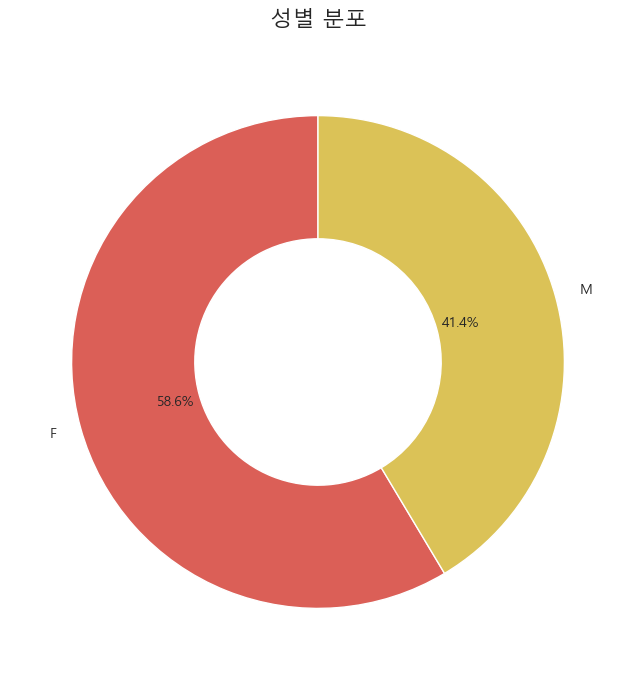

C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:31: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




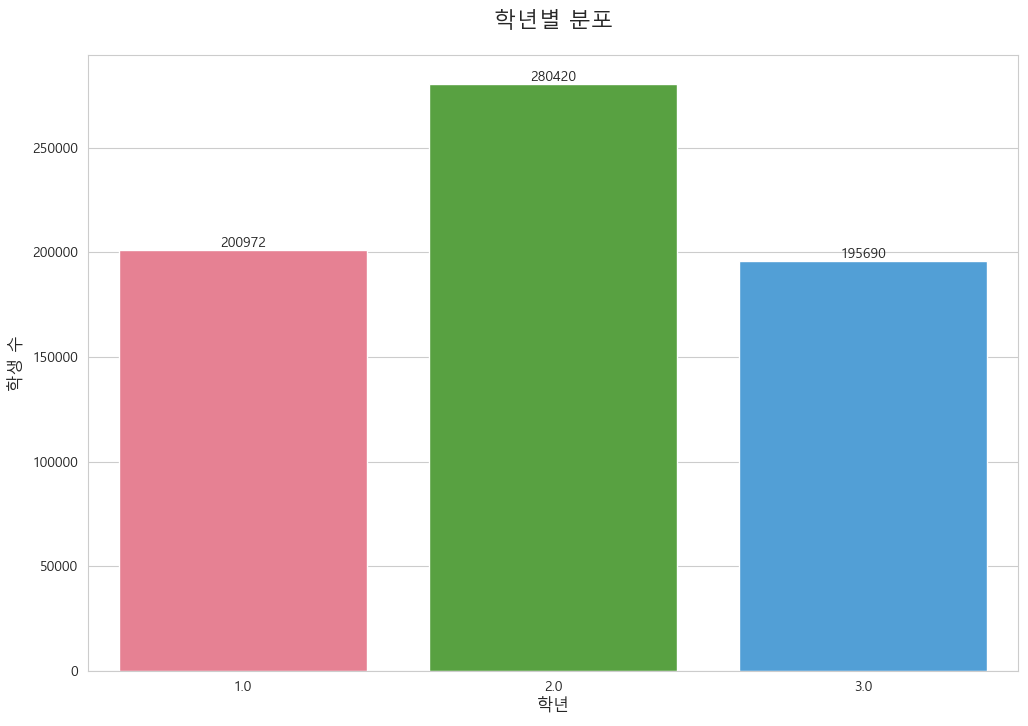

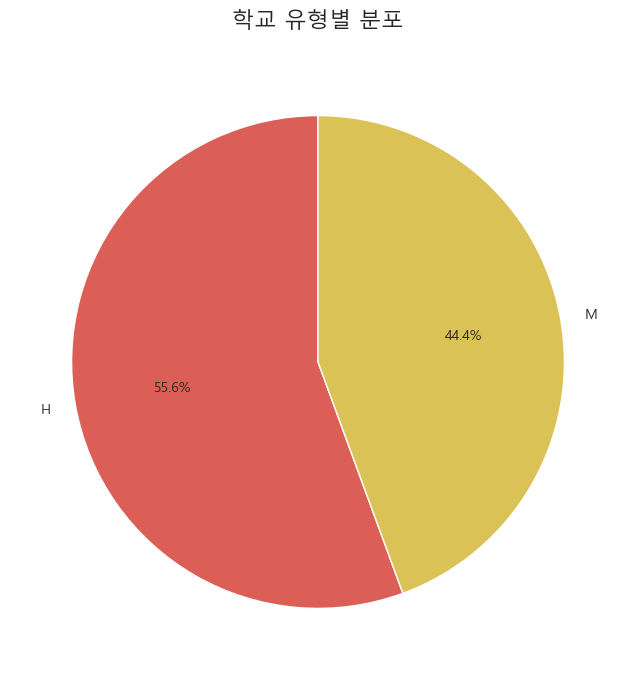

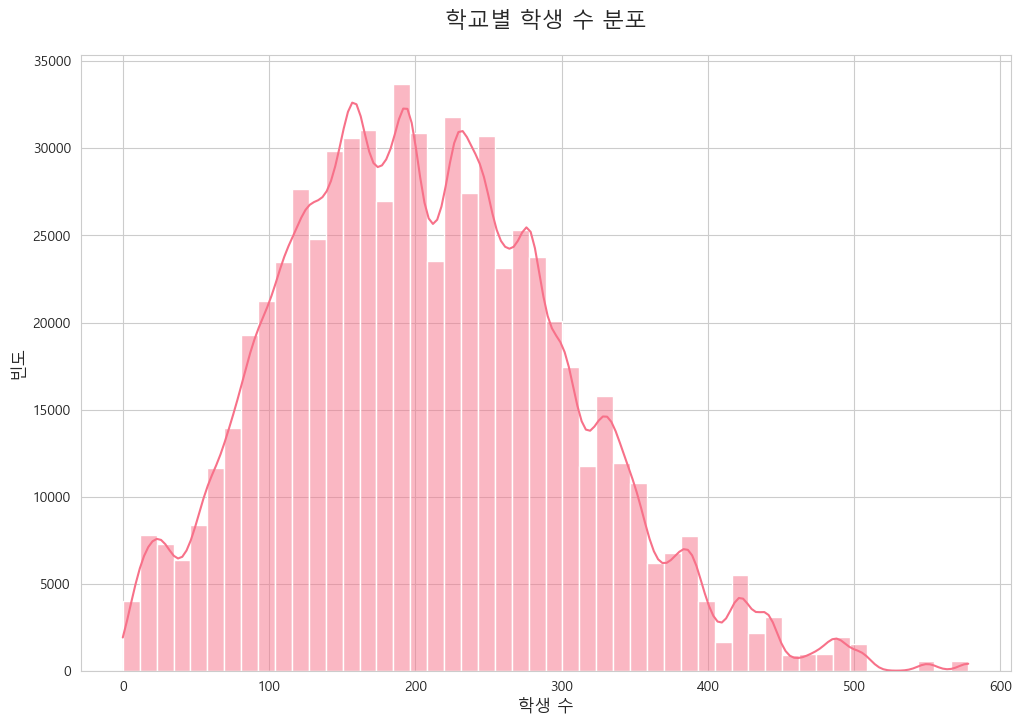

C:\Users\ypsoo\AppData\Local\Temp\ipykernel_39804\1176898481.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




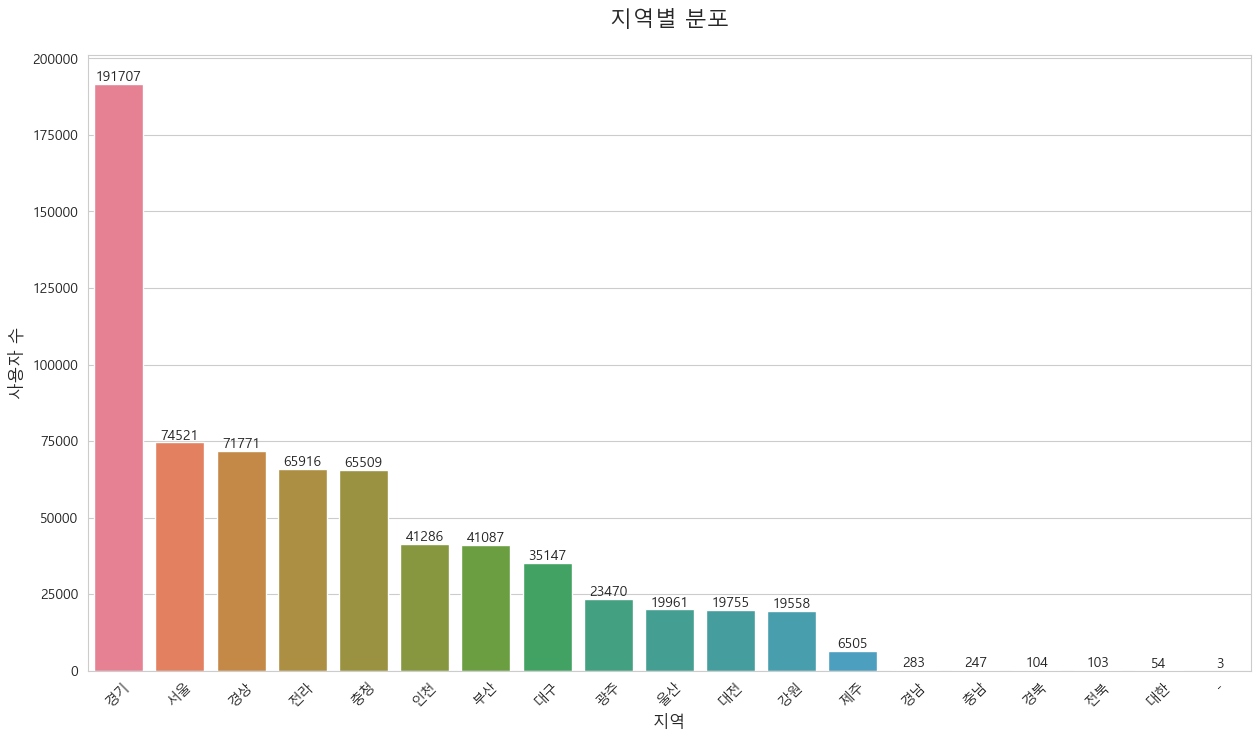

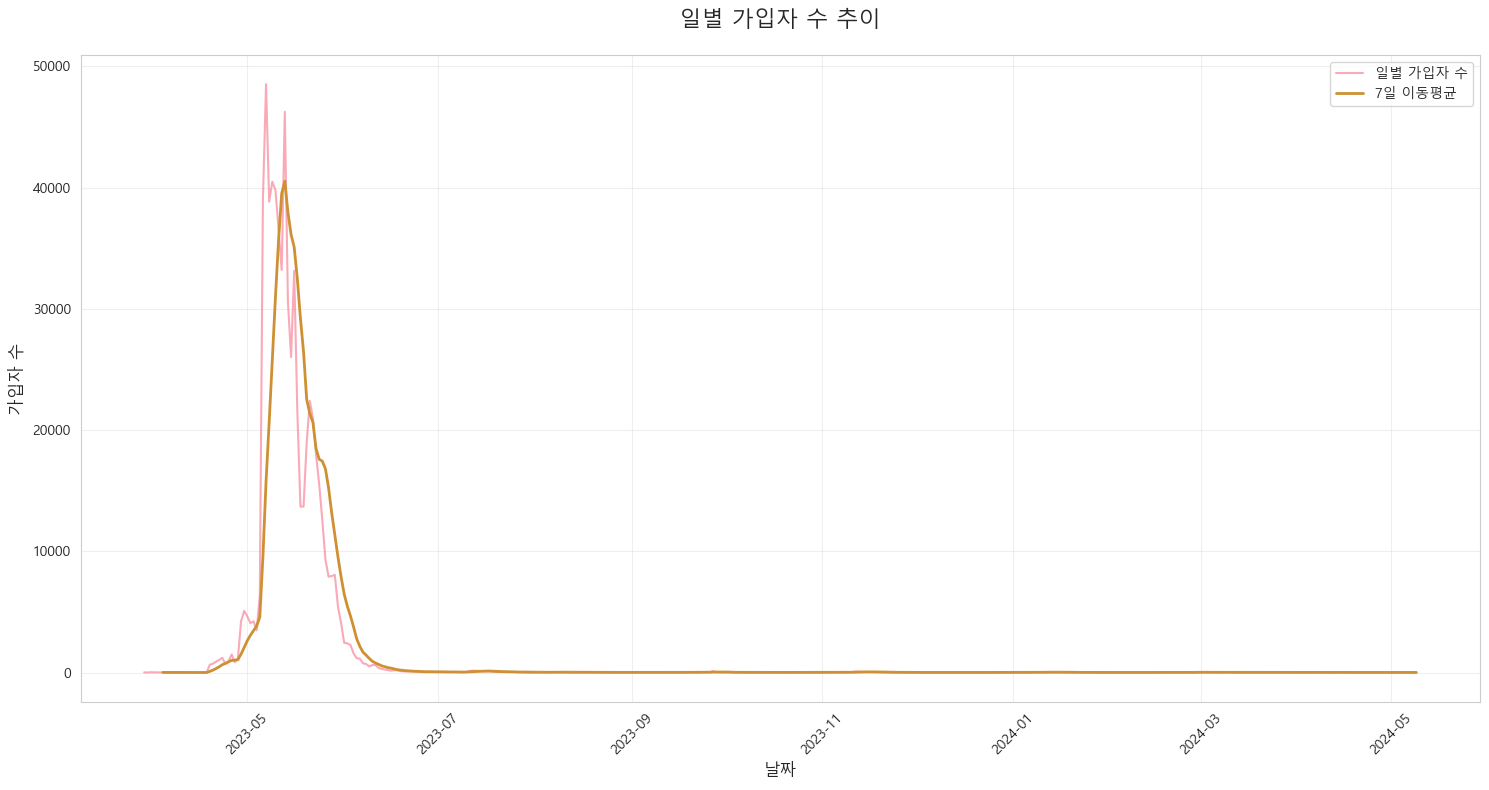

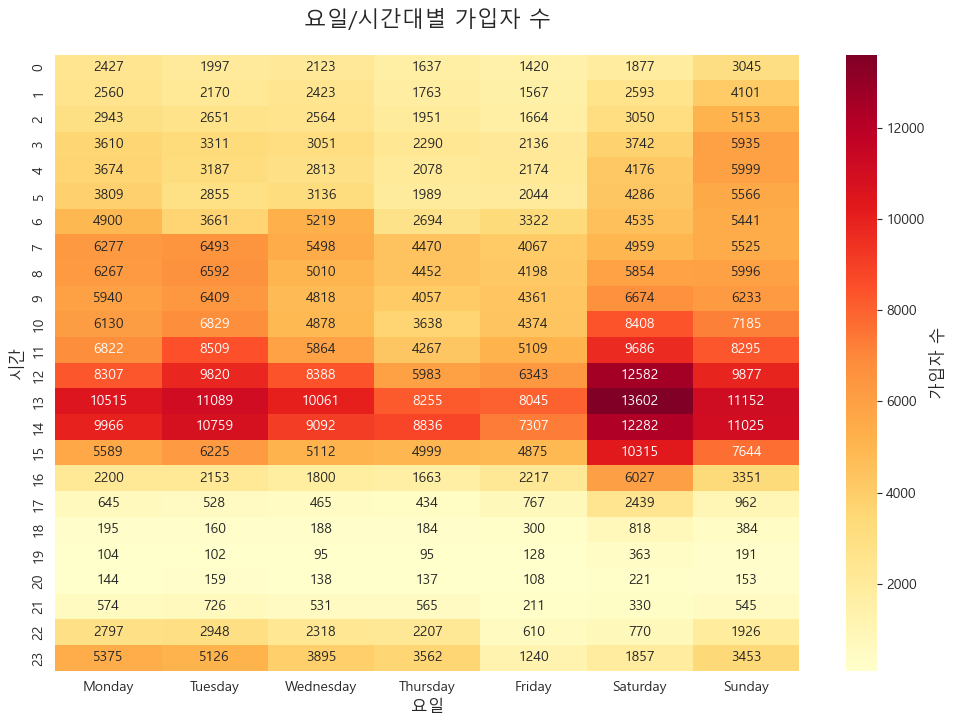

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# 색상 팔레트 설정
colors = sns.color_palette("husl", 8)
pie_colors = sns.color_palette("hls", 8)

# 1. 성별 분포 (도넛 차트)
plt.figure(figsize=(12, 8))
gender_counts = final_user_dataset['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
        colors=pie_colors, startangle=90,
        wedgeprops=dict(width=0.5))  # 도넛 형태로 만들기
plt.title('성별 분포', pad=20, fontsize=16)
plt.show()

# 2. 학년별 분포 (개선된 막대 그래프)
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=final_user_dataset, x='grade', y='grade', 
                 estimator=lambda x: len(x), ci=None,
                 palette='husl')
plt.title('학년별 분포', pad=20, fontsize=16)
plt.xlabel('학년', fontsize=12)
plt.ylabel('학생 수', fontsize=12)

# 막대 위에 숫자 표시
for i, v in enumerate(final_user_dataset['grade'].value_counts().sort_index()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 3. 학교 유형별 분포 (향상된 파이 차트)
plt.figure(figsize=(12, 8))
school_type_counts = final_user_dataset['school_type'].value_counts()
plt.pie(school_type_counts, labels=school_type_counts.index, 
        autopct='%1.1f%%', colors=pie_colors,
        startangle=90)
plt.title('학교 유형별 분포', pad=20, fontsize=16)
plt.show()

# 4. 학생 수 분포 (KDE plot 추가)
plt.figure(figsize=(12, 8))
sns.histplot(data=final_user_dataset, x='student_count', bins=50,
             kde=True, color=colors[0])
plt.title('학교별 학생 수 분포', pad=20, fontsize=16)
plt.xlabel('학생 수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.show()

# 5. 지역별 분포 (개선된 막대 그래프)
plt.figure(figsize=(15, 8))
final_user_dataset['region'] = final_user_dataset['address'].str[:2]
region_counts = final_user_dataset['region'].value_counts()

# 막대 그래프 생성
ax = sns.barplot(x=region_counts.index, y=region_counts.values, 
                 palette='husl')
plt.title('지역별 분포', pad=20, fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('지역', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)

# 막대 위에 숫자 표시
for i, v in enumerate(region_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 6. 시간에 따른 가입자 수 추이 (개선된 시계열 그래프)
plt.figure(figsize=(15, 8))
final_user_dataset['created_at'] = pd.to_datetime(final_user_dataset['created_at'])
daily_signups = final_user_dataset.resample('D', on='created_at')['id'].count()

# 7일 이동평균 추가
moving_avg = daily_signups.rolling(window=7).mean()

plt.plot(daily_signups.index, daily_signups.values, 
         alpha=0.6, label='일별 가입자 수', color=colors[0])
plt.plot(moving_avg.index, moving_avg.values, 
         label='7일 이동평균', color=colors[1], linewidth=2)

plt.title('일별 가입자 수 추이', pad=20, fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가입자 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 7. 요일별/시간별 가입자 수 히트맵 (개선된 버전)
plt.figure(figsize=(12, 8))
final_user_dataset['hour'] = final_user_dataset['created_at'].dt.hour
final_user_dataset['weekday'] = final_user_dataset['created_at'].dt.day_name()

# 요일 순서 지정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                 'Friday', 'Saturday', 'Sunday']

# 피벗 테이블 생성
heatmap_data = pd.pivot_table(
    final_user_dataset, 
    values='id',
    index='hour',
    columns='weekday',
    aggfunc='count'
)[weekday_order]  # 요일 순서 적용

# 히트맵 그리기
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g',
            cbar_kws={'label': '가입자 수'})
plt.title('요일/시간대별 가입자 수', pad=20, fontsize=16)
plt.xlabel('요일', fontsize=12)
plt.ylabel('시간', fontsize=12)
plt.show()

## join 시작

u 데이터를 만들고, 24h를 기준으로

In [ ]:
import pandas as pd
import numpy as np

# final_user_dataset에서 24h 기준이 될 가입 시각만 추출
u = final_user_dataset[['id', 'created_at', 'gender', 'grade', 'school_id', 'student_count', 'school_type', 'address']].copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')
u = u.rename(columns={'id': 'user_id', 'created_at': 'signup_time'})

u = u.dropna()

In [ ]:
u

user_id                signup_time gender  grade  school_id  \
11       833024 2023-03-31 09:05:51.903699      F    1.0     5464.0   
12       833041 2023-03-31 14:32:36.425315      F    3.0      314.0   
13       833112 2023-03-31 15:55:48.870381      M    3.0      281.0   
14       833113 2023-03-31 15:56:52.300066      M    1.0      272.0   
15       833154 2023-03-31 15:57:39.008717      F    1.0      272.0   
...         ...                        ...    ...    ...        ...   
677080  1583729 2024-05-08 21:54:33.621408      M    3.0     2389.0   
677081  1583730 2024-05-09 07:08:11.001817      M    3.0     2969.0   
677082  1583731 2024-05-09 07:22:19.186439      M    3.0     2579.0   
677083  1583732 2024-05-09 07:22:38.387553      F    3.0     2579.0   
677084  1583733 2024-05-09 08:31:17.710824      F    3.0     2240.0   

        student_count school_type       address  
11              158.0           H       경기도 군포시  
12              131.0           H  충청남도 천안시 동남구  
13              347.0           H  충청남도 천안시 서북구  
14              339.0           H  충청남도 천안시 서북구  
15              339.0           H  충청남도 천안시 서북구  
...               ...         ...           ...  
677080          301.0           H     서울특별시 구로구  
677081          256.0           M      대전광역시 중구  
677082          199.0           H     서울특별시 강남구  
677083          199.0           H     서울특별시 강남구  
677084          146.0           H     서울특별시 동작구  

[676987 rows x 8 columns]

함수 생성.

- **within_24h**: 가입 후 24시간 이내 이벤트만 필터링
- **agg_first_last_hours**: 가입 후 첫/마지막 이벤트 시점(시간) 계산
- **assert_single_user_id**: user_id 컬럼이 1개만 있는지 확인

In [ ]:
# 24시간 창 슬라이싱: key_user_col을 'user_id'로 표준화한 뒤 on='user_id'로 조인
def within_24h(df, key_user_col, time_col, u_base=None):
    t = df.copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    if key_user_col != 'user_id':
        t = t.rename(columns={key_user_col: 'user_id'})
    t = t.merge(u_base[['user_id','signup_time']], on='user_id', how='inner')
    mask = (t[time_col] >= t['signup_time']) & (t[time_col] < t['signup_time'] + pd.Timedelta(hours=24))
    return t.loc[mask].copy()

# 안전 확인용: user_id가 1개만 있는지 검사
def assert_single_user_id(df, name="df"):
    cnt = list(df.columns).count('user_id')
    if cnt != 1:
        raise AssertionError(f"{name}: 'user_id' 컬럼이 {cnt}개 존재")


In [ ]:
accounts_attendance

id                               attendance_date_list  user_id
0            1  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1446852
1            2  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1359398
2            3  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1501542
3            4  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1507767
4            5  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1287453
...        ...                                                ...      ...
349632  360501                                                 []   897005
349633  360502                                     ["2024-05-09"]  1407059
349634  360503                                     ["2024-05-09"]  1583727
349635  360504                                     ["2024-05-09"]  1392372
349636  360505                                     ["2024-05-09"]  1583730

[349637 rows x 3 columns]

### 결제 join
pay_24h_cnt만 유지

In [ ]:
# ------- 결제 성공: accounts_paymenthistory -------
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')

pay_24 = within_24h(pay, key_user_col='user_id', time_col='created_at', u_base=u)
pay_cnt  = pay_24.groupby('user_id').size().rename('pay_24h_cnt')

feat_pay = pay_cnt.to_frame()

print("feat_pay.shape:", feat_pay.shape)
feat_pay.head(3)

final_features = u.merge(feat_pay, on='user_id', how='left')
final_features['pay_24h_cnt'] = final_features['pay_24h_cnt'].fillna(0).astype(int)

feat_pay.shape: (13708, 1)


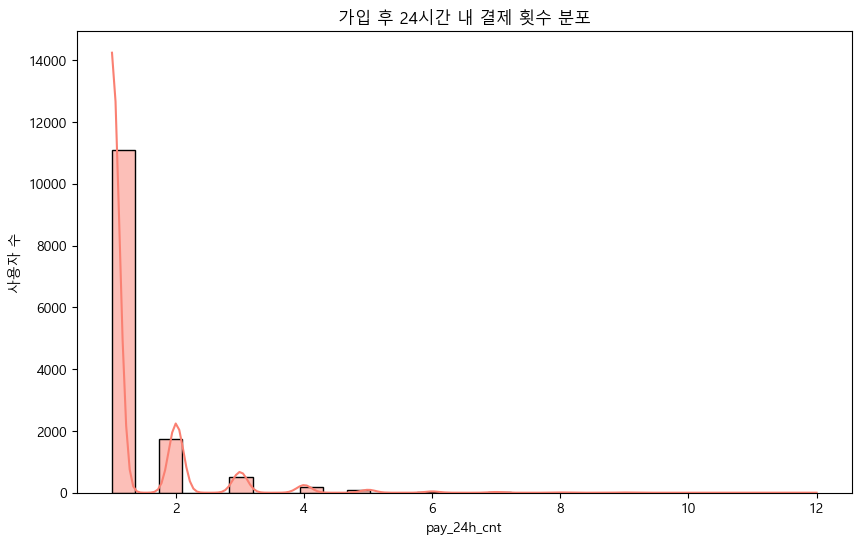

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(feat_pay['pay_24h_cnt'], bins=30, kde=True, color='salmon')
plt.title('가입 후 24시간 내 결제 횟수 분포')
plt.xlabel('pay_24h_cnt')
plt.ylabel('사용자 수')
plt.show()

In [ ]:
final_features.describe()

user_id                 signup_time          grade      school_id  \
count  6.769870e+05                      676987  676987.000000  676987.000000   
mean   1.212977e+06  2023-05-15 22:44:04.528038       1.992272    3113.791602   
min    8.330240e+05  2023-03-31 09:05:51.903699       1.000000       4.000000   
25%    1.028102e+06  2023-05-09 01:39:12.498951       1.000000    1649.000000   
50%    1.211735e+06  2023-05-13 10:51:03.883902       2.000000    3129.000000   
75%    1.397892e+06  2023-05-20 07:48:35.328402       3.000000    4691.000000   
max    1.583733e+06  2024-05-09 08:31:17.710824       3.000000    5965.000000   
std    2.138736e+05                         NaN       0.765340    1715.616687   

       student_count    pay_24h_cnt  
count  676987.000000  676987.000000  
mean      206.806301       0.026263  
min         0.000000       0.000000  
25%       136.000000       0.000000  
50%       199.000000       0.000000  
75%       272.000000       0.000000  
max       578.000000      12.000000  
std        97.384453       0.212732

### 포인트 join

In [ ]:
accounts_pointhistory

id  delta_point          created_at  user_id  \
0           790629            9 2023-04-28 12:27:49   849436   
1           790652            9 2023-04-28 12:28:02   849436   
2           790664            5 2023-04-28 12:28:09   849436   
3           790680           13 2023-04-28 12:28:16   849436   
4           790703            5 2023-04-28 12:28:26   849436   
...            ...          ...                 ...      ...   
2338913  340672371           14 2024-05-08 01:35:02   855509   
2338914  340672372           11 2024-05-08 01:36:00   855525   
2338915  340672373           11 2024-05-08 01:36:00   855526   
2338916  340672374           12 2024-05-08 01:36:18   855525   
2338917  340672375           12 2024-05-08 01:36:18   874566   

         user_question_record_id  
0                       771777.0  
1                       771800.0  
2                       771812.0  
3                       771828.0  
4                       771851.0  
...                          ...  
2338913              161666462.0  
2338914              161666463.0  
2338915              161666463.0  
2338916              161666464.0  
2338917              161666464.0  

[2338918 rows x 5 columns]

In [ ]:
accounts_pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[us]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[us](1), float64(1), int64(3)
memory usage: 89.2 MB


In [ ]:
# ------- 포인트: accounts_pointhistory -------
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
pt['delta_point'] = pd.to_numeric(pt.get('delta_point'), errors='coerce')

pt_24 = within_24h(pt, key_user_col='user_id', time_col='created_at', u_base=u)

# 필요한 컬럼만 계산
pt_agg = pt_24.groupby('user_id').agg(
    point_24h_events=('delta_point', 'size'),
    point_24h_pos_sum=('delta_point', lambda s: s[s > 0].sum() if len(s) else 0),
)

feat_point = pt_agg.copy()

print("feat_point.shape:", feat_point.shape)
feat_point.head(3)

# final_features와 feat_point를 user_id 기준으로 병합, 결측값은 0으로 채움
final_features = final_features.merge(feat_point, on='user_id', how='left')
final_features['point_24h_events'] = final_features['point_24h_events'].fillna(0).astype(int)
final_features['point_24h_pos_sum'] = final_features['point_24h_pos_sum'].fillna(0).astype(int)


feat_point.shape: (4618, 2)


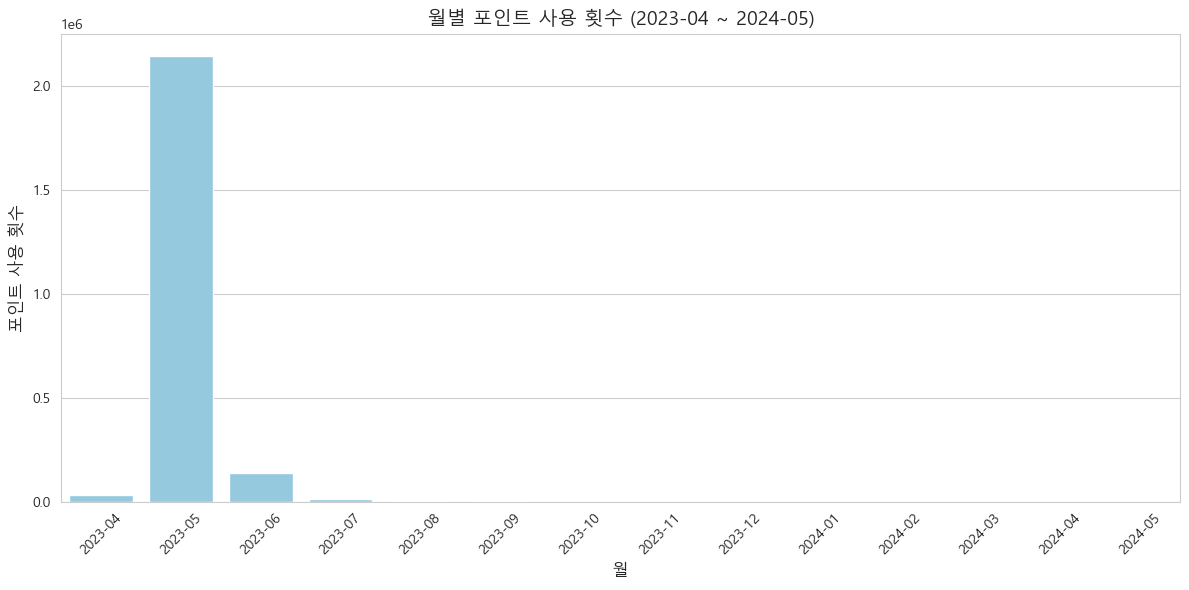

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# pt에서 2023-04 ~ 2024-05 기간만 필터링
pt['created_at'] = pd.to_datetime(pt['created_at'], errors='coerce')
pt_period = pt[(pt['created_at'] >= '2023-04-01') & (pt['created_at'] < '2024-06-01')]

# 월별 포인트 사용(이벤트) 횟수 집계
pt_period['month'] = pt_period['created_at'].dt.to_period('M')
monthly_counts = pt_period.groupby('month').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('월별 포인트 사용 횟수 (2023-04 ~ 2024-05)')
plt.xlabel('월')
plt.ylabel('포인트 사용 횟수')
plt.tight_layout()
plt.show()

In [ ]:
final_features.head()

user_id                signup_time gender  grade  school_id  student_count  \
0   833024 2023-03-31 09:05:51.903699      F    1.0     5464.0          158.0   
1   833041 2023-03-31 14:32:36.425315      F    3.0      314.0          131.0   
2   833112 2023-03-31 15:55:48.870381      M    3.0      281.0          347.0   
3   833113 2023-03-31 15:56:52.300066      M    1.0      272.0          339.0   
4   833154 2023-03-31 15:57:39.008717      F    1.0      272.0          339.0   

  school_type       address  pay_24h_cnt  point_24h_events  point_24h_pos_sum  
0           H       경기도 군포시            0                 0                  0  
1           H  충청남도 천안시 동남구            0                 0                  0  
2           H  충청남도 천안시 서북구            0                 0                  0  
3           H  충청남도 천안시 서북구            0                 0                  0  
4           H  충청남도 천안시 서북구            0                 0                  0

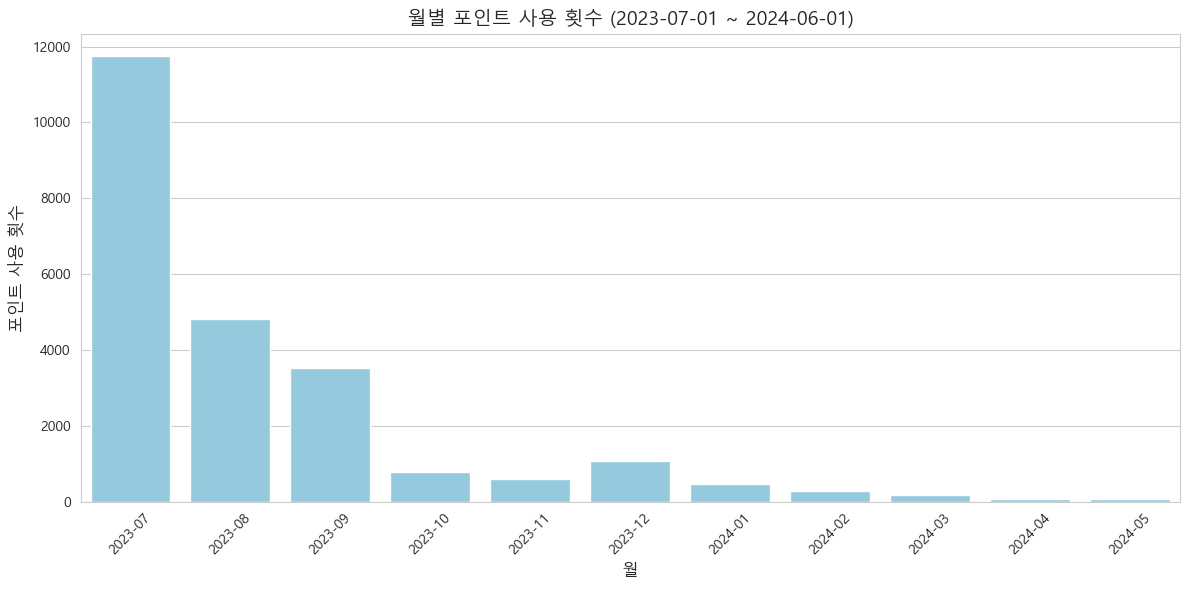

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# pt에서 2023-07 ~ 2024-06 기간만 필터링
pt['created_at'] = pd.to_datetime(pt['created_at'], errors='coerce')
pt_period = pt[(pt['created_at'] >= '2023-07-01') & (pt['created_at'] < '2024-06-01')]

# 월별 포인트 사용(이벤트) 횟수 집계
pt_period['month'] = pt_period['created_at'].dt.to_period('M')
monthly_counts = pt_period.groupby('month').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('월별 포인트 사용 횟수 (2023-07-01 ~ 2024-06-01)')
plt.xlabel('월')
plt.ylabel('포인트 사용 횟수')
plt.tight_layout()
plt.show()

### 친구 join

In [ ]:
# ------- 친구 요청: accounts_friendrequest -------
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
fr['updated_at'] = pd.to_datetime(fr.get('updated_at'), errors='coerce')

# 내가 "보낸" 요청 (생성 시각 기준)
fr_send_24 = within_24h(
    fr.rename(columns={'send_user_id': 'user_id'}),
    key_user_col='user_id', time_col='created_at', u_base=u
)

# 내가 "받은" 요청 (생성 시각 기준)
fr_recv_24 = within_24h(
    fr.rename(columns={'receive_user_id': 'user_id'}),
    key_user_col='user_id', time_col='created_at', u_base=u
)

# 수락된 요청만 (업데이트 시각 기준)
fr_acc = fr[fr['status'] == 'A'].copy()

# 내가 보낸 요청이 수락됨 (sender 시점, updated_at)
fr_acc_send_24 = within_24h(
    fr_acc.rename(columns={'send_user_id': 'user_id'}),
    key_user_col='user_id', time_col='updated_at', u_base=u
)

# 내가 받은 요청을 수락함 (receiver 시점, updated_at)
fr_acc_recv_24 = within_24h(
    fr_acc.rename(columns={'receive_user_id': 'user_id'}),
    key_user_col='user_id', time_col='updated_at', u_base=u
)

# --- 카운트만 사용 ---
send_cnt = fr_send_24.groupby('user_id').size().rename('friendreq_send_24h_cnt')
recv_cnt = fr_recv_24.groupby('user_id').size().rename('friendreq_recv_24h_cnt')
acc_as_sender_cnt = fr_acc_send_24.groupby('user_id').size().rename('friendreq_accept_as_sender_24h_cnt')
acc_as_receiver_cnt = fr_acc_recv_24.groupby('user_id').size().rename('friendreq_accept_as_receiver_24h_cnt')

# --- 최소 피처셋 구성 ---
feat_friend = pd.concat(
    [send_cnt, recv_cnt, acc_as_sender_cnt, acc_as_receiver_cnt],
    axis=1
)

# 결측 0 대체(카운트 계열만)
for c in [
    'friendreq_send_24h_cnt',
    'friendreq_recv_24h_cnt',
    'friendreq_accept_as_sender_24h_cnt',
    'friendreq_accept_as_receiver_24h_cnt'
]:
    if c in feat_friend.columns:
        feat_friend[c] = feat_friend[c].fillna(0).astype('int32')

# 24h 내 성사된 친구 수 = (보낸 요청 수락 + 받은 요청 수락)
feat_friend['friend_24h_new_cnt'] = (
    feat_friend['friendreq_accept_as_sender_24h_cnt']
    + feat_friend['friendreq_accept_as_receiver_24h_cnt']
).astype('int32')

# 최종: 보낸/받은 요청 수 + 총 친구 수만 남김
feat_friend = feat_friend[[
    'friendreq_send_24h_cnt',
    'friendreq_recv_24h_cnt',
    'friend_24h_new_cnt'
]]

In [ ]:
feat_friend

friendreq_send_24h_cnt  friendreq_recv_24h_cnt  friend_24h_new_cnt
user_id                                                                    
837523                        1                       0                   0
837524                        1                       2                   3
837526                        4                      21                  17
837527                       16                      26                  35
837528                        4                      11                  11
...                         ...                     ...                 ...
1583392                       0                       1                   1
1583400                       0                       4                   1
1583645                       0                       1                   0
1583660                       0                       1                   0
1583713                       0                       3                   3

[652816 rows x 3 columns]

In [ ]:
# feat_friend과 final_features를 user_id 기준으로 병합
final_features = final_features.merge(feat_friend, on='user_id', how='left')

# 결측값은 0으로 채움 (친구 관련 컬럼만)
for col in ['friendreq_send_24h_cnt', 'friendreq_recv_24h_cnt', 'friend_24h_new_cnt']:
    if col in final_features.columns:
        final_features[col] = final_features[col].fillna(0).astype(int)


In [ ]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676987 entries, 0 to 676986
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   user_id                   676987 non-null  int64         
 1   signup_time               676987 non-null  datetime64[us]
 2   gender                    676987 non-null  object        
 3   grade                     676987 non-null  float64       
 4   school_id                 676987 non-null  float64       
 5   student_count             676987 non-null  float64       
 6   school_type               676987 non-null  object        
 7   address                   676987 non-null  object        
 8   pay_24h_cnt               676987 non-null  int64         
 9   point_24h_events          676987 non-null  int64         
 10  point_24h_pos_sum         676987 non-null  int64         
 11  friendreq_send_24h_cnt_x  652816 non-null  float64       
 12  fr

### 투표 join

In [ ]:
# 유저아이디 1583730의 회원 가입시간
signup_time = u.loc[u['user_id'] == 855509, 'signup_time'].iloc[0]
print("가입 시간:", signup_time)

# 유저아이디 1583730의 첫 투표 시간 (내가 투표한 기록)
first_vote_time = v_cast_24.loc[v_cast_24['user_id'] == 855509, 'created_at'].min()
print("첫 투표 시간:", first_vote_time)

가입 시간: 2023-04-29 16:40:15.299841
첫 투표 시간: 2023-04-29 17:38:17


In [ ]:
def within_24h_v2(df, key_user_col, time_col, u_base=None):
    if u_base is None:
        raise ValueError("u_base(DataFrame)가 필요합니다. Step 1의 u를 전달하세요.")
    if not {'user_id','signup_time'}.issubset(u_base.columns):
        raise ValueError("u_base에는 ['user_id','signup_time'] 필요")

    # 꼭 필요한 컬럼만 가져와 충돌 여지 축소
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])  # chosen_user_id 결측 제거

    # 유저 키 표준화
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:   # 충돌 방지
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})

    # u_base 중복/결측 정리(유저당 1행 보장)
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna(subset=['user_id','signup_time'])
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # dtype 정렬(조인 키 타입 불일치 예방)
    try:
        t['user_id'] = t['user_id'].astype(u_uniq['user_id'].dtype, copy=False)
    except Exception:
        # 마지막 수단: 문자열로 맞춤
        t['user_id'] = t['user_id'].astype(str)
        u_uniq['user_id'] = u_uniq['user_id'].astype(str)

    # 조인 및 24시간 슬라이스
    t = t.merge(u_uniq, on='user_id', how='inner')
    mask = (t[time_col] >= t['signup_time']) & (t[time_col] < t['signup_time'] + pd.Timedelta(hours=24))
    out = t.loc[mask].copy()

    # 안전 확인: 컬럼명 충돌만 체크(원래 로직 유지)
    cnt = list(out.columns).count('user_id')
    if cnt != 1:
        raise AssertionError(f"within_24h 결과에 'user_id' 컬럼이 {cnt}개 존재")
    return out


In [ ]:
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')

# 내가 투표한 기록
v_cast_24 = within_24h(v, key_user_col='user_id', time_col='created_at', u_base=u)
assert_single_user_id(v_cast_24, 'v_cast_24')
cast_cnt  = v_cast_24.groupby('user_id').size().rename('vote_cast_24h_cnt')

# 내가 선택받은 기록
v_recv_24 = within_24h_v2(v, key_user_col='chosen_user_id', time_col='created_at', u_base=u)
assert_single_user_id(v_recv_24, 'v_recv_24')
recv_cnt  = v_recv_24.groupby('user_id').size().rename('vote_received_24h_cnt')

In [ ]:
feat_vote = pd.concat([cast_cnt, recv_cnt], axis=1).fillna(0).astype(int)
# feat_vote와 final_features를 user_id 기준으로 병합
final_features = final_features.merge(feat_vote, on='user_id', how='left')

In [ ]:
feat_vote

vote_cast_24h_cnt  vote_received_24h_cnt
user_id                                          
849103                   8                      0
849436                 116                     69
849438                  37                     66
849439                  45                    106
849441                  25                     58
...                    ...                    ...
1567894                  0                      5
1568718                  0                      2
1571427                  0                      2
1571616                  0                      2
1579422                  0                      1

[8279 rows x 2 columns]

In [ ]:
final_features = final_features.fillna(0)

### 타겟변수 생성

In [ ]:
# 24시간 이후 슬라이서
def beyond_24h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=24))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 24h 이후 활동 user_id 뽑기 -------
ids = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids.append(beyond_24h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids.append(beyond_24h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids.append(beyond_24h(fr.rename(columns={'send_user_id':'user_id'}),    'user_id', 'created_at', u))
ids.append(beyond_24h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids.append(beyond_24h(v,                                'user_id',        'created_at', u))
ids.append(beyond_24h(v,                                'chosen_user_id', 'created_at', u))

# (선택) 5) 앱 이벤트 로그가 있으면 포함
# ev = hackle_events.copy()
# ev['event_time'] = pd.to_datetime(ev.get('event_time'), errors='coerce')
# ids.append(beyond_24h(ev.rename(columns={'user_id_col':'user_id'}), 'user_id', 'event_time', u))

# ------- 유저 단위 타깃 생성 -------
post24_active_ids = pd.concat(ids, axis=0, ignore_index=True).drop_duplicates()
target_post24 = pd.Series(0, index=u['user_id'], name='target_post24_active').astype('int8')
target_post24.loc[target_post24.index.isin(post24_active_ids['user_id'])] = 1

feat_24h_W = final_features.copy()

# 마스터에 조인
feat_24h_W = feat_24h_W.merge(target_post24.rename_axis('user_id').reset_index(),
                              on='user_id', how='left').fillna({'target_post24_active':0})
feat_24h_W['target_post24_active'] = feat_24h_W['target_post24_active'].astype('int8')

print("post24_active rate:", float(feat_24h_W['target_post24_active'].mean()))


post24_active rate: 0.9711722677097196


In [ ]:
# 48시간 이후 슬라이서 함수 정의
def beyond_48h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 48시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=48))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 48h 이후 활동 user_id 뽑기 -------
ids_48h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_48h.append(beyond_48h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_48h.append(beyond_48h(v, 'user_id', 'created_at', u))
ids_48h.append(beyond_48h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (48시간 버전) -------
post48_active_ids = pd.concat(ids_48h, axis=0, ignore_index=True).drop_duplicates()
target_post48 = pd.Series(0, index=u['user_id'], name='target_post48_active').astype('int8')
target_post48.loc[target_post48.index.isin(post48_active_ids['user_id'])] = 1

# feat_24h_W에 48시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post48.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post48_active':0})

feat_24h_W['target_post48_active'] = feat_24h_W['target_post48_active'].astype('int8')

print("post48_active rate:", float(feat_24h_W['target_post48_active'].mean()))

# 24시간과 48시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post48_active rate: 0.9609253944315032

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동
1    0.971172    0.960925
0    0.028828    0.039075


In [ ]:
# 72시간 이후 슬라이서 함수 정의
def beyond_72h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 72시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=72))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 72h 이후 활동 user_id 뽑기 -------
ids_72h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_72h.append(beyond_72h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_72h.append(beyond_72h(v, 'user_id', 'created_at', u))
ids_72h.append(beyond_72h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (72시간 버전) -------
post72_active_ids = pd.concat(ids_72h, axis=0, ignore_index=True).drop_duplicates()
target_post72 = pd.Series(0, index=u['user_id'], name='target_post72_active').astype('int8')
target_post72.loc[target_post72.index.isin(post72_active_ids['user_id'])] = 1

# feat_24h_W에 72시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post72.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post72_active':0})

feat_24h_W['target_post72_active'] = feat_24h_W['target_post72_active'].astype('int8')

print("post72_active rate:", float(feat_24h_W['target_post72_active'].mean()))

# 24시간, 48시간, 72시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post72_active rate: 0.947399285362939

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동  72시간 이후 활동
1    0.971172    0.960925    0.947399
0    0.028828    0.039075    0.052601


In [ ]:
# 120시간(5일) 이후 슬라이서 함수 정의
def beyond_120h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 120시간으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=120))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 120h 이후 활동 user_id 뽑기 -------
ids_120h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_120h.append(beyond_120h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_120h.append(beyond_120h(v, 'user_id', 'created_at', u))
ids_120h.append(beyond_120h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (120시간 버전) -------
post120_active_ids = pd.concat(ids_120h, axis=0, ignore_index=True).drop_duplicates()
target_post120 = pd.Series(0, index=u['user_id'], name='target_post120_active').astype('int8')
target_post120.loc[target_post120.index.isin(post120_active_ids['user_id'])] = 1

# feat_24h_W에 120시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post120.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post120_active':0})

feat_24h_W['target_post120_active'] = feat_24h_W['target_post120_active'].astype('int8')

print("post120_active rate:", float(feat_24h_W['target_post120_active'].mean()))

# 24시간, 48시간, 72시간, 120시간 타겟 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True),
    '120시간 이후 활동': feat_24h_W['target_post120_active'].value_counts(normalize=True)
})


post120_active rate: 0.9088638334266389


In [ ]:
# 336시간(2주) 이후 슬라이서 함수 정의
def beyond_336h(df, key_user_col, time_col, u_base):
    t = df[[key_user_col, time_col]].copy()
    t[time_col] = pd.to_datetime(t[time_col], errors='coerce')
    t = t.dropna(subset=[key_user_col])
    if key_user_col != 'user_id':
        if 'user_id' in t.columns:
            t = t.drop(columns=['user_id'])
        t = t.rename(columns={key_user_col: 'user_id'})
    u_uniq = (u_base[['user_id','signup_time']]
              .dropna()
              .sort_values('signup_time')
              .drop_duplicates('user_id', keep='first'))
    u_uniq['signup_time'] = pd.to_datetime(u_uniq['signup_time'], errors='coerce')

    # 조인
    t = t.merge(u_uniq, on='user_id', how='inner')
    # 336시간(2주)으로 수정
    mask = t[time_col] >= (t['signup_time'] + pd.Timedelta(hours=336))
    return t.loc[mask, ['user_id']].drop_duplicates()

# ------- 각 소스별: 336h 이후 활동 user_id 뽑기 -------
ids_336h = []

# 1) 결제 성공
pay = accounts_paymenthistory.copy()
pay['created_at'] = pd.to_datetime(pay.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(pay, 'user_id', 'created_at', u))

# 2) 포인트
pt = accounts_pointhistory.copy()
pt['created_at']  = pd.to_datetime(pt.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(pt, 'user_id', 'created_at', u))

# 3) 친구요청 (보냄/받음)
fr = accounts_friendrequest.copy()
fr['created_at'] = pd.to_datetime(fr.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(fr.rename(columns={'send_user_id':'user_id'}), 'user_id', 'created_at', u))
ids_336h.append(beyond_336h(fr.rename(columns={'receive_user_id':'user_id'}), 'user_id', 'created_at', u))

# 4) 투표 (내가 투표 / 내가 선택됨)
v = accounts_userquestionrecord.copy()
v['created_at'] = pd.to_datetime(v.get('created_at'), errors='coerce')
ids_336h.append(beyond_336h(v, 'user_id', 'created_at', u))
ids_336h.append(beyond_336h(v, 'chosen_user_id', 'created_at', u))

# ------- 유저 단위 타깃 생성 (336시간 버전) -------
post336_active_ids = pd.concat(ids_336h, axis=0, ignore_index=True).drop_duplicates()
target_post336 = pd.Series(0, index=u['user_id'], name='target_post336_active').astype('int8')
target_post336.loc[target_post336.index.isin(post336_active_ids['user_id'])] = 1

# feat_24h_W에 336시간 타겟 추가
feat_24h_W = feat_24h_W.merge(
    target_post336.rename_axis('user_id').reset_index(),
    on='user_id', 
    how='left'
).fillna({'target_post336_active':0})

feat_24h_W['target_post336_active'] = feat_24h_W['target_post336_active'].astype('int8')

print("post336_active rate:", float(feat_24h_W['target_post336_active'].mean()))

# 모든 타겟 변수 비교
comparison = pd.DataFrame({
    '24시간 이후 활동': feat_24h_W['target_post24_active'].value_counts(normalize=True),
    '48시간 이후 활동': feat_24h_W['target_post48_active'].value_counts(normalize=True),
    '72시간 이후 활동': feat_24h_W['target_post72_active'].value_counts(normalize=True),
    '120시간 이후 활동': feat_24h_W['target_post120_active'].value_counts(normalize=True),
    '336시간 이후 활동': feat_24h_W['target_post336_active'].value_counts(normalize=True)
})
print("\n타겟 변수 비교:")
print(comparison)

post336_active rate: 0.6497052380621784

타겟 변수 비교:
   24시간 이후 활동  48시간 이후 활동  72시간 이후 활동  120시간 이후 활동  336시간 이후 활동
1    0.971172    0.960925    0.947399     0.908864     0.649705
0    0.028828    0.039075    0.052601     0.091136     0.350295


### 최종 데이터셋

In [ ]:
feat_24h_W

user_id                signup_time gender  grade  school_id  \
0        833024 2023-03-31 09:05:51.903699      F    1.0     5464.0   
1        833041 2023-03-31 14:32:36.425315      F    3.0      314.0   
2        833112 2023-03-31 15:55:48.870381      M    3.0      281.0   
3        833113 2023-03-31 15:56:52.300066      M    1.0      272.0   
4        833154 2023-03-31 15:57:39.008717      F    1.0      272.0   
...         ...                        ...    ...    ...        ...   
676982  1583729 2024-05-08 21:54:33.621408      M    3.0     2389.0   
676983  1583730 2024-05-09 07:08:11.001817      M    3.0     2969.0   
676984  1583731 2024-05-09 07:22:19.186439      M    3.0     2579.0   
676985  1583732 2024-05-09 07:22:38.387553      F    3.0     2579.0   
676986  1583733 2024-05-09 08:31:17.710824      F    3.0     2240.0   

        student_count school_type       address  pay_24h_cnt  \
0               158.0           H       경기도 군포시            0   
1               131.0           H  충청남도 천안시 동남구            0   
2               347.0           H  충청남도 천안시 서북구            0   
3               339.0           H  충청남도 천안시 서북구            0   
4               339.0           H  충청남도 천안시 서북구            0   
...               ...         ...           ...          ...   
676982          301.0           H     서울특별시 구로구            0   
676983          256.0           M      대전광역시 중구            0   
676984          199.0           H     서울특별시 강남구            0   
676985          199.0           H     서울특별시 강남구            0   
676986          146.0           H     서울특별시 동작구            0   

        point_24h_events  point_24h_pos_sum  friendreq_send_24h_cnt  \
0                      0                  0                       0   
1                      0                  0                       0   
2                      0                  0                       0   
3                      0                  0                       0   
4                      0                  0                       0   
...                  ...                ...                     ...   
676982                 0                  0                       0   
676983                 0                  0                      20   
676984                 0                  0                       1   
676985                 0                  0                       3   
676986                 0                  0                       0   

        friendreq_recv_24h_cnt  friend_24h_new_cnt  vote_cast_24h_cnt  \
0                            0                   0                0.0   
1                            0                   0                0.0   
2                            0                   0                0.0   
3                            0                   0                0.0   
4                            0                   0                0.0   
...                        ...                 ...                ...   
676982                       0                   0                0.0   
676983                       2                   1                0.0   
676984                       2                   2                0.0   
676985                       0                   2                0.0   
676986                       0                   0                0.0   

        vote_received_24h_cnt  target_post24_active  
0                         0.0                     1  
1                         0.0                     1  
2                         0.0                     1  
3                         0.0                     1  
4                         0.0                     1  
...                       ...                   ...  
676982                    0.0                     0  
676983                    0.0                     0  
676984                    0.0                     0  
676985                    0.0                     0  
676986                    0.0                     0  

[676987

In [ ]:
feat_24h_W.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676987 entries, 0 to 676986
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 676987 non-null  int64         
 1   signup_time             676987 non-null  datetime64[us]
 2   gender                  676987 non-null  object        
 3   grade                   676987 non-null  float64       
 4   school_id               676987 non-null  float64       
 5   student_count           676987 non-null  float64       
 6   school_type             676987 non-null  object        
 7   address                 676987 non-null  object        
 8   pay_24h_cnt             676987 non-null  int64         
 9   point_24h_events        676987 non-null  int64         
 10  point_24h_pos_sum       676987 non-null  int64         
 11  friendreq_send_24h_cnt  676987 non-null  int64         
 12  friendreq_recv_24h_cnt  676987

In [ ]:
# 0과 1의 분포 비율 계산
ratio = feat_24h_W['target_post24_active'].value_counts(normalize=True)
print(ratio)

target_post24_active
1    0.971172
0    0.028828
Name: proportion, dtype: float64


In [ ]:
# 0과 1의 분포 비율 계산
ratio = feat_24h_W['target_post336_active'].value_counts(normalize=True)
print(ratio)

target_post336_active
1    0.649705
0    0.350295
Name: proportion, dtype: float64


In [ ]:
feat_24h_W.to_csv("feat_24h_W.csv", index=False, encoding="utf-8-sig")

## 모델 생성

In [ ]:
# 데이터 처리
import pandas as pd

In [ ]:
feat_24h_W = pd.read_csv("feat_24h_W.csv")

In [ ]:
# 기본 라이브러리
import pandas as pd
from sklearn.model_selection import train_test_split

feature_cols = [
    "signup_time", "gender", "grade", "school_id", "student_count", "school_type",
    "pay_24h_cnt", "point_24h_events", "point_24h_pos_sum",
    "friendreq_send_24h_cnt", "friendreq_recv_24h_cnt", "friend_24h_new_cnt",
    "vote_cast_24h_cnt", "vote_received_24h_cnt",
]

target_col = "target_post336_active"

# X, y 구성
X = feat_24h_W[feature_cols].copy()
y = feat_24h_W[target_col].astype(int)

# train/test 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 확인용 출력(필요시 주석 처리)
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))


(541589, 14) (135398, 14)
target_post336_active
1    0.65
0    0.35
Name: proportion, dtype: float64
target_post336_active
1    0.65
0    0.35
Name: proportion, dtype: float64


#### 1. 기본 LightGBM 모델 돌려서 baseline 성능 확인

#### 2. 간단한 RandomizedSearchCV로 주요 파라미터 조정

#### 3. 최적 파라미터로 다시 학습 → 피처 중요도, SHAP 분석

In [ ]:
# 0) 준비
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) 간단 전처리: datetime 파생, object→category
def add_basic_time_feats(df):
    df = df.copy()
    if "signup_time" in df.columns and np.issubdtype(df["signup_time"].dtype, np.datetime64):
        df["signup_hour"] = df["signup_time"].dt.hour
        df["signup_dow"]  = df["signup_time"].dt.dayofweek
        df.drop(columns=["signup_time"], inplace=True)
    return df

def make_categorical(df):
    df = df.copy()
    for c in df.select_dtypes(include=["object"]).columns:
        df[c] = df[c].astype("category")
    return df

X_train_p = make_categorical(add_basic_time_feats(X_train))
X_test_p  = make_categorical(add_basic_time_feats(X_test))

In [ ]:
# LightGBM에 카테고리 컬럼 전달
cat_cols = list(X_train_p.select_dtypes(include=["category"]).columns)

In [ ]:
# 2) 클래스 불균형 보정 값 (neg/pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0

In [ ]:
# 3) 베이스라인 모델 학습 + 조기종료
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary",
    class_weight=None,              # scale_pos_weight 사용
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train_p, y_train,
    eval_set=[(X_train_p, y_train), (X_test_p, y_test)],
    eval_metric="auc",
    categorical_feature=cat_cols,
    callbacks=[]
)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=300,
               n_jobs=-1, objective='binary', random_state=42, reg_lambda=1.0,
               scale_pos_weight=np.float64(0.5391604357253895), subsample=0.9)

In [ ]:
# 베이스라인 모델 성능

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np

# 4) 기본 성능 확인 + 추가 지표
proba = lgbm.predict_proba(X_test_p)[:, 1]
roc = roc_auc_score(y_test, proba)

prec, rec, th = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)

print(f"[Baseline] ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")

def eval_at_threshold(y_true, proba, thr: float):
    pred = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, pred)
    p   = precision_score(y_true, pred, zero_division=0)
    r   = recall_score(y_true, pred, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    cm  = confusion_matrix(y_true, pred)  # [[TN, FP],[FN, TP]]
    return {"threshold": thr, "accuracy": acc, "precision": p, "recall": r, "f1": f1, "cm": cm}

# 4-1) 기본 임계값(0.5)
m_default = eval_at_threshold(y_test, proba, 0.5)
print("\n[Metrics @0.5]")
print(f"ACC: {m_default['accuracy']:.4f} | P: {m_default['precision']:.4f} | R: {m_default['recall']:.4f} | F1: {m_default['f1']:.4f}")
print("Confusion Matrix [[TN FP],[FN TP]]:\n", m_default["cm"])

# 4-2) F1 최대 임계값 탐색 (precision_recall_curve 결과 활용)
# precision_recall_curve는 마지막 점(임계값 없음)을 포함하므로, 길이 정렬에 유의
f1_candidates = (2 * prec * rec) / (prec + rec + 1e-12)
# th 길이는 len(prec)-1이므로 마지막 점 제외 후 정렬
best_idx = np.nanargmax(f1_candidates[:-1])
best_thr = th[best_idx]

m_best = eval_at_threshold(y_test, proba, float(best_thr))
print(f"\n[Best-F1 Threshold] thr: {best_thr:.4f}")
print(f"ACC: {m_best['accuracy']:.4f} | P: {m_best['precision']:.4f} | R: {m_best['recall']:.4f} | F1: {m_best['f1']:.4f}")
print("Confusion Matrix [[TN FP],[FN TP]]:\n", m_best["cm"])

[Baseline] ROC-AUC: 0.7404 | PR-AUC: 0.8309

[Metrics @0.5]
ACC: 0.6820 | P: 0.7878 | R: 0.6988 | F1: 0.7407
Confusion Matrix [[TN FP],[FN TP]]:
 [[30872 16557]
 [26494 61475]]

[Best-F1 Threshold] thr: 0.2801
ACC: 0.7023 | P: 0.6999 | R: 0.9486 | F1: 0.8055
Confusion Matrix [[TN FP],[FN TP]]:
 [[11641 35788]
 [ 4520 83449]]


### 모델 결과 해석

 1. 전반적 성능
- **ROC-AUC: 0.76 / PR-AUC: 0.84**
- 무작위 수준(0.5)보다 충분히 높은 성능으로, 초기 예측 모델로서 양호한 수준으로 평가됨
- 특히 PR-AUC이 높아 불균형 데이터 환경에서도 안정적인 성능을 보임

 2. 임계값 0.5 기준
- Precision: 0.79 / Recall: 0.74 / F1: 0.76
- Confusion Matrix 결과 **FN(잔존인데 놓친 유저)**가 2만 건 이상 발생
- 운영적으로 **잔존 유저를 놓치는 문제**가 있음

 3. Best-F1 기준 (임계값 ≈ 0.29)
- Precision: 0.72 / Recall: 0.95 / F1: 0.82
- 잔존 유저를 거의 다 잡아내지만(FN 급감), **떠날 유저까지 잘못 타깃팅(FP 증가)**하는 부작용 발생

 4. 해석 및 제언
- 모델은 **잔존 여부를 의미 있게 구분**하고 있음
- 다만 임계값 선택에 따라 “누굴 놓칠지 vs 누구를 잘못 잡을지”가 크게 달라짐
- **Recall 확보(임계값 낮춤)** 방향이 더 적절
  - 초기 리텐션 확보가 중요하다면 FP 비용보다 FN 손실이 더 크기 때문

In [ ]:
# 전제: X_train_p, X_test_p, y_train, y_test, cat_cols, scale_pos_weight 존재
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    make_scorer, fbeta_score
)

# 탐색 공간(축소형)
param_dist = {
    "num_leaves":        np.arange(16, 96, 4),
    "max_depth":         [-1, 5, 6, 7, 8, 9, 10],
    "min_child_samples": np.arange(10, 81, 5),
    "learning_rate":     np.geomspace(0.02, 0.15, 8),
    "n_estimators":      np.arange(300, 1201, 100),
    "subsample":         np.linspace(0.7, 1.0, 7),
    "colsample_bytree":  np.linspace(0.7, 1.0, 7),
    "reg_lambda":        np.geomspace(0.5, 10, 8),
}

base = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# 불균형 대응: PR-AUC(average_precision) 기준
rs = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=4,
    scoring="average_precision",
    cv=cv,
    verbose=0,
    n_jobs=-1,
    refit=True,
    random_state=42
)

In [ ]:
# 카테고리 피처 전달
rs.fit(X_train_p, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(n_jobs=-1, objective='binary',
                                            random_state=42,
                                            scale_pos_weight=np.float64(0.5391604357253895)),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.02      , 0.02667097, 0.03556702, 0.0...
                                        'min_child_samples': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]),
                                        'n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200]),
                                        'num_leaves': array([16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80,
       84, 88, 92]),
                                        'reg_lambda': array([ 0.5       ,  0.7670637 ,  1.17677345,  1.80532039,  2.76959149,
        4.2489062 ,  6.51836345, 10.        ]),
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   random_state=42, scoring='average_precision')

In [ ]:
print("Best CV (AP):", rs.best_score_)
print("Best Params:", rs.best_params_)

Best CV (AP): 0.8636103232177552
Best Params: {'subsample': np.float64(0.95), 'reg_lambda': np.float64(1.176773446825126), 'num_leaves': np.int64(48), 'n_estimators': np.int64(800), 'min_child_samples': np.int64(80), 'max_depth': 9, 'learning_rate': np.float64(0.15), 'colsample_bytree': np.float64(1.0)}


In [ ]:
# 최적 모델로 재학습(전체 train)
best_model = rs.best_estimator_
best_model.fit(X_train_p, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(colsample_bytree=np.float64(1.0), learning_rate=np.float64(0.15),
               max_depth=9, min_child_samples=np.int64(80),
               n_estimators=np.int64(800), n_jobs=-1, num_leaves=np.int64(48),
               objective='binary', random_state=42,
               reg_lambda=np.float64(1.176773446825126),
               scale_pos_weight=np.float64(0.5391604357253895),
               subsample=np.float64(0.95))

In [ ]:
import lightgbm as lgb

best_params = {
    "subsample": 0.95,
    "reg_lambda": 1.176773446825126,
    "num_leaves": 48,
    "n_estimators": 800,
    "min_child_samples": 80,
    "max_depth": 9,
    "learning_rate": 0.15,
    "colsample_bytree": 1.0,
    "random_state": 42
}

# 모델 새로 생성
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_p, y_train)

# 평가
proba = best_model.predict_proba(X_test_p)[:, 1]


[LightGBM] [Info] Number of positive: 351873, number of negative: 189716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 541589, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649705 -> initscore=0.617742
[LightGBM] [Info] Start training from score 0.617742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

최적의 모델

best_params = {
    "subsample": 0.95,
    "reg_lambda": 1.176773446825126,
    "num_leaves": 48,
    "n_estimators": 800,
    "min_child_samples": 80,
    "max_depth": 9,
    "learning_rate": 0.15,
    "colsample_bytree": 1.0,
    "random_state": 42
}

## 모델 새로 생성
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_p, y_train)

## 평가
proba = model.predict_proba(X_test_p)[:, 1]


In [ ]:
# 테스트 평가
proba = best_model.predict_proba(X_test_p)[:, 1]
roc = roc_auc_score(y_test, proba)
prec, rec, th = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)
print(f"[Tuned] ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")

[Tuned] ROC-AUC: 0.7784 | PR-AUC: 0.8598


In [ ]:
# 임계값별 평가 함수
def eval_at_threshold(y_true, proba, thr: float):
    pred = (proba >= thr).astype(int)
    return {
        "threshold": thr,
        "accuracy": accuracy_score(y_true, pred),
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
        "cm": confusion_matrix(y_true, pred)  # [[TN FP],[FN TP]]
    }

In [ ]:
# 0.5 기준
m_default = eval_at_threshold(y_test, proba, 0.5)
print("\n[Metrics @0.5]")
print(f"ACC: {m_default['accuracy']:.4f} | P: {m_default['precision']:.4f} | R: {m_default['recall']:.4f} | F1: {m_default['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_default["cm"])

# Best-F1
f1_candidates = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx_f1 = np.nanargmax(f1_candidates[:-1])  # 마지막 점 제외
thr_f1 = th[best_idx_f1]
m_best_f1 = eval_at_threshold(y_test, proba, float(thr_f1))
print(f"\n[Best-F1] thr: {thr_f1:.4f}")
print(f"ACC: {m_best_f1['accuracy']:.4f} | P: {m_best_f1['precision']:.4f} | R: {m_best_f1['recall']:.4f} | F1: {m_best_f1['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_best_f1["cm"])


[Metrics @0.5]
ACC: 0.7331 | P: 0.7498 | R: 0.8843 | F1: 0.8115
CM [[TN FP],[FN TP]]:
 [[21470 25959]
 [10178 77791]]

[Best-F1] thr: 0.4279
ACC: 0.7253 | P: 0.7251 | R: 0.9294 | F1: 0.8147
CM [[TN FP],[FN TP]]:
 [[16438 30991]
 [ 6209 81760]]


In [ ]:
# Best-F2 (재현율 가중)
# F2 직접 스캔
beta = 2.0
f2_candidates = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
best_idx_f2 = np.nanargmax(f2_candidates[:-1])
thr_f2 = th[best_idx_f2]
# 참고: 스코어 자체도 보고 싶다면 아래처럼 출력
print(f"\n[Best-F2] thr: {thr_f2:.4f} | F2: {f2_candidates[best_idx_f2]:.4f}")
m_best_f2 = eval_at_threshold(y_test, proba, float(thr_f2))
print(f"ACC: {m_best_f2['accuracy']:.4f} | P: {m_best_f2['precision']:.4f} | R: {m_best_f2['recall']:.4f} | F1: {m_best_f2['f1']:.4f}")
print("CM [[TN FP],[FN TP]]:\n", m_best_f2["cm"])


[Best-F2] thr: 0.1964 | F2: 0.9046
ACC: 0.6712 | P: 0.6653 | R: 0.9939 | F1: 0.7971
CM [[TN FP],[FN TP]]:
 [[ 3437 43992]
 [  533 87436]]


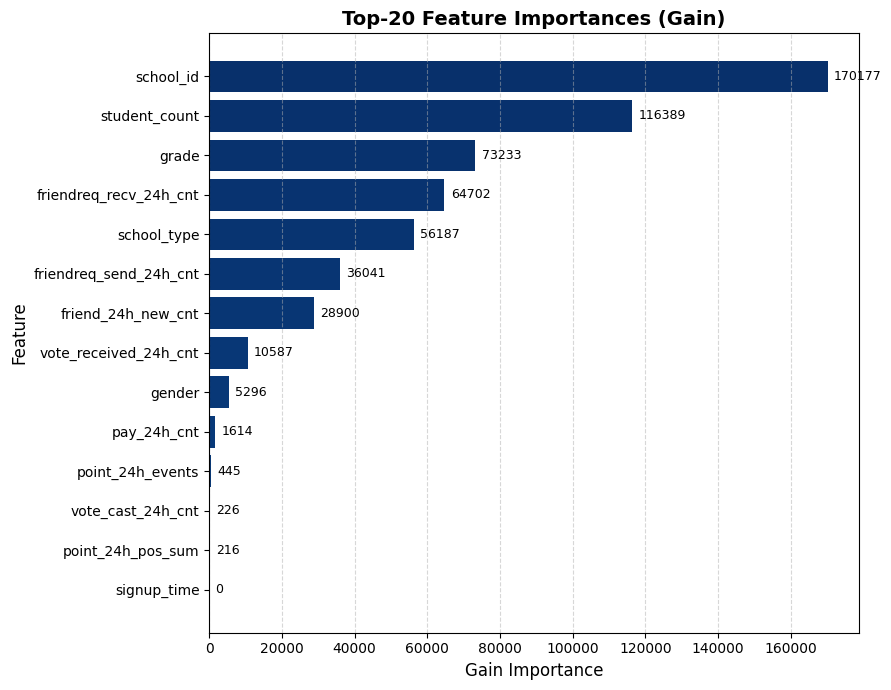


[Top-20 Feature Importances]
                   feature  gain_importance
3                school_id    170177.231406
4            student_count    116389.706449
2                    grade     73233.781854
10  friendreq_recv_24h_cnt     64702.197712
5              school_type     56187.047592
9   friendreq_send_24h_cnt     36041.112832
11      friend_24h_new_cnt     28900.441999
13   vote_received_24h_cnt     10587.912007
1                   gender      5296.150852
6              pay_24h_cnt      1614.301443
7         point_24h_events       445.486325
12       vote_cast_24h_cnt       226.302287
8        point_24h_pos_sum       216.396858
0              signup_time         0.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 중요도 DataFrame
imp = pd.DataFrame({
    "feature": X_train_p.columns,
    "gain_importance": best_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain_importance", ascending=False)

topn = 20
top_imp = imp.head(topn)

# 색상: 하늘색 계열 (Blues colormap)
colors = plt.cm.Blues_r(range(topn))

plt.figure(figsize=(9, 7))
bars = plt.barh(top_imp["feature"], top_imp["gain_importance"], color=colors)

# 값 라벨 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + (max(top_imp["gain_importance"]) * 0.01), 
             bar.get_y() + bar.get_height()/2,
             f"{int(width)}", va='center', fontsize=9, color="black")

plt.gca().invert_yaxis()
plt.title(f"Top-{topn} Feature Importances (Gain)", fontsize=14, fontweight="bold")
plt.xlabel("Gain Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print("\n[Top-20 Feature Importances]")
print(top_imp)


       모델 성능 요약

- **ROC-AUC**: 0.7784  
  → 전체적으로 분류 능력이 준수한 수준.  

- **PR-AUC**: 0.8598  
  → 불균형 데이터 상황에서도 긍정 클래스(활동 유지) 예측력이 높음.  

- **Metrics @0.5 (기본 임계값)**  
  - Accuracy: 0.7331  
  - Precision: 0.7498  
  - Recall: 0.8843  
  - F1: 0.8115  
  → 리콜이 높아 놓치지 않고 잘 잡지만, 약간의 과잉 예측 경향이 있음.  

- **Best-F1 기준 (thr=0.4279)**  
  - F1: 0.8147 (정밀도와 재현율 균형 개선)  

- **Best-F2 기준 (thr=0.1964)**  
  - F2: 0.9046 (리콜 극대화 → 운영에서 "놓치지 않는 것"을 더 중시한다면 적합)  

---

       Feature Importance 해석 (Top Features)

- **주요 요인 (가장 큰 영향)**  
  - `school_id`, `student_count`, `grade`  
  → 어떤 학교에 속해 있고, 규모나 학년이 활동 지속 여부를 크게 좌우.  

- **보조 요인 (사회적 활동성)**  
  - `friendreq_recv_24h_cnt`, `friendreq_send_24h_cnt`, `friend_24h_new_cnt`  
  → 초기 친구 관계 맺기 활동이 많을수록 유지 가능성이 높음.  

- **중간 영향**  
  - `vote_received_24h_cnt`, `gender`, `pay_24h_cnt`  
  → 일부 기여하지만 핵심보다는 부차적.  

- **거의 영향 없음**  
  - `point_24h_events`, `signup_time`  
  → 모델 의사결정에 거의 쓰이지 않음.  

---

       결론

- 이 모델은 **학교 배경(환경적 요인) + 초기 소셜 활동성**이 장기 활동 지속을 잘 설명한다고 볼 수 있음.  
- ROC-AUC과 PR-AUC 모두 준수하여 **운영 적용 가능 수준**.  
- 임계값을 어떻게 두느냐에 따라 활용 전략이 달라짐:  
  - **F1 기준** → 균형 잡힌 운영  
  - **F2 기준** → 장기 활동 유저를 놓치지 않게 집중 (추천)  


## shap 분석

In [ ]:
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# 출력 폴더
os.makedirs("shap_plots", exist_ok=True)

# --- 1) SHAP 계산 (LightGBM 트리 전용 Explainer) ---
explainer = shap.TreeExplainer(best_model)
shap_values_raw = explainer.shap_values(X_test_p)

# LightGBM 이진분류는 list 반환하는 경우가 있음 → 양성 클래스(1)로 통일
if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
    shap_values = shap_values_raw[1]
else:
    shap_values = shap_values_raw  # 이미 2D ndarray인 경우


d:\python\코드잇 스프린트 데분\codeit-sprint-projects\고급 프로젝트\.conda\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


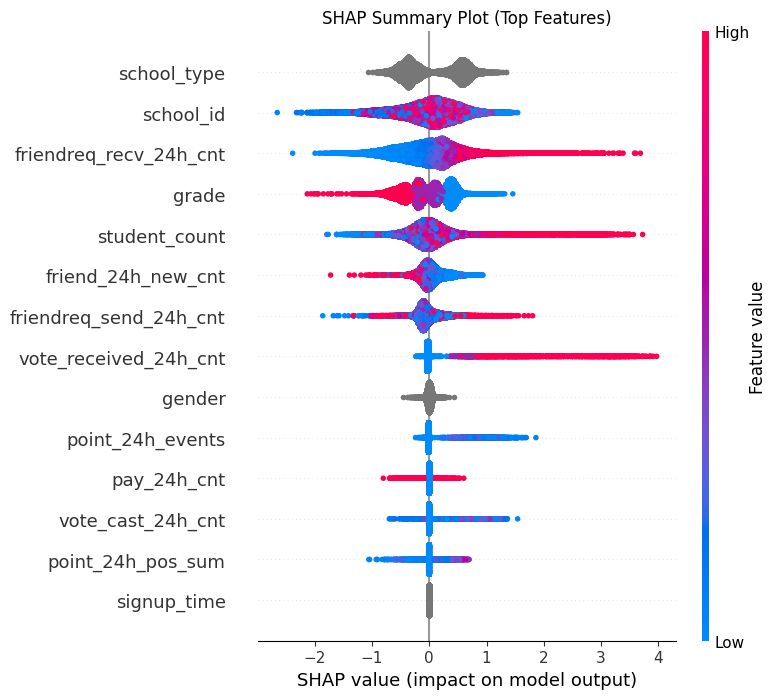

In [ ]:
# --- 2) Summary Plot (산점도) ---
plt.title("SHAP Summary Plot (Top Features)")
shap.summary_plot(shap_values, X_test_p)
plt.close()

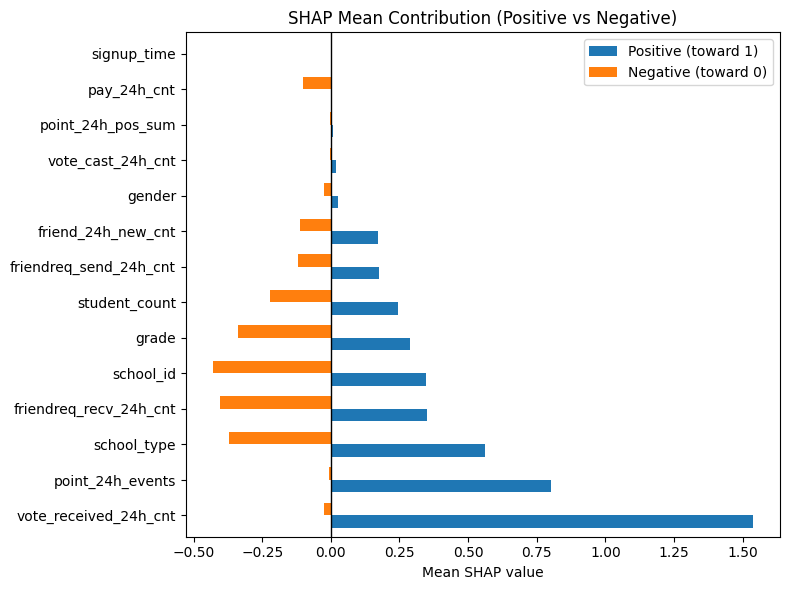

In [ ]:
# --- 1) SHAP 값 평균 양/음 분리 ---
shap_df = pd.DataFrame(shap_values, columns=X_test_p.columns)

# 양수, 음수 기여 평균 따로 계산
mean_pos = shap_df.where(shap_df > 0).mean().sort_values(ascending=False)
mean_neg = shap_df.where(shap_df < 0).mean().sort_values(ascending=True)

# 합치기
imp_df = pd.concat([mean_pos, mean_neg], axis=1)
imp_df.columns = ["Positive (toward 1)", "Negative (toward 0)"]

# --- 2) 상위 n개 선택 ---
topn = 15
imp_df = imp_df.iloc[:topn]

# --- 3) 시각화 ---
imp_df.plot(kind="barh", figsize=(8,6), width=0.7)
plt.axvline(0, color="black", linewidth=1)
plt.title("SHAP Mean Contribution (Positive vs Negative)")
plt.xlabel("Mean SHAP value")
plt.tight_layout()
plt.show()


In [ ]:
imp_df

Positive (toward 1)  Negative (toward 0)
vote_received_24h_cnt              1.537244            -0.024249
point_24h_events                   0.801224            -0.006902
school_type                        0.561708            -0.371261
friendreq_recv_24h_cnt             0.349832            -0.402984
school_id                          0.346761            -0.430073
grade                              0.286990            -0.336429
student_count                      0.246067            -0.221340
friendreq_send_24h_cnt             0.174673            -0.117873
friend_24h_new_cnt                 0.173309            -0.111276
gender                             0.025828            -0.025086
vote_cast_24h_cnt                  0.020089            -0.002996
point_24h_pos_sum                  0.007826            -0.001998
pay_24h_cnt                        0.005420            -0.099624
signup_time                             NaN                  NaN

## SHAP 해석 요약

### 활동 유지(긍정)에 기여하는 주요 요인
- **vote_received_24h_cnt (투표 받은 수)**  
  → 투표를 많이 받을수록 활동 유지 확률 ↑  
- **point_24h_events (포인트 관련 이벤트)**  
  → 포인트 관련 활동이 활발하면 유지 가능성 ↑  
- **school_type** (양의 영향도 뚜렷)  
  → 특정 학교 유형에서 유지 경향 ↑  

### 활동 중단(부정)에 기여하는 주요 요인
- **friendreq_recv_24h_cnt / school_id / grade**  
  → 특정 학교/학년/친구관계 맥락에서 이탈 경향 ↑  
- **student_count**  
  → 학교 규모가 크거나 특정 환경일 때 활동 지속이 약화될 수 있음  
- **pay_24h_cnt**  
  → 결제 이벤트가 적거나 패턴이 불규칙한 경우 오히려 중단 기여 ↑  

### 중립적 / 영향 미미
- **gender, vote_cast_24h_cnt, point_24h_pos_sum** → 영향은 있지만 미미  
- **signup_time** → 모델에서 의미 있는 역할을 하지 않음  

---

## 결론
- **긍정적 요인**: 초반에 받은 투표, 포인트 활동, 일부 학교 유형 → 활동 지속 촉진  
- **부정적 요인**: 특정 학교/학년 배경, 친구관계 구조, 결제 패턴 → 이탈 촉진  
- 결국 **“학교/사회적 환경”과 “활동 초기 반응(투표·포인트)”**이 맞물려 활동 유지 여부를 좌우한다고 해석 가능
